<a href="https://colab.research.google.com/github/claravivian/Predicting-Drought-in-The-United-States-Using-Deep-Learning/blob/main/MLP_and_LSTM_clark_coconino_crook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Library

In [ ]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.3 MB/s 


In [ ]:
import random
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers

from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.layers import Dense, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LeakyReLU
LeakyReLU = LeakyReLU(alpha=0.2)
from keras.layers import PReLU
import warnings
warnings.filterwarnings('ignore')
from imblearn.over_sampling import SMOTE
from copy import copy

In [ ]:
print(tf.version.VERSION)

2.9.2


In [ ]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 4.4 MB/s 
     |████████████████████████████████| 1.6 MB 41.4 MB/s 


In [ ]:
import kerastuner as kt

#Import Data From Kaggle

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download cdminix/us-drought-meteorological-data

 98% 884M/901M [00:04<00:00, 225MB/s]
100% 901M/901M [00:04<00:00, 207MB/s]


In [ ]:
!unzip us-drought-meteorological-data.zip

Archive:  us-drought-meteorological-data.zip
  inflating: soil_data.csv           
  inflating: test_timeseries/test_timeseries.csv  
  inflating: train_timeseries/train_timeseries.csv  
  inflating: validation_timeseries/validation_timeseries.csv  


In [ ]:
train = pd.read_csv('/content/train_timeseries/train_timeseries.csv')
soil = pd.read_csv('/content/soil_data.csv')
validation = pd.read_csv('/content/validation_timeseries/validation_timeseries.csv')
test = pd.read_csv('/content/test_timeseries/test_timeseries.csv')
pd.set_option('display.max_columns', None)

#Checking the Data

##train (1-1-2000 until 31-12-2016)

In [ ]:
train.head()

fips        date  PRECTOT      PS   QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  \
0  1001  2000-01-01     0.22  100.51   9.65  14.74   13.51   13.51    20.96   
1  1001  2000-01-02     0.20  100.55  10.42  16.69   14.71   14.71    22.80   
2  1001  2000-01-03     3.65  100.15  11.76  18.49   16.52   16.52    22.73   
3  1001  2000-01-04    15.95  100.29   6.42  11.40    6.09    6.10    18.09   
4  1001  2000-01-05     0.00  101.15   2.95   3.86   -3.29   -3.20    10.82   

   T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  WS50M  \
0    11.46       9.50  14.65   2.20       2.94       1.49         1.46   4.85   
1    12.61      10.18  16.60   2.52       3.43       1.83         1.60   5.33   
2    15.32       7.41  18.41   4.03       5.33       2.66         2.67   7.53   
3     2.16      15.92  11.31   3.84       5.67       2.08         3.59   6.73   
4    -2.66      13.48   2.65   1.60       2.50       0.52         1.98   2.94   

   WS50M_MAX  WS50M_MIN  WS50M_RANGE  score  
0       6.04       3.23         2.81    NaN  
1       6.13       3.72         2.41    NaN  
2       9.52       5.87         3.66    NaN  
3       9.31       3.74         5.58    1.0  
4       4.85       0.65         4.19    NaN

In [ ]:
train.tail()

fips        date  PRECTOT     PS  QV2M   T2M  T2MDEW  T2MWET  \
19300675  56043  2016-12-27     0.16  82.88  1.63 -7.97  -13.49  -12.81   
19300676  56043  2016-12-28     0.02  83.33  1.41 -8.71  -14.10  -13.84   
19300677  56043  2016-12-29     0.00  83.75  1.59 -7.96  -13.30  -13.03   
19300678  56043  2016-12-30     1.22  82.49  2.63 -2.94   -7.40   -7.33   
19300679  56043  2016-12-31     0.44  82.19  1.75 -7.56  -11.98  -11.82   

          T2M_MAX  T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  \
19300675    -1.39   -13.60      12.21  -9.41   5.90       7.63       3.61   
19300676    -2.49   -13.56      11.07 -10.55   6.50      11.43       4.11   
19300677     0.42   -14.51      14.93 -10.29   4.29       6.24       2.03   
19300678     3.76    -6.86      10.62  -4.14   4.98       7.34       1.99   
19300679    -0.95   -11.61      10.66 -10.17   2.31       3.47       0.41   

          WS10M_RANGE  WS50M  WS50M_MAX  WS50M_MIN  WS50M_RANGE  score  
19300675         4.02   8.58      10.39       5.92         4.47    0.0  
19300676         7.32   9.92      14.49       7.26         7.22    NaN  
19300677         4.22   6.56      10.07       3.20         6.87    NaN  
19300678         5.35   7.28      10.12       3.24         6.89    NaN  
19300679         3.06   3.37       5.26       0.66         4.60    NaN

In [ ]:
train.shape

(19300680, 21)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19300680 entries, 0 to 19300679
Data columns (total 21 columns):
 #   Column       Dtype  
---  ------       -----  
 0   fips         int64  
 1   date         object 
 2   PRECTOT      float64
 3   PS           float64
 4   QV2M         float64
 5   T2M          float64
 6   T2MDEW       float64
 7   T2MWET       float64
 8   T2M_MAX      float64
 9   T2M_MIN      float64
 10  T2M_RANGE    float64
 11  TS           float64
 12  WS10M        float64
 13  WS10M_MAX    float64
 14  WS10M_MIN    float64
 15  WS10M_RANGE  float64
 16  WS50M        float64
 17  WS50M_MAX    float64
 18  WS50M_MIN    float64
 19  WS50M_RANGE  float64
 20  score        float64
dtypes: float64(19), int64(1), object(1)
memory usage: 3.0+ GB


In [ ]:
#banyak data NaN
missing_values_count = train.isnull().sum()
missing_values_count

fips                  0
date                  0
PRECTOT               0
PS                    0
QV2M                  0
T2M                   0
T2MDEW                0
T2MWET                0
T2M_MAX               0
T2M_MIN               0
T2M_RANGE             0
TS                    0
WS10M                 0
WS10M_MAX             0
WS10M_MIN             0
WS10M_RANGE           0
WS50M                 0
WS50M_MAX             0
WS50M_MIN             0
WS50M_RANGE           0
score          16543884
dtype: int64

##list of variables in the weather data

Indicator	Description

WS10M_MIN	Minimum Wind Speed at 10 Meters (m/s)

QV2M	Specific Humidity at 2 Meters (g/kg)

T2M_RANGE	Temperature Range at 2 Meters (C)

WS10M	Wind Speed at 10 Meters (m/s)

T2M	Temperature at 2 Meters (C)

WS50M_MIN	Minimum Wind Speed at 50 Meters (m/s)

T2M_MAX	Maximum Temperature at 2 Meters (C)

WS50M	Wind Speed at 50 Meters (m/s)

TS	Earth Skin Temperature (C)

WS50M_RANGE	Wind Speed Range at 50 Meters (m/s)

WS50M_MAX	Maximum Wind Speed at 50 Meters (m/s)

WS10M_MAX	Maximum Wind Speed at 10 Meters (m/s)

WS10M_RANGE	Wind Speed Range at 10 Meters (m/s)

PS	Surface Pressure (kPa)

T2MDEW	Dew/Frost Point at 2 Meters (C)

T2M_MIN	Minimum Temperature at 2 Meters (C)

T2MWET	Wet Bulb Temperature at 2 Meters (C)

PRECTOT	Precipitation (mm day-1)

##soil

In [ ]:
soil.head()

fips        lat        lon  elevation  slope1  slope2  slope3  slope4  \
0  1001  32.536382 -86.644490         63  0.0419  0.2788  0.2984  0.2497   
1  1005  31.870670 -85.405456        146  0.0158  0.1868  0.5441  0.2424   
2  1003  30.659218 -87.746067         52  0.0746  0.4370  0.4415  0.0469   
3  1007  33.015893 -87.127148         93  0.0144  0.1617  0.3714  0.3493   
4  1009  33.977448 -86.567246        198  0.0050  0.0872  0.2799  0.3576   

   slope5  slope6  slope7  slope8  aspectN  aspectE  aspectS  aspectW  \
0  0.1142  0.0170  0.0000     0.0   0.1033   0.1859   0.2003   0.1898   
1  0.0106  0.0003  0.0000     0.0   0.1415   0.2379   0.2183   0.1997   
2  0.0000  0.0000  0.0000     0.0   0.1168   0.1386   0.1048   0.1282   
3  0.0898  0.0134  0.0000     0.0   0.1971   0.1885   0.2279   0.2104   
4  0.1477  0.1037  0.0189     0.0   0.2569   0.1503   0.2028   0.2978   

   aspectUnknown  WAT_LAND   NVG_LAND  URB_LAND  GRS_LAND   FOR_LAND  \
0         0.3207    0.9974  27.940498    0.2889  2.750274  10.714703   
1         0.2026    0.0000   0.000000    0.4146  2.225602  22.952839   
2         0.5116    0.0000   0.000000    3.5010  4.972456  28.685991   
3         0.1761    0.0000   0.000000    0.2283  8.674664  89.172112   
4         0.0922    0.0000   0.000000    1.0037  8.606856  88.470047   

   CULTRF_LAND  CULTIR_LAND  CULT_LAND  SQ1  SQ2  SQ3  SQ4  SQ5  SQ6  SQ7  
0    56.293411     1.014811  57.308224    1    1    1    1    1    1    2  
1    72.578804     1.828159  74.406960    3    2    1    1    1    1    1  
2    59.843639     2.996914  62.840553    3    2    1    2    1    1    1  
3     1.916593     0.008330   1.924924    3    2    1    1    1    1    1  
4     1.891909     0.027488   1.919397    3    2    1    1    1    1    1

In [ ]:
soil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3109 entries, 0 to 3108
Data columns (total 32 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   fips           3109 non-null   int64  
 1   lat            3109 non-null   float64
 2   lon            3109 non-null   float64
 3   elevation      3109 non-null   int64  
 4   slope1         3109 non-null   float64
 5   slope2         3109 non-null   float64
 6   slope3         3109 non-null   float64
 7   slope4         3109 non-null   float64
 8   slope5         3109 non-null   float64
 9   slope6         3109 non-null   float64
 10  slope7         3109 non-null   float64
 11  slope8         3109 non-null   float64
 12  aspectN        3109 non-null   float64
 13  aspectE        3109 non-null   float64
 14  aspectS        3109 non-null   float64
 15  aspectW        3109 non-null   float64
 16  aspectUnknown  3109 non-null   float64
 17  WAT_LAND       3109 non-null   float64
 18  NVG_LAND

In [ ]:
soil.describe()

fips          lat          lon    elevation       slope1  \
count   3109.000000  3109.000000  3109.000000  3109.000000  3109.000000   
mean   30678.538437    38.280052   -91.659790   427.624638     0.054973   
std    14986.018730     4.838634    11.485291   500.158880     0.089873   
min     1001.000000    25.601043  -124.211407    -1.000000     0.000000   
25%    19045.000000    34.686818   -98.046842   132.000000     0.008300   
50%    29213.000000    38.328061   -90.181170   272.000000     0.028300   
75%    46009.000000    41.703590   -83.373303   483.000000     0.068500   
max    56045.000000    48.842653   -67.609354  3561.000000     0.974000   

           slope2       slope3       slope4       slope5       slope6  \
count  3109.00000  3109.000000  3109.000000  3109.000000  3109.000000   
mean      0.29775     0.319991     0.155878     0.053409     0.065323   
std       0.21595     0.167727     0.128400     0.073107     0.125526   
min       0.00000     0.000000     0.000000     0.000000     0.000000   
25%       0.10510     0.185800     0.040800     0.000500     0.000000   
50%       0.27100     0.347100     0.127500     0.012200     0.000700   
75%       0.47750     0.459300     0.255200     0.090300     0.054100   
max       0.75990     0.696900     0.571700     0.330000     0.606800   

            slope7       slope8      aspectN      aspectE      aspectS  \
count  3109.000000  3109.000000  3109.000000  3109.000000  3109.000000   
mean      0.022223     0.009267     0.143749     0.168888     0.148392   
std       0.064127     0.044933     0.078237     0.084105     0.082111   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.086200     0.109200     0.086300   
50%       0.000000     0.000000     0.144200     0.174000     0.148300   
75%       0.001200     0.000000     0.195600     0.227600     0.206600   
max       0.476500     0.628800     0.478400     0.738500     0.511200   

           aspectW  aspectUnknown     WAT_LAND     NVG_LAND     URB_LAND  \
count  3109.000000    3109.000000  3109.000000  3109.000000  3109.000000   
mean      0.165061       0.352723     2.850511     1.801451     2.670026   
std       0.087843       0.272182    13.159247     7.971805     9.770693   
min       0.000000       0.000000     0.000000     0.000000     0.000000   
25%       0.101500       0.115600     0.000000     0.000000     0.104800   
50%       0.165500       0.305900     0.000000     0.000000     0.488500   
75%       0.223100       0.555200     0.000000     0.000000     1.115100   
max       0.657800       1.000000   100.000000    99.982918    99.998764   

          GRS_LAND     FOR_LAND  CULTRF_LAND  CULTIR_LAND    CULT_LAND  \
count  3109.000000  3109.000000  3109.000000  3109.000000  3109.000000   
mean     19.812154    39.296586    28.494804     3.504682    31.999486   
std      25.447435    34.365530    31.839502    10.290893    33.099657   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       4.360057     4.552230     0.143526     0.045909     1.602227   
50%       8.839095    30.573359    14.043937     0.276606    18.811279   
75%      23.720787    74.532990    51.737080     1.370315    60.637421   
max      99.998596    91.044609    97.029572    99.956841    99.956841   

               SQ1          SQ2          SQ3         SQ4          SQ5  \
count  3109.000000  3109.000000  3109.000000  3109.00000  3109.000000   
mean      1.830492     1.553554     1.282084     1.35735     1.146993   
std       1.192219     1.021382     1.002508     1.03011     0.922308   
min       0.000000     0.000000     0.000000     0.00000     0.000000   
25%       1.000000     1.000000     1.000000     1.00000     1.000000   
50%       1.000000     1.000000     1.000000     1.00000     1.000000   
75%       3.000000     2.000000     1.000000     1.00000     1.000000   
max       7.000000     7.000000     7.000000     7.00000     7.000000   

    

In [ ]:
#banyak data NaN
missing_values_count = soil.isnull().sum()
missing_values_count

fips             0
lat              0
lon              0
elevation        0
slope1           0
slope2           0
slope3           0
slope4           0
slope5           0
slope6           0
slope7           0
slope8           0
aspectN          0
aspectE          0
aspectS          0
aspectW          0
aspectUnknown    0
WAT_LAND         0
NVG_LAND         0
URB_LAND         0
GRS_LAND         0
FOR_LAND         0
CULTRF_LAND      0
CULTIR_LAND      0
CULT_LAND        0
SQ1              0
SQ2              0
SQ3              0
SQ4              0
SQ5              0
SQ6              0
SQ7              0
dtype: int64

##validation (1-1-2017 until 31-12-2018)

In [ ]:
validation.head()

fips        date  PRECTOT      PS   QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  \
0  1001  2017-01-01    32.50  100.02  10.47  14.69   14.47   14.47    17.68   
1  1001  2017-01-02    63.52  100.04  12.75  17.96   17.75   17.75    20.30   
2  1001  2017-01-03    18.82   99.69   9.74  14.24   13.44   13.44    18.48   
3  1001  2017-01-04     0.01  100.02   5.21   8.10    3.86    3.88    11.74   
4  1001  2017-01-05     0.01   99.89   4.54   5.91    2.20    2.22    13.07   

   T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  WS50M  \
0    10.53       7.15  14.63   2.14       2.71       1.52         1.19   4.40   
1    16.14       4.16  17.85   2.75       4.31       1.60         2.71   5.50   
2     9.29       9.20  14.06   2.25       3.73       1.64         2.09   4.80   
3     2.12       9.62   8.08   2.63       3.95       1.34         2.60   4.98   
4    -0.18      13.24   5.85   1.76       2.76       0.47         2.28   3.43   

   WS50M_MAX  WS50M_MIN  WS50M_RANGE  score  
0       5.96       2.25         3.71    NaN  
1       8.16       4.05         4.11    NaN  
2       7.27       2.54         4.72    2.0  
3       6.16       3.36         2.80    NaN  
4       4.70       0.66         4.04    NaN

In [ ]:
validation.tail()

fips        date  PRECTOT     PS  QV2M    T2M  T2MDEW  T2MWET  \
2268835  56043  2018-12-27     0.14  82.71  1.54  -9.57  -14.20  -13.09   
2268836  56043  2018-12-28     0.02  83.14  1.32 -11.25  -15.98  -14.57   
2268837  56043  2018-12-29     0.34  82.78  1.75  -7.17  -12.62  -12.17   
2268838  56043  2018-12-30     3.17  81.97  2.72  -2.84   -7.14   -6.95   
2268839  56043  2018-12-31     1.39  83.16  1.03 -13.02  -18.93  -16.97   

         T2M_MAX  T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  \
2268835    -6.23   -12.06       5.82 -10.10   2.01       3.56       0.23   
2268836    -7.03   -14.33       7.30 -12.36   1.66       3.12       0.09   
2268837     0.64   -14.85      15.50  -8.09   3.64       4.71       2.47   
2268838     2.14    -8.49      10.62  -3.63   5.26      11.19       1.70   
2268839    -9.70   -16.67       6.96 -13.06   4.53       9.66       0.82   

         WS10M_RANGE  WS50M  WS50M_MAX  WS50M_MIN  WS50M_RANGE  score  
2268835         3.33   2.67       4.70       0.28         4.42    NaN  
2268836         3.04   2.40       5.58       0.08         5.50    NaN  
2268837         2.24   5.58       7.61       4.15         3.46    NaN  
2268838         9.49   7.56      13.59       3.11        10.49    NaN  
2268839         8.84   5.51      11.90       0.96        10.94    NaN

In [ ]:
validation.info()

In [ ]:
#banyak data NaN
missing_values_count = validation.isnull().sum()
missing_values_count

fips                 0
date                 0
PRECTOT              0
PS                   0
QV2M                 0
T2M                  0
T2MDEW               0
T2MWET               0
T2M_MAX              0
T2M_MIN              0
T2M_RANGE            0
TS                   0
WS10M                0
WS10M_MAX            0
WS10M_MIN            0
WS10M_RANGE          0
WS50M                0
WS50M_MAX            0
WS50M_MIN            0
WS50M_RANGE          0
score          1945608
dtype: int64

In [ ]:
validation.shape

(2268840, 21)

##test (1-1-2019 until 31-12-2020)

In [ ]:
test.head()

In [ ]:
test.tail()

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2271948 entries, 0 to 2271947
Data columns (total 21 columns):
 #   Column       Dtype  
---  ------       -----  
 0   fips         int64  
 1   date         object 
 2   PRECTOT      float64
 3   PS           float64
 4   QV2M         float64
 5   T2M          float64
 6   T2MDEW       float64
 7   T2MWET       float64
 8   T2M_MAX      float64
 9   T2M_MIN      float64
 10  T2M_RANGE    float64
 11  TS           float64
 12  WS10M        float64
 13  WS10M_MAX    float64
 14  WS10M_MIN    float64
 15  WS10M_RANGE  float64
 16  WS50M        float64
 17  WS50M_MAX    float64
 18  WS50M_MIN    float64
 19  WS50M_RANGE  float64
 20  score        float64
dtypes: float64(19), int64(1), object(1)
memory usage: 364.0+ MB


In [ ]:
#banyak data NaN
missing_values_count = test.isnull().sum()
missing_values_count

fips                 0
date                 0
PRECTOT              0
PS                   0
QV2M                 0
T2M                  0
T2MDEW               0
T2MWET               0
T2M_MAX              0
T2M_MIN              0
T2M_RANGE            0
TS                   0
WS10M                0
WS10M_MAX            0
WS10M_MIN            0
WS10M_RANGE          0
WS50M                0
WS50M_MAX            0
WS50M_MIN            0
WS50M_RANGE          0
score          1945608
dtype: int64

#Choosing 9 regions of the United States Based on 9 Climate Regions in the United States

There are 9 climate regions in the United States:
1. Northeast
2. Upper Midwest
3. Ohio Valley
4. Southeast
5. Northern Rockies and Plains
6. South
7. Southwest
8. Northwest
9. West

Then, we will choose 1 state from each of the climate regions, there are:
1. New York County, New York (36061), dari Northeast 
2. Dakota County, Minnesota (27037), dari Upper Midwest
3. Jasper County, Missouri (29097), dari Ohio Valley
4. St. Lucie County, Florida (12111), dari Southeast
5. Holt County, Nebraska (31089), dari Northern Rockies and Plains
6. Clark County, Kansas (20025), dari South
7. Coconino County, Arizona (04005), dari Southwest
8. Crook County, Oregon (41013), dari Northwest
9. Los Angeles County, California (06037), dari West

Each notebook contains 3 different states for different models(MLP-and-LSTM and CNN-LSTM)

##Clark, Kansas

###train

In [ ]:
ks = train[train['fips']==20025]

#using interpolation to fill in the NaN values
ks = ks.interpolate().fillna(method='bfill')
ks.score[ks.score <0.5] = 0
ks.score[(ks.score >=0.5)&(ks.score<1.5)] = 1
ks.score[(ks.score >=1.5)&(ks.score<2.5)] = 2
ks.score[(ks.score >=2.5)&(ks.score<3.5)] = 3
ks.score[(ks.score >=3.5)&(ks.score<4.5)] = 4
ks.score[(ks.score >=4.5)&(ks.score<5.5)] = 5


ks.head()

fips        date  PRECTOT     PS  QV2M    T2M  T2MDEW  T2MWET  \
5377860  20025  2000-01-01     0.00  92.66  3.92  10.08   -0.92   -0.86   
5377861  20025  2000-01-02     0.02  93.00  3.49   5.76   -2.22   -2.16   
5377862  20025  2000-01-03     1.94  93.43  2.92  -0.95   -4.71   -4.64   
5377863  20025  2000-01-04     0.00  94.54  1.60  -1.59  -11.38  -10.99   
5377864  20025  2000-01-05     0.27  93.55  2.82   1.61   -5.25   -5.13   

         T2M_MAX  T2M_MIN  T2M_RANGE    TS  WS10M  WS10M_MAX  WS10M_MIN  \
5377860    20.12     1.71      18.41  9.46   6.68       9.82       3.96   
5377861    12.76     0.84      11.92  5.99   3.73       8.68       0.58   
5377862     1.57    -5.45       7.01 -0.88   8.16      11.02       3.86   
5377863     6.98    -7.53      14.51 -2.04   4.35       5.84       1.30   
5377864    11.79    -3.99      15.78  0.85   4.69       6.74       2.44   

         WS10M_RANGE  WS50M  WS50M_MAX  WS50M_MIN  WS50M_RANGE  score  
5377860         5.86  10.14      14.25       6.95         7.31    1.0  
5377861         8.10   6.12      12.80       0.81        11.99    1.0  
5377862         7.16  10.48      13.78       5.50         8.28    1.0  
5377863         4.55   6.61       9.86       2.04         7.82    1.0  
5377864         4.30   6.71       9.95       3.76         6.20    1.0

In [ ]:
clark = train[train['fips']==20025]

#using interpolation to fill in the NaN values
clark = clark.interpolate().fillna(method='bfill')
clark.score[clark.score <0.5] = 0
clark.score[(clark.score >=0.5)&(clark.score<1.5)] = 1
clark.score[(clark.score >=1.5)&(clark.score<2.5)] = 2
clark.score[(clark.score >=2.5)&(clark.score<3.5)] = 3
clark.score[(clark.score >=3.5)&(clark.score<4.5)] = 4
clark.score[(clark.score >=4.5)&(clark.score<5.5)] = 5

#merging the weather data with the soil data
clark = clark.merge(soil, left_on='fips', right_on='fips')
train_ks = clark.copy()
clark['date'] = pd.to_datetime(clark['date'], format='%Y.%m.%d')
train_ks['tahun'] = clark['date'].dt.year
train_ks['bulan'] = clark['date'].dt.month
train_ks['tanggal'] = clark['date'].dt.day
train_ks[0:31]

fips        date  PRECTOT     PS  QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  \
0   20025  2000-01-01     0.00  92.66  3.92  10.08   -0.92   -0.86    20.12   
1   20025  2000-01-02     0.02  93.00  3.49   5.76   -2.22   -2.16    12.76   
2   20025  2000-01-03     1.94  93.43  2.92  -0.95   -4.71   -4.64     1.57   
3   20025  2000-01-04     0.00  94.54  1.60  -1.59  -11.38  -10.99     6.98   
4   20025  2000-01-05     0.27  93.55  2.82   1.61   -5.25   -5.13    11.79   
5   20025  2000-01-06     0.01  94.73  2.57   1.33   -5.91   -5.78     7.27   
6   20025  2000-01-07     0.00  94.63  2.33   1.98   -7.02   -6.85    10.86   
7   20025  2000-01-08     0.06  93.35  2.92   1.75   -4.48   -4.41     9.23   
8   20025  2000-01-09     0.00  92.70  2.72   3.50   -5.45   -5.34    11.98   
9   20025  2000-01-10     0.00  93.06  2.45   4.42   -6.75   -6.57    15.95   
10  20025  2000-01-11     0.00  93.55  2.25   2.79   -7.76   -7.53    12.15   
11  20025  2000-01-12     0.01  93.44  2.92   5.92   -4.42   -4.31    17.44   
12  20025  2000-01-13     0.00  95.48  2.15   1.55   -7.90   -7.66     9.55   
13  20025  2000-01-14     0.00  94.99  2.46   4.86   -6.33   -6.16    15.52   
14  20025  2000-01-15     0.00  93.98  3.50   7.58   -2.04   -1.98    16.43   
15  20025  2000-01-16     0.01  94.55  3.42   2.73   -2.31   -2.27     8.21   
16  20025  2000-01-17     0.02  94.18  4.27   5.60    0.74    0.76    11.97   
17  20025  2000-01-18     0.00  94.16  4.12   6.41    0.26    0.28    13.56   
18  20025  2000-01-19     0.00  93.75  3.54   6.52   -2.28   -2.20    19.16   
19  20025  2000-01-20     0.00  94.33  2.00  -0.15   -8.86   -8.64     6.03   
20  20025  2000-01-21     0.00  93.28  2.48   2.24   -6.51   -6.36     9.55   
21  20025  2000-01-22     0.17  93.28  3.27   4.68   -3.01   -2.95    13.83   
22  20025  2000-01-23     0.60  94.17  3.42   1.60   -2.46   -2.43     7.33   
23  20025  2000-01-24     0.04  94.08  2.79   1.71   -4.95   -4.88    11.13   
24  20025  2000-01-25     0.10  94.62  1.76  -1.82  -10.33  -10.00     1.15   
25  20025  2000-01-26     1.29  94.16  2.32  -3.17   -7.17   -7.08    -1.38   
26  20025  2000-01-27     6.40  94.43  2.28  -4.13   -7.27   -7.21    -1.81   
27  20025  2000-01-28     0.70  94.68  2.02  -4.30   -8.64   -8.53    -1.74   
28  20025  2000-01-29     0.02  94.60  2.33  -3.23   -7.06   -7.00     2.84   
29  20025  2000-01-30     0.00  94.58  2.41  -3.22   -6.58   -6.53     3.20   
30  20025  2000-01-31     0.05  94.17  2.66  -1.77   -5.50   -5.45     5.46   

    T2M_MIN  T2M_RANGE    TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  WS50M  \
0      1.71      18.41  9.46   6.68       9.82       3.96         5.86  10.14   
1      0.84      11.92  5.99   3.73       8.68       0.58         8.10   6.12   
2     -5.45       7.01 -0.88   8.16      11.02       3.86         7.16  10.48   
3     -7.53      14.51 -2.04   4.35       5.84       1.30         4.55   6.61   
4     -3.99      15.78  0.85   4.69       6.74       2.44         4.30   6.71   
5     -2.60       9.87 -0.08   3.88       5.71       0.80         4.90   5.66   
6     -3.54      14.41  1.37   5.08       8.16       3.37         4.79   8.44   
7     -3.15      12.38  0.78   3.14       5.26       1.65         3.61   4.83   
8     -2.13      14.11  2.11   4.96       9.90       0.83         9.07   7.52   
9     -1.36      17.31  3.93   6.01       8.06       2.79         5.27   8.96   
10    -3.97      16.12  2.31   4.84       8.25       2.24         6.01   7.61   
11    -0.12      17.56  5.02   5.35       9.00       3.20         5.80   8.54   
12    -3.73      13.28  1.56   3.82       4.77       3.17         1.59   6.51   
13    -3.04      18.56  4.43   7.61      11.99       4.80         7.20  11.04   
14     0.91      15.52  6.19   4.30       7.73       1.14         6.60   6.23   
15    -1.87      10.08  3.17   4.46       6.84       2.25         4.59   6.52   
16     0.63      11.34  4.74   1.88       4.01       0.38         3.62   2.47   
17     1.74      1

In [ ]:
train_ks['score'].value_counts()

0.0    2610
1.0    1196
3.0     847
2.0     834
4.0     383
5.0     340
Name: score, dtype: int64

In [ ]:
#For Regression

clark = train[train['fips']==20025]

#using interpolation to fill in the NaN values
clark = clark.interpolate().fillna(method='bfill')

#merging the weather data with the soil data
clark = clark.merge(soil, left_on='fips', right_on='fips')
train_ks = clark.copy()
train_ks[2000:2050]

fips        date  PRECTOT     PS   QV2M    T2M  T2MDEW  T2MWET  \
2000  20025  2005-06-23     0.00  93.62  11.05  26.61   14.49   14.49   
2001  20025  2005-06-24     0.06  93.51  11.33  27.49   14.84   14.84   
2002  20025  2005-06-25     0.01  93.66  10.95  27.20   14.36   14.36   
2003  20025  2005-06-26     0.03  93.59  11.30  27.70   14.85   14.85   
2004  20025  2005-06-27     0.00  93.50  11.49  28.99   15.09   15.09   
2005  20025  2005-06-28     0.02  93.39  10.90  30.22   14.26   14.26   
2006  20025  2005-06-29     0.70  93.24  10.16  30.67   13.14   13.14   
2007  20025  2005-06-30     5.49  93.39  11.10  28.79   14.46   14.46   
2008  20025  2005-07-01    10.41  93.68  14.22  25.06   18.42   18.41   
2009  20025  2005-07-02     0.90  93.39  13.67  27.07   17.79   17.79   
2010  20025  2005-07-03    19.42  93.00  15.75  28.73   19.83   19.83   
2011  20025  2005-07-04     6.46  93.77  14.62  24.32   18.86   18.86   
2012  20025  2005-07-05    14.97  94.07  14.27  23.33   18.58   18.58   
2013  20025  2005-07-06     0.07  93.85  13.34  24.20   17.46   17.46   
2014  20025  2005-07-07     0.05  93.76  13.88  24.92   18.09   18.09   
2015  20025  2005-07-08     0.01  93.82  13.44  25.77   17.60   17.60   
2016  20025  2005-07-09     0.00  93.71  13.03  26.38   17.08   17.08   
2017  20025  2005-07-10     2.91  93.63  12.15  26.03   15.97   15.97   
2018  20025  2005-07-11     1.09  93.71  13.28  26.26   17.38   17.38   
2019  20025  2005-07-12     4.62  94.05  13.76  27.03   17.95   17.95   
2020  20025  2005-07-13     1.87  93.97  13.32  26.65   17.47   17.47   
2021  20025  2005-07-14     0.00  93.73  12.39  26.54   16.30   16.30   
2022  20025  2005-07-15     0.01  93.84  12.30  26.96   16.16   16.16   
2023  20025  2005-07-16     0.00  93.69  12.85  28.10   16.84   16.84   
2024  20025  2005-07-17     0.12  93.32  12.85  29.99   16.77   16.77   
2025  20025  2005-07-18     0.72  93.58  14.13  28.17   18.32   18.32   
2026  20025  2005-07-19     0.18  93.54  14.28  30.35   18.46   18.46   
2027  20025  2005-07-20     0.00  93.59  11.94  32.11   15.67   15.67   
2028  20025  2005-07-21     0.00  93.84  11.45  31.99   15.07   15.07   
2029  20025  2005-07-22     0.00  93.97  10.71  32.56   14.01   14.01   
2030  20025  2005-07-23     0.00  93.87  11.01  32.41   14.48   14.48   
2031  20025  2005-07-24     0.01  93.57  11.53  31.87   15.09   15.09   
2032  20025  2005-07-25     0.93  93.20  11.81  32.19   15.46   15.46   
2033  20025  2005-07-26     1.65  93.72  11.19  24.34   14.54   14.54   
2034  20025  2005-07-27     0.00  94.36   6.40  21.62    6.47    6.48   
2035  20025  2005-07-28     0.00  94.22   6.92  24.19    7.59    7.60   
2036  20025  2005-07-29     0.00  94.19   6.54  26.55    6.73    6.74   
2037  20025  2005-07-30     0.00  94.14   9.75  28.53   12.55   12.55   
2038  20025  2005-07-31     0.00  94.03   8.85  30.16   11.14   11.15   
2039  20025  2005-08-01     0.00  93.87   7.68  30.52    9.02    9.02   
2040  20025  2005-08-02     0.00  93.72   8.80  31.22   10.98   10.98   
2041  20025  2005-08-03     0.00  93.65  10.71  31.29   14.01   14.01   
2042  20025  2005-08-04    10.71  94.15  13.14  27.38   17.20   17.20   
2043  20025  2005-08-05     0.12  94.56  10.09  23.97   13.15   13.15   
2044  20025  2005-08-06     0.84  94.15  11.93  25.95   15.78   15.78   
2045  20025  2005-08-07     1.17  93.85  13.27  28.09   17.38   17.38   
2046  20025  2005-08-08     0.03  93.77  13.06  28.52   17.08   17.08   
2047  20025  2005-08-09     0.00  93.73  12.30  28.72   16.14   16.14   
2048  20025  2005-08-10     0.02  93.77  12.49  29.08   16.41   16.42   
2049  20025  2005-08-11     2.07  93.49  13.42  28.92   17.48   17.48   

      T2M_MAX  T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  \
2000    35.02    17.56      17.46  26.96   6.29       7.60       3.61   
2001    35.37    19.54      15.82  27.81   6.86       8.42       5.40   
2002    34.40    19.93      14.47  27.76   6.23       8.18      

###val

In [ ]:
ks_val = validation[validation['fips']==20025]

#using interpolation to fill in the NaN values
ks_val = ks_val.interpolate().fillna(method='bfill')
ks_val.score[ks_val.score <0.5] = 0
ks_val.score[(ks_val.score >=0.5)&(ks_val.score<1.5)] = 1
ks_val.score[(ks_val.score >=1.5)&(ks_val.score<2.5)] = 2
ks_val.score[(ks_val.score >=2.5)&(ks_val.score<3.5)] = 3
ks_val.score[(ks_val.score >=3.5)&(ks_val.score<4.5)] = 4
ks_val.score[(ks_val.score >=4.5)&(ks_val.score<5.5)] = 5


ks_val.head()

fips        date  PRECTOT     PS  QV2M   T2M  T2MDEW  T2MWET  \
632180  20025  2017-01-01     0.00  92.92  3.42  4.25   -2.83   -2.77   
632181  20025  2017-01-02     0.01  93.01  4.22  5.52    0.36    0.38   
632182  20025  2017-01-03     0.01  94.34  1.62 -2.91  -11.66  -11.21   
632183  20025  2017-01-04     0.00  94.02  1.24 -5.01  -14.11  -13.53   
632184  20025  2017-01-05     1.21  94.19  1.13 -8.84  -15.11  -14.60   

        T2M_MAX  T2M_MIN  T2M_RANGE    TS  WS10M  WS10M_MAX  WS10M_MIN  \
632180    14.41    -3.38      17.79  3.93   5.73       8.86       2.85   
632181    13.61     0.70      12.91  5.75   4.20       7.43       2.11   
632182     0.49    -6.02       6.51 -2.26   7.11       9.17       4.07   
632183    -1.12    -7.58       6.46 -3.69   4.09       6.81       2.12   
632184    -7.55    -9.71       2.16 -7.58   5.92       7.21       3.38   

        WS10M_RANGE  WS50M  WS50M_MAX  WS50M_MIN  WS50M_RANGE  score  
632180         6.01   8.89      11.29       5.77         5.53    3.0  
632181         5.32   6.29       9.97       3.32         6.65    3.0  
632182         5.10   8.88      11.32       4.94         6.38    3.0  
632183         4.69   4.89       8.25       2.37         5.88    3.0  
632184         3.83   7.03       8.62       4.20         4.42    3.0

In [ ]:
clark_val = validation[validation['fips']==20025]

#using interpolation to fill in the NaN values
clark_val = clark_val.interpolate().fillna(method='bfill')
clark_val.score[clark_val.score <0.5] = 0
clark_val.score[(clark_val.score >=0.5)&(clark_val.score<1.5)] = 1
clark_val.score[(clark_val.score >=1.5)&(clark_val.score<2.5)] = 2
clark_val.score[(clark_val.score >=2.5)&(clark_val.score<3.5)] = 3
clark_val.score[(clark_val.score >=3.5)&(clark_val.score<4.5)] = 4
clark_val.score[(clark_val.score >=4.5)&(clark_val.score<5.5)] = 5

#merging the weather data with the soil data
clark_val = clark_val.merge(soil, left_on='fips', right_on='fips')
val_ks = clark_val.copy()
clark_val['date'] = pd.to_datetime(clark_val['date'], format='%Y.%m.%d')
val_ks['tahun'] = clark_val['date'].dt.year
val_ks['bulan'] = clark_val['date'].dt.month
val_ks['tanggal'] = clark_val['date'].dt.day
val_ks[0:31]

fips        date  PRECTOT     PS  QV2M   T2M  T2MDEW  T2MWET  T2M_MAX  \
0   20025  2017-01-01     0.00  92.92  3.42  4.25   -2.83   -2.77    14.41   
1   20025  2017-01-02     0.01  93.01  4.22  5.52    0.36    0.38    13.61   
2   20025  2017-01-03     0.01  94.34  1.62 -2.91  -11.66  -11.21     0.49   
3   20025  2017-01-04     0.00  94.02  1.24 -5.01  -14.11  -13.53    -1.12   
4   20025  2017-01-05     1.21  94.19  1.13 -8.84  -15.11  -14.60    -7.55   
5   20025  2017-01-06     0.28  94.60  0.98 -8.77  -16.47  -15.71    -4.55   
6   20025  2017-01-07     0.00  95.33  1.41 -5.66  -12.72  -12.36     2.43   
7   20025  2017-01-08     0.45  94.57  2.17 -1.53   -8.07   -7.92     6.40   
8   20025  2017-01-09     0.05  93.29  4.06  3.19   -0.78   -0.74    10.85   
9   20025  2017-01-10     0.00  93.02  3.50  7.33   -2.47   -2.36    14.57   
10  20025  2017-01-11     0.00  92.63  3.58  7.09   -2.14   -2.08    18.18   
11  20025  2017-01-12     0.00  94.32  1.60 -4.13  -11.37  -11.08     0.59   
12  20025  2017-01-13     0.01  95.11  1.81 -3.28   -9.85   -9.63    -1.61   
13  20025  2017-01-14    17.81  94.97  2.65 -1.24   -5.57   -5.49     0.88   
14  20025  2017-01-15    29.81  93.97  3.89 -0.08   -0.55   -0.55     0.22   
15  20025  2017-01-16    11.64  93.42  3.67 -0.72   -1.45   -1.45     0.54   
16  20025  2017-01-17     0.02  94.10  3.35 -0.90   -2.62   -2.61     1.94   
17  20025  2017-01-18     0.01  93.60  4.28  1.15    0.55    0.55     4.04   
18  20025  2017-01-19     0.03  92.52  4.74  2.18    1.90    1.90     5.24   
19  20025  2017-01-20     0.17  92.01  4.46  3.31    0.97    0.98    11.51   
20  20025  2017-01-21     3.78  91.88  4.80  3.99    1.68    1.69    11.77   
21  20025  2017-01-22     1.62  93.11  3.73  3.69   -1.38   -1.35     9.77   
22  20025  2017-01-23     0.00  92.85  3.98  5.26   -0.68   -0.65    13.57   
23  20025  2017-01-24     0.17  92.22  4.08  7.16   -0.41   -0.37    17.10   
24  20025  2017-01-25     0.01  93.69  2.16 -1.44   -8.03   -7.88     4.05   
25  20025  2017-01-26     0.04  94.41  1.95 -1.10   -9.13   -8.90     5.21   
26  20025  2017-01-27     0.00  94.57  1.86 -0.18   -9.70   -9.39     5.77   
27  20025  2017-01-28     0.00  94.40  2.55  2.37   -5.92   -5.80     9.90   
28  20025  2017-01-29     0.00  94.33  2.91  6.00   -4.33   -4.22    16.41   
29  20025  2017-01-30     0.00  93.83  3.46  9.11   -2.36   -2.29    19.95   
30  20025  2017-01-31     0.00  93.43  3.60  6.35   -1.79   -1.74    14.86   

    T2M_MIN  T2M_RANGE    TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  WS50M  \
0     -3.38      17.79  3.93   5.73       8.86       2.85         6.01   8.89   
1      0.70      12.91  5.75   4.20       7.43       2.11         5.32   6.29   
2     -6.02       6.51 -2.26   7.11       9.17       4.07         5.10   8.88   
3     -7.58       6.46 -3.69   4.09       6.81       2.12         4.69   4.89   
4     -9.71       2.16 -7.58   5.92       7.21       3.38         3.83   7.03   
5    -10.75       6.20 -8.65   2.79       3.72       1.57         2.14   3.78   
6    -11.90      14.34 -5.32   2.88       4.54       0.54         3.99   5.00   
7     -7.33      13.72 -1.72   5.24       8.02       2.64         5.38   7.74   
8     -3.32      14.18  2.78   6.11       9.17       3.42         5.75   8.94   
9      3.73      10.84  6.36   6.76      10.26       1.51         8.76  10.45   
10    -3.51      21.70  6.26   5.10       7.70       1.04         6.66   7.16   
11    -7.27       7.86 -2.92   4.30       6.31       2.24         4.06   5.20   
12    -5.35       3.73 -2.02   2.87       3.65       1.48         2.16   3.20   
13    -2.12       2.99 -0.58   2.40       4.58       1.20         3.38   2.94   
14    -0.56       0.78 -0.22   3.15       5.96       1.88         4.09   4.61   
15    -1.99       2.53 -1.19   4.92       6.60       2.68         3.93   7.32   
16    -3.94       5.88 -2.80   3.10       5.01       0.45         4.56   5.77   
17    -1.75       5.79 -0.02   4.17       5.85    

In [ ]:
val_ks['score'].value_counts()

0.0    289
1.0    137
2.0    113
3.0     81
4.0     70
5.0     40
Name: score, dtype: int64

In [ ]:
#For Regression

clark_val = validation[validation['fips']==20025]

#using interpolation to fill in the NaN values
clark_val = clark_val.interpolate().fillna(method='bfill')

#merging the weather data with the soil data
clark_val = clark_val.merge(soil, left_on='fips', right_on='fips')
val_ks = clark_val.copy()
val_ks[0:31]

fips        date  PRECTOT     PS  QV2M   T2M  T2MDEW  T2MWET  T2M_MAX  \
0   20025  2017-01-01     0.00  92.92  3.42  4.25   -2.83   -2.77    14.41   
1   20025  2017-01-02     0.01  93.01  4.22  5.52    0.36    0.38    13.61   
2   20025  2017-01-03     0.01  94.34  1.62 -2.91  -11.66  -11.21     0.49   
3   20025  2017-01-04     0.00  94.02  1.24 -5.01  -14.11  -13.53    -1.12   
4   20025  2017-01-05     1.21  94.19  1.13 -8.84  -15.11  -14.60    -7.55   
5   20025  2017-01-06     0.28  94.60  0.98 -8.77  -16.47  -15.71    -4.55   
6   20025  2017-01-07     0.00  95.33  1.41 -5.66  -12.72  -12.36     2.43   
7   20025  2017-01-08     0.45  94.57  2.17 -1.53   -8.07   -7.92     6.40   
8   20025  2017-01-09     0.05  93.29  4.06  3.19   -0.78   -0.74    10.85   
9   20025  2017-01-10     0.00  93.02  3.50  7.33   -2.47   -2.36    14.57   
10  20025  2017-01-11     0.00  92.63  3.58  7.09   -2.14   -2.08    18.18   
11  20025  2017-01-12     0.00  94.32  1.60 -4.13  -11.37  -11.08     0.59   
12  20025  2017-01-13     0.01  95.11  1.81 -3.28   -9.85   -9.63    -1.61   
13  20025  2017-01-14    17.81  94.97  2.65 -1.24   -5.57   -5.49     0.88   
14  20025  2017-01-15    29.81  93.97  3.89 -0.08   -0.55   -0.55     0.22   
15  20025  2017-01-16    11.64  93.42  3.67 -0.72   -1.45   -1.45     0.54   
16  20025  2017-01-17     0.02  94.10  3.35 -0.90   -2.62   -2.61     1.94   
17  20025  2017-01-18     0.01  93.60  4.28  1.15    0.55    0.55     4.04   
18  20025  2017-01-19     0.03  92.52  4.74  2.18    1.90    1.90     5.24   
19  20025  2017-01-20     0.17  92.01  4.46  3.31    0.97    0.98    11.51   
20  20025  2017-01-21     3.78  91.88  4.80  3.99    1.68    1.69    11.77   
21  20025  2017-01-22     1.62  93.11  3.73  3.69   -1.38   -1.35     9.77   
22  20025  2017-01-23     0.00  92.85  3.98  5.26   -0.68   -0.65    13.57   
23  20025  2017-01-24     0.17  92.22  4.08  7.16   -0.41   -0.37    17.10   
24  20025  2017-01-25     0.01  93.69  2.16 -1.44   -8.03   -7.88     4.05   
25  20025  2017-01-26     0.04  94.41  1.95 -1.10   -9.13   -8.90     5.21   
26  20025  2017-01-27     0.00  94.57  1.86 -0.18   -9.70   -9.39     5.77   
27  20025  2017-01-28     0.00  94.40  2.55  2.37   -5.92   -5.80     9.90   
28  20025  2017-01-29     0.00  94.33  2.91  6.00   -4.33   -4.22    16.41   
29  20025  2017-01-30     0.00  93.83  3.46  9.11   -2.36   -2.29    19.95   
30  20025  2017-01-31     0.00  93.43  3.60  6.35   -1.79   -1.74    14.86   

    T2M_MIN  T2M_RANGE    TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  WS50M  \
0     -3.38      17.79  3.93   5.73       8.86       2.85         6.01   8.89   
1      0.70      12.91  5.75   4.20       7.43       2.11         5.32   6.29   
2     -6.02       6.51 -2.26   7.11       9.17       4.07         5.10   8.88   
3     -7.58       6.46 -3.69   4.09       6.81       2.12         4.69   4.89   
4     -9.71       2.16 -7.58   5.92       7.21       3.38         3.83   7.03   
5    -10.75       6.20 -8.65   2.79       3.72       1.57         2.14   3.78   
6    -11.90      14.34 -5.32   2.88       4.54       0.54         3.99   5.00   
7     -7.33      13.72 -1.72   5.24       8.02       2.64         5.38   7.74   
8     -3.32      14.18  2.78   6.11       9.17       3.42         5.75   8.94   
9      3.73      10.84  6.36   6.76      10.26       1.51         8.76  10.45   
10    -3.51      21.70  6.26   5.10       7.70       1.04         6.66   7.16   
11    -7.27       7.86 -2.92   4.30       6.31       2.24         4.06   5.20   
12    -5.35       3.73 -2.02   2.87       3.65       1.48         2.16   3.20   
13    -2.12       2.99 -0.58   2.40       4.58       1.20         3.38   2.94   
14    -0.56       0.78 -0.22   3.15       5.96       1.88         4.09   4.61   
15    -1.99       2.53 -1.19   4.92       6.60       2.68         3.93   7.32   
16    -3.94       5.88 -2.80   3.10       5.01       0.45         4.56   5.77   
17    -1.75       5.79 -0.02   4.17       5.85    

###test

In [ ]:
ks_test = test[test['fips']==20025]

#using interpolation to fill in the NaN values
ks_test = ks_test.interpolate().fillna(method='bfill')
ks_test.score[ks_test.score <0.5] = 0
ks_test.score[(ks_test.score >=0.5)&(ks_test.score<1.5)] = 1
ks_test.score[(ks_test.score >=1.5)&(ks_test.score<2.5)] = 2
ks_test.score[(ks_test.score >=2.5)&(ks_test.score<3.5)] = 3
ks_test.score[(ks_test.score >=3.5)&(ks_test.score<4.5)] = 4
ks_test.score[(ks_test.score >=4.5)&(ks_test.score<5.5)] = 5


ks_test.head()

fips        date  PRECTOT     PS  QV2M   T2M  T2MDEW  T2MWET  \
633046  20025  2019-01-01     0.00  94.73  1.17 -9.02  -15.86  -14.28   
633047  20025  2019-01-02     0.00  94.18  1.77 -4.30  -10.85  -10.20   
633048  20025  2019-01-03     0.24  93.72  2.37 -0.84   -7.21   -6.98   
633049  20025  2019-01-04     0.00  93.56  3.49  2.78   -2.10   -2.34   
633050  20025  2019-01-05     0.00  93.62  4.29  4.13    0.72    0.50   

        T2M_MAX  T2M_MIN  T2M_RANGE    TS  WS10M  WS10M_MAX  WS10M_MIN  \
633046    -5.70   -10.87       5.17 -8.06   4.25       8.71       0.29   
633047     2.45   -11.03      13.48 -4.82   2.13       4.32       0.12   
633048     5.74    -6.14      11.89 -1.91   2.54       3.69       1.34   
633049    12.18    -2.00      14.18  1.32   4.04       5.61       2.55   
633050    12.87    -0.35      13.21  3.02   3.55       4.64       1.24   

        WS10M_RANGE  WS50M  WS50M_MAX  WS50M_MIN  WS50M_RANGE  score  
633046         8.42   5.24      10.75       0.42        10.33    0.0  
633047         4.21   3.16       5.45       0.19         5.26    0.0  
633048         2.35   3.97       7.54       2.05         5.50    0.0  
633049         3.05   6.93       8.74       4.57         4.18    0.0  
633050         3.41   6.54       9.62       1.38         8.24    0.0

In [ ]:
clark_test = test[test['fips']==20025]

#using interpolation to fill in the NaN values
clark_test = clark_test.interpolate().fillna(method='bfill')
clark_test.score[clark_test.score <0.5] = 0
clark_test.score[(clark_test.score >=0.5)&(clark_test.score<1.5)] = 1
clark_test.score[(clark_test.score >=1.5)&(clark_test.score<2.5)] = 2
clark_test.score[(clark_test.score >=2.5)&(clark_test.score<3.5)] = 3
clark_test.score[(clark_test.score >=3.5)&(clark_test.score<4.5)] = 4
clark_test.score[(clark_test.score >=4.5)&(clark_test.score<5.5)] = 5

#merging the weather data with the soil data
clark_test = clark_test.merge(soil, left_on='fips', right_on='fips')
test_ks = clark_test.copy()
clark_test['date'] = pd.to_datetime(clark_test['date'], format='%Y.%m.%d')
test_ks['tahun'] = clark_test['date'].dt.year
test_ks['bulan'] = clark_test['date'].dt.month
test_ks['tanggal'] = clark_test['date'].dt.day
test_ks[0:31]

fips        date  PRECTOT     PS  QV2M   T2M  T2MDEW  T2MWET  T2M_MAX  \
0   20025  2019-01-01     0.00  94.73  1.17 -9.02  -15.86  -14.28    -5.70   
1   20025  2019-01-02     0.00  94.18  1.77 -4.30  -10.85  -10.20     2.45   
2   20025  2019-01-03     0.24  93.72  2.37 -0.84   -7.21   -6.98     5.74   
3   20025  2019-01-04     0.00  93.56  3.49  2.78   -2.10   -2.34    12.18   
4   20025  2019-01-05     0.00  93.62  4.29  4.13    0.72    0.50    12.87   
5   20025  2019-01-06     0.00  92.83  5.45  9.06    3.97    3.76    17.33   
6   20025  2019-01-07     0.00  93.37  3.78  7.14   -1.05   -1.13    14.64   
7   20025  2019-01-08     0.00  94.87  2.40  2.86   -6.97   -6.55     9.64   
8   20025  2019-01-09     0.00  95.03  2.57  2.79   -5.99   -5.70    10.52   
9   20025  2019-01-10     0.10  93.94  4.58  5.42    1.69    1.26    13.96   
10  20025  2019-01-11    14.53  93.44  4.43  1.88    1.09    1.08     3.32   
11  20025  2019-01-12     1.73  94.19  3.33 -0.69   -2.69   -2.63     3.30   
12  20025  2019-01-13     0.14  94.92  2.89 -2.39   -4.44   -4.30     1.95   
13  20025  2019-01-14     0.12  94.61  3.67  1.36   -1.29   -1.35     8.80   
14  20025  2019-01-15     0.01  94.10  4.48  3.35    1.35    1.29    10.30   
15  20025  2019-01-16     0.14  93.77  4.41  1.84    1.08    1.06     5.28   
16  20025  2019-01-17     0.01  93.87  4.38  4.27    1.05    0.97    13.01   
17  20025  2019-01-18     2.88  92.99  4.03  1.73   -0.27   -0.54     6.39   
18  20025  2019-01-19     0.00  94.48  1.74 -4.73  -11.02  -10.25    -0.35   
19  20025  2019-01-20     0.01  94.05  3.14  0.55   -3.44   -3.66    10.74   
20  20025  2019-01-21     0.07  92.66  4.32  4.20    0.68    0.44    14.08   
21  20025  2019-01-22     0.09  93.41  2.57 -2.32   -6.18   -6.54     4.31   
22  20025  2019-01-23     0.00  93.86  2.22 -0.02   -8.02   -7.53     7.59   
23  20025  2019-01-24     0.02  94.39  2.54 -1.47   -6.17   -5.97     2.12   
24  20025  2019-01-25     0.00  94.38  2.49 -0.59   -6.45   -6.19     6.35   
25  20025  2019-01-26     0.00  94.15  2.85  1.77   -4.70   -4.58     8.79   
26  20025  2019-01-27     0.00  93.53  3.15  4.74   -3.48   -3.35    14.37   
27  20025  2019-01-28     0.00  93.97  2.67  0.56   -5.61   -5.87     4.18   
28  20025  2019-01-29     0.00  94.22  2.00 -1.08   -9.31   -8.70     6.06   
29  20025  2019-01-30     0.00  94.04  2.01 -4.18   -9.26   -8.89     2.76   
30  20025  2019-01-31     0.00  93.63  3.06  0.43   -3.83   -3.81     6.25   

    T2M_MIN  T2M_RANGE    TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  WS50M  \
0    -10.87       5.17 -8.06   4.25       8.71       0.29         8.42   5.24   
1    -11.03      13.48 -4.82   2.13       4.32       0.12         4.21   3.16   
2     -6.14      11.89 -1.91   2.54       3.69       1.34         2.35   3.97   
3     -2.00      14.18  1.32   4.04       5.61       2.55         3.05   6.93   
4     -0.35      13.21  3.02   3.55       4.64       1.24         3.41   6.54   
5      2.01      15.32  8.29   6.35       8.33       4.45         3.89   9.73   
6      1.60      13.03  5.83   4.98       8.40       2.84         5.56   7.54   
7     -2.33      11.98  1.46   4.15       6.71       1.05         5.66   6.25   
8     -2.72      13.24  1.86   3.83       5.86       0.97         4.89   6.31   
9     -0.28      14.24  5.33   5.32       7.15       3.61         3.54   7.73   
10    -0.56       3.88  2.05   4.35       6.69       1.93         4.76   5.43   
11    -5.00       8.30 -0.68   6.55       9.63       3.27         6.36   8.81   
12    -5.33       7.28 -1.88   1.99       3.59       1.10         2.49   2.71   
13    -3.65      12.46  0.40   2.71       3.50       1.45         2.05   3.94   
14    -1.45      11.75  1.36   1.62       2.77       0.09         2.67   2.27   
15    -0.72       5.99  1.90   3.66       5.58       1.21         4.38   4.85   
16    -1.93      14.94  4.48   4.08       7.29       1.65         5.64   6.06   
17    -4.52      10.91  1.91   7.59      12.46    

In [ ]:
test_ks['score'].value_counts()

0.0    428
1.0    221
2.0     82
Name: score, dtype: int64

In [ ]:
#For Regression

clark_test = test[test['fips']==20025]

#using interpolation to fill in the NaN values
clark_test = clark_test.interpolate().fillna(method='bfill')

#merging the weather data with the soil data
clark_test = clark_test.merge(soil, left_on='fips', right_on='fips')
test_ks = clark_test.copy()
test_ks[0:31]

fips        date  PRECTOT     PS  QV2M   T2M  T2MDEW  T2MWET  T2M_MAX  \
0   20025  2019-01-01     0.00  94.73  1.17 -9.02  -15.86  -14.28    -5.70   
1   20025  2019-01-02     0.00  94.18  1.77 -4.30  -10.85  -10.20     2.45   
2   20025  2019-01-03     0.24  93.72  2.37 -0.84   -7.21   -6.98     5.74   
3   20025  2019-01-04     0.00  93.56  3.49  2.78   -2.10   -2.34    12.18   
4   20025  2019-01-05     0.00  93.62  4.29  4.13    0.72    0.50    12.87   
5   20025  2019-01-06     0.00  92.83  5.45  9.06    3.97    3.76    17.33   
6   20025  2019-01-07     0.00  93.37  3.78  7.14   -1.05   -1.13    14.64   
7   20025  2019-01-08     0.00  94.87  2.40  2.86   -6.97   -6.55     9.64   
8   20025  2019-01-09     0.00  95.03  2.57  2.79   -5.99   -5.70    10.52   
9   20025  2019-01-10     0.10  93.94  4.58  5.42    1.69    1.26    13.96   
10  20025  2019-01-11    14.53  93.44  4.43  1.88    1.09    1.08     3.32   
11  20025  2019-01-12     1.73  94.19  3.33 -0.69   -2.69   -2.63     3.30   
12  20025  2019-01-13     0.14  94.92  2.89 -2.39   -4.44   -4.30     1.95   
13  20025  2019-01-14     0.12  94.61  3.67  1.36   -1.29   -1.35     8.80   
14  20025  2019-01-15     0.01  94.10  4.48  3.35    1.35    1.29    10.30   
15  20025  2019-01-16     0.14  93.77  4.41  1.84    1.08    1.06     5.28   
16  20025  2019-01-17     0.01  93.87  4.38  4.27    1.05    0.97    13.01   
17  20025  2019-01-18     2.88  92.99  4.03  1.73   -0.27   -0.54     6.39   
18  20025  2019-01-19     0.00  94.48  1.74 -4.73  -11.02  -10.25    -0.35   
19  20025  2019-01-20     0.01  94.05  3.14  0.55   -3.44   -3.66    10.74   
20  20025  2019-01-21     0.07  92.66  4.32  4.20    0.68    0.44    14.08   
21  20025  2019-01-22     0.09  93.41  2.57 -2.32   -6.18   -6.54     4.31   
22  20025  2019-01-23     0.00  93.86  2.22 -0.02   -8.02   -7.53     7.59   
23  20025  2019-01-24     0.02  94.39  2.54 -1.47   -6.17   -5.97     2.12   
24  20025  2019-01-25     0.00  94.38  2.49 -0.59   -6.45   -6.19     6.35   
25  20025  2019-01-26     0.00  94.15  2.85  1.77   -4.70   -4.58     8.79   
26  20025  2019-01-27     0.00  93.53  3.15  4.74   -3.48   -3.35    14.37   
27  20025  2019-01-28     0.00  93.97  2.67  0.56   -5.61   -5.87     4.18   
28  20025  2019-01-29     0.00  94.22  2.00 -1.08   -9.31   -8.70     6.06   
29  20025  2019-01-30     0.00  94.04  2.01 -4.18   -9.26   -8.89     2.76   
30  20025  2019-01-31     0.00  93.63  3.06  0.43   -3.83   -3.81     6.25   

    T2M_MIN  T2M_RANGE    TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  WS50M  \
0    -10.87       5.17 -8.06   4.25       8.71       0.29         8.42   5.24   
1    -11.03      13.48 -4.82   2.13       4.32       0.12         4.21   3.16   
2     -6.14      11.89 -1.91   2.54       3.69       1.34         2.35   3.97   
3     -2.00      14.18  1.32   4.04       5.61       2.55         3.05   6.93   
4     -0.35      13.21  3.02   3.55       4.64       1.24         3.41   6.54   
5      2.01      15.32  8.29   6.35       8.33       4.45         3.89   9.73   
6      1.60      13.03  5.83   4.98       8.40       2.84         5.56   7.54   
7     -2.33      11.98  1.46   4.15       6.71       1.05         5.66   6.25   
8     -2.72      13.24  1.86   3.83       5.86       0.97         4.89   6.31   
9     -0.28      14.24  5.33   5.32       7.15       3.61         3.54   7.73   
10    -0.56       3.88  2.05   4.35       6.69       1.93         4.76   5.43   
11    -5.00       8.30 -0.68   6.55       9.63       3.27         6.36   8.81   
12    -5.33       7.28 -1.88   1.99       3.59       1.10         2.49   2.71   
13    -3.65      12.46  0.40   2.71       3.50       1.45         2.05   3.94   
14    -1.45      11.75  1.36   1.62       2.77       0.09         2.67   2.27   
15    -0.72       5.99  1.90   3.66       5.58       1.21         4.38   4.85   
16    -1.93      14.94  4.48   4.08       7.29       1.65         5.64   6.06   
17    -4.52      10.91  1.91   7.59      12.46    

###MLP model without soil data

####preprocessing data

In [ ]:
ks_score = ks['score']
ks_val_score = ks_val['score']
ks_test_score = ks_test['score']

In [ ]:
ks_score_arr = ks_score.copy()
ks_val_score_arr = ks_val_score.copy()
ks_test_score_arr = ks_test_score.copy()

In [ ]:
ks_score_arr = ks_score_arr.to_numpy()
ks_val_score_arr = ks_val_score_arr.to_numpy()
ks_test_score_arr = ks_test_score_arr.to_numpy()

In [ ]:
ks_score_df =pd.DataFrame(ks_score_arr, columns=['Score']) 
ks_score_df

Score
0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
...     ...
6205    3.0
6206    3.0
6207    3.0
6208    3.0
6209    3.0

[6210 rows x 1 columns]

In [ ]:
ks_val_score_df =pd.DataFrame(ks_val_score_arr, columns=['Score']) 
ks_val_score_df

Score
0      3.0
1      3.0
2      3.0
3      3.0
4      3.0
..     ...
725    0.0
726    0.0
727    0.0
728    0.0
729    0.0

[730 rows x 1 columns]

In [ ]:
#ny_score_arr = to_categorical(ny_score_arr,num_classes=6)
#ny_val_score_arr = to_categorical(ny_val_score_arr,num_classes=6)
ks_test_score_arr = to_categorical(ks_test_score_arr,num_classes=6)

In [ ]:
clark_train = ks.copy()
clark_val = ks_val.copy()
clark_test = ks_test.copy()

In [ ]:
X_ks = clark_train.drop(columns=['fips','date','score'])
X_val_ks = clark_val.drop(columns=['fips','date','score'])
X_test_ks = clark_test.drop(columns=['fips','date','score'])

In [ ]:
X_ks, y_ks = X_ks, ks_score_df
X_val1_ks, y_val1_ks = X_val_ks, ks_val_score_df
X_test1_ks, y_test1_ks = X_test_ks, ks_test_score_arr
X_ks.shape, y_ks.shape, X_val1_ks.shape, y_val1_ks.shape, X_test1_ks.shape, y_test1_ks.shape

((6210, 18), (6210, 1), (730, 18), (730, 1), (731, 18), (731, 6))

In [ ]:
#rasio 1 : 1
sm1_ks = SMOTE(sampling_strategy={0:2610,1:2610,2:2610,3:2610,4:2610,5:2610},random_state=42,k_neighbors=3)
sm2_ks = SMOTE(sampling_strategy={0:289,1:289,2:289,3:289,4:289,5:289},random_state=42,k_neighbors=3)
X_ks_sm, y_ks_df_sm = sm1_ks.fit_resample(X_ks, y_ks.values.ravel())
X_val1_ks_sm, y_val1_ks_sm = sm2_ks.fit_resample(X_val1_ks,y_val1_ks.values.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_ks_sm.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_ks_df_sm.shape))

print('After OverSampling, the shape of train_X: {}'.format(X_val1_ks_sm.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_val1_ks_sm.shape))

After OverSampling, the shape of train_X: (15660, 18)
After OverSampling, the shape of train_y: (15660,) 

After OverSampling, the shape of train_X: (1734, 18)
After OverSampling, the shape of train_y: (1734,) 



In [ ]:
X_ks_sm, y_ks_df_sm = X_ks_sm, to_categorical(y_ks_df_sm,
                                                             num_classes=6)
X_val1_ks_sm, y_val1_ks_sm = X_val1_ks_sm, to_categorical(y_val1_ks_sm,
                                                                     num_classes=6)

In [ ]:
X_ks_sm

array([[-0.38920348,  0.35741133, -0.80518603, ..., -1.63277407,
        -1.60122311, -1.67385829],
       [ 0.28841617, -0.16379696, -0.5378203 , ..., -1.63277407,
        -1.60122311, -1.56023185],
       [ 0.60059866,  0.20653524, -0.48434715, ..., -1.63277407,
        -1.60122311, -1.44660542],
       ...,
       [-0.3288543 ,  0.12755661, -0.84726417, ...,  1.63277407,
         1.588243  , -1.15760976],
       [-0.51994888,  1.33742909, -0.56042744, ...,  1.63277407,
         1.03300229, -0.17973473],
       [-0.46969981, -0.90796767, -0.69465969, ...,  1.63277407,
         1.457438  , -0.77595329]])

####building the models using keras tuner

##### 1.objective : True Positive

In [ ]:
def build_model1_ks(hp):
  model1_ks = Sequential()
  model1_ks.add(BatchNormalization())
  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
  model1_ks.add(Dense(units=hp_units1, activation= LeakyReLU))
  model1_ks.add(Dropout(hp.Choice('dropout_1', values=[0.0, 0.1, 0.2, 0.3])))
  model1_ks.add(BatchNormalization())
  model1_ks.add(Dense(units=hp_units2, activation= LeakyReLU))
  model1_ks.add(Dropout(hp.Choice('dropout_2', values=[0.0, 0.1, 0.2, 0.3])))
  model1_ks.add(BatchNormalization())
  model1_ks.add(Dense(6, activation='softmax'))

  hp_optimizer_ks=hp.Choice('Optimizer', values=['Adam', 'SGD'])
  if hp_optimizer_ks == 'Adam':
    hp_learning_rate = hp.Choice('learning_rate_ks', values=[1e-1, 1e-2, 1e-3])
  elif hp_optimizer_ks == 'SGD':
    hp_learning_rate = hp.Choice('learning_rate_ks', values=[1e-1, 1e-2, 1e-3])
    nesterov=True
    momentum=0.9

  model1_ks.compile(
      optimizer= hp_optimizer_ks,
      loss='categorical_crossentropy',
      metrics=[keras.metrics.TruePositives(name='true_positives'),
               'categorical_accuracy']
  )
  return model1_ks

# HyperBand algorithm from keras tuner
tuner1_ks = kt.Hyperband(
    build_model1_ks,
    objective= kt.Objective('val_true_positives', direction="max"),
    max_epochs=100,
    directory='clark_dir',
    project_name='clark_1',
    overwrite= True
)
early_stopping_monitor = EarlyStopping(patience=10)
tuner1_ks.search(X_ks_sm, y_ks_df_sm, epochs=100, validation_data = (X_val1_ks_sm,y_val1_ks_sm),
             callbacks=[early_stopping_monitor])

Trial 254 Complete [00h 01m 06s]
val_true_positives: 97.0

Best val_true_positives So Far: 196.0
Total elapsed time: 01h 26m 10s


In [ ]:
best_mlp_hyperparameters1_ks = tuner1_ks.get_best_hyperparameters(1)[0]
print("Best Hyper-parameters")
best_mlp_hyperparameters1_ks.values

Best Hyper-parameters


{'units1': 288,
 'units2': 416,
 'units3': 64,
 'dropout_1': 0.1,
 'dropout_2': 0.1,
 'Optimizer': 'Adam',
 'learning_rate_ks': 0.01,
 'tuner/epochs': 4,
 'tuner/initial_epoch': 2,
 'tuner/bracket': 4,
 'tuner/round': 1,
 'tuner/trial_id': '0089'}

In [ ]:
best_model1_ks = tuner1_ks.get_best_models()[0]
best_model1_ks.build(X_ks_sm.shape)
best_model1_ks.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (15660, 18)              72        
 ormalization)                                                   
                                                                 
 dense (Dense)               (15660, 288)              5472      
                                                                 
 dropout (Dropout)           (15660, 288)              0         
                                                                 
 batch_normalization_1 (Batc  (15660, 288)             1152      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (15660, 416)              120224    
                                                                 
 dropout_1 (Dropout)         (15660, 416)              0

In [ ]:
new_model1_ks = Sequential()
new_model1_ks.add(tf.keras.Input(shape=(18,)))
new_model1_ks.add(BatchNormalization())
new_model1_ks.add(Dense(288, activation = LeakyReLU))
new_model1_ks.add(Dropout(0.1))
new_model1_ks.add(BatchNormalization())
new_model1_ks.add(Dense(416, activation = LeakyReLU))
new_model1_ks.add(Dropout(0.1))
new_model1_ks.add(BatchNormalization())
new_model1_ks.add((Dense(6, activation='softmax')))
new_model1_ks.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 18)               72        
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 288)               5472      
                                                                 
 dropout (Dropout)           (None, 288)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 288)              1152      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 416)               120224    
                                                                 
 dropout_1 (Dropout)         (None, 416)               0

In [ ]:
cp1_ks = ModelCheckpoint('new_model1_ks/', save_best_only=True)
opt1_ks = keras.optimizers.Adam(learning_rate=0.01)
new_model1_ks.compile(optimizer = opt1_ks, loss ='categorical_crossentropy', metrics =['categorical_accuracy'])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=10)

new_model1_ks.fit(X_ks_sm, y_ks_df_sm, validation_data = (X_val1_ks_sm,y_val1_ks_sm),
               epochs=100,batch_size=64, callbacks =[cp1_ks,early_stopping_monitor])

Epoch 1/100
242/245 [============================>.] - ETA: 0s - loss: 1.6780 - categorical_accuracy: 0.2997

245/245 [==============================] - 4s 16ms/step - loss: 1.6779 - categorical_accuracy: 0.2996 - val_loss: 1.8294 - val_categorical_accuracy: 0.2710
Epoch 2/100
245/245 [==============================] - 2s 9ms/step - loss: 1.6507 - categorical_accuracy: 0.3028 - val_loss: 1.8678 - val_categorical_accuracy: 0.2215
Epoch 3/100
245/245 [==============================] - 2s 9ms/step - loss: 1.6294 - categorical_accuracy: 0.3158 - val_loss: 1.9794 - val_categorical_accuracy: 0.2255
Epoch 4/100
245/245 [==============================] - 2s 9ms/step - loss: 1.6260 - categorical_accuracy: 0.3136 - val_loss: 1.9820 - val_categorical_accuracy: 0.1759
Epoch 5/100
245/245 [==============================] - 2s 9ms/step - loss: 1.6165 - categorical_accuracy: 0.3225 - val_loss: 2.0630 - val_categorical_accuracy: 0.1851
Epoch 6/100
245/245 [==============================] - 2s 9ms/step - loss: 1.6021 - categorical_accuracy: 0.3310 - val_loss: 2.0338 - val_categorical_accuracy: 0.2468
Epoch 7/1

In [ ]:
test_predictions1_ks = new_model1_ks.predict(X_test1_ks)
test_predictions1_ks

23/23 [==============================] - 0s 2ms/step


array([[0.18928528, 0.17521507, 0.20897977, 0.33726442, 0.0161419 ,
        0.0731135 ],
       [0.29664764, 0.27338997, 0.09530582, 0.16861236, 0.14075468,
        0.0252894 ],
       [0.12845157, 0.19503073, 0.13573873, 0.07247154, 0.0978821 ,
        0.37042528],
       ...,
       [0.23082668, 0.18363601, 0.13084775, 0.08155157, 0.29641342,
        0.07672451],
       [0.1932741 , 0.1700275 , 0.13002744, 0.22198577, 0.1352452 ,
        0.1494399 ],
       [0.15602663, 0.18691017, 0.1557784 , 0.10711356, 0.08963926,
        0.3045319 ]], dtype=float32)

In [ ]:
classes1_ks = np.argmax(test_predictions1_ks, axis=-1)
classes1_ks

array([3, 0, 5, 0, 0, 0, 5, 3, 1, 0, 5, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       5, 0, 4, 4, 1, 4, 5, 5, 0, 0, 0, 0, 1, 0, 1, 2, 3, 1, 0, 0, 5, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 5, 1, 0, 2, 0, 4, 5, 2, 1, 4, 5, 0,
       0, 4, 1, 4, 0, 0, 0, 1, 3, 0, 0, 2, 4, 4, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 4, 1, 0, 2, 0, 0, 0, 5, 3, 0, 0, 2, 0, 2, 3, 0, 2, 1, 2, 3, 0,
       3, 2, 4, 3, 2, 2, 3, 0, 2, 0, 4, 4, 0, 4, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 3, 3, 3, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 3, 5, 0,
       0, 2, 3, 1, 0, 5, 2, 5, 5, 5, 0, 5, 1, 2, 1,

In [ ]:
classes1_ks =pd.DataFrame(classes1_ks, columns=['Test Predictions']) 
classes1_ks

Test Predictions
0                   3
1                   0
2                   5
3                   0
4                   0
..                ...
726                 0
727                 0
728                 4
729                 3
730                 5

[731 rows x 1 columns]

In [ ]:
y_test1_ks = np.argmax(y_test1_ks, axis=-1)
y_test1_ks

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
y_test1_ks =pd.DataFrame(y_test1_ks, columns=['Actuals']) 
y_test1_ks

Actuals
0          0
1          0
2          0
3          0
4          0
..       ...
726        0
727        0
728        0
729        0
730        0

[731 rows x 1 columns]

In [ ]:
classes1_ks = classes1_ks.values.ravel()
y_test1_ks = y_test1_ks.values.ravel()

In [ ]:
result1_ks = pd.DataFrame({'Test Predictions':classes1_ks, 'Actuals':y_test1_ks})
result1_ks[0:31]

Test Predictions  Actuals
0                  3        0
1                  0        0
2                  5        0
3                  0        0
4                  0        0
5                  0        0
6                  5        0
7                  3        0
8                  1        0
9                  0        0
10                 5        0
11                 4        0
12                 0        0
13                 0        0
14                 0        0
15                 0        0
16                 0        0
17                 0        0
18                 0        0
19                 0        0
20                 0        0
21                 1        0
22                 5        0
23                 0        0
24                 4        0
25                 4        0
26                 1        0
27                 4        0
28                 5        0
29                 5        0
30                 0        0

######model 1 evaluation

In [ ]:
print(classification_report(y_test1_ks, classes1_ks, labels=np.unique(y_test1_ks)))

              precision    recall  f1-score   support

           0       0.57      0.52      0.54       428
           1       0.23      0.06      0.10       221
           2       0.08      0.07      0.08        82

   micro avg       0.46      0.33      0.39       731
   macro avg       0.29      0.22      0.24       731
weighted avg       0.41      0.33      0.36       731



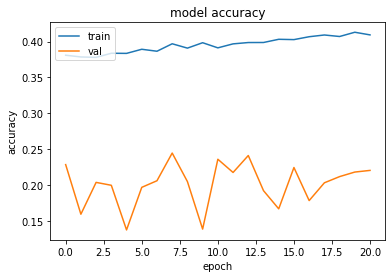

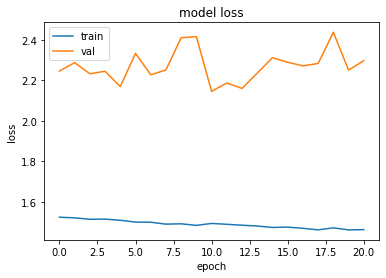

In [ ]:
history1_ks = new_model1_ks.fit(X_ks_sm, y_ks_df_sm, validation_data = (X_val1_ks_sm,y_val1_ks_sm),
               epochs=50,batch_size=64, callbacks =[cp1_ks, early_stopping_monitor], verbose = False)

# summarize history for accuracy
plt.plot(history1_ks.history['categorical_accuracy'])
plt.plot(history1_ks.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history1_ks.history['loss'])
plt.plot(history1_ks.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

##### 2.objective : False Negative (4 layers)

In [ ]:
def build_model2_ks(hp):
  model2_ks = Sequential()
  model2_ks.add(BatchNormalization())
  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
  hp_units4 = hp.Int('units4', min_value=32, max_value=512, step=32)
  model2_ks.add(Dense(units=hp_units1, activation= LeakyReLU))
  model2_ks.add(Dropout(hp.Choice('dropout_1', values=[0.0, 0.1, 0.2, 0.3])))
  model2_ks.add(BatchNormalization())
  model2_ks.add(Dense(units=hp_units2, activation= LeakyReLU))
  model2_ks.add(Dropout(hp.Choice('dropout_2', values=[0.0, 0.1, 0.2, 0.3])))
  model2_ks.add(BatchNormalization())
  model2_ks.add(Dense(units=hp_units3, activation= LeakyReLU))
  model2_ks.add(Dropout(hp.Choice('dropout_3', values=[0.0, 0.1, 0.2, 0.3])))
  model2_ks.add(BatchNormalization())
  model2_ks.add(Dense(units=hp_units4, activation= LeakyReLU))
  model2_ks.add(Dropout(hp.Choice('dropout_4', values=[0.0, 0.1, 0.2, 0.3])))
  model2_ks.add(BatchNormalization())
  model2_ks.add(Dense(6, activation='softmax'))

  hp_optimizer_ks=hp.Choice('Optimizer', values=['Adam', 'SGD'])
  if hp_optimizer_ks == 'Adam':
    hp_learning_rate = hp.Choice('learning_rate_ks', values=[1e-1, 1e-2, 1e-3])
  elif hp_optimizer_ks == 'SGD':
    hp_learning_rate = hp.Choice('learning_rate_ks', values=[1e-1, 1e-2, 1e-3])
    nesterov=True
    momentum=0.9

  model2_ks.compile(
      optimizer= hp_optimizer_ks,
      loss='categorical_crossentropy',
      metrics=[keras.metrics.FalseNegatives(name='false_negatives'),
               'categorical_accuracy']
  )
  return model2_ks

# HyperBand algorithm from keras tuner
tuner2_ks = kt.Hyperband(
    build_model2_ks,
    objective= kt.Objective('val_false_negatives', direction="min"),
    max_epochs=50,
    directory='clark_dir_2',
    project_name='clark_2',
    overwrite= True
)
early_stopping_monitor = EarlyStopping(patience=5)
tuner2_ks.search(X_ks_sm, y_ks_df_sm, epochs=50, validation_data = (X_val1_ks_sm,y_val1_ks_sm),
             callbacks=[early_stopping_monitor])

Trial 90 Complete [00h 00m 29s]
val_false_negatives: 1662.0

Best val_false_negatives So Far: 1574.0
Total elapsed time: 00h 48m 20s


In [ ]:
best_mlp_hyperparameters2_ks = tuner2_ks.get_best_hyperparameters(1)[0]
print("Best Hyper-parameters")
best_mlp_hyperparameters2_ks.values

Best Hyper-parameters


{'units1': 128,
 'units2': 192,
 'units3': 96,
 'units4': 288,
 'dropout_1': 0.0,
 'dropout_2': 0.0,
 'dropout_3': 0.1,
 'dropout_4': 0.0,
 'Optimizer': 'SGD',
 'learning_rate_ks': 0.001,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 3,
 'tuner/round': 0}

In [ ]:
best_model2_ks = tuner2_ks.get_best_models()[0]
best_model2_ks.build(X_ks_sm.shape)
best_model2_ks.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (15660, 18)              72        
 ormalization)                                                   
                                                                 
 dense (Dense)               (15660, 128)              2432      
                                                                 
 dropout (Dropout)           (15660, 128)              0         
                                                                 
 batch_normalization_1 (Batc  (15660, 128)             512       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (15660, 192)              24768     
                                                                 
 dropout_1 (Dropout)         (15660, 192)              0

In [ ]:
new_model2_ks = Sequential()
new_model2_ks.add(tf.keras.Input(shape=(18,)))
new_model2_ks.add(BatchNormalization())
new_model2_ks.add(Dense(128, activation = LeakyReLU))
new_model2_ks.add(BatchNormalization())
new_model2_ks.add(Dense(192, activation = LeakyReLU))
new_model2_ks.add(BatchNormalization())
new_model2_ks.add(Dense(96, activation = LeakyReLU))
new_model2_ks.add(Dropout(0.1))
new_model2_ks.add(BatchNormalization())
new_model2_ks.add(Dense(288, activation = LeakyReLU))
new_model2_ks.add(BatchNormalization())
new_model2_ks.add((Dense(6, activation='softmax')))
new_model2_ks.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_3 (Batc  (None, 18)               72        
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 128)               2432      
                                                                 
 batch_normalization_4 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 192)               24768     
                                                                 
 batch_normalization_5 (Batc  (None, 192)              768       
 hNormalization)                                                 
                                                      

In [ ]:
cp2_ks = ModelCheckpoint('new_model2_ks/', save_best_only=True)
opt2_ks = keras.optimizers.SGD(learning_rate=0.001)
new_model2_ks.compile(optimizer = opt2_ks, loss ='categorical_crossentropy', metrics =['categorical_accuracy'])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)

new_model2_ks.fit(X_ks_sm, y_ks_df_sm, validation_data = (X_val1_ks_sm,y_val1_ks_sm),
               epochs=50,batch_size=64, callbacks =[cp2_ks,early_stopping_monitor])

Epoch 1/50
245/245 [==============================] - ETA: 0s - loss: 2.0194 - categorical_accuracy: 0.2000

245/245 [==============================] - 21s 70ms/step - loss: 2.0194 - categorical_accuracy: 0.2000 - val_loss: 3.6667 - val_categorical_accuracy: 0.1667
Epoch 2/50
241/245 [============================>.] - ETA: 0s - loss: 1.8380 - categorical_accuracy: 0.2406

245/245 [==============================] - 4s 17ms/step - loss: 1.8366 - categorical_accuracy: 0.2405 - val_loss: 1.8143 - val_categorical_accuracy: 0.2722
Epoch 3/50
245/245 [==============================] - 2s 7ms/step - loss: 1.7897 - categorical_accuracy: 0.2590 - val_loss: 1.8436 - val_categorical_accuracy: 0.2411
Epoch 4/50
245/245 [==============================] - 2s 7ms/step - loss: 1.7445 - categorical_accuracy: 0.2782 - val_loss: 1.8518 - val_categorical_accuracy: 0.2359
Epoch 5/50
245/245 [==============================] - 2s 7ms/step - loss: 1.7244 - categorical_accuracy: 0.2844 - val_loss: 1.8622 - val_categorical_accuracy: 0.2307
Epoch 6/50
245/245 [==============================] - 2s 6ms/step - loss: 1.7037 - categorical_accuracy: 0.2929 - val_loss: 1.8544 - val_categorical_accuracy: 0.2347
Epoch 7/50
245/245 [==============================] - 2s 7ms/step - loss: 1.6853 - categorical_accuracy: 0.3034 - val_loss: 1.8632 - val_categorical_accuracy: 0.2301


In [ ]:
test_predictions2_ks = new_model2_ks.predict(X_test1_ks)
test_predictions2_ks

23/23 [==============================] - 0s 4ms/step


array([[0.21300676, 0.09082913, 0.05073838, 0.5589541 , 0.0598859 ,
        0.02658559],
       [0.219959  , 0.2652952 , 0.06696259, 0.17652018, 0.04286154,
        0.2284015 ],
       [0.1928585 , 0.2598666 , 0.0693351 , 0.11216094, 0.14653325,
        0.21924557],
       ...,
       [0.22596195, 0.25995037, 0.17984726, 0.10147015, 0.15694478,
        0.07582542],
       [0.1427661 , 0.12312409, 0.09211271, 0.3740089 , 0.18967065,
        0.07831752],
       [0.09081646, 0.25331205, 0.0859556 , 0.19862303, 0.11446218,
        0.25683072]], dtype=float32)

In [ ]:
classes2_ks = np.argmax(test_predictions2_ks, axis=-1)
classes2_ks

array([3, 1, 1, 2, 0, 0, 2, 3, 3, 1, 1, 0, 0, 0, 0, 1, 0, 0, 2, 4, 0, 0,
       5, 3, 1, 3, 5, 4, 5, 3, 1, 0, 1, 1, 1, 5, 1, 1, 3, 1, 1, 1, 3, 0,
       3, 5, 1, 2, 3, 1, 1, 1, 0, 1, 5, 2, 1, 3, 1, 1, 4, 3, 1, 3, 3, 1,
       0, 3, 1, 4, 3, 4, 4, 3, 1, 0, 0, 0, 2, 3, 2, 2, 2, 0, 0, 0, 0, 0,
       2, 4, 2, 2, 0, 0, 0, 0, 5, 5, 4, 3, 2, 0, 2, 3, 3, 2, 1, 2, 2, 1,
       3, 2, 2, 0, 2, 1, 4, 4, 5, 5, 0, 0, 0, 1, 3, 0, 0, 4, 0, 0, 3, 0,
       0, 0, 0, 0, 0, 1, 2, 1, 4, 1, 4, 0, 0, 1, 0, 1, 2, 4, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 4, 0, 2, 2, 3, 3, 4, 4, 2, 4, 0, 5, 0, 0, 0, 0, 5, 5, 0,
       0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0,
       4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 2, 2, 5, 0, 4, 2, 5, 0,
       0, 2, 5, 1, 4, 1, 1, 5, 5, 5, 3, 5, 1, 1, 2,

In [ ]:
classes2_ks =pd.DataFrame(classes2_ks, columns=['Test Predictions']) 
classes2_ks

Test Predictions
0                   3
1                   1
2                   1
3                   2
4                   0
..                ...
726                 1
727                 0
728                 1
729                 3
730                 5

[731 rows x 1 columns]

In [ ]:
classes2_ks = classes2_ks.values.ravel()

In [ ]:
result2_ks = pd.DataFrame({'Test Predictions':classes2_ks, 'Actuals':y_test1_ks})
result2_ks[0:31]

Test Predictions  Actuals
0                  3        0
1                  1        0
2                  1        0
3                  2        0
4                  0        0
5                  0        0
6                  2        0
7                  3        0
8                  3        0
9                  1        0
10                 1        0
11                 0        0
12                 0        0
13                 0        0
14                 0        0
15                 1        0
16                 0        0
17                 0        0
18                 2        0
19                 4        0
20                 0        0
21                 0        0
22                 5        0
23                 3        0
24                 1        0
25                 3        0
26                 5        0
27                 4        0
28                 5        0
29                 3        0
30                 1        0

######model 2 evaluation

In [ ]:
print(classification_report(y_test1_ks, classes2_ks, labels=np.unique(y_test1_ks)))

              precision    recall  f1-score   support

           0       0.59      0.39      0.47       428
           1       0.18      0.10      0.13       221
           2       0.07      0.07      0.07        82

   micro avg       0.40      0.27      0.32       731
   macro avg       0.28      0.19      0.22       731
weighted avg       0.41      0.27      0.32       731



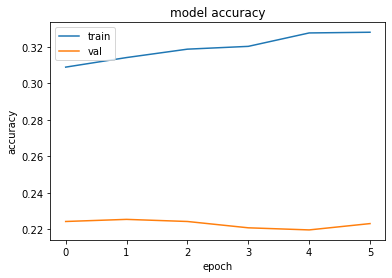

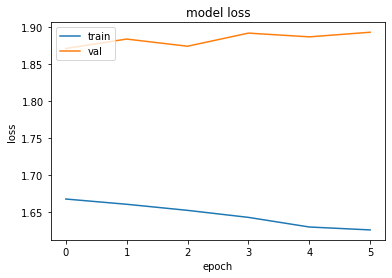

In [ ]:
history2_ks = new_model2_ks.fit(X_ks_sm, y_ks_df_sm, validation_data = (X_val1_ks_sm,y_val1_ks_sm),
               epochs=50,batch_size=64, callbacks =[cp2_ks,early_stopping_monitor], verbose = False)

# summarize history for accuracy
plt.plot(history2_ks.history['categorical_accuracy'])
plt.plot(history2_ks.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2_ks.history['loss'])
plt.plot(history2_ks.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

##### 3.objective : True Positive (5 layers)

In [ ]:
def build_model1_1ks(hp):
  model1_1ks = Sequential()
  model1_1ks.add(BatchNormalization())
  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
  hp_units4 = hp.Int('units4', min_value=32, max_value=512, step=32)
  hp_units5 = hp.Int('units5', min_value=32, max_value=512, step=32)
  model1_1ks.add(Dense(units=hp_units1, activation= LeakyReLU))
  model1_1ks.add(Dropout(hp.Choice('dropout_1', values=[0.0, 0.1, 0.2, 0.3])))
  model1_1ks.add(BatchNormalization())
  model1_1ks.add(Dense(units=hp_units2, activation= LeakyReLU))
  model1_1ks.add(Dropout(hp.Choice('dropout_2', values=[0.0, 0.1, 0.2, 0.3])))
  model1_1ks.add(BatchNormalization())
  model1_1ks.add(Dense(units=hp_units3, activation= LeakyReLU))
  model1_1ks.add(Dropout(hp.Choice('dropout_3', values=[0.0, 0.1, 0.2, 0.3])))
  model1_1ks.add(BatchNormalization())
  model1_1ks.add(Dense(units=hp_units4, activation= LeakyReLU))
  model1_1ks.add(Dropout(hp.Choice('dropout_4', values=[0.0, 0.1, 0.2, 0.3])))
  model1_1ks.add(BatchNormalization())
  model1_1ks.add(Dense(units=hp_units5, activation= LeakyReLU))
  model1_1ks.add(Dropout(hp.Choice('dropout_5', values=[0.0, 0.1, 0.2, 0.3])))
  model1_1ks.add(BatchNormalization())
  model1_1ks.add(Dense(6, activation='softmax'))

  hp_optimizer_ks=hp.Choice('Optimizer', values=['Adam', 'SGD'])
  if hp_optimizer_ks == 'Adam':
    hp_learning_rate = hp.Choice('learning_rate_ks', values=[1e-1, 1e-2, 1e-3])
  elif hp_optimizer_ks == 'SGD':
    hp_learning_rate = hp.Choice('learning_rate_ks', values=[1e-1, 1e-2, 1e-3])
    nesterov=True
    momentum=0.9

  model1_1ks.compile(
      optimizer= hp_optimizer_ks,
      loss='categorical_crossentropy',
      metrics=[keras.metrics.TruePositives(name='true_positives'),
               'categorical_accuracy']
  )
  return model1_1ks

# HyperBand algorithm from keras tuner
tuner1_1ks = kt.Hyperband(
    build_model1_1ks,
    objective= kt.Objective('val_true_positives', direction="max"),
    max_epochs = 50,
    directory='clark_dir_1',
    project_name='clark1_1',
    overwrite= True
)
early_stopping_monitor = EarlyStopping(patience=5)
tuner1_1ks.search(X_ks_sm, y_ks_df_sm, epochs=50, validation_data = (X_val1_ks_sm,y_val1_ks_sm),
             callbacks=[early_stopping_monitor])

Trial 90 Complete [00h 01m 25s]
val_true_positives: 149.0

Best val_true_positives So Far: 180.0
Total elapsed time: 00h 56m 50s


In [ ]:
best_mlp_hyperparameters1_1ks = tuner1_1ks.get_best_hyperparameters(1)[0]
print("Best Hyper-parameters")
best_mlp_hyperparameters1_1ks.values

Best Hyper-parameters


{'units1': 384,
 'units2': 288,
 'units3': 352,
 'units4': 352,
 'units5': 448,
 'dropout_1': 0.2,
 'dropout_2': 0.1,
 'dropout_3': 0.3,
 'dropout_4': 0.1,
 'dropout_5': 0.1,
 'Optimizer': 'Adam',
 'learning_rate_ny': 0.1,
 'tuner/epochs': 12,
 'tuner/initial_epoch': 4,
 'tuner/bracket': 3,
 'tuner/round': 1,
 'tuner/trial_id': '0155'}

In [ ]:
best_model1_1ks = tuner1_1ks.get_best_models()[0]
best_model1_1ks.build(X_ks_sm.shape)
best_model1_1ks.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (14733, 18)              72        
 ormalization)                                                   
                                                                 
 dense (Dense)               (14733, 384)              7296      
                                                                 
 dropout (Dropout)           (14733, 384)              0         
                                                                 
 batch_normalization_1 (Batc  (14733, 384)             1536      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (14733, 288)              110880    
                                                                 
 dropout_1 (Dropout)         (14733, 288)              0

In [ ]:
new_model1_1ks = Sequential()
new_model1_1ks.add(tf.keras.Input(shape=(18,)))
new_model1_1ks.add(BatchNormalization())
new_model1_1ks.add(Dense(384, activation = LeakyReLU))
new_model1_1ks.add(Dropout(0.2))
new_model1_1ks.add(BatchNormalization())
new_model1_1ks.add(Dense(288, activation = LeakyReLU))
new_model1_1ks.add(Dropout(0.1))
new_model1_1ks.add(BatchNormalization())
new_model1_1ks.add(Dense(352, activation = LeakyReLU))
new_model1_1ks.add(Dropout(0.3))
new_model1_1ks.add(BatchNormalization())
new_model1_1ks.add(Dense(352, activation = LeakyReLU))
new_model1_1ks.add(Dropout(0.1))
new_model1_1ks.add(BatchNormalization())
new_model1_1ks.add(Dense(448, activation = LeakyReLU))
new_model1_1ks.add(Dropout(0.1))
new_model1_1ks.add(BatchNormalization())
new_model1_1ks.add((Dense(6, activation='softmax')))
new_model1_1ks.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_8 (Batc  (None, 18)               72        
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 384)               7296      
                                                                 
 dropout_3 (Dropout)         (None, 384)               0         
                                                                 
 batch_normalization_9 (Batc  (None, 384)              1536      
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 288)               110880    
                                                                 
 dropout_4 (Dropout)         (None, 288)              

In [ ]:
cp1_1ks = ModelCheckpoint('new_model1_1ks/', save_best_only=True)
opt1_1ks = keras.optimizers.Adam(learning_rate=0.1)
new_model1_1ks.compile(optimizer = opt1_1ks, loss ='categorical_crossentropy', metrics =['categorical_accuracy'])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=10)

new_model1_1ks.fit(X_ks_sm, y_ks_df_sm, validation_data = (X_val1_ks_sm,y_val1_ks_sm),
               epochs=100,batch_size=64, callbacks =[cp1_1ks,early_stopping_monitor])

Epoch 1/100
244/245 [============================>.] - ETA: 0s - loss: 2.2981 - categorical_accuracy: 0.1902

245/245 [==============================] - 20s 68ms/step - loss: 2.2964 - categorical_accuracy: 0.1904 - val_loss: 1.9181 - val_categorical_accuracy: 0.1690
Epoch 2/100
245/245 [==============================] - 8s 34ms/step - loss: 1.8089 - categorical_accuracy: 0.2176 - val_loss: 2.1839 - val_categorical_accuracy: 0.1967
Epoch 3/100
245/245 [==============================] - 8s 33ms/step - loss: 1.8580 - categorical_accuracy: 0.2216 - val_loss: 2.9218 - val_categorical_accuracy: 0.1257
Epoch 4/100
245/245 [==============================] - 8s 32ms/step - loss: 2.0099 - categorical_accuracy: 0.2097 - val_loss: 3.0356 - val_categorical_accuracy: 0.1874
Epoch 5/100
245/245 [==============================] - 9s 35ms/step - loss: 3.0481 - categorical_accuracy: 0.1939 - val_loss: 3.4867 - val_categorical_accuracy: 0.1880
Epoch 6/100
245/245 [==============================] - 8s 32ms/step - loss: 2.5300 - categorical_accuracy: 0.1927 - val_loss: 2.6187 - val_categorical_accuracy: 0.1690
Epo

In [ ]:
test_predictions1_1ks = new_model1_1ks.predict(X_test1_ks)
test_predictions1_1ks

23/23 [==============================] - 0s 6ms/step


array([[0.6594059 , 0.251961  , 0.01798758, 0.05171864, 0.01350346,
        0.00542345],
       [0.65341985, 0.24744348, 0.01816255, 0.04763252, 0.02011014,
        0.01323148],
       [0.60736233, 0.26360697, 0.01834122, 0.05445918, 0.03323491,
        0.02299528],
       ...,
       [0.6614471 , 0.24369992, 0.01760814, 0.0457768 , 0.01897613,
        0.0124919 ],
       [0.6731912 , 0.2339796 , 0.01836338, 0.04644131, 0.01677834,
        0.01124621],
       [0.6506295 , 0.24702138, 0.01798017, 0.04833978, 0.02165066,
        0.01437851]], dtype=float32)

In [ ]:
classes1_1ks = np.argmax(test_predictions1_1ks, axis=-1)
classes1_1ks

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
classes1_1ks =pd.DataFrame(classes1_1ks, columns=['Test Predictions']) 
classes1_1ks

Test Predictions
0                   0
1                   0
2                   0
3                   0
4                   0
..                ...
726                 0
727                 0
728                 0
729                 0
730                 0

[731 rows x 1 columns]

In [ ]:
classes1_1ks = classes1_1ks.values.ravel()

In [ ]:
result1_1ks = pd.DataFrame({'Test Predictions':classes1_1ks, 'Actuals':y_test1_ks})
result1_1ks[0:31]

Test Predictions  Actuals
0                  0        0
1                  0        0
2                  0        0
3                  0        0
4                  0        0
5                  0        0
6                  0        0
7                  0        0
8                  0        0
9                  0        0
10                 0        0
11                 0        0
12                 0        0
13                 0        0
14                 0        0
15                 0        0
16                 0        0
17                 0        0
18                 0        0
19                 0        0
20                 0        0
21                 0        0
22                 0        0
23                 0        0
24                 0        0
25                 0        0
26                 0        0
27                 0        0
28                 0        0
29                 0        0
30                 0        0

######model 3 evaluation

In [ ]:
print(classification_report(y_test1_ks, classes1_1ks, labels=np.unique(y_test1_ks)))

              precision    recall  f1-score   support

           0       0.59      1.00      0.74       428
           1       0.40      0.01      0.02       221
           2       0.00      0.00      0.00        82

   micro avg       0.59      0.59      0.59       731
   macro avg       0.33      0.34      0.25       731
weighted avg       0.47      0.59      0.44       731



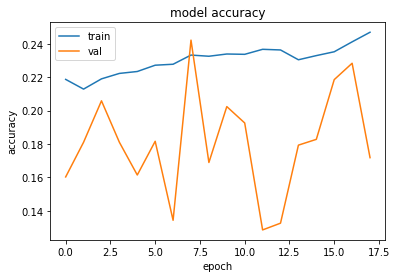

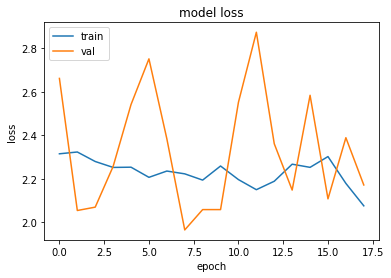

In [ ]:
history1_1ks = new_model1_1ks.fit(X_ks_sm, y_ks_df_sm, validation_data = (X_val1_ks_sm,y_val1_ks_sm),
               epochs=100,batch_size=64, callbacks =[cp1_1ks,early_stopping_monitor], verbose = False)

# summarize history for accuracy
plt.plot(history1_1ks.history['categorical_accuracy'])
plt.plot(history1_1ks.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history1_1ks.history['loss'])
plt.plot(history1_1ks.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

##### 4.objective : False Negative (5 layers)

In [ ]:
def build_model2_1ks(hp):
  model2_1ks = Sequential()
  model2_1ks.add(BatchNormalization())
  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
  hp_units4 = hp.Int('units4', min_value=32, max_value=512, step=32)
  hp_units5 = hp.Int('units5', min_value=32, max_value=512, step=32)
  model2_1ks.add(Dense(units=hp_units1, activation= LeakyReLU))
  model2_1ks.add(Dropout(hp.Choice('dropout_1', values=[0.0, 0.1, 0.2, 0.3])))
  model2_1ks.add(BatchNormalization())
  model2_1ks.add(Dense(units=hp_units2, activation= LeakyReLU))
  model2_1ks.add(Dropout(hp.Choice('dropout_2', values=[0.0, 0.1, 0.2, 0.3])))
  model2_1ks.add(BatchNormalization())
  model2_1ks.add(Dense(units=hp_units3, activation= LeakyReLU))
  model2_1ks.add(Dropout(hp.Choice('dropout_3', values=[0.0, 0.1, 0.2, 0.3])))
  model2_1ks.add(BatchNormalization())
  model2_1ks.add(Dense(units=hp_units4, activation= LeakyReLU))
  model2_1ks.add(Dropout(hp.Choice('dropout_4', values=[0.0, 0.1, 0.2, 0.3])))
  model2_1ks.add(BatchNormalization())
  model2_1ks.add(Dense(units=hp_units5, activation= LeakyReLU))
  model2_1ks.add(Dropout(hp.Choice('dropout_5', values=[0.0, 0.1, 0.2, 0.3])))
  model2_1ks.add(BatchNormalization())
  model2_1ks.add(Dense(6, activation='softmax'))

  hp_optimizer_ks=hp.Choice('Optimizer', values=['Adam', 'SGD'])
  if hp_optimizer_ks == 'Adam':
    hp_learning_rate = hp.Choice('learning_rate_ks', values=[1e-1, 1e-2, 1e-3])
  elif hp_optimizer_ks == 'SGD':
    hp_learning_rate = hp.Choice('learning_rate_ks', values=[1e-1, 1e-2, 1e-3])
    nesterov=True
    momentum=0.9

  model2_1ks.compile(
      optimizer= hp_optimizer_ks,
      loss='categorical_crossentropy',
      metrics=[keras.metrics.FalseNegatives(name='false_negatives'),
               'categorical_accuracy']
  )
  return model2_1ks

# HyperBand algorithm from keras tuner
tuner2_1ks = kt.Hyperband(
    build_model2_1ks,
    objective= kt.Objective('val_false_negatives', direction="min"),
    max_epochs = 50,
    directory='clark_dir_2',
    project_name='clark2_1',
    overwrite= True
)
early_stopping_monitor = EarlyStopping(patience=10)
tuner2_1ks.search(X_ks_sm, y_ks_df_sm, epochs=50, validation_data = (X_val1_ks_sm,y_val1_ks_sm),
             callbacks=[early_stopping_monitor])

Trial 90 Complete [00h 01m 50s]
val_false_negatives: 1725.0

Best val_false_negatives So Far: 1535.0
Total elapsed time: 01h 13m 34s


In [ ]:
best_mlp_hyperparameters2_1ks = tuner2_1ks.get_best_hyperparameters(1)[0]
print("Best Hyper-parameters")
best_mlp_hyperparameters2_1ks.values

Best Hyper-parameters


{'units1': 480,
 'units2': 480,
 'units3': 320,
 'units4': 288,
 'units5': 384,
 'dropout_1': 0.1,
 'dropout_2': 0.0,
 'dropout_3': 0.0,
 'dropout_4': 0.0,
 'dropout_5': 0.0,
 'Optimizer': 'Adam',
 'learning_rate_ks': 0.01,
 'tuner/epochs': 17,
 'tuner/initial_epoch': 6,
 'tuner/bracket': 2,
 'tuner/round': 1,
 'tuner/trial_id': '0055'}

In [ ]:
best_model2_1ks = tuner2_1ks.get_best_models()[0]
best_model2_1ks.build(X_ks_sm.shape)
best_model2_1ks.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (15660, 18)              72        
 ormalization)                                                   
                                                                 
 dense (Dense)               (15660, 480)              9120      
                                                                 
 dropout (Dropout)           (15660, 480)              0         
                                                                 
 batch_normalization_1 (Batc  (15660, 480)             1920      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (15660, 480)              230880    
                                                                 
 dropout_1 (Dropout)         (15660, 480)              0

In [ ]:
new_model2_1ks = Sequential()
new_model2_1ks.add(tf.keras.Input(shape=(18,)))
new_model2_1ks.add(BatchNormalization())
new_model2_1ks.add(Dense(480, activation = LeakyReLU))
new_model2_1ks.add(Dropout(0.1))
new_model2_1ks.add(BatchNormalization())
new_model2_1ks.add(Dense(480, activation = LeakyReLU))
new_model2_1ks.add(BatchNormalization())
new_model2_1ks.add(Dense(320, activation = LeakyReLU))
new_model2_1ks.add(BatchNormalization())
new_model2_1ks.add(Dense(288, activation = LeakyReLU))
new_model2_1ks.add(BatchNormalization())
new_model2_1ks.add(Dense(384, activation = LeakyReLU))
new_model2_1ks.add(BatchNormalization())
new_model2_1ks.add((Dense(6, activation='softmax')))
new_model2_1ks.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_14 (Bat  (None, 18)               72        
 chNormalization)                                                
                                                                 
 dense_14 (Dense)            (None, 480)               9120      
                                                                 
 dropout_8 (Dropout)         (None, 480)               0         
                                                                 
 batch_normalization_15 (Bat  (None, 480)              1920      
 chNormalization)                                                
                                                                 
 dense_15 (Dense)            (None, 480)               230880    
                                                                 
 batch_normalization_16 (Bat  (None, 480)             

In [ ]:
cp2_1ks = ModelCheckpoint('new_model2_1ks/', save_best_only=True)
opt2_1ks = keras.optimizers.Adam(learning_rate=0.01)
new_model2_1ks.compile(optimizer = opt2_1ks, loss ='categorical_crossentropy', metrics =['categorical_accuracy'])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=10)

new_model2_1ks.fit(X_ks_sm, y_ks_df_sm, validation_data = (X_val1_ks_sm,y_val1_ks_sm),
               epochs=100,batch_size=64, callbacks =[cp2_1ks,early_stopping_monitor])

Epoch 1/100
245/245 [==============================] - ETA: 0s - loss: 1.9862 - categorical_accuracy: 0.2173

245/245 [==============================] - 10s 34ms/step - loss: 1.9862 - categorical_accuracy: 0.2173 - val_loss: 2.0262 - val_categorical_accuracy: 0.1915
Epoch 2/100
244/245 [============================>.] - ETA: 0s - loss: 1.7311 - categorical_accuracy: 0.2617

245/245 [==============================] - 8s 34ms/step - loss: 1.7315 - categorical_accuracy: 0.2616 - val_loss: 1.9242 - val_categorical_accuracy: 0.2532
Epoch 3/100
245/245 [==============================] - 5s 20ms/step - loss: 1.6767 - categorical_accuracy: 0.2893 - val_loss: 1.9296 - val_categorical_accuracy: 0.2001
Epoch 4/100
245/245 [==============================] - 5s 20ms/step - loss: 1.6305 - categorical_accuracy: 0.3165 - val_loss: 2.0364 - val_categorical_accuracy: 0.1892
Epoch 5/100
245/245 [==============================] - 5s 18ms/step - loss: 1.6023 - categorical_accuracy: 0.3286 - val_loss: 2.3035 - val_categorical_accuracy: 0.2168
Epoch 6/100
245/245 [==============================] - 5s 19ms/step - loss: 1.5888 - categorical_accuracy: 0.3364 - val_loss: 2.3881 - val_categorical_accuracy: 0.1580
Epoch 7/100
245/245 [==============================] - 5s 20ms/step - loss: 1.5787 - categorical_accuracy: 0.3403 - val_loss: 2.0442 - val_categorical_accuracy: 0.2197
Epoc

In [ ]:
test_predictions2_1ks = new_model2_1ks.predict(X_test1_ks)
test_predictions2_1ks

23/23 [==============================] - 0s 5ms/step


array([[0.21223003, 0.29954702, 0.04138345, 0.430135  , 0.01105902,
        0.00564539],
       [0.17575401, 0.4272296 , 0.09723108, 0.16063216, 0.0024026 ,
        0.13675061],
       [0.13054904, 0.25166228, 0.14451726, 0.12925392, 0.02371424,
        0.32030326],
       ...,
       [0.14618117, 0.11592234, 0.04818496, 0.13750468, 0.5029218 ,
        0.04928507],
       [0.3650026 , 0.16105053, 0.03733294, 0.36740848, 0.03377067,
        0.03543472],
       [0.28520587, 0.30357507, 0.08337307, 0.18836941, 0.01515274,
        0.12432381]], dtype=float32)

In [ ]:
classes2_1ks = np.argmax(test_predictions2_1ks, axis=-1)
classes2_1ks

array([3, 1, 5, 0, 0, 0, 0, 4, 4, 5, 1, 4, 0, 0, 0, 0, 0, 0, 3, 5, 0, 4,
       5, 3, 5, 3, 1, 4, 5, 5, 0, 0, 0, 0, 5, 0, 1, 3, 1, 4, 0, 0, 1, 1,
       1, 1, 1, 5, 1, 1, 5, 1, 0, 4, 5, 4, 1, 1, 1, 1, 1, 1, 1, 1, 4, 0,
       0, 4, 5, 0, 4, 4, 4, 5, 1, 1, 5, 3, 5, 1, 5, 5, 5, 0, 0, 2, 0, 5,
       4, 1, 5, 1, 2, 3, 5, 0, 5, 5, 1, 0, 5, 1, 5, 1, 1, 2, 4, 5, 5, 1,
       3, 2, 5, 0, 5, 3, 3, 4, 3, 5, 1, 1, 0, 1, 2, 1, 0, 0, 5, 0, 0, 2,
       0, 0, 0, 2, 0, 1, 3, 3, 1, 0, 3, 0, 1, 4, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 5, 0, 0, 0, 0, 0, 4, 2, 2, 0, 0, 5, 0, 0, 0, 0, 0, 0, 5, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 0, 0, 0, 0, 5, 5, 0, 0, 0, 0, 2,
       2, 4, 4, 4, 2, 2, 2, 2, 5, 2, 2, 2, 4, 4, 5, 0, 5, 0, 5, 5, 5, 5,
       5, 5, 4, 4, 0, 5, 0, 0, 0, 0, 0, 2, 5, 5, 4, 5, 0, 0, 5, 0, 0, 0,
       5, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 4, 2, 2, 2, 2, 2, 4, 2, 2, 4, 4,
       4, 2, 5, 0, 0, 1, 1, 4, 4, 0, 0, 5, 2, 2, 0, 1, 5, 3, 4, 2, 5, 5,
       0, 5, 5, 1, 3, 5, 5, 5, 5, 5, 0, 5, 1, 4, 5,

In [ ]:
classes2_1ks =pd.DataFrame(classes2_1ks, columns=['Test Predictions']) 
classes2_1ks

Test Predictions
0                   3
1                   1
2                   5
3                   0
4                   0
..                ...
726                 0
727                 0
728                 4
729                 3
730                 1

[731 rows x 1 columns]

In [ ]:
classes2_1ks = classes2_1ks.values.ravel()

In [ ]:
result2_1ks = pd.DataFrame({'Test Predictions':classes2_1ks, 'Actuals':y_test1_ks})
result2_1ks[0:31]

Test Predictions  Actuals
0                  3        0
1                  1        0
2                  5        0
3                  0        0
4                  0        0
5                  0        0
6                  0        0
7                  4        0
8                  4        0
9                  5        0
10                 1        0
11                 4        0
12                 0        0
13                 0        0
14                 0        0
15                 0        0
16                 0        0
17                 0        0
18                 3        0
19                 5        0
20                 0        0
21                 4        0
22                 5        0
23                 3        0
24                 5        0
25                 3        0
26                 1        0
27                 4        0
28                 5        0
29                 5        0
30                 0        0

######model 4 evaluation

In [ ]:
print(classification_report(y_test1_ks, classes2_1ks, labels=np.unique(y_test1_ks)))

              precision    recall  f1-score   support

           0       0.66      0.31      0.42       428
           1       0.23      0.10      0.13       221
           2       0.05      0.04      0.04        82

   micro avg       0.44      0.21      0.29       731
   macro avg       0.31      0.15      0.20       731
weighted avg       0.46      0.21      0.29       731



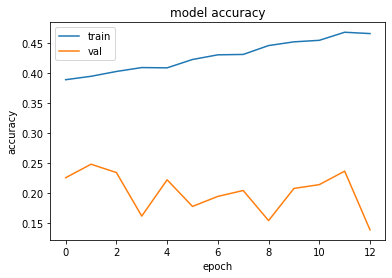

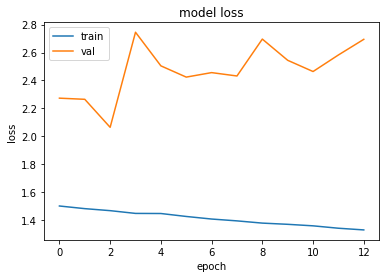

In [ ]:
history2_1ks = new_model2_1ks.fit(X_ks_sm, y_ks_df_sm, validation_data = (X_val1_ks_sm,y_val1_ks_sm),
               epochs=100,batch_size=64, callbacks =[cp2_1ks,early_stopping_monitor], verbose = False)

# summarize history for accuracy
plt.plot(history2_1ks.history['categorical_accuracy'])
plt.plot(history2_1ks.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2_1ks.history['loss'])
plt.plot(history2_1ks.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

###MLP model (with weather and soil data)

####preprocessing data

In [ ]:
score_ks = train_ks['score']
score_val_ks = val_ks['score']
score_test_ks = test_ks['score']

In [ ]:
score_arr_ks = score_ks.copy()
score_val_arr_ks = score_val_ks.copy()
score_test_arr_ks = score_test_ks.copy()

In [ ]:
score_arr_ks = score_arr_ks.to_numpy()
score_val_arr_ks = score_val_arr_ks.to_numpy()
score_test_arr_ks = score_test_arr_ks.to_numpy()

In [ ]:
score_arr_ks =pd.DataFrame(score_arr_ks, columns=['Score']) 
score_arr_ks

Score
0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
...     ...
6205    3.0
6206    3.0
6207    3.0
6208    3.0
6209    3.0

[6210 rows x 1 columns]

In [ ]:
score_val_arr_ks =pd.DataFrame(score_val_arr_ks, columns=['Score']) 
score_val_arr_ks

Score
0      3.0
1      3.0
2      3.0
3      3.0
4      3.0
..     ...
725    0.0
726    0.0
727    0.0
728    0.0
729    0.0

[730 rows x 1 columns]

In [ ]:
#score_arr_ks = to_categorical(score_arr_ks,num_classes=6)
#score_val_arr_ks = to_categorical(score_val_arr_ks,num_classes=6)
score_test_arr_ks = to_categorical(score_test_arr_ks,num_classes=6)

In [ ]:
clark_train = train_ks.copy()
clark_val = val_ks.copy()
clark_test = test_ks.copy()

In [ ]:
X1_ks = clark_train.drop(columns=['fips','date','score','tahun','bulan','tanggal'])
X_val_ks = clark_val.drop(columns=['fips','date','score','tahun','bulan','tanggal'])
X_test_ks = clark_test.drop(columns=['fips','date','score','tahun','bulan','tanggal'])

In [ ]:
X1_ks, y1_ks = X1_ks, score_arr_ks
X_val_ks, y_val_ks = X_val_ks, score_val_arr_ks
X_test_ks, y_test_ks = X_test_ks, score_test_arr_ks
X1_ks.shape, y1_ks.shape, X_val_ks.shape, y_val_ks.shape, X_test_ks.shape, y_test_ks.shape

((6210, 49), (6210, 1), (730, 49), (730, 1), (731, 49), (731, 6))

In [ ]:
#rasio 1 : 1
sm_ks1 = SMOTE(sampling_strategy={0:2610,1:2610,2:2610,3:2610,4:2610,5:2610},random_state=42,k_neighbors=3)
sm_ks2 = SMOTE(sampling_strategy={0:289,1:289,2:289,3:289,4:289,5:289},random_state=42,k_neighbors=3)
X1_ks_sm, y1_ks_df_sm = sm_ks1.fit_resample(X1_ks, score_arr_ks.values.ravel())
X_val_ks_sm, y_val_ks_sm = sm_ks2.fit_resample(X_val_ks,y_val_ks.values.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X1_ks_sm.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y1_ks_df_sm.shape))

print('After OverSampling, the shape of train_X: {}'.format(X_val_ks_sm.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_val_ks_sm.shape))

After OverSampling, the shape of train_X: (15660, 49)
After OverSampling, the shape of train_y: (15660,) 

After OverSampling, the shape of train_X: (1734, 49)
After OverSampling, the shape of train_y: (1734,) 



In [ ]:
X1_ks_sm, y1_ks_df_sm = X1_ks_sm, to_categorical(y1_ks_df_sm,
                                                               num_classes=6)
X_val_ks_sm, y_val_ks_sm = X_val_ks_sm, to_categorical(y_val_ks_sm,
                                                                     num_classes=6)

####building the model

##### 1.objective : True Positive

In [ ]:
def build_model_ks1(hp):
  model_ks1 = Sequential()
  model_ks1.add(BatchNormalization())
  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
  kernel_reg1 = hp.Choice('kernel_reg1', values=[0.1, 0.01, 0.001, 0.0001, 0.00001])
  kernel_reg2 = hp.Choice('kernel_reg2', values=[0.1, 0.01, 0.001, 0.0001, 0.00001])
  kernel_reg3 = hp.Choice('kernel_reg3', values=[0.1, 0.01, 0.001, 0.0001, 0.00001])
  model_ks1.add(Dense(units=hp_units1, activation= LeakyReLU, kernel_regularizer=regularizers.L2(l2 = kernel_reg1)))
  model_ks1.add(Dropout(hp.Choice('dropout_1', values=[0.0, 0.1, 0.2, 0.3])))
  model_ks1.add(BatchNormalization())
  model_ks1.add(Dense(units=hp_units2, activation= LeakyReLU, kernel_regularizer=regularizers.L2(l2 = kernel_reg2)))
  model_ks1.add(Dropout(hp.Choice('dropout_2', values=[0.0, 0.1, 0.2, 0.3])))
  model_ks1.add(BatchNormalization())
  model_ks1.add(Dense(units=hp_units3, activation= LeakyReLU, kernel_regularizer=regularizers.L2(l2 = kernel_reg3)))
  model_ks1.add(Dropout(hp.Choice('dropout_3', values=[0.0, 0.1, 0.2, 0.3])))
  model_ks1.add(BatchNormalization())
  model_ks1.add(Dense(6, activation='softmax'))

  hp_optimizer_ks=hp.Choice('Optimizer', values=['Adam', 'SGD'])
  if hp_optimizer_ks == 'Adam':
    hp_learning_rate = hp.Choice('learning_rate_ks', values=[1e-1, 1e-2, 1e-3])
  elif hp_optimizer_ks == 'SGD':
    hp_learning_rate = hp.Choice('learning_rate_ks', values=[1e-1, 1e-2, 1e-3])
    nesterov=True
    momentum=0.9

  model_ks1.compile(
      optimizer= hp_optimizer_ks,
      loss='categorical_crossentropy',
      metrics=[keras.metrics.TruePositives(name='true_positives'),
               'categorical_accuracy']
  )
  return model_ks1

# HyperBand algorithm from keras tuner
tuner_ks1 = kt.Hyperband(
    build_model_ks1,
    objective= kt.Objective('val_true_positives', direction="max"),
    max_epochs=50,
    directory='ks_dir',
    project_name='clark1',
    overwrite= True
)
early_stopping_monitor = EarlyStopping(patience=5)
tuner_ks1.search(X1_ks_sm, y1_ks_df_sm, epochs=50, validation_data = (X_val_ks_sm,y_val_ks_sm),
             callbacks=[early_stopping_monitor])

Trial 90 Complete [00h 01m 29s]
val_true_positives: 378.0

Best val_true_positives So Far: 378.0
Total elapsed time: 00h 42m 16s


In [ ]:
best_mlp_hyperparameters_ks1 = tuner_ks1.get_best_hyperparameters(1)[0]
print("Best Hyper-parameters")
best_mlp_hyperparameters_ks1.values

Best Hyper-parameters


{'units1': 416,
 'units2': 512,
 'units3': 320,
 'kernel_reg1': 1e-05,
 'kernel_reg2': 0.01,
 'kernel_reg3': 0.001,
 'dropout_1': 0.1,
 'dropout_2': 0.0,
 'dropout_3': 0.2,
 'Optimizer': 'Adam',
 'learning_rate_ks': 0.01,
 'tuner/epochs': 50,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [ ]:
best_model_ks1 = tuner_ks1.get_best_models()[0]
best_model_ks1.build(X1_ks_sm.shape)
best_model_ks1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (15660, 49)              196       
 ormalization)                                                   
                                                                 
 dense (Dense)               (15660, 416)              20800     
                                                                 
 dropout (Dropout)           (15660, 416)              0         
                                                                 
 batch_normalization_1 (Batc  (15660, 416)             1664      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (15660, 512)              213504    
                                                                 
 dropout_1 (Dropout)         (15660, 512)              0

In [ ]:
new_model_ks1 = Sequential()
new_model_ks1.add(tf.keras.Input(shape=(49,)))
new_model_ks1.add(BatchNormalization())
new_model_ks1.add(Dense(416, activation = LeakyReLU, kernel_regularizer=regularizers.L2(l2 = 1e-5)))
new_model_ks1.add(Dropout(0.1))
new_model_ks1.add(BatchNormalization())
new_model_ks1.add(Dense(512, activation = LeakyReLU, kernel_regularizer=regularizers.L2(l2 = 0.01)))
new_model_ks1.add(BatchNormalization())
new_model_ks1.add(Dense(320, activation = LeakyReLU, kernel_regularizer=regularizers.L2(l2 = 0.001)))
new_model_ks1.add(Dropout(0.2))
new_model_ks1.add(BatchNormalization())
new_model_ks1.add((Dense(6, activation='softmax')))
new_model_ks1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_20 (Bat  (None, 49)               196       
 chNormalization)                                                
                                                                 
 dense_20 (Dense)            (None, 416)               20800     
                                                                 
 dropout_9 (Dropout)         (None, 416)               0         
                                                                 
 batch_normalization_21 (Bat  (None, 416)              1664      
 chNormalization)                                                
                                                                 
 dense_21 (Dense)            (None, 512)               213504    
                                                                 
 batch_normalization_22 (Bat  (None, 512)             

In [ ]:
cp_ks1 = ModelCheckpoint('new_model_ks1/', save_best_only=True)
opt_ks1 = keras.optimizers.Adam(learning_rate=0.01)
new_model_ks1.compile(optimizer = opt_ks1, loss ='categorical_crossentropy', metrics =['categorical_accuracy'])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)

new_model_ks1.fit(X1_ks_sm, y1_ks_df_sm, validation_data = (X_val_ks_sm,y_val_ks_sm),
               epochs=50,batch_size=64, callbacks =[cp_ks1,early_stopping_monitor])

Epoch 1/50
243/245 [============================>.] - ETA: 0s - loss: 2.7850 - categorical_accuracy: 0.2219

245/245 [==============================] - 9s 29ms/step - loss: 2.7811 - categorical_accuracy: 0.2216 - val_loss: 3.5548 - val_categorical_accuracy: 0.1667
Epoch 2/50
242/245 [============================>.] - ETA: 0s - loss: 2.0830 - categorical_accuracy: 0.2400

245/245 [==============================] - 7s 27ms/step - loss: 2.0824 - categorical_accuracy: 0.2393 - val_loss: 2.1607 - val_categorical_accuracy: 0.1667
Epoch 3/50
244/245 [============================>.] - ETA: 0s - loss: 1.9577 - categorical_accuracy: 0.2517

245/245 [==============================] - 6s 26ms/step - loss: 1.9574 - categorical_accuracy: 0.2519 - val_loss: 1.9145 - val_categorical_accuracy: 0.2411
Epoch 4/50
245/245 [==============================] - 4s 16ms/step - loss: 1.9020 - categorical_accuracy: 0.2633 - val_loss: 1.9429 - val_categorical_accuracy: 0.1926
Epoch 5/50
245/245 [==============================] - 4s 16ms/step - loss: 1.8744 - categorical_accuracy: 0.2661 - val_loss: 1.9434 - val_categorical_accuracy: 0.2612
Epoch 6/50
244/245 [============================>.] - ETA: 0s - loss: 1.8646 - categorical_accuracy: 0.2629

245/245 [==============================] - 7s 27ms/step - loss: 1.8642 - categorical_accuracy: 0.2631 - val_loss: 1.9140 - val_categorical_accuracy: 0.2065
Epoch 7/50
245/245 [==============================] - 4s 16ms/step - loss: 1.8418 - categorical_accuracy: 0.2680 - val_loss: 2.0323 - val_categorical_accuracy: 0.1522
Epoch 8/50
244/245 [============================>.] - ETA: 0s - loss: 1.8122 - categorical_accuracy: 0.2722

245/245 [==============================] - 7s 27ms/step - loss: 1.8122 - categorical_accuracy: 0.2721 - val_loss: 1.8527 - val_categorical_accuracy: 0.2238
Epoch 9/50
245/245 [==============================] - 4s 16ms/step - loss: 1.7949 - categorical_accuracy: 0.2804 - val_loss: 2.0369 - val_categorical_accuracy: 0.1499
Epoch 10/50
245/245 [==============================] - 4s 16ms/step - loss: 1.7783 - categorical_accuracy: 0.2811 - val_loss: 1.9781 - val_categorical_accuracy: 0.2313
Epoch 11/50
245/245 [==============================] - 4s 16ms/step - loss: 1.7617 - categorical_accuracy: 0.2838 - val_loss: 1.9202 - val_categorical_accuracy: 0.2105
Epoch 12/50
245/245 [==============================] - 4s 18ms/step - loss: 1.7506 - categorical_accuracy: 0.2842 - val_loss: 1.8895 - val_categorical_accuracy: 0.2457
Epoch 13/50
245/245 [==============================] - 4s 16ms/step - loss: 1.7294 - categorical_accuracy: 0.2979 - val_loss: 1.9535 - val_categorical_accuracy: 0.1770


In [ ]:
test_predictions_ks1 = new_model_ks1.predict(X_test_ks)
test_predictions_ks1

23/23 [==============================] - 0s 4ms/step


array([[0.1447673 , 0.26978835, 0.16565223, 0.23451117, 0.10837121,
        0.07690977],
       [0.14922254, 0.24320126, 0.15131807, 0.1705703 , 0.12694892,
        0.15873884],
       [0.19011408, 0.23446551, 0.1332522 , 0.1549981 , 0.09671059,
        0.1904595 ],
       ...,
       [0.22203752, 0.25272614, 0.14019588, 0.14546895, 0.11677808,
        0.12279348],
       [0.204113  , 0.2572073 , 0.14594369, 0.16602623, 0.09232864,
        0.1343811 ],
       [0.1870743 , 0.24244255, 0.13618605, 0.15507358, 0.10043074,
        0.17879279]], dtype=float32)

In [ ]:
classes_ks1 = np.argmax(test_predictions_ks1, axis=-1)
classes_ks1

array([1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       5, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 3, 3, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 0,
       0, 4, 5, 1, 0, 4, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 3, 5, 1, 0, 0, 0, 0, 1, 5, 0, 4, 3, 3, 5, 3, 4, 0, 4, 5, 1, 3,
       0, 1, 1, 1, 1, 1, 3, 4, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 5, 0,
       0, 1, 1, 1, 0, 5, 1, 5, 5, 5, 1, 1, 1, 1, 1,

In [ ]:
classes_ks1 =pd.DataFrame(classes_ks1, columns=['Test Predictions']) 
classes_ks1

Test Predictions
0                   1
1                   1
2                   1
3                   0
4                   0
..                ...
726                 1
727                 1
728                 1
729                 1
730                 1

[731 rows x 1 columns]

In [ ]:
y_test_ks= np.argmax(y_test_ks, axis=-1)
y_test_ks

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
y_test_ks =pd.DataFrame(y_test_ks, columns=['Actuals']) 
y_test_ks

Actuals
0          0
1          0
2          0
3          0
4          0
..       ...
726        0
727        0
728        0
729        0
730        0

[731 rows x 1 columns]

In [ ]:
classes_ks1 = classes_ks1.values.ravel()
y_test_ks = y_test_ks.values.ravel()

In [ ]:
result_ks1 = pd.DataFrame({'Test Predictions':classes_ks1, 'Actuals':y_test_ks})
result_ks1[0:31]

Test Predictions  Actuals
0                  1        0
1                  1        0
2                  1        0
3                  0        0
4                  0        0
5                  0        0
6                  1        0
7                  1        0
8                  1        0
9                  0        0
10                 1        0
11                 1        0
12                 1        0
13                 0        0
14                 0        0
15                 0        0
16                 0        0
17                 1        0
18                 1        0
19                 1        0
20                 0        0
21                 1        0
22                 5        0
23                 1        0
24                 1        0
25                 1        0
26                 1        0
27                 1        0
28                 1        0
29                 1        0
30                 1        0

######model 1 evaluation

In [ ]:
print(classification_report(y_test_ks, classes_ks1, labels=np.unique(y_test_ks)))

              precision    recall  f1-score   support

           0       0.56      0.47      0.51       428
           1       0.21      0.24      0.22       221
           2       0.00      0.00      0.00        82

   micro avg       0.42      0.35      0.38       731
   macro avg       0.26      0.24      0.25       731
weighted avg       0.39      0.35      0.37       731



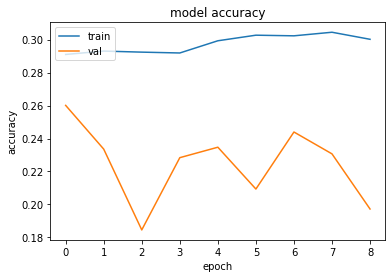

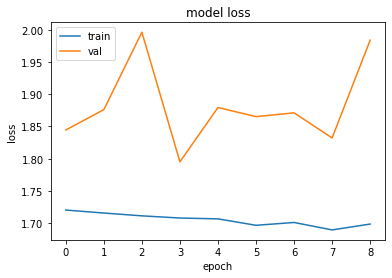

In [ ]:
history1_ks = new_model_ks1.fit(X1_ks_sm, y1_ks_df_sm, validation_data = (X_val_ks_sm,y_val_ks_sm),
               epochs=50,batch_size=64, callbacks =[cp_ks1,early_stopping_monitor], verbose = False)

# summarize history for accuracy
plt.plot(history1_ks.history['categorical_accuracy'])
plt.plot(history1_ks.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history1_ks.history['loss'])
plt.plot(history1_ks.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

##### 2.objective : False Negative

In [ ]:
def build_model_ks2(hp):
  model_ks2 = Sequential()
  model_ks2.add(BatchNormalization())
  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
  kernel_reg1 = hp.Choice('kernel_reg1', values=[0.1, 0.01, 0.001, 0.0001, 0.00001])
  kernel_reg2 = hp.Choice('kernel_reg2', values=[0.1, 0.01, 0.001, 0.0001, 0.00001])
  kernel_reg3 = hp.Choice('kernel_reg3', values=[0.1, 0.01, 0.001, 0.0001, 0.00001])
  model_ks2.add(Dense(units=hp_units1, activation= LeakyReLU, kernel_regularizer=regularizers.L2(l2 = kernel_reg1)))
  model_ks2.add(Dropout(hp.Choice('dropout_1', values=[0.0, 0.1, 0.2, 0.3])))
  model_ks2.add(BatchNormalization())
  model_ks2.add(Dense(units=hp_units2, activation= LeakyReLU, kernel_regularizer=regularizers.L2(l2 = kernel_reg2)))
  model_ks2.add(Dropout(hp.Choice('dropout_2', values=[0.0, 0.1, 0.2, 0.3])))
  model_ks2.add(BatchNormalization())
  model_ks2.add(Dense(units=hp_units3, activation= LeakyReLU, kernel_regularizer=regularizers.L2(l2 = kernel_reg3)))
  model_ks2.add(Dropout(hp.Choice('dropout_3', values=[0.0, 0.1, 0.2, 0.3])))
  model_ks2.add(BatchNormalization())
  model_ks2.add(Dense(6, activation='softmax'))

  hp_optimizer_ks=hp.Choice('Optimizer', values=['Adam', 'SGD'])
  if hp_optimizer_ks == 'Adam':
    hp_learning_rate = hp.Choice('learning_rate_ks', values=[1e-1, 1e-2, 1e-3])
  elif hp_optimizer_ks == 'SGD':
    hp_learning_rate = hp.Choice('learning_rate_ks', values=[1e-1, 1e-2, 1e-3])
    nesterov=True
    momentum=0.9

  model_ks2.compile(
      optimizer= hp_optimizer_ks,
      loss='categorical_crossentropy',
      metrics=[keras.metrics.FalseNegatives(name='false_negatives'),
               'categorical_accuracy']
  )
  return model_ks2

# HyperBand algorithm from keras tuner
tuner_ks2 = kt.Hyperband(
    build_model_ks2,
    objective= kt.Objective('val_false_negatives', direction="min"),
    max_epochs=50,
    directory='ks_dir2',
    project_name='clark2',
    overwrite= True
)
early_stopping_monitor = EarlyStopping(patience=5)
tuner_ks2.search(X1_ks_sm, y1_ks_df_sm, epochs=50, validation_data = (X_val_ks_sm,y_val_ks_sm),
             callbacks=[early_stopping_monitor])

Trial 90 Complete [00h 01m 03s]
val_false_negatives: 1445.0

Best val_false_negatives So Far: 1371.0
Total elapsed time: 00h 47m 30s


In [ ]:
best_mlp_hyperparameters_ks2 = tuner_ks2.get_best_hyperparameters(1)[0]
print("Best Hyper-parameters")
best_mlp_hyperparameters_ks2.values

Best Hyper-parameters


{'units1': 96,
 'units2': 320,
 'units3': 416,
 'kernel_reg1': 0.1,
 'kernel_reg2': 0.001,
 'kernel_reg3': 0.1,
 'dropout_1': 0.0,
 'dropout_2': 0.1,
 'dropout_3': 0.0,
 'Optimizer': 'SGD',
 'learning_rate_ks': 0.01,
 'tuner/epochs': 6,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 2,
 'tuner/round': 0}

In [ ]:
best_model_ks2 = tuner_ks2.get_best_models()[0]
best_model_ks2.build(X1_ks_sm.shape)
best_model_ks2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (15660, 49)              196       
 ormalization)                                                   
                                                                 
 dense (Dense)               (15660, 96)               4800      
                                                                 
 dropout (Dropout)           (15660, 96)               0         
                                                                 
 batch_normalization_1 (Batc  (15660, 96)              384       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (15660, 320)              31040     
                                                                 
 dropout_1 (Dropout)         (15660, 320)              0

In [ ]:
new_model_ks2 = Sequential()
new_model_ks2.add(tf.keras.Input(shape=(49,)))
new_model_ks2.add(BatchNormalization())
new_model_ks2.add(Dense(96, activation = LeakyReLU, kernel_regularizer=regularizers.L2(l2 = 0.1)))
new_model_ks2.add(BatchNormalization())
new_model_ks2.add(Dense(320, activation = LeakyReLU, kernel_regularizer=regularizers.L2(l2 = 0.001)))
new_model_ks2.add(Dropout(0.1))
new_model_ks2.add(BatchNormalization())
new_model_ks2.add(Dense(416, activation = LeakyReLU, kernel_regularizer=regularizers.L2(l2 = 0.1)))
new_model_ks2.add(BatchNormalization())
new_model_ks2.add((Dense(6, activation='softmax')))
new_model_ks2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_24 (Bat  (None, 49)               196       
 chNormalization)                                                
                                                                 
 dense_24 (Dense)            (None, 96)                4800      
                                                                 
 batch_normalization_25 (Bat  (None, 96)               384       
 chNormalization)                                                
                                                                 
 dense_25 (Dense)            (None, 320)               31040     
                                                                 
 dropout_11 (Dropout)        (None, 320)               0         
                                                                 
 batch_normalization_26 (Bat  (None, 320)             

In [ ]:
cp_ks2 = ModelCheckpoint('new_model_ks2/', save_best_only=True)
opt_ks2 = keras.optimizers.SGD(learning_rate=0.01)
new_model_ks2.compile(optimizer = opt_ks2, loss ='categorical_crossentropy', metrics =['categorical_accuracy'])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)

new_model_ks2.fit(X1_ks_sm, y1_ks_df_sm, validation_data = (X_val_ks_sm,y_val_ks_sm),
               epochs=50,batch_size=64, callbacks =[cp_ks2,early_stopping_monitor])

Epoch 1/50
242/245 [============================>.] - ETA: 0s - loss: 29.3930 - categorical_accuracy: 0.2613

245/245 [==============================] - 11s 34ms/step - loss: 29.2686 - categorical_accuracy: 0.2617 - val_loss: 41.8632 - val_categorical_accuracy: 0.1667
Epoch 2/50
242/245 [============================>.] - ETA: 0s - loss: 12.1819 - categorical_accuracy: 0.2989

245/245 [==============================] - 7s 29ms/step - loss: 12.1360 - categorical_accuracy: 0.2985 - val_loss: 21.5039 - val_categorical_accuracy: 0.1667
Epoch 3/50
245/245 [==============================] - ETA: 0s - loss: 5.7740 - categorical_accuracy: 0.3045

245/245 [==============================] - 7s 30ms/step - loss: 5.7740 - categorical_accuracy: 0.3045 - val_loss: 5.3515 - val_categorical_accuracy: 0.1626
Epoch 4/50
244/245 [============================>.] - ETA: 0s - loss: 3.4051 - categorical_accuracy: 0.3072

245/245 [==============================] - 6s 23ms/step - loss: 3.4037 - categorical_accuracy: 0.3072 - val_loss: 3.3097 - val_categorical_accuracy: 0.1505
Epoch 5/50
244/245 [============================>.] - ETA: 0s - loss: 2.5099 - categorical_accuracy: 0.3049

245/245 [==============================] - 5s 21ms/step - loss: 2.5096 - categorical_accuracy: 0.3046 - val_loss: 2.5868 - val_categorical_accuracy: 0.1915
Epoch 6/50
245/245 [==============================] - ETA: 0s - loss: 2.1669 - categorical_accuracy: 0.3103

245/245 [==============================] - 5s 19ms/step - loss: 2.1669 - categorical_accuracy: 0.3103 - val_loss: 2.5202 - val_categorical_accuracy: 0.1522
Epoch 7/50
243/245 [============================>.] - ETA: 0s - loss: 2.0219 - categorical_accuracy: 0.3080

245/245 [==============================] - 5s 19ms/step - loss: 2.0213 - categorical_accuracy: 0.3084 - val_loss: 2.3717 - val_categorical_accuracy: 0.2353
Epoch 8/50
241/245 [============================>.] - ETA: 0s - loss: 1.9569 - categorical_accuracy: 0.3138

245/245 [==============================] - 5s 19ms/step - loss: 1.9568 - categorical_accuracy: 0.3135 - val_loss: 2.3536 - val_categorical_accuracy: 0.1845
Epoch 9/50
245/245 [==============================] - ETA: 0s - loss: 1.9268 - categorical_accuracy: 0.3126

245/245 [==============================] - 5s 19ms/step - loss: 1.9268 - categorical_accuracy: 0.3126 - val_loss: 2.2269 - val_categorical_accuracy: 0.2589
Epoch 10/50
240/245 [============================>.] - ETA: 0s - loss: 1.9064 - categorical_accuracy: 0.3208

245/245 [==============================] - 5s 22ms/step - loss: 1.9056 - categorical_accuracy: 0.3207 - val_loss: 2.1390 - val_categorical_accuracy: 0.2405
Epoch 11/50
245/245 [==============================] - 3s 10ms/step - loss: 1.8947 - categorical_accuracy: 0.3253 - val_loss: 2.3412 - val_categorical_accuracy: 0.2209
Epoch 12/50
245/245 [==============================] - 3s 10ms/step - loss: 1.8872 - categorical_accuracy: 0.3169 - val_loss: 2.1805 - val_categorical_accuracy: 0.2174
Epoch 13/50
245/245 [==============================] - 2s 10ms/step - loss: 1.8730 - categorical_accuracy: 0.3179 - val_loss: 2.1412 - val_categorical_accuracy: 0.2607
Epoch 14/50
245/245 [==============================] - 3s 10ms/step - loss: 1.8615 - categorical_accuracy: 0.3275 - val_loss: 2.2638 - val_categorical_accuracy: 0.1995
Epoch 15/50
245/245 [==============================] - 2s 10ms/step - loss: 1.8498 - categorical_accuracy: 0.3244 - val_loss: 2.4248 - val_categorical_accuracy: 0.1603


In [ ]:
test_predictions_ks2 = new_model_ks2.predict(X_test_ks)
test_predictions_ks2

23/23 [==============================] - 0s 3ms/step


array([[0.24666105, 0.18285055, 0.07016515, 0.4566905 , 0.00326039,
        0.04037233],
       [0.08462158, 0.40206265, 0.15679537, 0.09504557, 0.03120144,
        0.23027337],
       [0.08274006, 0.23879236, 0.21523371, 0.07900668, 0.03896407,
        0.34526312],
       ...,
       [0.34286016, 0.14863023, 0.0597786 , 0.12872158, 0.25280964,
        0.06719982],
       [0.2280446 , 0.18594523, 0.12044327, 0.18254948, 0.05644533,
        0.22657211],
       [0.12112819, 0.18907292, 0.15680827, 0.10018423, 0.06150561,
        0.3713007 ]], dtype=float32)

In [ ]:
classes_ks2 = np.argmax(test_predictions_ks2, axis=-1)
classes_ks2

array([3, 1, 5, 2, 0, 0, 0, 1, 1, 5, 5, 0, 1, 1, 1, 0, 0, 0, 0, 5, 0, 0,
       5, 0, 5, 5, 5, 0, 5, 5, 1, 0, 0, 0, 0, 5, 5, 3, 3, 5, 5, 0, 3, 0,
       3, 5, 1, 5, 5, 5, 5, 0, 1, 0, 5, 3, 5, 3, 1, 5, 5, 3, 5, 5, 3, 1,
       0, 4, 5, 1, 0, 4, 4, 5, 1, 1, 5, 2, 5, 1, 4, 2, 2, 0, 0, 1, 0, 2,
       3, 1, 5, 2, 2, 0, 2, 0, 5, 5, 3, 0, 3, 1, 5, 3, 3, 0, 4, 3, 5, 1,
       3, 2, 4, 3, 0, 3, 4, 4, 3, 1, 4, 2, 0, 4, 4, 0, 0, 0, 0, 1, 0, 2,
       0, 0, 0, 4, 4, 0, 3, 1, 0, 0, 4, 0, 0, 4, 0, 0, 2, 4, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0,
       4, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4,
       0, 4, 4, 4, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 0, 4, 4, 4, 0, 4, 4,
       0, 0, 4, 4, 0, 0, 4, 0, 0, 0, 4, 0, 4, 0, 4, 0, 0, 4, 4, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 4, 0, 4, 4, 4, 4, 0, 4, 2, 4, 4, 0, 4, 4, 4,
       4, 0, 4, 0, 4, 0, 0, 4, 4, 0, 0, 2, 2, 2, 0, 0, 3, 1, 4, 3, 5, 5,
       0, 0, 5, 3, 4, 0, 2, 5, 5, 5, 0, 5, 3, 0, 5,

In [ ]:
classes_ks2 =pd.DataFrame(classes_ks2, columns=['Test Predictions']) 
classes_ks2

Test Predictions
0                   3
1                   1
2                   5
3                   2
4                   0
..                ...
726                 0
727                 5
728                 0
729                 0
730                 5

[731 rows x 1 columns]

In [ ]:
classes_ks2 = classes_ks2.values.ravel()

In [ ]:
result_ks2 = pd.DataFrame({'Test Predictions':classes_ks2, 'Actuals':y_test_ks})
result_ks2[0:31]

Test Predictions  Actuals
0                  3        0
1                  1        0
2                  5        0
3                  2        0
4                  0        0
5                  0        0
6                  0        0
7                  1        0
8                  1        0
9                  5        0
10                 5        0
11                 0        0
12                 1        0
13                 1        0
14                 1        0
15                 0        0
16                 0        0
17                 0        0
18                 0        0
19                 5        0
20                 0        0
21                 0        0
22                 5        0
23                 0        0
24                 5        0
25                 5        0
26                 5        0
27                 0        0
28                 5        0
29                 5        0
30                 1        0

######model 2 evaluation

In [ ]:
print(classification_report(y_test_ks, classes_ks2, labels=np.unique(y_test_ks)))

              precision    recall  f1-score   support

           0       0.60      0.34      0.44       428
           1       0.16      0.03      0.05       221
           2       0.08      0.06      0.07        82

   micro avg       0.45      0.22      0.29       731
   macro avg       0.28      0.15      0.19       731
weighted avg       0.41      0.22      0.28       731



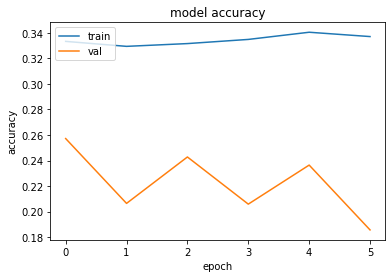

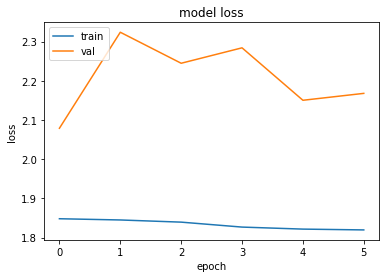

In [ ]:
history2_ks = new_model_ks2.fit(X1_ks_sm, y1_ks_df_sm, validation_data = (X_val_ks_sm,y_val_ks_sm),
               epochs=50,batch_size=64, callbacks =[cp_ks2,early_stopping_monitor], verbose = False)

# summarize history for accuracy
plt.plot(history2_ks.history['categorical_accuracy'])
plt.plot(history2_ks.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2_ks.history['loss'])
plt.plot(history2_ks.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

####comparing the models

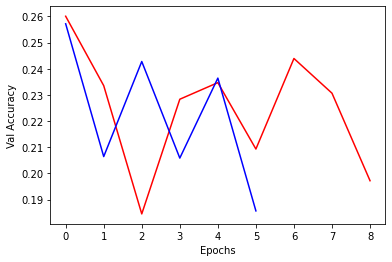

In [ ]:
plt.plot(history1_ks.history['val_categorical_accuracy'], 'r', history2_ks.history['val_categorical_accuracy'], 'b')
plt.xlabel('Epochs')
plt.ylabel('Val Accuracy')
plt.show()

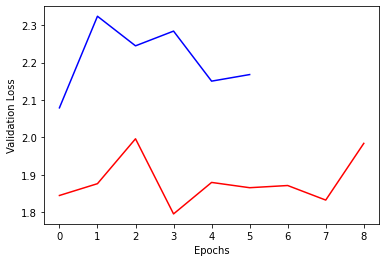

In [ ]:
plt.plot(history1_ks.history['val_loss'], 'r', history2_ks.history['val_loss'], 'b')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.show()

###MLP model with weather and soil data (without date variable) REGRESSION

####preprocessing data

In [ ]:
score_ks = train_ks['score']
score_val_ks = val_ks['score']
score_test_ks = test_ks['score']

In [ ]:
score_arr_ks = score_ks.copy()
score_val_arr_ks = score_val_ks.copy()
score_test_arr_ks = score_test_ks.copy()

In [ ]:
score_arr_ks = score_arr_ks.to_numpy()
score_val_arr_ks = score_val_arr_ks.to_numpy()
score_test_arr_ks = score_test_arr_ks.to_numpy()

In [ ]:
score_arr_ks =pd.DataFrame(score_arr_ks, columns=['Score']) 
score_arr_ks

Score
0     1.000000
1     1.000000
2     1.000000
3     1.000000
4     0.857143
...        ...
6205  2.804400
6206  2.804400
6207  2.804400
6208  2.804400
6209  2.804400

[6210 rows x 1 columns]

In [ ]:
score_val_arr_ks =pd.DataFrame(score_val_arr_ks, columns=['Score']) 
score_val_arr_ks

Score
0    2.8044
1    2.8044
2    2.8044
3    2.8044
4    2.8044
..      ...
725  0.0000
726  0.0000
727  0.0000
728  0.0000
729  0.0000

[730 rows x 1 columns]

In [ ]:
score_test_arr_ks =pd.DataFrame(score_test_arr_ks, columns=['Score']) 
score_test_arr_ks

Score
0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
..     ...
726    0.0
727    0.0
728    0.0
729    0.0
730    0.0

[731 rows x 1 columns]

In [ ]:
clark_train = train_ks.copy()
clark_val = val_ks.copy()
clark_test = test_ks.copy()

In [ ]:
X1_ks = clark_train.drop(columns=['fips','date','score'])
X_ks_val = clark_val.drop(columns=['fips','date','score'])
X_ks_test = clark_test.drop(columns=['fips','date','score'])

In [ ]:
X1_ks, y1_ks = X1_ks, score_arr_ks
X_val_ks, y_val_ks = X_ks_val, score_val_arr_ks
X_test_ks, y_test_ks = X_ks_test, score_test_arr_ks
X1_ks.shape, y1_ks.shape, X_val_ks.shape, y_val_ks.shape, X_test_ks.shape, y_test_ks.shape

((6210, 49), (6210, 1), (730, 49), (730, 1), (731, 49), (731, 1))

####build the model

In [ ]:
new_model_reg_ks1 = Sequential()
new_model_reg_ks1.add(tf.keras.Input(shape=(49,)))
new_model_reg_ks1.add(BatchNormalization())
new_model_reg_ks1.add(Dense(128, activation = "elu", kernel_initializer="he_normal"))
new_model_reg_ks1.add(BatchNormalization())
new_model_reg_ks1.add(Dense(64, activation = "elu", kernel_initializer="he_normal"))
new_model_reg_ks1.add(BatchNormalization())
new_model_reg_ks1.add((Dense(1, activation='linear')))
new_model_reg_ks1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_28 (Bat  (None, 49)               196       
 chNormalization)                                                
                                                                 
 dense_28 (Dense)            (None, 128)               6400      
                                                                 
 batch_normalization_29 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dense_29 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_30 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                      

In [ ]:
opt_reg_ks1 = keras.optimizers.Adam(learning_rate=0.001)
new_model_reg_ks1.compile(optimizer = opt_reg_ks1, loss =MeanSquaredError(), metrics =[RootMeanSquaredError()])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)

new_model_reg_ks1.fit(X1_ks, y1_ks, validation_data = (X_val_ks,y_val_ks),
               epochs=50,batch_size=64, callbacks =[early_stopping_monitor])

Epoch 1/50
98/98 [==============================] - 2s 6ms/step - loss: 3.1091 - root_mean_squared_error: 1.7633 - val_loss: 32813.5312 - val_root_mean_squared_error: 181.1451
Epoch 2/50
98/98 [==============================] - 0s 4ms/step - loss: 2.1613 - root_mean_squared_error: 1.4701 - val_loss: 13684.8945 - val_root_mean_squared_error: 116.9825
Epoch 3/50
98/98 [==============================] - 0s 4ms/step - loss: 2.0801 - root_mean_squared_error: 1.4423 - val_loss: 5339.0146 - val_root_mean_squared_error: 73.0686
Epoch 4/50
98/98 [==============================] - 0s 4ms/step - loss: 2.0908 - root_mean_squared_error: 1.4459 - val_loss: 1948.6716 - val_root_mean_squared_error: 44.1438
Epoch 5/50
98/98 [==============================] - 0s 4ms/step - loss: 2.0519 - root_mean_squared_error: 1.4325 - val_loss: 531.7492 - val_root_mean_squared_error: 23.0597
Epoch 6/50
98/98 [==============================] - 0s 4ms/step - loss: 2.0504 - root_mean_squared_error: 1.4319 - val_loss: 17

In [ ]:
test_predictions_reg_ks1 = new_model_reg_ks1.predict(X_test_ks).flatten()
test_predictions_reg_ks1

23/23 [==============================] - 0s 2ms/step


array([ 1.53325510e+00,  1.11515236e+00,  1.31220090e+00,  8.72025609e-01,
        8.84493768e-01,  7.82426536e-01,  1.44511354e+00,  1.76075685e+00,
        1.58141768e+00,  1.07958639e+00,  1.13162839e+00,  1.05847967e+00,
        6.16048098e-01,  4.66536045e-01,  4.86558855e-01,  4.62383986e-01,
        8.20129097e-01,  7.46091425e-01,  1.21478808e+00,  9.59281564e-01,
        1.15294468e+00,  1.56475222e+00,  1.61551034e+00,  8.97343576e-01,
        1.25848782e+00,  1.39168978e+00,  1.49311721e+00,  1.34602869e+00,
        1.48750019e+00,  1.69413829e+00,  8.75619590e-01,  8.79228890e-01,
        8.00345480e-01,  5.82308412e-01,  1.41362512e+00,  1.06648839e+00,
        1.49606419e+00,  1.90987074e+00,  1.70214248e+00,  2.05957818e+00,
        9.02849913e-01,  6.27814353e-01,  1.69810426e+00,  1.78168917e+00,
        1.36205077e+00,  1.35835505e+00,  1.10667133e+00,  2.02470493e+00,
        1.48065400e+00,  1.02738559e+00,  1.24235260e+00,  1.58702493e+00,
        6.06644511e-01,  

In [ ]:
test_predictions_reg_ks1 =pd.DataFrame(test_predictions_reg_ks1, columns=['Test Predictions']) 
test_predictions_reg_ks1

Test Predictions
0            1.533255
1            1.115152
2            1.312201
3            0.872026
4            0.884494
..                ...
726          1.218038
727          0.981805
728          0.850919
729          1.382844
730          1.334504

[731 rows x 1 columns]

In [ ]:
test_predictions_reg_ks1 = test_predictions_reg_ks1.values.ravel()
y_test_ks = y_test_ks.values.ravel()

In [ ]:
test_results_reg_ks_1 = pd.DataFrame(data={'predictions':test_predictions_reg_ks1, 'actuals':y_test_ks})
test_results_reg_ks_1

predictions  actuals
0       1.533255      0.0
1       1.115152      0.0
2       1.312201      0.0
3       0.872026      0.0
4       0.884494      0.0
..           ...      ...
726     1.218038      0.0
727     0.981805      0.0
728     0.850919      0.0
729     1.382844      0.0
730     1.334504      0.0

[731 rows x 2 columns]

In [ ]:
test_results_reg_ks_1[500:550]

predictions   actuals
500     0.873016  0.986829
501     0.821722  0.982571
502     1.838471  0.978314
503     1.631071  0.974057
504     1.640328  0.969800
505     1.094768  0.969800
506     0.819403  0.969800
507     0.963025  0.969800
508     0.725801  0.969800
509     0.739177  0.969800
510     0.920433  0.969800
511     1.355301  0.969800
512     1.343505  0.969800
513     0.932331  0.969800
514     1.133111  0.969800
515     0.983147  0.969800
516     0.863134  0.969800
517     0.719903  0.969800
518     0.855673  0.969800
519     1.956332  1.113529
520     2.007073  1.257257
521     1.115574  1.400986
522     1.080343  1.544714
523     1.265387  1.688443
524     1.356475  1.832171
525     1.582541  1.975900
526     2.292040  1.979343
527     1.896872  1.982786
528     1.985118  1.986229
529     2.203367  1.989671
530     2.039517  1.993114
531     1.781616  1.996557
532     1.287789  2.000000
533     1.581517  2.000000
534     2.315823  2.000000
535     0.935177  2.000000
536     0.952036  2.000000
537     0.891925  2.000000
538     1.027658  2.000000
539     1.250907  2.000000
540     0.537546  2.000000
541     0.778096  2.000000
542     0.351744  2.000000
543     0.697061  2.000000
544     1.224221  2.000000
545     1.173188  2.000000
546     2.713938  2.000000
547     2.011871  2.057186
548     1.662885  2.114371
549     1.859721  2.171557

####model evaluation

In [ ]:
new_model_reg_ks1.evaluate(X1_ks,y1_ks)

195/195 [==============================] - 0s 2ms/step - loss: 1.9653 - root_mean_squared_error: 1.4019


[1.9652762413024902, 1.4018831253051758]

In [ ]:
new_model_reg_ks1.evaluate(X_test_ks,y_test_ks)

23/23 [==============================] - 0s 2ms/step - loss: 1.0777 - root_mean_squared_error: 1.0381


[1.077730655670166, 1.0381380319595337]

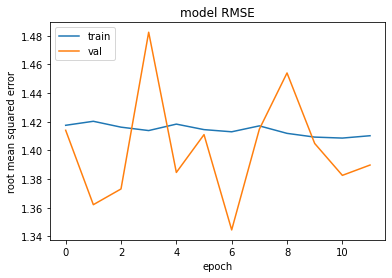

In [ ]:
history_reg_ks_1 = new_model_reg_ks1.fit(X1_ks, y1_ks, validation_data = (X_val_ks,y_val_ks),
               epochs=50,batch_size=64, callbacks =[early_stopping_monitor], verbose=False)

# summarize history for accuracy
plt.plot(history_reg_ks_1.history['root_mean_squared_error'])
plt.plot(history_reg_ks_1.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('root mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
test_results_reg_ks_1.predictions[test_results_reg_ks_1.predictions <0.5] = 0
test_results_reg_ks_1.predictions[(test_results_reg_ks_1.predictions >=0.5)&(test_results_reg_ks_1.predictions<1.5)] = 1
test_results_reg_ks_1.predictions[(test_results_reg_ks_1.predictions >=1.5)&(test_results_reg_ks_1.predictions<2.5)] = 2
test_results_reg_ks_1.predictions[(test_results_reg_ks_1.predictions >=2.5)&(test_results_reg_ks_1.predictions<3.5)] = 3
test_results_reg_ks_1.predictions[(test_results_reg_ks_1.predictions >=3.5)&(test_results_reg_ks_1.predictions<4.5)] = 4
test_results_reg_ks_1.predictions[(test_results_reg_ks_1.predictions >=4.5)&(test_results_reg_ks_1.predictions<5.5)] = 5
test_results_reg_ks_1.actuals[test_results_reg_ks_1.actuals <0.5] = 0
test_results_reg_ks_1.actuals[(test_results_reg_ks_1.actuals >=0.5)&(test_results_reg_ks_1.actuals<1.5)] = 1
test_results_reg_ks_1.actuals[(test_results_reg_ks_1.actuals >=1.5)&(test_results_reg_ks_1.actuals<2.5)] = 2
test_results_reg_ks_1.actuals[(test_results_reg_ks_1.actuals >=2.5)&(test_results_reg_ks_1.actuals<3.5)] = 3
test_results_reg_ks_1.actuals[(test_results_reg_ks_1.actuals >=3.5)&(test_results_reg_ks_1.actuals<4.5)] = 4
test_results_reg_ks_1.actuals[(test_results_reg_ks_1.actuals >=4.5)&(test_results_reg_ks_1.actuals<5.5)] = 5
test_results_reg_ks_1

predictions  actuals
0            2.0      0.0
1            1.0      0.0
2            1.0      0.0
3            1.0      0.0
4            1.0      0.0
..           ...      ...
726          1.0      0.0
727          1.0      0.0
728          1.0      0.0
729          1.0      0.0
730          1.0      0.0

[731 rows x 2 columns]

In [ ]:
test_results_reg_ks_1[200:250]

predictions  actuals
200          1.0      0.0
201          1.0      0.0
202          1.0      0.0
203          2.0      0.0
204          2.0      0.0
205          1.0      0.0
206          1.0      0.0
207          1.0      0.0
208          1.0      0.0
209          2.0      0.0
210          1.0      0.0
211          1.0      0.0
212          1.0      0.0
213          1.0      0.0
214          1.0      1.0
215          1.0      1.0
216          1.0      1.0
217          1.0      1.0
218          2.0      1.0
219          1.0      1.0
220          1.0      1.0
221          0.0      1.0
222          0.0      1.0
223          1.0      1.0
224          1.0      1.0
225          1.0      1.0
226          1.0      1.0
227          1.0      1.0
228          0.0      1.0
229          1.0      1.0
230          0.0      1.0
231          1.0      1.0
232          1.0      1.0
233          1.0      1.0
234          1.0      1.0
235          1.0      1.0
236          0.0      1.0
237          0.0      1.0
238          1.0      1.0
239          1.0      1.0
240          0.0      1.0
241          0.0      1.0
242          1.0      0.0
243          0.0      0.0
244          0.0      0.0
245          1.0      0.0
246          1.0      0.0
247          1.0      0.0
248          1.0      0.0
249          1.0      0.0

In [ ]:
print(classification_report(test_results_reg_ks_1['actuals'], test_results_reg_ks_1['predictions'], labels=np.unique(test_results_reg_ks_1['actuals'])))

              precision    recall  f1-score   support

         0.0       0.67      0.08      0.15       428
         1.0       0.29      0.63      0.40       221
         2.0       0.15      0.34      0.21        82

   micro avg       0.28      0.28      0.28       731
   macro avg       0.37      0.35      0.25       731
weighted avg       0.49      0.28      0.23       731



###LSTM model without weather and soil data, only using previous drought scores

In [ ]:
def df_to_X_y(df, window_size=7):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
WINDOW_SIZE = 7
X_train_ks, y_train_ks = df_to_X_y(score_ks, WINDOW_SIZE)
X_val1_ks, y_val1_ks = df_to_X_y(score_val_ks, WINDOW_SIZE)
X_test1_ks, y_test1_ks = df_to_X_y(score_test_ks, WINDOW_SIZE)
X_train_ks.shape, y_train_ks.shape, X_val1_ks.shape, y_val1_ks.shape, X_test1_ks.shape, y_test1_ks.shape

((6203, 7, 1), (6203,), (723, 7, 1), (723,), (724, 7, 1), (724,))

In [ ]:
model_1 = Sequential()
model_1.add(InputLayer((7,1)))
model_1.add(LSTM(64))
model_1.add(Dense(8, 'relu'))
model_1.add(Dense(1, 'linear'))

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)

model_1.fit(X_train_ks, y_train_ks, validation_data=(X_val1_ks, y_val1_ks), epochs=50, 
           callbacks = [early_stopping_monitor])

Epoch 1/50
194/194 [==============================] - 5s 11ms/step - loss: 2.1438 - root_mean_squared_error: 1.4642 - val_loss: 0.6158 - val_root_mean_squared_error: 0.7847
Epoch 2/50
194/194 [==============================] - 3s 14ms/step - loss: 0.2293 - root_mean_squared_error: 0.4788 - val_loss: 0.1540 - val_root_mean_squared_error: 0.3924
Epoch 3/50
194/194 [==============================] - 1s 7ms/step - loss: 0.0909 - root_mean_squared_error: 0.3015 - val_loss: 0.0886 - val_root_mean_squared_error: 0.2977
Epoch 4/50
194/194 [==============================] - 1s 7ms/step - loss: 0.0610 - root_mean_squared_error: 0.2471 - val_loss: 0.0723 - val_root_mean_squared_error: 0.2689
Epoch 5/50
194/194 [==============================] - 1s 7ms/step - loss: 0.0512 - root_mean_squared_error: 0.2262 - val_loss: 0.0650 - val_root_mean_squared_error: 0.2550
Epoch 6/50
194/194 [==============================] - 1s 7ms/step - loss: 0.0459 - root_mean_squared_error: 0.2142 - val_loss: 0.0596 - va

####using the model to predict the test dataset

In [ ]:
test_prediction_ks_1 = model_1.predict(X_test1_ks).flatten()
test_results_ks_1 = pd.DataFrame(data={'predictions':test_prediction_ks_1, 'actuals':y_test1_ks})
test_results_ks_1

23/23 [==============================] - 1s 3ms/step


predictions  actuals
0         0.0138      0.0
1         0.0138      0.0
2         0.0138      0.0
3         0.0138      0.0
4         0.0138      0.0
..           ...      ...
719       0.0138      0.0
720       0.0138      0.0
721       0.0138      0.0
722       0.0138      0.0
723       0.0138      0.0

[724 rows x 2 columns]

In [ ]:
test_results_ks_1.predictions[test_results_ks_1.predictions <0.5] = 0
test_results_ks_1.predictions[(test_results_ks_1.predictions >=0.5)&(test_results_ks_1.predictions<1.5)] = 1
test_results_ks_1.predictions[(test_results_ks_1.predictions >=1.5)&(test_results_ks_1.predictions<2.5)] = 2
test_results_ks_1.predictions[(test_results_ks_1.predictions >=2.5)&(test_results_ks_1.predictions<3.5)] = 3
test_results_ks_1.predictions[(test_results_ks_1.predictions >=3.5)&(test_results_ks_1.predictions<4.5)] = 4
test_results_ks_1.predictions[(test_results_ks_1.predictions >=4.5)&(test_results_ks_1.predictions<5.5)] = 5
test_results_ks_1

predictions  actuals
0            0.0      0.0
1            0.0      0.0
2            0.0      0.0
3            0.0      0.0
4            0.0      0.0
..           ...      ...
719          0.0      0.0
720          0.0      0.0
721          0.0      0.0
722          0.0      0.0
723          0.0      0.0

[724 rows x 2 columns]

In [ ]:
test_results_ks_1.actuals[test_results_ks_1.actuals <0.5] = 0
test_results_ks_1.actuals[(test_results_ks_1.actuals >=0.5)&(test_results_ks_1.actuals<1.5)] = 1
test_results_ks_1.actuals[(test_results_ks_1.actuals >=1.5)&(test_results_ks_1.actuals<2.5)] = 2
test_results_ks_1.actuals[(test_results_ks_1.actuals >=2.5)&(test_results_ks_1.actuals<3.5)] = 3
test_results_ks_1.actuals[(test_results_ks_1.actuals >=3.5)&(test_results_ks_1.actuals<4.5)] = 4
test_results_ks_1.actuals[(test_results_ks_1.actuals >=4.5)&(test_results_ks_1.actuals<5.5)] = 5
test_results_ks_1

predictions  actuals
0            0.0      0.0
1            0.0      0.0
2            0.0      0.0
3            0.0      0.0
4            0.0      0.0
..           ...      ...
719          0.0      0.0
720          0.0      0.0
721          0.0      0.0
722          0.0      0.0
723          0.0      0.0

[724 rows x 2 columns]

####model evaluation

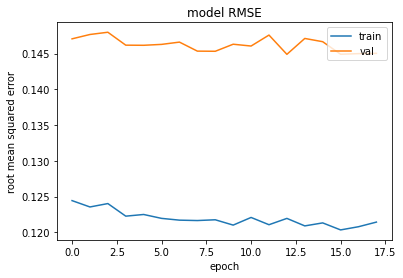

In [ ]:
history_ks_1 = model_1.fit(X_train_ks, y_train_ks, validation_data=(X_val1_ks, y_val1_ks), epochs=50, 
           callbacks = [early_stopping_monitor], verbose = False)

# summarize history for accuracy
plt.plot(history_ks_1.history['root_mean_squared_error'])
plt.plot(history_ks_1.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('root mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
print(classification_report(test_results_ks_1['actuals'], test_results_ks_1['predictions']))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       421
         1.0       0.97      0.97      0.97       221
         2.0       0.96      0.96      0.96        82

    accuracy                           0.98       724
   macro avg       0.98      0.98      0.98       724
weighted avg       0.98      0.98      0.98       724



###LSTM model with only score data and time data but the time data is transformed using sine and cosine

####train

In [ ]:
train_ks1 = train_ks.copy()
train_ks1.index = pd.to_datetime(train_ks1['date'], format='%Y.%m.%d')
train_ks1[:31]

fips        date  PRECTOT     PS  QV2M    T2M  T2MDEW  T2MWET  \
date                                                                         
2000-01-01  20025  2000-01-01     0.00  92.66  3.92  10.08   -0.92   -0.86   
2000-01-02  20025  2000-01-02     0.02  93.00  3.49   5.76   -2.22   -2.16   
2000-01-03  20025  2000-01-03     1.94  93.43  2.92  -0.95   -4.71   -4.64   
2000-01-04  20025  2000-01-04     0.00  94.54  1.60  -1.59  -11.38  -10.99   
2000-01-05  20025  2000-01-05     0.27  93.55  2.82   1.61   -5.25   -5.13   
2000-01-06  20025  2000-01-06     0.01  94.73  2.57   1.33   -5.91   -5.78   
2000-01-07  20025  2000-01-07     0.00  94.63  2.33   1.98   -7.02   -6.85   
2000-01-08  20025  2000-01-08     0.06  93.35  2.92   1.75   -4.48   -4.41   
2000-01-09  20025  2000-01-09     0.00  92.70  2.72   3.50   -5.45   -5.34   
2000-01-10  20025  2000-01-10     0.00  93.06  2.45   4.42   -6.75   -6.57   
2000-01-11  20025  2000-01-11     0.00  93.55  2.25   2.79   -7.76   -7.53   
2000-01-12  20025  2000-01-12     0.01  93.44  2.92   5.92   -4.42   -4.31   
2000-01-13  20025  2000-01-13     0.00  95.48  2.15   1.55   -7.90   -7.66   
2000-01-14  20025  2000-01-14     0.00  94.99  2.46   4.86   -6.33   -6.16   
2000-01-15  20025  2000-01-15     0.00  93.98  3.50   7.58   -2.04   -1.98   
2000-01-16  20025  2000-01-16     0.01  94.55  3.42   2.73   -2.31   -2.27   
2000-01-17  20025  2000-01-17     0.02  94.18  4.27   5.60    0.74    0.76   
2000-01-18  20025  2000-01-18     0.00  94.16  4.12   6.41    0.26    0.28   
2000-01-19  20025  2000-01-19     0.00  93.75  3.54   6.52   -2.28   -2.20   
2000-01-20  20025  2000-01-20     0.00  94.33  2.00  -0.15   -8.86   -8.64   
2000-01-21  20025  2000-01-21     0.00  93.28  2.48   2.24   -6.51   -6.36   
2000-01-22  20025  2000-01-22     0.17  93.28  3.27   4.68   -3.01   -2.95   
2000-01-23  20025  2000-01-23     0.60  94.17  3.42   1.60   -2.46   -2.43   
2000-01-24  20025  2000-01-24     0.04  94.08  2.79   1.71   -4.95   -4.88   
2000-01-25  20025  2000-01-25     0.10  94.62  1.76  -1.82  -10.33  -10.00   
2000-01-26  20025  2000-01-26     1.29  94.16  2.32  -3.17   -7.17   -7.08   
2000-01-27  20025  2000-01-27     6.40  94.43  2.28  -4.13   -7.27   -7.21   
2000-01-28  20025  2000-01-28     0.70  94.68  2.02  -4.30   -8.64   -8.53   
2000-01-29  20025  2000-01-29     0.02  94.60  2.33  -3.23   -7.06   -7.00   
2000-01-30  20025  2000-01-30     0.00  94.58  2.41  -3.22   -6.58   -6.53   
2000-01-31  20025  2000-01-31     0.05  94.17  2.66  -1.77   -5.50   -5.45   

            T2M_MAX  T2M_MIN  T2M_RANGE    TS  WS10M  WS10M_MAX  WS10M_MIN  \
date                                                                         
2000-01-01    20.12     1.71      18.41  9.46   6.68       9.82       3.96   
2000-01-02    12.76     0.84      11.92  5.99   3.73       8.68       0.58   
2000-01-03     1.57    -5.45       7.01 -0.88   8.16      11.02       3.86   
2000-01-04     6.98    -7.53      14.51 -2.04   4.35       5.84       1.30   
2000-01-05    11.79    -3.99      15.78  0.85   4.69       6.74       2.44   
2000-01-06     7.27    -2.60       9.87 -0.08   3.88       5.71       0.80   
2000-01-07    10.86    -3.54      14.41  1.37   5.08       8.16       3.37   
2000-01-08     9.23    -3.15      12.38  0.78   3.14       5.26       1.65   
2000-01-09    11.98    -2.13      14.11  2.11   4.96       9.90       0.83   
2000-01-10    15.95    -1.36      17.31  3.93   6.01       8.06       2.79   
2000-01-11    12.15    -3.97      16.12  2.31   4.84       8.25       2.24   
2000-01-12    17.44    -0.12      17.56  5.02   5.35       9.00       3.20   
2000-01-13     9.55    -3.73      13.28  1.56   3.82       4.77       3.17   
2000-01-14    15.52    -3.04      18.56  4.43   7.61      11.99       4.80   
2000-01-15    16.43     0.91      15.52  6.19   4.30       7.73       1.14   
2000-01-16     8.21    -1.87      10.08  3.17   4.46       6.84       2.25   
2000-01-17    11.97     0.63      

In [ ]:
scoreks = train_ks1['score']
scoreks_df = pd.DataFrame({'score':scoreks})
scoreks_df['Seconds'] = scoreks_df.index.map(pd.Timestamp.timestamp)
scoreks_df

score       Seconds
date                           
2000-01-01    1.0  9.466848e+08
2000-01-02    1.0  9.467712e+08
2000-01-03    1.0  9.468576e+08
2000-01-04    1.0  9.469440e+08
2000-01-05    1.0  9.470304e+08
...           ...           ...
2016-12-27    3.0  1.482797e+09
2016-12-28    3.0  1.482883e+09
2016-12-29    3.0  1.482970e+09
2016-12-30    3.0  1.483056e+09
2016-12-31    3.0  1.483142e+09

[6210 rows x 2 columns]

In [ ]:
day = 60*60*24
month = 30.437*day
year = 365.2425*day

scoreks_df['Day sin'] = np.sin(scoreks_df['Seconds'] * (2* np.pi / day))
scoreks_df['Day cos'] = np.cos(scoreks_df['Seconds'] * (2 * np.pi / day))
scoreks_df['Month sin'] = np.sin(scoreks_df['Seconds'] * (2* np.pi / month))
scoreks_df['Month cos'] = np.cos(scoreks_df['Seconds'] * (2 * np.pi / month))
scoreks_df['Year sin'] = np.sin(scoreks_df['Seconds'] * (2 * np.pi / year))
scoreks_df['Year cos'] = np.cos(scoreks_df['Seconds'] * (2 * np.pi / year))
scoreks_df.head()

score      Seconds       Day sin  Day cos  Month sin  Month cos  \
date                                                                          
2000-01-01    1.0  946684800.0 -5.461913e-12      1.0  -0.066010   0.997819   
2000-01-02    1.0  946771200.0 -1.163374e-12      1.0   0.139914   0.990164   
2000-01-03    1.0  946857600.0  3.135164e-12      1.0   0.339896   0.940463   
2000-01-04    1.0  946944000.0 -7.118212e-12      1.0   0.525446   0.850827   
2000-01-05    1.0  947030400.0 -2.819674e-12      1.0   0.688683   0.725062   

            Year sin  Year cos  
date                            
2000-01-01 -0.004731  0.999989  
2000-01-02  0.012472  0.999922  
2000-01-03  0.029670  0.999560  
2000-01-04  0.046860  0.998901  
2000-01-05  0.064036  0.997948

In [ ]:
scoreks_df = scoreks_df.drop('Seconds', axis=1)
scoreks_df.head()

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2000-01-01    1.0 -5.461913e-12      1.0  -0.066010   0.997819 -0.004731   
2000-01-02    1.0 -1.163374e-12      1.0   0.139914   0.990164  0.012472   
2000-01-03    1.0  3.135164e-12      1.0   0.339896   0.940463  0.029670   
2000-01-04    1.0 -7.118212e-12      1.0   0.525446   0.850827  0.046860   
2000-01-05    1.0 -2.819674e-12      1.0   0.688683   0.725062  0.064036   

            Year cos  
date                  
2000-01-01  0.999989  
2000-01-02  0.999922  
2000-01-03  0.999560  
2000-01-04  0.998901  
2000-01-05  0.997948

####val

In [ ]:
val_ks1 = val_ks.copy()
val_ks1.index = pd.to_datetime(val_ks1['date'], format='%Y.%m.%d')
val_ks1[:31]

fips        date  PRECTOT     PS  QV2M   T2M  T2MDEW  T2MWET  \
date                                                                        
2017-01-01  20025  2017-01-01     0.00  92.92  3.42  4.25   -2.83   -2.77   
2017-01-02  20025  2017-01-02     0.01  93.01  4.22  5.52    0.36    0.38   
2017-01-03  20025  2017-01-03     0.01  94.34  1.62 -2.91  -11.66  -11.21   
2017-01-04  20025  2017-01-04     0.00  94.02  1.24 -5.01  -14.11  -13.53   
2017-01-05  20025  2017-01-05     1.21  94.19  1.13 -8.84  -15.11  -14.60   
2017-01-06  20025  2017-01-06     0.28  94.60  0.98 -8.77  -16.47  -15.71   
2017-01-07  20025  2017-01-07     0.00  95.33  1.41 -5.66  -12.72  -12.36   
2017-01-08  20025  2017-01-08     0.45  94.57  2.17 -1.53   -8.07   -7.92   
2017-01-09  20025  2017-01-09     0.05  93.29  4.06  3.19   -0.78   -0.74   
2017-01-10  20025  2017-01-10     0.00  93.02  3.50  7.33   -2.47   -2.36   
2017-01-11  20025  2017-01-11     0.00  92.63  3.58  7.09   -2.14   -2.08   
2017-01-12  20025  2017-01-12     0.00  94.32  1.60 -4.13  -11.37  -11.08   
2017-01-13  20025  2017-01-13     0.01  95.11  1.81 -3.28   -9.85   -9.63   
2017-01-14  20025  2017-01-14    17.81  94.97  2.65 -1.24   -5.57   -5.49   
2017-01-15  20025  2017-01-15    29.81  93.97  3.89 -0.08   -0.55   -0.55   
2017-01-16  20025  2017-01-16    11.64  93.42  3.67 -0.72   -1.45   -1.45   
2017-01-17  20025  2017-01-17     0.02  94.10  3.35 -0.90   -2.62   -2.61   
2017-01-18  20025  2017-01-18     0.01  93.60  4.28  1.15    0.55    0.55   
2017-01-19  20025  2017-01-19     0.03  92.52  4.74  2.18    1.90    1.90   
2017-01-20  20025  2017-01-20     0.17  92.01  4.46  3.31    0.97    0.98   
2017-01-21  20025  2017-01-21     3.78  91.88  4.80  3.99    1.68    1.69   
2017-01-22  20025  2017-01-22     1.62  93.11  3.73  3.69   -1.38   -1.35   
2017-01-23  20025  2017-01-23     0.00  92.85  3.98  5.26   -0.68   -0.65   
2017-01-24  20025  2017-01-24     0.17  92.22  4.08  7.16   -0.41   -0.37   
2017-01-25  20025  2017-01-25     0.01  93.69  2.16 -1.44   -8.03   -7.88   
2017-01-26  20025  2017-01-26     0.04  94.41  1.95 -1.10   -9.13   -8.90   
2017-01-27  20025  2017-01-27     0.00  94.57  1.86 -0.18   -9.70   -9.39   
2017-01-28  20025  2017-01-28     0.00  94.40  2.55  2.37   -5.92   -5.80   
2017-01-29  20025  2017-01-29     0.00  94.33  2.91  6.00   -4.33   -4.22   
2017-01-30  20025  2017-01-30     0.00  93.83  3.46  9.11   -2.36   -2.29   
2017-01-31  20025  2017-01-31     0.00  93.43  3.60  6.35   -1.79   -1.74   

            T2M_MAX  T2M_MIN  T2M_RANGE    TS  WS10M  WS10M_MAX  WS10M_MIN  \
date                                                                         
2017-01-01    14.41    -3.38      17.79  3.93   5.73       8.86       2.85   
2017-01-02    13.61     0.70      12.91  5.75   4.20       7.43       2.11   
2017-01-03     0.49    -6.02       6.51 -2.26   7.11       9.17       4.07   
2017-01-04    -1.12    -7.58       6.46 -3.69   4.09       6.81       2.12   
2017-01-05    -7.55    -9.71       2.16 -7.58   5.92       7.21       3.38   
2017-01-06    -4.55   -10.75       6.20 -8.65   2.79       3.72       1.57   
2017-01-07     2.43   -11.90      14.34 -5.32   2.88       4.54       0.54   
2017-01-08     6.40    -7.33      13.72 -1.72   5.24       8.02       2.64   
2017-01-09    10.85    -3.32      14.18  2.78   6.11       9.17       3.42   
2017-01-10    14.57     3.73      10.84  6.36   6.76      10.26       1.51   
2017-01-11    18.18    -3.51      21.70  6.26   5.10       7.70       1.04   
2017-01-12     0.59    -7.27       7.86 -2.92   4.30       6.31       2.24   
2017-01-13    -1.61    -5.35       3.73 -2.02   2.87       3.65       1.48   
2017-01-14     0.88    -2.12       2.99 -0.58   2.40       4.58       1.20   
2017-01-15     0.22    -0.56       0.78 -0.22   3.15       5.96       1.88   
2017-01-16     0.54    -1.99       2.53 -1.19   4.92       6.60       2.68   
2017-01-17     1.94    -3.94       5.88 -2.80   3.10       5.01    

In [ ]:
scoreks_val = val_ks1['score']
scoreks_val_df = pd.DataFrame({'score':scoreks_val})
scoreks_val_df['Seconds'] = scoreks_val_df.index.map(pd.Timestamp.timestamp)
scoreks_val_df

score       Seconds
date                           
2017-01-01    3.0  1.483229e+09
2017-01-02    3.0  1.483315e+09
2017-01-03    3.0  1.483402e+09
2017-01-04    3.0  1.483488e+09
2017-01-05    3.0  1.483574e+09
...           ...           ...
2018-12-27    0.0  1.545869e+09
2018-12-28    0.0  1.545955e+09
2018-12-29    0.0  1.546042e+09
2018-12-30    0.0  1.546128e+09
2018-12-31    0.0  1.546214e+09

[730 rows x 2 columns]

In [ ]:
scoreks_val_df['Day sin'] = np.sin(scoreks_val_df['Seconds'] * (2* np.pi / day))
scoreks_val_df['Day cos'] = np.cos(scoreks_val_df['Seconds'] * (2 * np.pi / day))
scoreks_val_df['Month sin'] = np.sin(scoreks_val_df['Seconds'] * (2* np.pi / month))
scoreks_val_df['Month cos'] = np.cos(scoreks_val_df['Seconds'] * (2 * np.pi / month))
scoreks_val_df['Year sin'] = np.sin(scoreks_val_df['Seconds'] * (2 * np.pi / year))
scoreks_val_df['Year cos'] = np.cos(scoreks_val_df['Seconds'] * (2 * np.pi / year))
scoreks_val_df.head()

score       Seconds       Day sin  Day cos  Month sin  Month cos  \
date                                                                           
2017-01-01    3.0  1.483229e+09  2.504006e-13      1.0   0.109601   0.993976   
2017-01-02    3.0  1.483315e+09 -1.000298e-11      1.0   0.311009   0.950407   
2017-01-03    3.0  1.483402e+09 -5.704437e-12      1.0   0.499210   0.866481   
2017-01-04    3.0  1.483488e+09 -1.405899e-12      1.0   0.666213   0.745761   
2017-01-05    3.0  1.483574e+09 -1.165928e-11      1.0   0.804927   0.593374   

            Year sin  Year cos  
date                            
2017-01-01  0.010364  0.999946  
2017-01-02  0.027564  0.999620  
2017-01-03  0.044755  0.998998  
2017-01-04  0.061933  0.998080  
2017-01-05  0.079093  0.996867

In [ ]:
scoreks_val_df = scoreks_val_df.drop('Seconds', axis=1)
scoreks_val_df.head()

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2017-01-01    3.0  2.504006e-13      1.0   0.109601   0.993976  0.010364   
2017-01-02    3.0 -1.000298e-11      1.0   0.311009   0.950407  0.027564   
2017-01-03    3.0 -5.704437e-12      1.0   0.499210   0.866481  0.044755   
2017-01-04    3.0 -1.405899e-12      1.0   0.666213   0.745761  0.061933   
2017-01-05    3.0 -1.165928e-11      1.0   0.804927   0.593374  0.079093   

            Year cos  
date                  
2017-01-01  0.999946  
2017-01-02  0.999620  
2017-01-03  0.998998  
2017-01-04  0.998080  
2017-01-05  0.996867

####test

In [ ]:
test_ks1 = test_ks.copy()
test_ks1.index = pd.to_datetime(test_ks1['date'], format='%Y.%m.%d')
test_ks1[:31]

fips        date  PRECTOT     PS  QV2M   T2M  T2MDEW  T2MWET  \
date                                                                        
2019-01-01  20025  2019-01-01     0.00  94.73  1.17 -9.02  -15.86  -14.28   
2019-01-02  20025  2019-01-02     0.00  94.18  1.77 -4.30  -10.85  -10.20   
2019-01-03  20025  2019-01-03     0.24  93.72  2.37 -0.84   -7.21   -6.98   
2019-01-04  20025  2019-01-04     0.00  93.56  3.49  2.78   -2.10   -2.34   
2019-01-05  20025  2019-01-05     0.00  93.62  4.29  4.13    0.72    0.50   
2019-01-06  20025  2019-01-06     0.00  92.83  5.45  9.06    3.97    3.76   
2019-01-07  20025  2019-01-07     0.00  93.37  3.78  7.14   -1.05   -1.13   
2019-01-08  20025  2019-01-08     0.00  94.87  2.40  2.86   -6.97   -6.55   
2019-01-09  20025  2019-01-09     0.00  95.03  2.57  2.79   -5.99   -5.70   
2019-01-10  20025  2019-01-10     0.10  93.94  4.58  5.42    1.69    1.26   
2019-01-11  20025  2019-01-11    14.53  93.44  4.43  1.88    1.09    1.08   
2019-01-12  20025  2019-01-12     1.73  94.19  3.33 -0.69   -2.69   -2.63   
2019-01-13  20025  2019-01-13     0.14  94.92  2.89 -2.39   -4.44   -4.30   
2019-01-14  20025  2019-01-14     0.12  94.61  3.67  1.36   -1.29   -1.35   
2019-01-15  20025  2019-01-15     0.01  94.10  4.48  3.35    1.35    1.29   
2019-01-16  20025  2019-01-16     0.14  93.77  4.41  1.84    1.08    1.06   
2019-01-17  20025  2019-01-17     0.01  93.87  4.38  4.27    1.05    0.97   
2019-01-18  20025  2019-01-18     2.88  92.99  4.03  1.73   -0.27   -0.54   
2019-01-19  20025  2019-01-19     0.00  94.48  1.74 -4.73  -11.02  -10.25   
2019-01-20  20025  2019-01-20     0.01  94.05  3.14  0.55   -3.44   -3.66   
2019-01-21  20025  2019-01-21     0.07  92.66  4.32  4.20    0.68    0.44   
2019-01-22  20025  2019-01-22     0.09  93.41  2.57 -2.32   -6.18   -6.54   
2019-01-23  20025  2019-01-23     0.00  93.86  2.22 -0.02   -8.02   -7.53   
2019-01-24  20025  2019-01-24     0.02  94.39  2.54 -1.47   -6.17   -5.97   
2019-01-25  20025  2019-01-25     0.00  94.38  2.49 -0.59   -6.45   -6.19   
2019-01-26  20025  2019-01-26     0.00  94.15  2.85  1.77   -4.70   -4.58   
2019-01-27  20025  2019-01-27     0.00  93.53  3.15  4.74   -3.48   -3.35   
2019-01-28  20025  2019-01-28     0.00  93.97  2.67  0.56   -5.61   -5.87   
2019-01-29  20025  2019-01-29     0.00  94.22  2.00 -1.08   -9.31   -8.70   
2019-01-30  20025  2019-01-30     0.00  94.04  2.01 -4.18   -9.26   -8.89   
2019-01-31  20025  2019-01-31     0.00  93.63  3.06  0.43   -3.83   -3.81   

            T2M_MAX  T2M_MIN  T2M_RANGE    TS  WS10M  WS10M_MAX  WS10M_MIN  \
date                                                                         
2019-01-01    -5.70   -10.87       5.17 -8.06   4.25       8.71       0.29   
2019-01-02     2.45   -11.03      13.48 -4.82   2.13       4.32       0.12   
2019-01-03     5.74    -6.14      11.89 -1.91   2.54       3.69       1.34   
2019-01-04    12.18    -2.00      14.18  1.32   4.04       5.61       2.55   
2019-01-05    12.87    -0.35      13.21  3.02   3.55       4.64       1.24   
2019-01-06    17.33     2.01      15.32  8.29   6.35       8.33       4.45   
2019-01-07    14.64     1.60      13.03  5.83   4.98       8.40       2.84   
2019-01-08     9.64    -2.33      11.98  1.46   4.15       6.71       1.05   
2019-01-09    10.52    -2.72      13.24  1.86   3.83       5.86       0.97   
2019-01-10    13.96    -0.28      14.24  5.33   5.32       7.15       3.61   
2019-01-11     3.32    -0.56       3.88  2.05   4.35       6.69       1.93   
2019-01-12     3.30    -5.00       8.30 -0.68   6.55       9.63       3.27   
2019-01-13     1.95    -5.33       7.28 -1.88   1.99       3.59       1.10   
2019-01-14     8.80    -3.65      12.46  0.40   2.71       3.50       1.45   
2019-01-15    10.30    -1.45      11.75  1.36   1.62       2.77       0.09   
2019-01-16     5.28    -0.72       5.99  1.90   3.66       5.58       1.21   
2019-01-17    13.01    -1.93      14.94  4.48   4.08       7.29    

In [ ]:
scoreks_test = test_ks1['score']
scoreks_test_df = pd.DataFrame({'score':scoreks_test})
scoreks_test_df['Seconds'] = scoreks_test_df.index.map(pd.Timestamp.timestamp)
scoreks_test_df

score       Seconds
date                           
2019-01-01    0.0  1.546301e+09
2019-01-02    0.0  1.546387e+09
2019-01-03    0.0  1.546474e+09
2019-01-04    0.0  1.546560e+09
2019-01-05    0.0  1.546646e+09
...           ...           ...
2020-12-27    0.0  1.609027e+09
2020-12-28    0.0  1.609114e+09
2020-12-29    0.0  1.609200e+09
2020-12-30    0.0  1.609286e+09
2020-12-31    0.0  1.609373e+09

[731 rows x 2 columns]

In [ ]:
scoreks_test_df['Day sin'] = np.sin(scoreks_test_df['Seconds'] * (2* np.pi / day))
scoreks_test_df['Day cos'] = np.cos(scoreks_test_df['Seconds'] * (2 * np.pi / day))
scoreks_test_df['Month sin'] = np.sin(scoreks_test_df['Seconds'] * (2* np.pi / month))
scoreks_test_df['Month cos'] = np.cos(scoreks_test_df['Seconds'] * (2 * np.pi / month))
scoreks_test_df['Year sin'] = np.sin(scoreks_test_df['Seconds'] * (2 * np.pi / year))
scoreks_test_df['Year cos'] = np.cos(scoreks_test_df['Seconds'] * (2 * np.pi / year))
scoreks_test_df.head()

score       Seconds       Day sin  Day cos  Month sin  Month cos  \
date                                                                           
2019-01-01    0.0  1.546301e+09 -5.030095e-12      1.0   0.009083   0.999959   
2019-01-02    0.0  1.546387e+09 -7.315560e-13      1.0   0.213851   0.976866   
2019-01-03    0.0  1.546474e+09 -1.098493e-11      1.0   0.409538   0.912293   
2019-01-04    0.0  1.546560e+09 -6.686394e-12      1.0   0.587835   0.808981   
2019-01-05    0.0  1.546646e+09 -2.387855e-12      1.0   0.741171   0.671316   

            Year sin  Year cos  
date                            
2019-01-01  0.002021  0.999998  
2019-01-02  0.019223  0.999815  
2019-01-03  0.036419  0.999337  
2019-01-04  0.053604  0.998562  
2019-01-05  0.070773  0.997492

In [ ]:
scoreks_test_df = scoreks_test_df.drop('Seconds', axis=1)
scoreks_test_df.head()

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2019-01-01    0.0 -5.030095e-12      1.0   0.009083   0.999959  0.002021   
2019-01-02    0.0 -7.315560e-13      1.0   0.213851   0.976866  0.019223   
2019-01-03    0.0 -1.098493e-11      1.0   0.409538   0.912293  0.036419   
2019-01-04    0.0 -6.686394e-12      1.0   0.587835   0.808981  0.053604   
2019-01-05    0.0 -2.387855e-12      1.0   0.741171   0.671316  0.070773   

            Year cos  
date                  
2019-01-01  0.999998  
2019-01-02  0.999815  
2019-01-03  0.999337  
2019-01-04  0.998562  
2019-01-05  0.997492

In [ ]:
def df_to_X_y2(df, window_size=7):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
WINDOW_SIZE = 7
X_train_ks2, y_train_ks2 = df_to_X_y2(scoreks_df, WINDOW_SIZE)
X_val1_ks2, y_val1_ks2 = df_to_X_y2(scoreks_val_df, WINDOW_SIZE)
X_test1_ks2, y_test1_ks2 = df_to_X_y2(scoreks_test_df, WINDOW_SIZE)
X_train_ks2.shape, y_train_ks2.shape, X_val1_ks2.shape, y_val1_ks2.shape, X_test1_ks2.shape, y_test1_ks2.shape

((6203, 7, 7), (6203,), (723, 7, 7), (723,), (724, 7, 7), (724,))

In [ ]:
temp_training_mean = np.mean(X_train_ks2[:, :, 0])
temp_training_std = np.std(X_train_ks2[:, :, 0])
                           
def preprocess(X):
  X[:, :, 0] = (X[:, :, 0] - temp_training_mean) / temp_training_std
  return X

In [ ]:
preprocess(X_train_ks2)
preprocess(X_val1_ks2)
preprocess(X_test1_ks2)

array([[[-9.01091734e-01, -5.03009464e-12,  1.00000000e+00, ...,
          9.99958750e-01,  2.02132493e-03,  9.99997957e-01],
        [-9.01091734e-01, -7.31556020e-13,  1.00000000e+00, ...,
          9.76866282e-01,  1.92229193e-02,  9.99815223e-01],
        [-9.01091734e-01, -1.09849326e-11,  1.00000000e+00, ...,
          9.12292898e-01,  3.64188251e-02,  9.99336615e-01],
        ...,
        [-9.01091734e-01, -2.38785538e-12,  1.00000000e+00, ...,
          6.71316340e-01,  7.07732190e-02,  9.97492432e-01],
        [-9.01091734e-01, -1.26412320e-11,  1.00000000e+00, ...,
          5.05145814e-01,  8.79215407e-02,  9.96127403e-01],
        [-9.01091734e-01, -8.34269337e-12,  1.00000000e+00, ...,
          3.17525155e-01,  1.05043844e-01,  9.94467592e-01]],

       [[-9.01091734e-01, -7.31556020e-13,  1.00000000e+00, ...,
          9.76866282e-01,  1.92229193e-02,  9.99815223e-01],
        [-9.01091734e-01, -1.09849326e-11,  1.00000000e+00, ...,
          9.12292898e-01,  3.64188251e

In [ ]:
model_2 = Sequential()
model_2.add(InputLayer((7, 7)))
model_2.add(LSTM(64))
model_2.add(Dense(8, 'relu'))
model_2.add(Dense(1, 'linear'))

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                18432     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 18,961
Trainable params: 18,961
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)
model_2.fit(X_train_ks2, y_train_ks2, validation_data=(X_val1_ks2, y_val1_ks2), epochs=50, callbacks=[early_stopping_monitor])

Epoch 1/50
194/194 [==============================] - 4s 10ms/step - loss: 3.6789 - root_mean_squared_error: 1.9181 - val_loss: 1.3259 - val_root_mean_squared_error: 1.1515
Epoch 2/50
194/194 [==============================] - 1s 8ms/step - loss: 0.2914 - root_mean_squared_error: 0.5398 - val_loss: 0.0796 - val_root_mean_squared_error: 0.2821
Epoch 3/50
194/194 [==============================] - 2s 8ms/step - loss: 0.0538 - root_mean_squared_error: 0.2320 - val_loss: 0.0774 - val_root_mean_squared_error: 0.2783
Epoch 4/50
194/194 [==============================] - 1s 7ms/step - loss: 0.0504 - root_mean_squared_error: 0.2244 - val_loss: 0.0761 - val_root_mean_squared_error: 0.2758
Epoch 5/50
194/194 [==============================] - 1s 7ms/step - loss: 0.0480 - root_mean_squared_error: 0.2190 - val_loss: 0.0749 - val_root_mean_squared_error: 0.2737
Epoch 6/50
194/194 [==============================] - 1s 7ms/step - loss: 0.0460 - root_mean_squared_error: 0.2145 - val_loss: 0.0708 - val

####using the model to predict the test dataset

In [ ]:
test_prediction_ks_2 = model_2.predict(X_test1_ks2).flatten()
test_results_ks_2 = pd.DataFrame(data={'predictions':test_prediction_ks_2, 'actuals':y_test1_ks2})
test_results_ks_2

23/23 [==============================] - 1s 3ms/step


predictions  actuals
0       0.024310      0.0
1       0.030535      0.0
2       0.034704      0.0
3       0.035534      0.0
4       0.034473      0.0
..           ...      ...
719     0.011665      0.0
720     0.010040      0.0
721     0.007884      0.0
722     0.005414      0.0
723     0.002991      0.0

[724 rows x 2 columns]

In [ ]:
test_results_ks_2.predictions[test_results_ks_2.predictions <0.5] = 0
test_results_ks_2.predictions[(test_results_ks_2.predictions >=0.5)&(test_results_ks_2.predictions<1.5)] = 1
test_results_ks_2.predictions[(test_results_ks_2.predictions >=1.5)&(test_results_ks_2.predictions<2.5)] = 2
test_results_ks_2.predictions[(test_results_ks_2.predictions >=2.5)&(test_results_ks_2.predictions<3.5)] = 3
test_results_ks_2.predictions[(test_results_ks_2.predictions >=3.5)&(test_results_ks_2.predictions<4.5)] = 4
test_results_ks_2.predictions[(test_results_ks_2.predictions >=4.5)&(test_results_ks_2.predictions<5.5)] = 5
test_results_ks_2.actuals[test_results_ks_2.actuals <0.5] = 0
test_results_ks_2.actuals[(test_results_ks_2.actuals >=0.5)&(test_results_ks_2.actuals<1.5)] = 1
test_results_ks_2.actuals[(test_results_ks_2.actuals >=1.5)&(test_results_ks_2.actuals<2.5)] = 2
test_results_ks_2.actuals[(test_results_ks_2.actuals >=2.5)&(test_results_ks_2.actuals<3.5)] = 3
test_results_ks_2.actuals[(test_results_ks_2.actuals >=3.5)&(test_results_ks_2.actuals<4.5)] = 4
test_results_ks_2.actuals[(test_results_ks_2.actuals >=4.5)&(test_results_ks_2.actuals<5.5)] = 5
test_results_ks_2

predictions  actuals
0            0.0      0.0
1            0.0      0.0
2            0.0      0.0
3            0.0      0.0
4            0.0      0.0
..           ...      ...
719          0.0      0.0
720          0.0      0.0
721          0.0      0.0
722          0.0      0.0
723          0.0      0.0

[724 rows x 2 columns]

####model evaluation

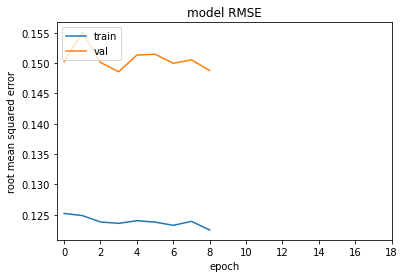

In [ ]:
history_ks_2 = model_2.fit(X_train_ks2, y_train_ks2, validation_data=(X_val1_ks2, y_val1_ks2), epochs=50, callbacks=[early_stopping_monitor],verbose=False)

# summarize history for rmse
plt.plot(history_ks_2.history['root_mean_squared_error'])
plt.plot(history_ks_2.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.xticks(range(0,20,2))
plt.ylabel('root mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
print(classification_report(test_results_ks_2['actuals'], test_results_ks_2['predictions']))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       421
         1.0       0.97      0.97      0.97       221
         2.0       0.96      0.96      0.96        82

    accuracy                           0.98       724
   macro avg       0.98      0.98      0.98       724
weighted avg       0.98      0.98      0.98       724



###comparing all the LSTM models

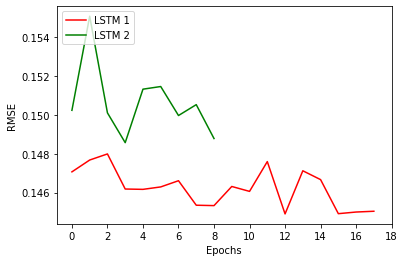

In [ ]:
plt.plot(history_ks_1.history['val_root_mean_squared_error'], 'r',
         history_ks_2.history['val_root_mean_squared_error'],'g')
plt.xticks(range(0,20,2))
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend(['LSTM 1', 'LSTM 2'], loc='upper left')
plt.show()

####predicting for 1 jan 2021 until 1 feb 2021 using the 2nd model

In [ ]:
df_date = pd.DataFrame({
    'date':pd.date_range(start='2021-01-01', end='2021-02-01')
})
df_date

date
0  2021-01-01
1  2021-01-02
2  2021-01-03
3  2021-01-04
4  2021-01-05
5  2021-01-06
6  2021-01-07
7  2021-01-08
8  2021-01-09
9  2021-01-10
10 2021-01-11
11 2021-01-12
12 2021-01-13
13 2021-01-14
14 2021-01-15
15 2021-01-16
16 2021-01-17
17 2021-01-18
18 2021-01-19
19 2021-01-20
20 2021-01-21
21 2021-01-22
22 2021-01-23
23 2021-01-24
24 2021-01-25
25 2021-01-26
26 2021-01-27
27 2021-01-28
28 2021-01-29
29 2021-01-30
30 2021-01-31
31 2021-02-01

In [ ]:
df_date.index = pd.to_datetime(df_date['date'], format='%Y.%m.%d')
df_date

date
date                 
2021-01-01 2021-01-01
2021-01-02 2021-01-02
2021-01-03 2021-01-03
2021-01-04 2021-01-04
2021-01-05 2021-01-05
2021-01-06 2021-01-06
2021-01-07 2021-01-07
2021-01-08 2021-01-08
2021-01-09 2021-01-09
2021-01-10 2021-01-10
2021-01-11 2021-01-11
2021-01-12 2021-01-12
2021-01-13 2021-01-13
2021-01-14 2021-01-14
2021-01-15 2021-01-15
2021-01-16 2021-01-16
2021-01-17 2021-01-17
2021-01-18 2021-01-18
2021-01-19 2021-01-19
2021-01-20 2021-01-20
2021-01-21 2021-01-21
2021-01-22 2021-01-22
2021-01-23 2021-01-23
2021-01-24 2021-01-24
2021-01-25 2021-01-25
2021-01-26 2021-01-26
2021-01-27 2021-01-27
2021-01-28 2021-01-28
2021-01-29 2021-01-29
2021-01-30 2021-01-30
2021-01-31 2021-01-31
2021-02-01 2021-02-01

In [ ]:
df_date['Seconds'] = df_date.index.map(pd.Timestamp.timestamp)
df_date

date       Seconds
date                               
2021-01-01 2021-01-01  1.609459e+09
2021-01-02 2021-01-02  1.609546e+09
2021-01-03 2021-01-03  1.609632e+09
2021-01-04 2021-01-04  1.609718e+09
2021-01-05 2021-01-05  1.609805e+09
2021-01-06 2021-01-06  1.609891e+09
2021-01-07 2021-01-07  1.609978e+09
2021-01-08 2021-01-08  1.610064e+09
2021-01-09 2021-01-09  1.610150e+09
2021-01-10 2021-01-10  1.610237e+09
2021-01-11 2021-01-11  1.610323e+09
2021-01-12 2021-01-12  1.610410e+09
2021-01-13 2021-01-13  1.610496e+09
2021-01-14 2021-01-14  1.610582e+09
2021-01-15 2021-01-15  1.610669e+09
2021-01-16 2021-01-16  1.610755e+09
2021-01-17 2021-01-17  1.610842e+09
2021-01-18 2021-01-18  1.610928e+09
2021-01-19 2021-01-19  1.611014e+09
2021-01-20 2021-01-20  1.611101e+09
2021-01-21 2021-01-21  1.611187e+09
2021-01-22 2021-01-22  1.611274e+09
2021-01-23 2021-01-23  1.611360e+09
2021-01-24 2021-01-24  1.611446e+09
2021-01-25 2021-01-25  1.611533e+09
2021-01-26 2021-01-26  1.611619e+09
2021-01-27 2021-01-27  1.611706e+09
2021-01-28 2021-01-28  1.611792e+09
2021-01-29 2021-01-29  1.611878e+09
2021-01-30 2021-01-30  1.611965e+09
2021-01-31 2021-01-31  1.612051e+09
2021-02-01 2021-02-01  1.612138e+09

In [ ]:
df_date['Day sin'] = np.sin(df_date['Seconds'] * (2* np.pi / day))
df_date['Day cos'] = np.cos(df_date['Seconds'] * (2 * np.pi / day))
df_date['Month sin'] = np.sin(df_date['Seconds'] * (2* np.pi / month))
df_date['Month cos'] = np.cos(df_date['Seconds'] * (2* np.pi / month))
df_date['Year sin'] = np.sin(df_date['Seconds'] * (2 * np.pi / year))
df_date['Year cos'] = np.cos(df_date['Seconds'] * (2 * np.pi / year))
df_date.head()

date       Seconds       Day sin  Day cos  Month sin  \
date                                                                    
2021-01-01 2021-01-01  1.609459e+09 -6.012051e-12      1.0   0.114525   
2021-01-02 2021-01-02  1.609546e+09 -1.713513e-12      1.0   0.315714   
2021-01-03 2021-01-03  1.609632e+09 -1.196689e-11      1.0   0.503497   
2021-01-04 2021-01-04  1.609718e+09 -7.668351e-12      1.0   0.669900   
2021-01-05 2021-01-05  1.609805e+09 -3.369812e-12      1.0   0.807857   

            Month cos  Year sin  Year cos  
date                                       
2021-01-01   0.993420  0.010881  0.999941  
2021-01-02   0.948854  0.028080  0.999606  
2021-01-03   0.863997  0.045271  0.998975  
2021-01-04   0.742451  0.062448  0.998048  
2021-01-05   0.589379  0.079608  0.996826

In [ ]:
df_date = df_date.drop('Seconds', axis=1)
df_date = df_date.drop('date',axis=1)
df_date.head()

Day sin  Day cos  Month sin  Month cos  Year sin  Year cos
date                                                                       
2021-01-01 -6.012051e-12      1.0   0.114525   0.993420  0.010881  0.999941
2021-01-02 -1.713513e-12      1.0   0.315714   0.948854  0.028080  0.999606
2021-01-03 -1.196689e-11      1.0   0.503497   0.863997  0.045271  0.998975
2021-01-04 -7.668351e-12      1.0   0.669900   0.742451  0.062448  0.998048
2021-01-05 -3.369812e-12      1.0   0.807857   0.589379  0.079608  0.996826

In [ ]:
df_date.insert(0, "score", [0 for i in range(32)], True)
df_date

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2021-01-01      0 -6.012051e-12      1.0   0.114525   0.993420  0.010881   
2021-01-02      0 -1.713513e-12      1.0   0.315714   0.948854  0.028080   
2021-01-03      0 -1.196689e-11      1.0   0.503497   0.863997  0.045271   
2021-01-04      0 -7.668351e-12      1.0   0.669900   0.742451  0.062448   
2021-01-05      0 -3.369812e-12      1.0   0.807857   0.589379  0.079608   
2021-01-06      0  9.287266e-13      1.0   0.911509   0.411280  0.096743   
2021-01-07      0 -9.324650e-12      1.0   0.976456   0.215716  0.113850   
2021-01-08      0 -5.026111e-12      1.0   0.999940   0.010992  0.130923   
2021-01-09      0 -7.275728e-13      1.0   0.980962  -0.194198  0.147958   
2021-01-10      0 -1.098095e-11      1.0   0.920330  -0.391142  0.164948   
2021-01-11      0 -6.682411e-12      1.0   0.820618  -0.571477  0.181890   
2021-01-12      0 -2.383872e-12      1.0   0.686059  -0.727545  0.198778   
2021-01-13      0 -1.263725e-11      1.0   0.522369  -0.852720  0.215608   
2021-01-14      0 -8.338710e-12      1.0   0.336497  -0.941685  0.232373   
2021-01-15      0 -4.040172e-12      1.0   0.136336  -0.990663  0.249070   
2021-01-16      0  2.583671e-13      1.0  -0.069615  -0.997574  0.265693   
2021-01-17      0 -9.995009e-12      1.0  -0.272609  -0.962125  0.282237   
2021-01-18      0 -5.696471e-12      1.0  -0.464027  -0.885821  0.298698   
2021-01-19      0 -1.397932e-12      1.0  -0.635741  -0.771902  0.315070   
2021-01-20      0 -1.165131e-11      1.0  -0.780460  -0.625206  0.331350   
2021-01-21      0 -7.352770e-12      1.0  -0.892037  -0.451961  0.347531   
2021-01-22      0 -3.054232e-12      1.0  -0.965736  -0.259525  0.363609   
2021-01-23      0 -1.330761e-11      1.0  -0.998427  -0.056069  0.379580   
2021-01-24      0 -9.009070e-12      1.0  -0.988721   0.149769  0.395438   
2021-01-25      0 -4.710531e-12      1.0  -0.937031   0.349247  0.411179   
2021-01-26      0 -4.119923e-13      1.0  -0.845551   0.533894  0.426799   
2021-01-27      0 -1.066537e-11      1.0  -0.718167   0.695871  0.442292   
2021-01-28      0 -6.366830e-12      1.0  -0.560287   0.828299  0.457655   
2021-01-29      0 -2.068292e-12      1.0  -0.378615   0.925554  0.472882   
2021-01-30      0 -1.232167e-11      1.0  -0.180866   0.983508  0.487969   
2021-01-31      0 -8.023130e-12      1.0   0.024563   0.999698  0.502912   
2021-02-01      0 -3.724591e-12      1.0   0.228949   0.973438  0.517705   

            Year cos  
date                  
2021-01-01  0.999941  
2021-01-02  0.999606  
2021-01-03  0.998975  
2021-01-04  0.998048  
2021-01-05  0.996826  
2021-01-06  0.995309  
2021-01-07  0.993498  
2021-01-08  0.991393  
2021-01-09  0.988994  
2021-01-10  0.986302  
2021-01-11  0.983319  
2021-01-12  0.980044  
2021-01-13  0.976480  
2021-01-14  0.972627  
2021-01-15  0.968486  
2021-01-16  0.964058  
2021-01-17  0.959345  
2021-01-18  0.954348  
2021-01-19  0.949068  
2021-01-20  0.943508  
2021-01-21  0.937669  
2021-01-22  0.931552  
2021-01-23  0.925159  
2021-01-24  0.918493  
2021-01-25  0.911554  
2021-01-26  0.904347  
2021-01-27  0.896871  
2021-01-28  0.889130  
2021-01-29  0.881126  
2021-01-30  0.872861  
2021-01-31  0.864338  
2021-02-01  0.855559

In [ ]:
x_test_ks = scoreks_test_df.tail(7)
x_test_ks

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2020-12-25    0.0 -6.997991e-12      1.0  -0.971208   0.238232 -0.109320   
2020-12-26    0.0 -2.699453e-12      1.0  -0.901757   0.432242 -0.092205   
2020-12-27    0.0 -1.295283e-11      1.0  -0.794015   0.607898 -0.075062   
2020-12-28    0.0 -8.654291e-12      1.0  -0.652557   0.757740 -0.057898   
2020-12-29    0.0 -4.355752e-12      1.0  -0.483388   0.875406 -0.040716   
2020-12-30    0.0 -5.721331e-14      1.0  -0.293694   0.955900 -0.023523   
2020-12-31    0.0 -1.031059e-11      1.0  -0.091528   0.995803 -0.006322   

            Year cos  
date                  
2020-12-25  0.994007  
2020-12-26  0.995740  
2020-12-27  0.997179  
2020-12-28  0.998323  
2020-12-29  0.999171  
2020-12-30  0.999723  
2020-12-31  0.999980

In [ ]:
x_test1_ks = x_test_ks.append(df_date)
x_test1_ks

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2020-12-25    0.0 -6.997991e-12      1.0  -0.971208   0.238232 -0.109320   
2020-12-26    0.0 -2.699453e-12      1.0  -0.901757   0.432242 -0.092205   
2020-12-27    0.0 -1.295283e-11      1.0  -0.794015   0.607898 -0.075062   
2020-12-28    0.0 -8.654291e-12      1.0  -0.652557   0.757740 -0.057898   
2020-12-29    0.0 -4.355752e-12      1.0  -0.483388   0.875406 -0.040716   
2020-12-30    0.0 -5.721331e-14      1.0  -0.293694   0.955900 -0.023523   
2020-12-31    0.0 -1.031059e-11      1.0  -0.091528   0.995803 -0.006322   
2021-01-01    0.0 -6.012051e-12      1.0   0.114525   0.993420  0.010881   
2021-01-02    0.0 -1.713513e-12      1.0   0.315714   0.948854  0.028080   
2021-01-03    0.0 -1.196689e-11      1.0   0.503497   0.863997  0.045271   
2021-01-04    0.0 -7.668351e-12      1.0   0.669900   0.742451  0.062448   
2021-01-05    0.0 -3.369812e-12      1.0   0.807857   0.589379  0.079608   
2021-01-06    0.0  9.287266e-13      1.0   0.911509   0.411280  0.096743   
2021-01-07    0.0 -9.324650e-12      1.0   0.976456   0.215716  0.113850   
2021-01-08    0.0 -5.026111e-12      1.0   0.999940   0.010992  0.130923   
2021-01-09    0.0 -7.275728e-13      1.0   0.980962  -0.194198  0.147958   
2021-01-10    0.0 -1.098095e-11      1.0   0.920330  -0.391142  0.164948   
2021-01-11    0.0 -6.682411e-12      1.0   0.820618  -0.571477  0.181890   
2021-01-12    0.0 -2.383872e-12      1.0   0.686059  -0.727545  0.198778   
2021-01-13    0.0 -1.263725e-11      1.0   0.522369  -0.852720  0.215608   
2021-01-14    0.0 -8.338710e-12      1.0   0.336497  -0.941685  0.232373   
2021-01-15    0.0 -4.040172e-12      1.0   0.136336  -0.990663  0.249070   
2021-01-16    0.0  2.583671e-13      1.0  -0.069615  -0.997574  0.265693   
2021-01-17    0.0 -9.995009e-12      1.0  -0.272609  -0.962125  0.282237   
2021-01-18    0.0 -5.696471e-12      1.0  -0.464027  -0.885821  0.298698   
2021-01-19    0.0 -1.397932e-12      1.0  -0.635741  -0.771902  0.315070   
2021-01-20    0.0 -1.165131e-11      1.0  -0.780460  -0.625206  0.331350   
2021-01-21    0.0 -7.352770e-12      1.0  -0.892037  -0.451961  0.347531   
2021-01-22    0.0 -3.054232e-12      1.0  -0.965736  -0.259525  0.363609   
2021-01-23    0.0 -1.330761e-11      1.0  -0.998427  -0.056069  0.379580   
2021-01-24    0.0 -9.009070e-12      1.0  -0.988721   0.149769  0.395438   
2021-01-25    0.0 -4.710531e-12      1.0  -0.937031   0.349247  0.411179   
2021-01-26    0.0 -4.119923e-13      1.0  -0.845551   0.533894  0.426799   
2021-01-27    0.0 -1.066537e-11      1.0  -0.718167   0.695871  0.442292   
2021-01-28    0.0 -6.366830e-12      1.0  -0.560287   0.828299  0.457655   
2021-01-29    0.0 -2.068292e-12      1.0  -0.378615   0.925554  0.472882   
2021-01-30    0.0 -1.232167e-11      1.0  -0.180866   0.983508  0.487969   
2021-01-31    0.0 -8.023130e-12      1.0   0.024563   0.999698  0.502912   
2021-02-01    0.0 -3.724591e-12      1.0   0.228949   0.973438  0.517705   

            Year cos  
date                  
2020-12-25  0.994007  
2020-12-26  0.995740  
2020-12-27  0.997179  
2020-12-28  0.998323  
2020-12-29  0.999171  
2020-12-30  0.999723  
2020-12-31  0.999980  
2021-01-01  0.999941  
2021-01-02  0.999606  
2021-01-03  0.998975  
2021-01-04  0.998048  
2021-01-05  0.996826  
2021-01-06  0.995309  
2021-01-07  0.993498  
2021-01-08  0.991393  
2021-01-09  0.988994  
2021-01-10  0.986302  
2021-01-11  0.983319  
2021-01-12  0.980044  
2021-01-13  0.976480  
2021-01-14  0.972627  
2021-01-15  0.968486  
2021-01-16  0.964058  
2021-01-17  0.959345  
2021-01-18  0.954348  
2021-01-19  0.949068  
2021-01-20  0.943508  
2021-01-21  0.937669  
2021-01-22  0.931552  
2021-01-23  0.925159  
2021-01-24  0.918493  
2021-01-25  0.911554  
2021-01-26  0.904347  
2021-01-27  0.896871  
2021-01-28  0.889130  
2021-01-29  0.881126  
2021-01-30  0.872861 

In [ ]:
WINDOW_SIZE = 7
X_test1_ks2_new, y_test1_ks2_new = df_to_X_y2(x_test1_ks, WINDOW_SIZE)
X_test1_ks2_new.shape

(32, 7, 7)

In [ ]:
test_prediction_2_new_ks = model_2.predict(X_test1_ks2_new).flatten()
test_results_2_new_ks = pd.DataFrame(data={'predictions':test_prediction_2_new_ks})
test_results_2_new_ks

1/1 [==============================] - 0s 22ms/step


predictions
0      1.368438
1      1.363595
2      1.360194
3      1.358882
4      1.360012
5      1.363547
6      1.369046
7      1.375753
8      1.382398
9      1.386338
10     1.389175
11     1.390674
12     1.390925
13     1.390285
14     1.389288
15     1.388519
16     1.388490
17     1.389518
18     1.391644
19     1.394621
20     1.397994
21     1.401234
22     1.403876
23     1.405608
24     1.405129
25     1.402454
26     1.398900
27     1.394588
28     1.389668
29     1.384365
30     1.379041
31     1.374202

#####result

In [ ]:
test_results_2_new_ks.predictions[test_results_2_new_ks.predictions <0.5] = 0
test_results_2_new_ks.predictions[(test_results_2_new_ks.predictions >=0.5)&(test_results_2_new_ks.predictions<1.5)] = 1
test_results_2_new_ks.predictions[(test_results_2_new_ks.predictions >=1.5)&(test_results_2_new_ks.predictions<2.5)] = 2
test_results_2_new_ks.predictions[(test_results_2_new_ks.predictions >=2.5)&(test_results_2_new_ks.predictions<3.5)] = 3
test_results_2_new_ks.predictions[(test_results_2_new_ks.predictions >=3.5)&(test_results_2_new_ks.predictions<4.5)] = 4
test_results_2_new_ks.predictions[(test_results_2_new_ks.predictions >=4.5)&(test_results_2_new_ks.predictions<5.5)] = 5
test_results_2_new_ks

predictions
0           1.0
1           1.0
2           1.0
3           1.0
4           1.0
5           1.0
6           1.0
7           1.0
8           1.0
9           1.0
10          1.0
11          1.0
12          1.0
13          1.0
14          1.0
15          1.0
16          1.0
17          1.0
18          1.0
19          1.0
20          1.0
21          1.0
22          1.0
23          1.0
24          1.0
25          1.0
26          1.0
27          1.0
28          1.0
29          1.0
30          1.0
31          1.0

##Coconino, Arizona

###train

In [ ]:
coconino = train[train['fips']==4005]

#using interpolation to fill in the NaN values
coconino = coconino.interpolate().fillna(method='bfill')
coconino.score[coconino.score <0.5] = 0
coconino.score[(coconino.score >=0.5)&(coconino.score<1.5)] = 1
coconino.score[(coconino.score >=1.5)&(coconino.score<2.5)] = 2
coconino.score[(coconino.score >=2.5)&(coconino.score<3.5)] = 3
coconino.score[(coconino.score >=3.5)&(coconino.score<4.5)] = 4
coconino.score[(coconino.score >=4.5)&(coconino.score<5.5)] = 5

#merging the weather data with the soil data
coconino = coconino.merge(soil, left_on='fips', right_on='fips')
train_az = coconino.copy()
coconino['date'] = pd.to_datetime(coconino['date'], format='%Y.%m.%d')
train_az['tahun'] = coconino['date'].dt.year
train_az['bulan'] = coconino['date'].dt.month
train_az['tanggal'] = coconino['date'].dt.day
train_az[0:31]

fips        date  PRECTOT     PS  QV2M   T2M  T2MDEW  T2MWET  T2M_MAX  \
0   4005  2000-01-01     3.91  80.61  3.28 -1.29   -4.81   -4.79     2.95   
1   4005  2000-01-02     2.85  80.59  2.74 -3.71   -7.50   -7.40     0.23   
2   4005  2000-01-03     0.41  81.64  1.47 -6.16  -13.91  -13.57     0.36   
3   4005  2000-01-04     0.49  81.83  1.74 -4.09  -12.43  -12.11     3.21   
4   4005  2000-01-05     0.48  81.24  2.23 -2.88   -9.41   -9.29     3.71   
5   4005  2000-01-06     0.01  81.83  1.57 -5.81  -13.07  -12.79     0.42   
6   4005  2000-01-07     0.04  81.71  1.59 -3.27  -13.05  -12.70     5.20   
7   4005  2000-01-08     0.00  81.29  1.81 -2.24  -11.73  -11.46     6.17   
8   4005  2000-01-09     0.75  81.24  1.91 -1.23  -11.07  -10.81     7.47   
9   4005  2000-01-10     0.32  81.18  2.34  0.80   -8.92   -8.75     9.62   
10  4005  2000-01-11     0.32  81.14  2.41  1.58   -8.40   -8.26    10.59   
11  4005  2000-01-12     0.01  81.37  3.04  2.22   -5.77   -5.69    10.31   
12  4005  2000-01-13     0.01  81.96  2.84  3.54   -6.50   -6.37    12.71   
13  4005  2000-01-14     0.01  81.86  2.37  4.48   -8.62   -8.41    13.01   
14  4005  2000-01-15     0.14  81.67  2.73  5.82   -7.02   -6.87    15.57   
15  4005  2000-01-16     0.51  81.64  2.56  5.77   -7.70   -7.51    14.72   
16  4005  2000-01-17     0.71  81.79  4.21  6.68   -1.80   -1.76    13.76   
17  4005  2000-01-18     0.09  81.62  4.55  8.00   -0.41   -0.39    17.16   
18  4005  2000-01-19     0.00  81.52  4.51  6.78   -0.54   -0.52    14.92   
19  4005  2000-01-20     0.29  81.25  3.99  6.62   -2.20   -2.16    14.01   
20  4005  2000-01-21     0.01  80.97  4.84  5.42    0.32    0.33    13.06   
21  4005  2000-01-22     0.00  81.00  3.53  4.21   -4.26   -4.15    11.88   
22  4005  2000-01-23     0.00  81.38  2.53  2.77   -7.84   -7.70    10.80   
23  4005  2000-01-24     0.31  81.37  3.71  4.76   -3.32   -3.27    12.54   
24  4005  2000-01-25     2.32  81.14  5.21  5.25    1.39    1.40    11.53   
25  4005  2000-01-26     2.56  80.67  4.37  2.46   -1.43   -1.40     5.62   
26  4005  2000-01-27     0.12  81.21  2.28 -0.22   -9.13   -8.95     6.66   
27  4005  2000-01-28     0.00  81.35  1.73 -1.88  -12.13  -11.80     4.18   
28  4005  2000-01-29     0.01  81.32  1.57 -1.42  -13.26  -12.78     5.49   
29  4005  2000-01-30     0.72  81.18  2.15  0.42   -9.99   -9.74     8.23   
30  4005  2000-01-31     0.91  81.21  3.47  0.80   -4.12   -4.09     6.86   

    T2M_MIN  T2M_RANGE    TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  WS50M  \
0     -4.15       7.09 -1.60   4.80       8.89       2.66         6.23   6.96   
1     -9.18       9.41 -4.35   4.67       7.33       2.98         4.35   6.96   
2    -10.43      10.79 -7.25   3.62       6.42       2.44         3.98   5.31   
3    -10.82      14.03 -5.44   2.30       3.58       1.70         1.88   3.08   
4     -7.09      10.81 -4.17   3.21       4.69       2.22         2.47   4.85   
5    -10.62      11.04 -6.38   4.26       7.44       2.62         4.82   6.25   
6    -10.14      15.34 -5.50   1.73       2.99       0.25         2.74   2.39   
7     -8.16      14.33 -3.77   2.49       4.24       0.62         3.62   3.95   
8     -7.41      14.88 -2.19   3.65       6.67       1.95         4.72   5.89   
9     -5.48      15.09 -0.59   3.83       5.99       2.69         3.30   5.98   
10    -3.59      14.18  0.56   4.21       6.37       2.53         3.84   6.78   
11    -2.43      12.74  0.98   3.92       5.62       2.60         3.01   6.08   
12    -1.22      13.93  1.08   1.85       2.93       0.50         2.43   2.67   
13    -1.11      14.12  1.35   2.04       2.76       1.25         1.52   2.86   
14     1.24      14.33  2.90   2.68       3.72       1.37         2.35   4.05   
15    -0.99      15.71  3.98   4.10       7.78       2.43         5.35   6.31   
16     1.15      12.61  5.23   3.89       7.86       0.92         6.93   5.80   
17     1.89      15.27  5.95   3.43       7.50       0.39         7.10   4.99   


In [ ]:
train_az['score'].value_counts()

2.0    1835
1.0    1664
0.0     983
3.0     853
4.0     718
5.0     157
Name: score, dtype: int64

In [ ]:
#For Regression

coconino = train[train['fips']==4005]

#using interpolation to fill in the NaN values
coconino = coconino.interpolate().fillna(method='bfill')

#merging the weather data with the soil data
coconino = coconino.merge(soil, left_on='fips', right_on='fips')
train_az = coconino.copy()
train_az[2000:2050]

fips        date  PRECTOT     PS   QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  \
2000  4005  2005-06-23     6.64  81.51   9.72  22.23   10.31   10.32    30.23   
2001  4005  2005-06-24     1.18  81.42   8.30  21.41    8.04    8.05    29.16   
2002  4005  2005-06-25     0.36  81.16   6.56  21.56    4.60    4.61    28.69   
2003  4005  2005-06-26     0.58  81.10   4.28  19.37   -1.83   -1.70    28.39   
2004  4005  2005-06-27     0.00  81.29   4.71  19.86   -0.49   -0.40    29.54   
2005  4005  2005-06-28     0.00  81.18   4.97  20.58    0.27    0.35    28.95   
2006  4005  2005-06-29     0.00  81.30   3.76  22.14   -3.43   -3.29    31.42   
2007  4005  2005-06-30     0.00  81.39   4.84  22.73    0.13    0.19    32.23   
2008  4005  2005-07-01     0.00  81.39   4.49  23.36   -0.90   -0.82    32.88   
2009  4005  2005-07-02     0.00  81.30   4.32  22.97   -1.38   -1.30    32.19   
2010  4005  2005-07-03     0.00  81.30   4.36  22.16   -1.31   -1.23    31.60   
2011  4005  2005-07-04     0.00  81.45   4.42  23.14   -1.00   -0.93    33.15   
2012  4005  2005-07-05     0.00  81.39   3.94  22.43   -2.47   -2.37    32.62   
2013  4005  2005-07-06     0.00  81.36   4.15  22.13   -1.70   -1.62    32.43   
2014  4005  2005-07-07     0.00  81.44   4.65  22.32   -0.23   -0.17    32.21   
2015  4005  2005-07-08     0.00  81.41   4.72  23.16   -0.01    0.04    32.03   
2016  4005  2005-07-09     0.00  81.32   5.40  22.56    1.91    1.94    32.00   
2017  4005  2005-07-10     0.00  81.34   4.97  22.15    0.67    0.71    31.23   
2018  4005  2005-07-11     0.00  81.49   4.70  24.84   -0.26   -0.20    33.91   
2019  4005  2005-07-12     0.00  81.67   4.89  26.90    0.32    0.36    35.98   
2020  4005  2005-07-13     0.01  81.54   5.57  27.95    2.08    2.09    37.21   
2021  4005  2005-07-14     0.00  81.37   5.82  27.50    2.84    2.85    36.63   
2022  4005  2005-07-15     0.35  81.36   7.21  28.09    5.94    5.95    36.43   
2023  4005  2005-07-16     0.80  81.37   7.63  28.07    6.74    6.74    36.69   
2024  4005  2005-07-17     0.12  81.32   6.98  28.21    5.48    5.48    37.16   
2025  4005  2005-07-18     0.00  81.30   6.38  28.46    4.12    4.12    36.50   
2026  4005  2005-07-19     0.56  81.31   7.32  28.05    6.02    6.03    37.19   
2027  4005  2005-07-20     0.36  81.46   8.21  28.05    7.80    7.80    36.75   
2028  4005  2005-07-21     2.44  81.55   8.98  27.55    9.10    9.10    35.94   
2029  4005  2005-07-22     3.65  81.66  10.69  26.21   11.78   11.79    33.88   
2030  4005  2005-07-23     9.10  81.78  12.57  22.60   14.36   14.36    27.95   
2031  4005  2005-07-24     1.65  81.66  12.73  20.33   14.53   14.53    23.80   
2032  4005  2005-07-25     3.71  81.49  12.34  21.16   14.04   14.04    26.12   
2033  4005  2005-07-26     2.69  81.56   9.87  22.99   10.57   10.57    29.39   
2034  4005  2005-07-27     0.44  81.62   8.10  24.09    7.61    7.62    31.48   
2035  4005  2005-07-28     0.12  81.61   9.20  24.63    9.42    9.42    33.16   
2036  4005  2005-07-29     2.94  81.69  10.33  24.36   11.34   11.34    31.49   
2037  4005  2005-07-30     1.97  81.81  10.82  21.88   12.11   12.11    26.08   
2038  4005  2005-07-31     3.96  81.79  11.60  21.28   13.16   13.17    26.69   
2039  4005  2005-08-01     5.68  81.67  11.75  20.38   13.32   13.32    26.19   
2040  4005  2005-08-02     3.34  81.61  11.21  21.78   12.55   12.56    27.92   
2041  4005  2005-08-03     1.74  81.61  10.71  20.50   11.89   11.90    25.66   
2042  4005  2005-08-04     2.61  81.72  10.76  20.60   12.00   12.00    25.33   
2043  4005  2005-08-05     2.72  81.82  10.88  21.38   12.16   12.16    27.48   
2044  4005  2005-08-06     2.79  81.74  10.67  21.60   11.88   11.88    26.94   
2045  4005  2005-08-07     4.62  81.60  10.58  22.28   11.70   11.70    27.93   
2046  4005  2005-08-08     5.04  81.53  12.39  20.41   14.07   14.07    25.42   
2047  4005  2005-08-09     7.14  81.58  12.70  20.65   14.46   14.46    26.35   
2048  4005  2005-08-10     4.49  81.5

###val

In [ ]:
coconino_val = validation[validation['fips']==4005]

#using interpolation to fill in the NaN values
coconino_val = coconino_val.interpolate().fillna(method='bfill')
coconino_val.score[coconino_val.score <0.5] = 0
coconino_val.score[(coconino_val.score >=0.5)&(coconino_val.score<1.5)] = 1
coconino_val.score[(coconino_val.score >=1.5)&(coconino_val.score<2.5)] = 2
coconino_val.score[(coconino_val.score >=2.5)&(coconino_val.score<3.5)] = 3
coconino_val.score[(coconino_val.score >=3.5)&(coconino_val.score<4.5)] = 4
coconino_val.score[(coconino_val.score >=4.5)&(coconino_val.score<5.5)] = 5

#merging the weather data with the soil data
coconino_val = coconino_val.merge(soil, left_on='fips', right_on='fips')
val_az = coconino_val.copy()
coconino_val['date'] = pd.to_datetime(coconino_val['date'], format='%Y.%m.%d')
val_az['tahun'] = coconino_val['date'].dt.year
val_az['bulan'] = coconino_val['date'].dt.month
val_az['tanggal'] = coconino_val['date'].dt.day
val_az[0:31]

fips        date  PRECTOT     PS  QV2M   T2M  T2MDEW  T2MWET  T2M_MAX  \
0   4005  2017-01-01     3.18  80.25  4.61  1.17   -0.41   -0.40     6.35   
1   4005  2017-01-02     0.14  80.70  4.01 -0.33   -2.18   -2.17     2.23   
2   4005  2017-01-03     0.00  81.17  4.04  0.47   -2.02   -2.02     5.57   
3   4005  2017-01-04     0.06  80.91  4.19  1.96   -1.72   -1.71     8.99   
4   4005  2017-01-05     4.01  80.40  5.57  3.96    2.20    2.20     7.86   
5   4005  2017-01-06     2.19  81.11  1.95 -4.53  -11.80  -11.42     1.50   
6   4005  2017-01-07     0.11  81.69  2.43 -1.27   -8.80   -8.62     5.24   
7   4005  2017-01-08     1.11  81.84  4.71  3.66   -0.13   -0.11    12.35   
8   4005  2017-01-09     4.25  81.31  5.38  3.51    1.86    1.86     6.85   
9   4005  2017-01-10     0.61  80.94  4.59  3.63   -0.43   -0.41     8.52   
10  4005  2017-01-11     0.03  80.68  4.54  3.21   -0.60   -0.59     7.92   
11  4005  2017-01-12     0.69  80.85  4.76  3.25    0.10    0.11     7.44   
12  4005  2017-01-13     1.68  81.19  4.60  1.87   -0.28   -0.28     6.07   
13  4005  2017-01-14    13.63  81.20  4.81  2.04    0.30    0.31     7.82   
14  4005  2017-01-15     1.27  80.83  4.10  0.55   -1.89   -1.89     6.18   
15  4005  2017-01-16     0.22  81.01  3.30 -0.78   -4.81   -4.77     4.55   
16  4005  2017-01-17     0.00  81.23  2.80 -0.89   -6.82   -6.75     6.25   
17  4005  2017-01-18     0.00  81.12  3.19  0.60   -5.08   -5.03     8.41   
18  4005  2017-01-19     6.13  80.48  3.99  0.08   -2.35   -2.34     5.14   
19  4005  2017-01-20     7.07  79.75  3.85 -0.99   -2.88   -2.87     2.03   
20  4005  2017-01-21     4.11  79.89  3.38 -2.31   -4.61   -4.60     0.98   
21  4005  2017-01-22     2.92  80.95  3.26 -2.21   -5.01   -4.99     2.38   
22  4005  2017-01-23     5.04  80.14  3.96 -0.59   -2.46   -2.46     2.48   
23  4005  2017-01-24     4.42  80.28  2.79 -4.78   -6.90   -6.87    -1.84   
24  4005  2017-01-25     0.02  81.15  1.97 -7.31  -10.73  -10.66    -1.45   
25  4005  2017-01-26     0.00  81.52  1.67 -7.68  -12.55  -12.39    -1.43   
26  4005  2017-01-27     0.00  81.98  1.52 -8.26  -13.51  -13.29    -2.39   
27  4005  2017-01-28     0.00  82.36  1.86 -5.54  -11.47  -11.29     1.85   
28  4005  2017-01-29     0.00  82.24  2.44 -2.65   -8.32   -8.23     4.10   
29  4005  2017-01-30     0.00  81.81  2.79  0.24   -6.72   -6.65     7.41   
30  4005  2017-01-31     0.00  81.48  2.89  3.71   -6.37   -6.26    11.94   

    T2M_MIN  T2M_RANGE    TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  WS50M  \
0     -0.99       7.34  0.91   3.31       5.47       0.65         4.82   4.97   
1     -2.39       4.62 -0.57   7.72      10.29       4.96         5.33  10.45   
2     -2.37       7.94  0.36   3.67       5.59       2.50         3.09   5.43   
3     -2.88      11.87  1.60   6.27      10.30       3.45         6.86   9.00   
4      1.06       6.80  3.76   9.42      11.72       7.46         4.26  12.45   
5     -8.88      10.38 -4.26   4.15       6.68       2.18         4.50   5.51   
6     -6.54      11.78 -1.87   2.21       3.78       0.61         3.17   3.33   
7     -0.92      13.28  2.76   3.85       6.19       2.30         3.89   6.22   
8      0.54       6.32  2.82   6.90       9.51       4.41         5.10   9.99   
9      1.25       7.26  3.42   6.92       9.34       5.43         3.92   9.46   
10     0.23       7.69  3.27   7.86      10.83       4.43         6.40  10.61   
11     1.20       6.25  2.94   3.78       8.17       0.93         7.24   5.35   
12    -1.21       7.29  1.32   2.65       4.48       1.28         3.19   4.00   
13    -0.67       8.49  2.25   3.67       5.49       1.73         3.75   4.95   
14    -3.15       9.34  0.39   2.29       3.20       1.34         1.85   3.28   
15    -4.15       8.70 -0.90   2.53       3.99       1.10         2.88   3.61   
16    -5.13      11.38 -1.49   2.16       3.50       0.64         2.86   3.04   
17    -3.33      11.74 -0.25   3.21       5.26       0.47         4.80   4.81   


In [ ]:
val_az['score'].value_counts()

0.0    295
3.0    183
2.0    140
4.0     76
1.0     36
Name: score, dtype: int64

In [ ]:
#For Regression

coconino_val = validation[validation['fips']==4005]

#using interpolation to fill in the NaN values
coconino_val = coconino_val.interpolate().fillna(method='bfill')

#merging the weather data with the soil data
coconino_val = coconino_val.merge(soil, left_on='fips', right_on='fips')
val_az = coconino_val.copy()
val_az[0:31]

fips        date  PRECTOT     PS  QV2M   T2M  T2MDEW  T2MWET  T2M_MAX  \
0   4005  2017-01-01     3.18  80.25  4.61  1.17   -0.41   -0.40     6.35   
1   4005  2017-01-02     0.14  80.70  4.01 -0.33   -2.18   -2.17     2.23   
2   4005  2017-01-03     0.00  81.17  4.04  0.47   -2.02   -2.02     5.57   
3   4005  2017-01-04     0.06  80.91  4.19  1.96   -1.72   -1.71     8.99   
4   4005  2017-01-05     4.01  80.40  5.57  3.96    2.20    2.20     7.86   
5   4005  2017-01-06     2.19  81.11  1.95 -4.53  -11.80  -11.42     1.50   
6   4005  2017-01-07     0.11  81.69  2.43 -1.27   -8.80   -8.62     5.24   
7   4005  2017-01-08     1.11  81.84  4.71  3.66   -0.13   -0.11    12.35   
8   4005  2017-01-09     4.25  81.31  5.38  3.51    1.86    1.86     6.85   
9   4005  2017-01-10     0.61  80.94  4.59  3.63   -0.43   -0.41     8.52   
10  4005  2017-01-11     0.03  80.68  4.54  3.21   -0.60   -0.59     7.92   
11  4005  2017-01-12     0.69  80.85  4.76  3.25    0.10    0.11     7.44   
12  4005  2017-01-13     1.68  81.19  4.60  1.87   -0.28   -0.28     6.07   
13  4005  2017-01-14    13.63  81.20  4.81  2.04    0.30    0.31     7.82   
14  4005  2017-01-15     1.27  80.83  4.10  0.55   -1.89   -1.89     6.18   
15  4005  2017-01-16     0.22  81.01  3.30 -0.78   -4.81   -4.77     4.55   
16  4005  2017-01-17     0.00  81.23  2.80 -0.89   -6.82   -6.75     6.25   
17  4005  2017-01-18     0.00  81.12  3.19  0.60   -5.08   -5.03     8.41   
18  4005  2017-01-19     6.13  80.48  3.99  0.08   -2.35   -2.34     5.14   
19  4005  2017-01-20     7.07  79.75  3.85 -0.99   -2.88   -2.87     2.03   
20  4005  2017-01-21     4.11  79.89  3.38 -2.31   -4.61   -4.60     0.98   
21  4005  2017-01-22     2.92  80.95  3.26 -2.21   -5.01   -4.99     2.38   
22  4005  2017-01-23     5.04  80.14  3.96 -0.59   -2.46   -2.46     2.48   
23  4005  2017-01-24     4.42  80.28  2.79 -4.78   -6.90   -6.87    -1.84   
24  4005  2017-01-25     0.02  81.15  1.97 -7.31  -10.73  -10.66    -1.45   
25  4005  2017-01-26     0.00  81.52  1.67 -7.68  -12.55  -12.39    -1.43   
26  4005  2017-01-27     0.00  81.98  1.52 -8.26  -13.51  -13.29    -2.39   
27  4005  2017-01-28     0.00  82.36  1.86 -5.54  -11.47  -11.29     1.85   
28  4005  2017-01-29     0.00  82.24  2.44 -2.65   -8.32   -8.23     4.10   
29  4005  2017-01-30     0.00  81.81  2.79  0.24   -6.72   -6.65     7.41   
30  4005  2017-01-31     0.00  81.48  2.89  3.71   -6.37   -6.26    11.94   

    T2M_MIN  T2M_RANGE    TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  WS50M  \
0     -0.99       7.34  0.91   3.31       5.47       0.65         4.82   4.97   
1     -2.39       4.62 -0.57   7.72      10.29       4.96         5.33  10.45   
2     -2.37       7.94  0.36   3.67       5.59       2.50         3.09   5.43   
3     -2.88      11.87  1.60   6.27      10.30       3.45         6.86   9.00   
4      1.06       6.80  3.76   9.42      11.72       7.46         4.26  12.45   
5     -8.88      10.38 -4.26   4.15       6.68       2.18         4.50   5.51   
6     -6.54      11.78 -1.87   2.21       3.78       0.61         3.17   3.33   
7     -0.92      13.28  2.76   3.85       6.19       2.30         3.89   6.22   
8      0.54       6.32  2.82   6.90       9.51       4.41         5.10   9.99   
9      1.25       7.26  3.42   6.92       9.34       5.43         3.92   9.46   
10     0.23       7.69  3.27   7.86      10.83       4.43         6.40  10.61   
11     1.20       6.25  2.94   3.78       8.17       0.93         7.24   5.35   
12    -1.21       7.29  1.32   2.65       4.48       1.28         3.19   4.00   
13    -0.67       8.49  2.25   3.67       5.49       1.73         3.75   4.95   
14    -3.15       9.34  0.39   2.29       3.20       1.34         1.85   3.28   
15    -4.15       8.70 -0.90   2.53       3.99       1.10         2.88   3.61   
16    -5.13      11.38 -1.49   2.16       3.50       0.64         2.86   3.04   
17    -3.33      11.74 -0.25   3.21       5.26       0.47         4.80   4.81   


###test

In [ ]:
coconino_test = test[test['fips']==4005]

#using interpolation to fill in the NaN values
coconino_test = coconino_test.interpolate().fillna(method='bfill')
coconino_test.score[coconino_test.score <0.5] = 0
coconino_test.score[(coconino_test.score >=0.5)&(coconino_test.score<1.5)] = 1
coconino_test.score[(coconino_test.score >=1.5)&(coconino_test.score<2.5)] = 2
coconino_test.score[(coconino_test.score >=2.5)&(coconino_test.score<3.5)] = 3
coconino_test.score[(coconino_test.score >=3.5)&(coconino_test.score<4.5)] = 4
coconino_test.score[(coconino_test.score >=4.5)&(coconino_test.score<5.5)] = 5

#merging the weather data with the soil data
coconino_test = coconino_test.merge(soil, left_on='fips', right_on='fips')
test_az = coconino_test.copy()
coconino_test['date'] = pd.to_datetime(coconino_test['date'], format='%Y.%m.%d')
test_az['tahun'] = coconino_test['date'].dt.year
test_az['bulan'] = coconino_test['date'].dt.month
test_az['tanggal'] = coconino_test['date'].dt.day
test_az[0:31]

fips        date  PRECTOT     PS  QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  \
0   4005  2019-01-01     0.05  80.84  1.33 -10.24  -16.21  -14.70    -6.26   
1   4005  2019-01-02     0.00  81.23  1.29 -10.52  -16.55  -15.06    -3.54   
2   4005  2019-01-03     0.00  81.48  1.78  -5.47  -12.62  -12.04     1.28   
3   4005  2019-01-04     0.00  81.33  2.51  -2.58   -8.29   -8.04     5.72   
4   4005  2019-01-05     1.16  81.05  3.08  -0.69   -5.67   -5.58     3.15   
5   4005  2019-01-06     6.79  80.81  4.02  -0.49   -2.21   -2.15     3.39   
6   4005  2019-01-07     0.26  81.43  3.86   0.19   -2.65   -2.59     6.34   
7   4005  2019-01-08     0.00  81.74  3.70  -0.40   -3.15   -3.06     6.34   
8   4005  2019-01-09     0.00  81.58  3.66   2.77   -3.29   -3.26    10.44   
9   4005  2019-01-10     0.67  81.28  4.10   3.38   -1.81   -1.81    10.51   
10  4005  2019-01-11     0.02  81.27  3.21   0.10   -5.09   -5.00     5.99   
11  4005  2019-01-12     0.40  81.24  2.98  -0.74   -6.05   -5.81     4.55   
12  4005  2019-01-13     2.87  81.19  3.36  -1.33   -4.53   -4.38     3.30   
13  4005  2019-01-14     2.44  81.37  4.33   0.33   -1.13   -1.16     6.66   
14  4005  2019-01-15    20.88  81.14  4.91   0.89    0.57    0.58     4.07   
15  4005  2019-01-16     2.82  81.44  4.73   1.42    0.10    0.14     7.26   
16  4005  2019-01-17     4.57  81.35  4.94   2.11    0.68    0.59     7.62   
17  4005  2019-01-18     2.88  81.43  3.92   2.11   -2.39   -3.03     6.45   
18  4005  2019-01-19     0.00  81.93  2.67   1.31   -7.43   -7.05     8.80   
19  4005  2019-01-20     0.00  81.35  3.06   3.51   -5.77   -5.55    12.92   
20  4005  2019-01-21     0.68  80.39  3.10   0.20   -5.68   -5.60     2.65   
21  4005  2019-01-22     0.00  81.25  1.98  -2.84  -11.35  -10.49     1.74   
22  4005  2019-01-23     0.00  81.63  2.08  -0.94  -10.68   -9.92     6.79   
23  4005  2019-01-24     0.00  81.59  2.66   0.66   -7.52   -7.14     6.30   
24  4005  2019-01-25     0.00  81.56  2.17  -0.13  -10.18   -9.41     7.19   
25  4005  2019-01-26     0.00  81.82  2.27   0.26   -9.58   -8.86     7.28   
26  4005  2019-01-27     0.00  81.58  2.74   3.01   -7.22   -6.79     9.48   
27  4005  2019-01-28     0.00  81.31  2.61   2.59   -7.90   -7.37     9.06   
28  4005  2019-01-29     0.00  81.05  2.36   1.29   -9.23   -8.57     7.60   
29  4005  2019-01-30     0.00  80.97  2.48   2.04   -8.59   -8.22    10.41   
30  4005  2019-01-31     0.00  80.99  3.90   4.81   -2.54   -2.54    12.24   

    T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  \
0    -13.84       7.58 -10.48   4.15       6.08       2.69         3.39   
1    -15.51      11.97 -11.24   4.60       7.73       1.79         5.94   
2    -11.34      12.62  -6.98   2.07       3.44       1.30         2.14   
3     -9.29      15.02  -4.34   2.44       3.14       1.76         1.38   
4     -4.31       7.46  -2.40   2.46       3.37       1.55         1.82   
5     -3.41       6.80  -0.74   4.87       9.33       2.31         7.02   
6     -3.53       9.88  -1.11   3.61       5.76       0.29         5.47   
7     -4.75      11.09  -1.28   3.24       5.29       1.80         3.49   
8     -1.63      12.07   0.18   1.78       2.29       1.12         1.17   
9     -0.32      10.83   0.84   1.48       3.29       0.27         3.02   
10    -2.68       8.67  -0.74   2.54       4.54       1.46         3.08   
11    -4.03       8.57  -0.86   2.83       4.21       1.35         2.86   
12    -3.80       7.10  -0.95   3.41       4.42       2.49         1.92   
13    -3.26       9.91   0.25   2.78       4.09       2.02         2.06   
14    -0.99       5.06   0.49   3.63       5.65       2.56         3.09   
15    -1.50       8.76   0.78   4.28       6.58       2.60         3.98   
16    -2.88      10.50   1.99   5.21       8.28       2.68         5.60   
17    -2.89       9.34   1.57   5.46       7.94       2.40         5.54   
18    -2.88      11.68  -0.22   1.92       2.71       1.30         1.41   
19    -

In [ ]:
test_az['score'].value_counts()

2.0    211
1.0    166
0.0    156
4.0     78
3.0     77
5.0     43
Name: score, dtype: int64

In [ ]:
#For Regression

coconino_test = test[test['fips']==4005]

#using interpolation to fill in the NaN values
coconino_test = coconino_test.interpolate().fillna(method='bfill')

#merging the weather data with the soil data
coconino_test = coconino_test.merge(soil, left_on='fips', right_on='fips')
test_az = coconino_test.copy()
test_az[0:31]

fips        date  PRECTOT     PS  QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  \
0   4005  2019-01-01     0.05  80.84  1.33 -10.24  -16.21  -14.70    -6.26   
1   4005  2019-01-02     0.00  81.23  1.29 -10.52  -16.55  -15.06    -3.54   
2   4005  2019-01-03     0.00  81.48  1.78  -5.47  -12.62  -12.04     1.28   
3   4005  2019-01-04     0.00  81.33  2.51  -2.58   -8.29   -8.04     5.72   
4   4005  2019-01-05     1.16  81.05  3.08  -0.69   -5.67   -5.58     3.15   
5   4005  2019-01-06     6.79  80.81  4.02  -0.49   -2.21   -2.15     3.39   
6   4005  2019-01-07     0.26  81.43  3.86   0.19   -2.65   -2.59     6.34   
7   4005  2019-01-08     0.00  81.74  3.70  -0.40   -3.15   -3.06     6.34   
8   4005  2019-01-09     0.00  81.58  3.66   2.77   -3.29   -3.26    10.44   
9   4005  2019-01-10     0.67  81.28  4.10   3.38   -1.81   -1.81    10.51   
10  4005  2019-01-11     0.02  81.27  3.21   0.10   -5.09   -5.00     5.99   
11  4005  2019-01-12     0.40  81.24  2.98  -0.74   -6.05   -5.81     4.55   
12  4005  2019-01-13     2.87  81.19  3.36  -1.33   -4.53   -4.38     3.30   
13  4005  2019-01-14     2.44  81.37  4.33   0.33   -1.13   -1.16     6.66   
14  4005  2019-01-15    20.88  81.14  4.91   0.89    0.57    0.58     4.07   
15  4005  2019-01-16     2.82  81.44  4.73   1.42    0.10    0.14     7.26   
16  4005  2019-01-17     4.57  81.35  4.94   2.11    0.68    0.59     7.62   
17  4005  2019-01-18     2.88  81.43  3.92   2.11   -2.39   -3.03     6.45   
18  4005  2019-01-19     0.00  81.93  2.67   1.31   -7.43   -7.05     8.80   
19  4005  2019-01-20     0.00  81.35  3.06   3.51   -5.77   -5.55    12.92   
20  4005  2019-01-21     0.68  80.39  3.10   0.20   -5.68   -5.60     2.65   
21  4005  2019-01-22     0.00  81.25  1.98  -2.84  -11.35  -10.49     1.74   
22  4005  2019-01-23     0.00  81.63  2.08  -0.94  -10.68   -9.92     6.79   
23  4005  2019-01-24     0.00  81.59  2.66   0.66   -7.52   -7.14     6.30   
24  4005  2019-01-25     0.00  81.56  2.17  -0.13  -10.18   -9.41     7.19   
25  4005  2019-01-26     0.00  81.82  2.27   0.26   -9.58   -8.86     7.28   
26  4005  2019-01-27     0.00  81.58  2.74   3.01   -7.22   -6.79     9.48   
27  4005  2019-01-28     0.00  81.31  2.61   2.59   -7.90   -7.37     9.06   
28  4005  2019-01-29     0.00  81.05  2.36   1.29   -9.23   -8.57     7.60   
29  4005  2019-01-30     0.00  80.97  2.48   2.04   -8.59   -8.22    10.41   
30  4005  2019-01-31     0.00  80.99  3.90   4.81   -2.54   -2.54    12.24   

    T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  \
0    -13.84       7.58 -10.48   4.15       6.08       2.69         3.39   
1    -15.51      11.97 -11.24   4.60       7.73       1.79         5.94   
2    -11.34      12.62  -6.98   2.07       3.44       1.30         2.14   
3     -9.29      15.02  -4.34   2.44       3.14       1.76         1.38   
4     -4.31       7.46  -2.40   2.46       3.37       1.55         1.82   
5     -3.41       6.80  -0.74   4.87       9.33       2.31         7.02   
6     -3.53       9.88  -1.11   3.61       5.76       0.29         5.47   
7     -4.75      11.09  -1.28   3.24       5.29       1.80         3.49   
8     -1.63      12.07   0.18   1.78       2.29       1.12         1.17   
9     -0.32      10.83   0.84   1.48       3.29       0.27         3.02   
10    -2.68       8.67  -0.74   2.54       4.54       1.46         3.08   
11    -4.03       8.57  -0.86   2.83       4.21       1.35         2.86   
12    -3.80       7.10  -0.95   3.41       4.42       2.49         1.92   
13    -3.26       9.91   0.25   2.78       4.09       2.02         2.06   
14    -0.99       5.06   0.49   3.63       5.65       2.56         3.09   
15    -1.50       8.76   0.78   4.28       6.58       2.60         3.98   
16    -2.88      10.50   1.99   5.21       8.28       2.68         5.60   
17    -2.89       9.34   1.57   5.46       7.94       2.40         5.54   
18    -2.88      11.68  -0.22   1.92       2.71       1.30         1.41   
19    -

###MLP model (with weather and soil data)

####preprocessing data

In [ ]:
score_az = train_az['score']
score_val_az = val_az['score']
score_test_az = test_az['score']

In [ ]:
score_arr_az = score_az.copy()
score_val_arr_az = score_val_az.copy()
score_test_arr_az = score_test_az.copy()

In [ ]:
score_arr_az = score_arr_az.to_numpy()
score_val_arr_az = score_val_arr_az.to_numpy()
score_test_arr_az = score_test_arr_az.to_numpy()

In [ ]:
score_arr_az =pd.DataFrame(score_arr_az, columns=['Score']) 
score_arr_az

Score
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
...     ...
6205    0.0
6206    0.0
6207    0.0
6208    0.0
6209    0.0

[6210 rows x 1 columns]

In [ ]:
score_val_arr_az =pd.DataFrame(score_val_arr_az, columns=['Score']) 
score_val_arr_az

Score
0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
..     ...
725    2.0
726    2.0
727    2.0
728    2.0
729    2.0

[730 rows x 1 columns]

In [ ]:
#score_arr_az = to_categorical(score_arr_az,num_classes=6)
#score_val_arr_az = to_categorical(score_val_arr_az,num_classes=6)
score_test_arr_az = to_categorical(score_test_arr_az,num_classes=6)

In [ ]:
coconino_train = train_az.copy()
coconino_val = val_az.copy()
coconino_test = test_az.copy()

In [ ]:
X1_az = coconino_train.drop(columns=['fips','date','score','tahun','bulan','tanggal'])
X_val_az = coconino_val.drop(columns=['fips','date','score','tahun','bulan','tanggal'])
X_test_az = coconino_test.drop(columns=['fips','date','score','tahun','bulan','tanggal'])

In [ ]:
X1_az, y1_az = X1_az, score_arr_az
X_val_az, y_val_az = X_val_az, score_val_arr_az
X_test_az, y_test_az = X_test_az, score_test_arr_az
X1_az.shape, y1_az.shape, X_val_az.shape, y_val_az.shape, X_test_az.shape, y_test_az.shape

((6210, 49), (6210, 1), (730, 49), (730, 1), (731, 49), (731, 6))

In [ ]:
#rasio 1 : 1
sm_az1 = SMOTE(sampling_strategy={0:1835,1:1835,2:1835,3:1835,4:1835,5:1835},random_state=42,k_neighbors=3)
sm_az2 = SMOTE(sampling_strategy={0:295,1:295,2:295,3:295,4:295},random_state=42,k_neighbors=3)
X1_az_sm, y1_az_df_sm = sm_az1.fit_resample(X1_az, score_arr_az.values.ravel())
X_val_az_sm, y_val_az_sm = sm_az2.fit_resample(X_val_az,y_val_az.values.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X1_az_sm.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y1_az_df_sm.shape))

print('After OverSampling, the shape of train_X: {}'.format(X_val_az_sm.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_val_az_sm.shape))

After OverSampling, the shape of train_X: (11010, 49)
After OverSampling, the shape of train_y: (11010,) 

After OverSampling, the shape of train_X: (1475, 49)
After OverSampling, the shape of train_y: (1475,) 



In [ ]:
X1_az_sm, y1_az_df_sm = X1_az_sm, to_categorical(y1_az_df_sm,
                                                               num_classes=6)
X_val_az_sm, y_val_az_sm = X_val_az_sm, to_categorical(y_val_az_sm,
                                                                     num_classes=6)

####building the model

##### 1.objective : True Positive

In [ ]:
def build_model_az1(hp):
  model_az1 = Sequential()
  model_az1.add(BatchNormalization())
  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
  model_az1.add(Dense(units=hp_units1, activation= LeakyReLU))
  model_az1.add(Dropout(hp.Choice('dropout_1', values=[0.0, 0.1, 0.2, 0.3])))
  model_az1.add(BatchNormalization())
  model_az1.add(Dense(units=hp_units2, activation= LeakyReLU))
  model_az1.add(Dropout(hp.Choice('dropout_2', values=[0.0, 0.1, 0.2, 0.3])))
  model_az1.add(BatchNormalization())
  model_az1.add(Dense(units=hp_units3, activation= LeakyReLU))
  model_az1.add(Dropout(hp.Choice('dropout_3', values=[0.0, 0.1, 0.2, 0.3])))
  model_az1.add(BatchNormalization())
  model_az1.add(Dense(6, activation='softmax'))

  hp_optimizer_az=hp.Choice('Optimizer', values=['Adam', 'SGD'])
  if hp_optimizer_az == 'Adam':
    hp_learning_rate = hp.Choice('learning_rate_az', values=[1e-1, 1e-2, 1e-3])
  elif hp_optimizer_az == 'SGD':
    hp_learning_rate = hp.Choice('learning_rate_az', values=[1e-1, 1e-2, 1e-3])
    nesterov=True
    momentum=0.9

  model_az1.compile(
      optimizer= hp_optimizer_az,
      loss='categorical_crossentropy',
      metrics=[keras.metrics.TruePositives(name='true_positives'),
               'categorical_accuracy']
  )
  return model_az1

# HyperBand algorithm from keras tuner
tuner_az1 = kt.Hyperband(
    build_model_az1,
    objective= kt.Objective('val_true_positives', direction="max"),
    max_epochs=50,
    directory='az_dir',
    project_name='coconino1',
    overwrite= True
)
early_stopping_monitor = EarlyStopping(patience=5)
tuner_az1.search(X1_az_sm, y1_az_df_sm, epochs=50, validation_data = (X_val_az_sm,y_val_az_sm),
             callbacks=[early_stopping_monitor])

Trial 90 Complete [00h 00m 28s]
val_true_positives: 295.0

Best val_true_positives So Far: 397.0
Total elapsed time: 00h 30m 54s


In [ ]:
best_mlp_hyperparameters_az1 = tuner_az1.get_best_hyperparameters(1)[0]
print("Best Hyper-parameters")
best_mlp_hyperparameters_az1.values

Best Hyper-parameters


{'units1': 96,
 'units2': 288,
 'units3': 448,
 'dropout_1': 0.3,
 'dropout_2': 0.3,
 'dropout_3': 0.1,
 'Optimizer': 'SGD',
 'learning_rate_az': 0.001,
 'tuner/epochs': 17,
 'tuner/initial_epoch': 6,
 'tuner/bracket': 2,
 'tuner/round': 1,
 'tuner/trial_id': '0052'}

In [ ]:
best_model_az1 = tuner_az1.get_best_models()[0]
best_model_az1.build(X1_az_sm.shape)
best_model_az1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (11010, 49)              196       
 ormalization)                                                   
                                                                 
 dense (Dense)               (11010, 96)               4800      
                                                                 
 dropout (Dropout)           (11010, 96)               0         
                                                                 
 batch_normalization_1 (Batc  (11010, 96)              384       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (11010, 288)              27936     
                                                                 
 dropout_1 (Dropout)         (11010, 288)              0

In [ ]:
new_model_az1 = Sequential()
new_model_az1.add(tf.keras.Input(shape=(49,)))
new_model_az1.add(BatchNormalization())
new_model_az1.add(Dense(96, activation = LeakyReLU))
new_model_az1.add(Dropout(0.3))
new_model_az1.add(BatchNormalization())
new_model_az1.add(Dense(288, activation = LeakyReLU))
new_model_az1.add(Dropout(0.3))
new_model_az1.add(BatchNormalization())
new_model_az1.add(Dense(448, activation = LeakyReLU))
new_model_az1.add(Dropout(0.1))
new_model_az1.add(BatchNormalization())
new_model_az1.add((Dense(6, activation='softmax')))
new_model_az1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_7 (Batc  (None, 49)               196       
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 96)                4800      
                                                                 
 dropout_5 (Dropout)         (None, 96)                0         
                                                                 
 batch_normalization_8 (Batc  (None, 96)               384       
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 288)               27936     
                                                                 
 dropout_6 (Dropout)         (None, 288)              

In [ ]:
cp_az1 = ModelCheckpoint('new_model_az1/', save_best_only=True)
opt_az1 = keras.optimizers.SGD(learning_rate=0.001)
new_model_az1.compile(optimizer = opt_az1, loss ='categorical_crossentropy', metrics =['categorical_accuracy'])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)

new_model_az1.fit(X1_az_sm, y1_az_df_sm, validation_data = (X_val_az_sm,y_val_az_sm),
               epochs=50,batch_size=64, callbacks =[cp_az1,early_stopping_monitor])

Epoch 1/50
172/173 [============================>.] - ETA: 0s - loss: 2.3000 - categorical_accuracy: 0.1922

173/173 [==============================] - 5s 24ms/step - loss: 2.3000 - categorical_accuracy: 0.1922 - val_loss: 136.0228 - val_categorical_accuracy: 0.2000
Epoch 2/50
167/173 [===========================>..] - ETA: 0s - loss: 2.1225 - categorical_accuracy: 0.2176

173/173 [==============================] - 4s 25ms/step - loss: 2.1227 - categorical_accuracy: 0.2167 - val_loss: 78.4623 - val_categorical_accuracy: 0.2000
Epoch 3/50
168/173 [============================>.] - ETA: 0s - loss: 2.0793 - categorical_accuracy: 0.2184

173/173 [==============================] - 47s 275ms/step - loss: 2.0770 - categorical_accuracy: 0.2184 - val_loss: 33.6048 - val_categorical_accuracy: 0.2000
Epoch 4/50
171/173 [============================>.] - ETA: 0s - loss: 2.0400 - categorical_accuracy: 0.2229

173/173 [==============================] - 4s 22ms/step - loss: 2.0404 - categorical_accuracy: 0.2229 - val_loss: 9.7085 - val_categorical_accuracy: 0.2298
Epoch 5/50
168/173 [============================>.] - ETA: 0s - loss: 1.9746 - categorical_accuracy: 0.2340

173/173 [==============================] - 4s 22ms/step - loss: 1.9745 - categorical_accuracy: 0.2349 - val_loss: 3.0386 - val_categorical_accuracy: 0.2041
Epoch 6/50
170/173 [============================>.] - ETA: 0s - loss: 1.9394 - categorical_accuracy: 0.2408

173/173 [==============================] - 4s 22ms/step - loss: 1.9398 - categorical_accuracy: 0.2409 - val_loss: 1.9230 - val_categorical_accuracy: 0.1214
Epoch 7/50
173/173 [==============================] - ETA: 0s - loss: 1.9497 - categorical_accuracy: 0.2284

173/173 [==============================] - 5s 30ms/step - loss: 1.9497 - categorical_accuracy: 0.2284 - val_loss: 1.8497 - val_categorical_accuracy: 0.1424
Epoch 8/50
173/173 [==============================] - 2s 10ms/step - loss: 1.9189 - categorical_accuracy: 0.2426 - val_loss: 1.8586 - val_categorical_accuracy: 0.1383
Epoch 9/50
169/173 [============================>.] - ETA: 0s - loss: 1.8927 - categorical_accuracy: 0.2439

173/173 [==============================] - 4s 22ms/step - loss: 1.8945 - categorical_accuracy: 0.2433 - val_loss: 1.8406 - val_categorical_accuracy: 0.1566
Epoch 10/50
171/173 [============================>.] - ETA: 0s - loss: 1.8851 - categorical_accuracy: 0.2417

173/173 [==============================] - 4s 22ms/step - loss: 1.8851 - categorical_accuracy: 0.2415 - val_loss: 1.8107 - val_categorical_accuracy: 0.1498
Epoch 11/50
172/173 [============================>.] - ETA: 0s - loss: 1.8770 - categorical_accuracy: 0.2395

173/173 [==============================] - 4s 25ms/step - loss: 1.8773 - categorical_accuracy: 0.2394 - val_loss: 1.7671 - val_categorical_accuracy: 0.1966
Epoch 12/50
173/173 [==============================] - 2s 9ms/step - loss: 1.8564 - categorical_accuracy: 0.2456 - val_loss: 1.8063 - val_categorical_accuracy: 0.1600
Epoch 13/50
173/173 [==============================] - 2s 9ms/step - loss: 1.8543 - categorical_accuracy: 0.2480 - val_loss: 1.8223 - val_categorical_accuracy: 0.1397
Epoch 14/50
173/173 [==============================] - 2s 10ms/step - loss: 1.8451 - categorical_accuracy: 0.2510 - val_loss: 1.8086 - val_categorical_accuracy: 0.1302
Epoch 15/50
173/173 [==============================] - 2s 9ms/step - loss: 1.8447 - categorical_accuracy: 0.2472 - val_loss: 1.8045 - val_categorical_accuracy: 0.1376
Epoch 16/50
173/173 [==============================] - 2s 9ms/step - loss: 1.8201 - categorical_accuracy: 0.2549 - val_loss: 1.8013 - val_categorical_accuracy: 0.1390


In [ ]:
test_predictions_az1 = new_model_az1.predict(X_test_az)
test_predictions_az1

23/23 [==============================] - 0s 3ms/step


array([[0.21380383, 0.26386315, 0.17311701, 0.18878229, 0.15455824,
        0.00587549],
       [0.2785172 , 0.36772418, 0.18416844, 0.09666504, 0.06945036,
        0.00347475],
       [0.22201909, 0.3221762 , 0.17391157, 0.13040209, 0.14055717,
        0.01093381],
       ...,
       [0.20671514, 0.22931142, 0.21556793, 0.0781434 , 0.19731231,
        0.07294987],
       [0.29270816, 0.22482981, 0.2064525 , 0.11080972, 0.14400491,
        0.02119494],
       [0.23389323, 0.20756797, 0.18242747, 0.08931594, 0.23192918,
        0.05486619]], dtype=float32)

In [ ]:
classes_az1 = np.argmax(test_predictions_az1, axis=-1)
classes_az1

array([1, 1, 1, 1, 4, 1, 1, 1, 1, 4, 1, 1, 1, 1, 3, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 4, 2, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 4, 0,
       1, 1, 1, 1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4,
       1, 1, 1, 5, 3, 1, 1, 1, 4, 1, 1, 0, 2, 1, 1, 1, 0, 1, 0, 4, 1, 4,
       1, 1, 1, 3, 1, 5, 0, 5, 2, 0, 1, 4, 0, 5, 1, 0, 3, 1, 3, 1, 1, 3,
       3, 5, 5, 1, 0, 1, 3, 1, 1, 1, 1, 0, 5, 5, 3, 3, 5, 3, 5, 5, 5, 5,
       1, 3, 5, 1, 1, 5, 1, 2, 1, 5, 1, 1, 3, 3, 1, 5, 5, 5, 3, 5, 5, 5,
       5, 3, 5, 5, 5, 1, 3, 5, 3, 5, 5, 3, 3, 5, 5, 5, 5, 3, 5, 5, 5, 5,
       5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 5, 5,
       5, 5, 5, 5, 5, 3, 3, 3, 3, 5, 3, 5, 5, 3, 3, 3, 5, 3, 3, 5, 3, 3,
       5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5,
       5, 5, 3, 3, 5, 5, 3, 3, 5, 5, 5, 5, 1, 5, 0, 3, 5, 5, 1, 1, 4, 5,
       5, 5, 0, 0, 5, 1, 1, 1, 3, 3, 5, 4, 1, 4, 4, 3, 5, 4, 4, 4, 1, 4,
       5, 1, 1, 1, 5, 4, 4, 0, 0, 5, 1, 0, 0, 1, 0,

In [ ]:
classes_az1 =pd.DataFrame(classes_az1, columns=['Test Predictions']) 
classes_az1

Test Predictions
0                   1
1                   1
2                   1
3                   1
4                   4
..                ...
726                 0
727                 1
728                 1
729                 0
730                 0

[731 rows x 1 columns]

In [ ]:
y_test_az= np.argmax(y_test_az, axis=-1)
y_test_az

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [ ]:
y_test_az =pd.DataFrame(y_test_az, columns=['Actuals']) 
y_test_az

Actuals
0          2
1          2
2          2
3          2
4          2
..       ...
726        5
727        5
728        5
729        5
730        5

[731 rows x 1 columns]

In [ ]:
classes_az1 = classes_az1.values.ravel()
y_test_az = y_test_az.values.ravel()

In [ ]:
result_az1 = pd.DataFrame({'Test Predictions':classes_az1, 'Actuals':y_test_az})
result_az1[0:31]

Test Predictions  Actuals
0                  1        2
1                  1        2
2                  1        2
3                  1        2
4                  4        2
5                  1        2
6                  1        2
7                  1        2
8                  1        2
9                  4        2
10                 1        2
11                 1        2
12                 1        2
13                 1        2
14                 3        2
15                 1        2
16                 1        2
17                 1        2
18                 1        2
19                 0        2
20                 1        2
21                 0        2
22                 1        2
23                 1        2
24                 1        2
25                 1        2
26                 1        2
27                 1        2
28                 4        2
29                 2        2
30                 1        2

######model 1 evaluation

In [ ]:
print(classification_report(y_test_az, classes_az1))

              precision    recall  f1-score   support

           0       0.12      0.06      0.08       156
           1       0.20      0.30      0.24       166
           2       0.26      0.02      0.04       211
           3       0.11      0.14      0.13        77
           4       0.25      0.22      0.23        78
           5       0.00      0.00      0.00        43

    accuracy                           0.13       731
   macro avg       0.16      0.12      0.12       731
weighted avg       0.19      0.13      0.12       731



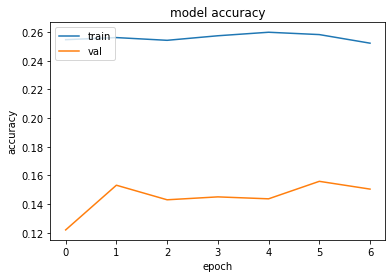

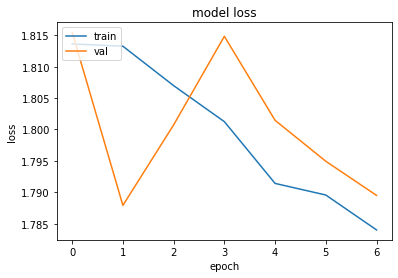

In [ ]:
history1_az = new_model_az1.fit(X1_az_sm, y1_az_df_sm, validation_data = (X_val_az_sm,y_val_az_sm),
               epochs=50,batch_size=64, callbacks =[cp_az1,early_stopping_monitor], verbose = False)

# summarize history for accuracy
plt.plot(history1_az.history['categorical_accuracy'])
plt.plot(history1_az.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history1_az.history['loss'])
plt.plot(history1_az.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

##### 2.objective : False Negative

In [ ]:
def build_model_az2(hp):
  model_az2 = Sequential()
  model_az2.add(BatchNormalization())
  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
  model_az2.add(Dense(units=hp_units1, activation= LeakyReLU))
  model_az2.add(Dropout(hp.Choice('dropout_1', values=[0.0, 0.1, 0.2, 0.3])))
  model_az2.add(BatchNormalization())
  model_az2.add(Dense(units=hp_units2, activation= LeakyReLU))
  model_az2.add(Dropout(hp.Choice('dropout_2', values=[0.0, 0.1, 0.2, 0.3])))
  model_az2.add(BatchNormalization())
  model_az2.add(Dense(units=hp_units3, activation= LeakyReLU))
  model_az2.add(Dropout(hp.Choice('dropout_3', values=[0.0, 0.1, 0.2, 0.3])))
  model_az2.add(BatchNormalization())
  model_az2.add(Dense(6, activation='softmax'))

  hp_optimizer_az=hp.Choice('Optimizer', values=['Adam', 'SGD'])
  if hp_optimizer_az == 'Adam':
    hp_learning_rate = hp.Choice('learning_rate_az', values=[1e-1, 1e-2, 1e-3])
  elif hp_optimizer_az == 'SGD':
    hp_learning_rate = hp.Choice('learning_rate_az', values=[1e-1, 1e-2, 1e-3])
    nesterov=True
    momentum=0.9

  model_az2.compile(
      optimizer= hp_optimizer_az,
      loss='categorical_crossentropy',
      metrics=[keras.metrics.FalseNegatives(name='false_negatives'),
               'categorical_accuracy']
  )
  return model_az2

# HyperBand algorithm from keras tuner
tuner_az2 = kt.Hyperband(
    build_model_az2,
    objective= kt.Objective('val_false_negatives', direction="min"),
    max_epochs=50,
    directory='az_dir2',
    project_name='coconino2',
    overwrite= True
)
early_stopping_monitor = EarlyStopping(patience=5)
tuner_az2.search(X1_az_sm, y1_az_df_sm, epochs=50, validation_data = (X_val_az_sm,y_val_az_sm),
             callbacks=[early_stopping_monitor])

Trial 90 Complete [00h 00m 24s]
val_false_negatives: 1180.0

Best val_false_negatives So Far: 893.0
Total elapsed time: 00h 30m 39s


In [ ]:
best_mlp_hyperparameters_az2 = tuner_az2.get_best_hyperparameters(1)[0]
print("Best Hyper-parameters")
best_mlp_hyperparameters_az2.values

Best Hyper-parameters


{'units1': 256,
 'units2': 480,
 'units3': 448,
 'dropout_1': 0.2,
 'dropout_2': 0.2,
 'dropout_3': 0.2,
 'Optimizer': 'Adam',
 'learning_rate_az': 0.1,
 'tuner/epochs': 50,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [ ]:
best_model_az2 = tuner_az2.get_best_models()[0]
best_model_az2.build(X1_az_sm.shape)
best_model_az2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (11010, 49)              196       
 ormalization)                                                   
                                                                 
 dense (Dense)               (11010, 256)              12800     
                                                                 
 dropout (Dropout)           (11010, 256)              0         
                                                                 
 batch_normalization_1 (Batc  (11010, 256)             1024      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (11010, 480)              123360    
                                                                 
 dropout_1 (Dropout)         (11010, 480)              0

In [ ]:
new_model_az2 = Sequential()
new_model_az2.add(tf.keras.Input(shape=(49,)))
new_model_az2.add(BatchNormalization())
new_model_az2.add(Dense(256, activation = LeakyReLU))
new_model_az2.add(Dropout(0.2))
new_model_az2.add(BatchNormalization())
new_model_az2.add(Dense(480, activation = LeakyReLU))
new_model_az2.add(Dropout(0.2))
new_model_az2.add(BatchNormalization())
new_model_az2.add(Dense(448, activation = LeakyReLU))
new_model_az2.add(Dropout(0.2))
new_model_az2.add(BatchNormalization())
new_model_az2.add((Dense(6, activation='softmax')))
new_model_az2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_4 (Batc  (None, 49)               196       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 256)               12800     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 batch_normalization_5 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 480)               123360    
                                                                 
 dropout_4 (Dropout)         (None, 480)              

In [ ]:
cp_az2 = ModelCheckpoint('new_model_az2/', save_best_only=True)
opt_az2 = keras.optimizers.Adam(learning_rate=0.1)
new_model_az2.compile(optimizer = opt_az2, loss ='categorical_crossentropy', metrics =['categorical_accuracy'])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)

new_model_az2.fit(X1_az_sm, y1_az_df_sm, validation_data = (X_val_az_sm,y_val_az_sm),
               epochs=50,batch_size=64, callbacks =[cp_az2,early_stopping_monitor])

Epoch 1/50
171/173 [============================>.] - ETA: 0s - loss: 2.5376 - categorical_accuracy: 0.2149

173/173 [==============================] - 8s 36ms/step - loss: 2.5327 - categorical_accuracy: 0.2156 - val_loss: 17.7034 - val_categorical_accuracy: 0.2000
Epoch 2/50
172/173 [============================>.] - ETA: 0s - loss: 1.7679 - categorical_accuracy: 0.2320

173/173 [==============================] - 5s 29ms/step - loss: 1.7678 - categorical_accuracy: 0.2321 - val_loss: 14.7017 - val_categorical_accuracy: 0.2000
Epoch 3/50
170/173 [============================>.] - ETA: 0s - loss: 1.8036 - categorical_accuracy: 0.2268

173/173 [==============================] - 5s 31ms/step - loss: 1.8028 - categorical_accuracy: 0.2274 - val_loss: 7.6954 - val_categorical_accuracy: 0.1146
Epoch 4/50
173/173 [==============================] - 2s 14ms/step - loss: 1.8423 - categorical_accuracy: 0.2385 - val_loss: 18.0306 - val_categorical_accuracy: 0.2034
Epoch 5/50
169/173 [============================>.] - ETA: 0s - loss: 2.2409 - categorical_accuracy: 0.2102

173/173 [==============================] - 5s 29ms/step - loss: 2.2378 - categorical_accuracy: 0.2122 - val_loss: 3.3425 - val_categorical_accuracy: 0.2197
Epoch 6/50
173/173 [==============================] - 2s 14ms/step - loss: 3.1552 - categorical_accuracy: 0.2154 - val_loss: 3.9007 - val_categorical_accuracy: 0.2115
Epoch 7/50
171/173 [============================>.] - ETA: 0s - loss: 2.5083 - categorical_accuracy: 0.2214

173/173 [==============================] - 5s 28ms/step - loss: 2.5054 - categorical_accuracy: 0.2215 - val_loss: 2.8121 - val_categorical_accuracy: 0.1458
Epoch 8/50
171/173 [============================>.] - ETA: 0s - loss: 2.2248 - categorical_accuracy: 0.2306

173/173 [==============================] - 6s 34ms/step - loss: 2.2222 - categorical_accuracy: 0.2306 - val_loss: 2.0759 - val_categorical_accuracy: 0.1607
Epoch 9/50
173/173 [==============================] - 2s 14ms/step - loss: 2.1674 - categorical_accuracy: 0.2371 - val_loss: 2.3331 - val_categorical_accuracy: 0.2251
Epoch 10/50
171/173 [============================>.] - ETA: 0s - loss: 1.9323 - categorical_accuracy: 0.2396

173/173 [==============================] - 5s 31ms/step - loss: 1.9312 - categorical_accuracy: 0.2394 - val_loss: 1.7930 - val_categorical_accuracy: 0.1864
Epoch 11/50
173/173 [==============================] - 2s 14ms/step - loss: 1.9053 - categorical_accuracy: 0.2279 - val_loss: 2.0033 - val_categorical_accuracy: 0.2129
Epoch 12/50
173/173 [==============================] - 2s 14ms/step - loss: 1.8813 - categorical_accuracy: 0.2361 - val_loss: 1.8629 - val_categorical_accuracy: 0.2197
Epoch 13/50
173/173 [==============================] - 2s 14ms/step - loss: 1.9868 - categorical_accuracy: 0.2390 - val_loss: 1.9002 - val_categorical_accuracy: 0.2197
Epoch 14/50
173/173 [==============================] - 2s 14ms/step - loss: 2.1514 - categorical_accuracy: 0.2289 - val_loss: 1.9812 - val_categorical_accuracy: 0.2597
Epoch 15/50
173/173 [==============================] - 2s 14ms/step - loss: 2.2672 - categorical_accuracy: 0.2340 - val_loss: 1.9589 - val_categorical_accuracy: 0.2041


In [ ]:
test_predictions_az2 = new_model_az2.predict(X_test_az)
test_predictions_az2

23/23 [==============================] - 0s 4ms/step


array([[0.34765613, 0.29826683, 0.0931416 , 0.19932158, 0.06048173,
        0.00113212],
       [0.3556045 , 0.34813276, 0.08332618, 0.18165375, 0.03048775,
        0.00079498],
       [0.31866664, 0.3008096 , 0.11423697, 0.17435642, 0.08988246,
        0.00204789],
       ...,
       [0.23865929, 0.19595122, 0.10840365, 0.20316198, 0.23938154,
        0.01444237],
       [0.2774666 , 0.26072806, 0.10304095, 0.19258249, 0.16287114,
        0.00331074],
       [0.25450134, 0.18542638, 0.10014338, 0.19636723, 0.25475836,
        0.00880335]], dtype=float32)

In [ ]:
classes_az2 = np.argmax(test_predictions_az2, axis=-1)
classes_az2

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 4, 4, 4, 0, 1, 0, 1, 1, 1, 1, 4, 0, 1,
       4, 1, 4, 1, 4, 4, 4, 4, 4, 4, 3, 3, 3, 0, 0, 0, 0, 0, 3, 0, 4, 4,
       3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 4, 4, 3, 4, 4, 3, 4, 4,
       3, 4, 4, 4, 3, 3, 0, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 0, 0, 0, 4, 0, 4, 4, 0, 0, 0, 4, 0, 0, 4, 0, 0,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 0, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4,

In [ ]:
classes_az2 =pd.DataFrame(classes_az2, columns=['Test Predictions']) 
classes_az2

Test Predictions
0                   0
1                   0
2                   0
3                   0
4                   0
..                ...
726                 4
727                 3
728                 4
729                 0
730                 4

[731 rows x 1 columns]

In [ ]:
classes_az2 = classes_az2.values.ravel()

In [ ]:
result_az2 = pd.DataFrame({'Test Predictions':classes_az2, 'Actuals':y_test_az})
result_az2[0:31]

Test Predictions  Actuals
0                  0        2
1                  0        2
2                  0        2
3                  0        2
4                  0        2
5                  0        2
6                  0        2
7                  1        2
8                  1        2
9                  4        2
10                 4        2
11                 4        2
12                 0        2
13                 1        2
14                 0        2
15                 1        2
16                 1        2
17                 1        2
18                 1        2
19                 4        2
20                 0        2
21                 1        2
22                 4        2
23                 1        2
24                 4        2
25                 1        2
26                 4        2
27                 4        2
28                 4        2
29                 4        2
30                 4        2

######model 2 evaluation

In [ ]:
print(classification_report(y_test_az, classes_az2))

              precision    recall  f1-score   support

           0       0.14      0.08      0.10       156
           1       0.02      0.01      0.01       166
           2       0.00      0.00      0.00       211
           3       0.21      0.12      0.15        77
           4       0.13      0.94      0.23        78
           5       0.00      0.00      0.00        43

    accuracy                           0.13       731
   macro avg       0.08      0.19      0.08       731
weighted avg       0.07      0.13      0.06       731



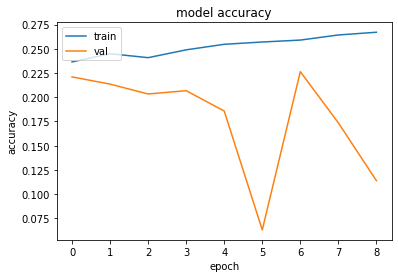

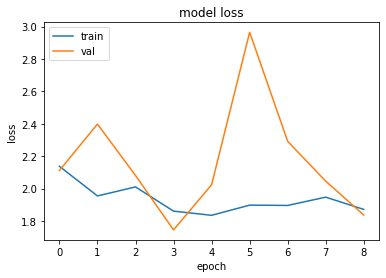

In [ ]:
history2_az = new_model_az2.fit(X1_az_sm, y1_az_df_sm, validation_data = (X_val_az_sm,y_val_az_sm),
               epochs=50,batch_size=64, callbacks =[cp_az2,early_stopping_monitor], verbose = False)

# summarize history for accuracy
plt.plot(history2_az.history['categorical_accuracy'])
plt.plot(history2_az.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2_az.history['loss'])
plt.plot(history2_az.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

####comparing the models

In [ ]:
plt.plot(history1_az.history['val_categorical_accuracy'], 'r', history2_az.history['val_categorical_accuracy'], 'b')
plt.xlabel('Epochs')
plt.ylabel('Val Accuracy')
plt.show()

In [ ]:
plt.plot(history1_az.history['val_loss'], 'r', history2_az.history['val_loss'], 'b')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.show()

###MLP model with weather and soil data (without date variable) REGRESSION

####preprocessing data

In [ ]:
score_az = train_az['score']
score_val_az = val_az['score']
score_test_az = test_az['score']

In [ ]:
score_arr_az = score_az.copy()
score_val_arr_az = score_val_az.copy()
score_test_arr_az = score_test_az.copy()

In [ ]:
score_arr_az = score_arr_az.to_numpy()
score_val_arr_az = score_val_arr_az.to_numpy()
score_test_arr_az = score_test_arr_az.to_numpy()

In [ ]:
score_arr_az =pd.DataFrame(score_arr_az, columns=['Score']) 
score_arr_az

Score
0     0.1082
1     0.1082
2     0.1082
3     0.1082
4     0.2356
...      ...
6205  0.4269
6206  0.4269
6207  0.4269
6208  0.4269
6209  0.4269

[6210 rows x 1 columns]

In [ ]:
score_val_arr_az =pd.DataFrame(score_val_arr_az, columns=['Score']) 
score_val_arr_az

Score
0    2.0000
1    2.0000
2    2.0000
3    2.0000
4    2.0000
..      ...
725  0.3505
726  0.3505
727  0.3505
728  0.3505
729  0.3505

[730 rows x 1 columns]

In [ ]:
score_test_arr_az =pd.DataFrame(score_test_arr_az, columns=['Score']) 
score_test_arr_az

Score
0    2.389300
1    2.386086
2    2.382871
3    2.379657
4    2.376443
..        ...
726  5.000000
727  5.000000
728  5.000000
729  5.000000
730  5.000000

[731 rows x 1 columns]

In [ ]:
coconino_train = train_az.copy()
coconino_val = val_az.copy()
coconino_test = test_az.copy()

In [ ]:
X1_az = coconino_train.drop(columns=['fips','date','score'])
X_az_val = coconino_val.drop(columns=['fips','date','score'])
X_az_test = coconino_test.drop(columns=['fips','date','score'])

In [ ]:
X1_az, y1_az = X1_az, score_arr_az
X_val_az, y_val_az = X_az_val, score_val_arr_az
X_test_az, y_test_az = X_az_test, score_test_arr_az
X1_az.shape, y1_az.shape, X_val_az.shape, y_val_az.shape, X_test_az.shape, y_test_az.shape

((6210, 49), (6210, 1), (730, 49), (730,), (731, 49), (731, 1))

####build the model

In [ ]:
new_model_reg_az1 = Sequential()
new_model_reg_az1.add(tf.keras.Input(shape=(49,)))
new_model_reg_az1.add(BatchNormalization())
new_model_reg_az1.add(Dense(128, activation = "elu", kernel_initializer="he_normal"))
new_model_reg_az1.add(BatchNormalization())
new_model_reg_az1.add(Dense(64, activation = "elu", kernel_initializer="he_normal"))
new_model_reg_az1.add(BatchNormalization())
new_model_reg_az1.add((Dense(1, activation='linear')))
new_model_reg_az1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_3 (Batc  (None, 49)               196       
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 128)               6400      
                                                                 
 batch_normalization_4 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_5 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                      

In [ ]:
opt_reg_az1 = keras.optimizers.Adam(learning_rate=0.001)
new_model_reg_az1.compile(optimizer = opt_reg_az1, loss =MeanSquaredError(), metrics =[RootMeanSquaredError()])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)

new_model_reg_az1.fit(X1_az, y1_az, validation_data = (X_val_az,y_val_az),
               epochs=50,batch_size=64, callbacks =[early_stopping_monitor])

Epoch 1/50
98/98 [==============================] - 4s 10ms/step - loss: 3.6578 - root_mean_squared_error: 1.9125 - val_loss: 12578.8428 - val_root_mean_squared_error: 112.1554
Epoch 2/50
98/98 [==============================] - 1s 7ms/step - loss: 1.7986 - root_mean_squared_error: 1.3411 - val_loss: 7433.3809 - val_root_mean_squared_error: 86.2171
Epoch 3/50
98/98 [==============================] - 1s 7ms/step - loss: 1.5661 - root_mean_squared_error: 1.2514 - val_loss: 3477.4021 - val_root_mean_squared_error: 58.9695
Epoch 4/50
98/98 [==============================] - 1s 7ms/step - loss: 1.5563 - root_mean_squared_error: 1.2475 - val_loss: 1274.5714 - val_root_mean_squared_error: 35.7011
Epoch 5/50
98/98 [==============================] - 1s 8ms/step - loss: 1.5306 - root_mean_squared_error: 1.2372 - val_loss: 466.3363 - val_root_mean_squared_error: 21.5948
Epoch 6/50
98/98 [==============================] - 1s 8ms/step - loss: 1.5173 - root_mean_squared_error: 1.2318 - val_loss: 132

In [ ]:
test_predictions_reg_az1 = new_model_reg_az1.predict(X_test_az).flatten()
test_predictions_reg_az1

23/23 [==============================] - 0s 2ms/step


array([1.5092044 , 1.3397607 , 1.3347124 , 1.5235766 , 1.684963  ,
       1.8783317 , 1.3101604 , 1.7251049 , 1.9293972 , 1.97904   ,
       1.837094  , 1.7813092 , 1.8125213 , 1.9442108 , 1.9238011 ,
       1.8324572 , 1.7590966 , 1.5149027 , 1.7117382 , 1.1875347 ,
       2.3607078 , 1.7757531 , 1.3910607 , 1.4635705 , 1.412558  ,
       1.6713227 , 1.6672437 , 1.7720598 , 1.7126927 , 1.8384151 ,
       2.0346615 , 1.8279617 , 1.9272623 , 2.0316865 , 2.032389  ,
       2.33445   , 1.9747558 , 1.3988796 , 1.6492671 , 2.0718386 ,
       1.6033766 , 1.3344883 , 1.6722797 , 2.163986  , 2.1223018 ,
       1.5771255 , 1.5445637 , 1.7215943 , 1.5395558 , 1.3932554 ,
       1.6704575 , 1.5019535 , 1.1040312 , 1.1059273 , 1.3815384 ,
       1.4144474 , 1.7060844 , 1.6674836 , 1.6696268 , 1.8539298 ,
       2.345264  , 1.8176916 , 1.528731  , 1.171336  , 2.129606  ,
       2.2396324 , 2.0191984 , 1.6921979 , 1.681232  , 1.60344   ,
       2.0991101 , 1.7724787 , 1.5976971 , 1.6286914 , 1.56287

In [ ]:
test_predictions_reg_az1 =pd.DataFrame(test_predictions_reg_az1, columns=['Test Predictions']) 
test_predictions_reg_az1

Test Predictions
0            1.509204
1            1.339761
2            1.334712
3            1.523577
4            1.684963
..                ...
726          1.794286
727          1.950981
728          1.875773
729          1.676318
730          1.554047

[731 rows x 1 columns]

In [ ]:
test_predictions_reg_az1 = test_predictions_reg_az1.values.ravel()
y_test_az = y_test_az.values.ravel()

In [ ]:
test_results_reg_az_1 = pd.DataFrame(data={'predictions':test_predictions_reg_az1, 'actuals':y_test_az})
test_results_reg_az_1

predictions   actuals
0       1.509204  2.389300
1       1.339761  2.386086
2       1.334712  2.382871
3       1.523577  2.379657
4       1.684963  2.376443
..           ...       ...
726     1.794286  5.000000
727     1.950981  5.000000
728     1.875773  5.000000
729     1.676318  5.000000
730     1.554047  5.000000

[731 rows x 2 columns]

In [ ]:
test_results_reg_az_1[500:550]

predictions   actuals
500     1.345461  1.150400
501     1.445849  1.150400
502     1.817756  1.150400
503     1.799357  1.150400
504     1.966181  1.150400
505     2.025895  1.150400
506     1.931123  1.150400
507     2.243982  1.150400
508     2.420150  1.150400
509     2.300151  1.150400
510     1.999181  1.150400
511     1.872325  1.150400
512     1.593116  1.150614
513     1.835395  1.150829
514     1.872262  1.151043
515     1.574986  1.151257
516     1.862230  1.151471
517     1.688684  1.151686
518     1.950135  1.151900
519     2.029139  1.150814
520     1.797516  1.149729
521     1.545772  1.148643
522     2.243032  1.147557
523     2.436563  1.146471
524     3.289495  1.145386
525     1.765172  1.144300
526     1.957658  1.144300
527     1.694579  1.144300
528     1.843450  1.144300
529     2.557204  1.144300
530     2.095920  1.144300
531     2.045582  1.144300
532     2.019229  1.144300
533     1.564117  1.144300
534     1.623448  1.144300
535     2.266531  1.144300
536     1.890915  1.144300
537     1.822901  1.144300
538     1.975807  1.144300
539     1.948878  1.144300
540     2.482611  1.144300
541     2.664939  1.144300
542     2.451876  1.144300
543     2.459401  1.144300
544     2.391840  1.144300
545     2.581177  1.144300
546     2.547153  1.144300
547     2.374661  1.144300
548     1.421020  1.144300
549     2.147131  1.144300

####model evaluation

In [ ]:
new_model_reg_az1.evaluate(X1_az,y1_az)

195/195 [==============================] - 1s 3ms/step - loss: 1.4528 - root_mean_squared_error: 1.2053


[1.4527595043182373, 1.205304741859436]

In [ ]:
new_model_reg_az1.evaluate(X_test_az,y_test_az)

23/23 [==============================] - 0s 3ms/step - loss: 2.0431 - root_mean_squared_error: 1.4294


[2.043116331100464, 1.429376244544983]

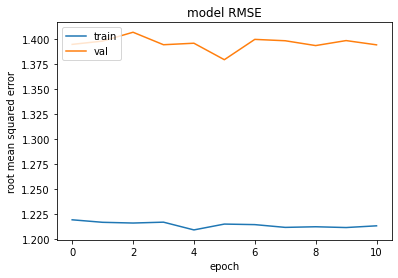

In [ ]:
history_reg_az_1 = new_model_reg_az1.fit(X1_az, y1_az, validation_data = (X_val_az,y_val_az),
               epochs=50,batch_size=64, callbacks =[early_stopping_monitor], verbose=False)

# summarize history for accuracy
plt.plot(history_reg_az_1.history['root_mean_squared_error'])
plt.plot(history_reg_az_1.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('root mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
test_results_reg_az_1.predictions[test_results_reg_az_1.predictions <0.5] = 0
test_results_reg_az_1.predictions[(test_results_reg_az_1.predictions >=0.5)&(test_results_reg_az_1.predictions<1.5)] = 1
test_results_reg_az_1.predictions[(test_results_reg_az_1.predictions >=1.5)&(test_results_reg_az_1.predictions<2.5)] = 2
test_results_reg_az_1.predictions[(test_results_reg_az_1.predictions >=2.5)&(test_results_reg_az_1.predictions<3.5)] = 3
test_results_reg_az_1.predictions[(test_results_reg_az_1.predictions >=3.5)&(test_results_reg_az_1.predictions<4.5)] = 4
test_results_reg_az_1.predictions[(test_results_reg_az_1.predictions >=4.5)&(test_results_reg_az_1.predictions<5.5)] = 5
test_results_reg_az_1.actuals[test_results_reg_az_1.actuals <0.5] = 0
test_results_reg_az_1.actuals[(test_results_reg_az_1.actuals >=0.5)&(test_results_reg_az_1.actuals<1.5)] = 1
test_results_reg_az_1.actuals[(test_results_reg_az_1.actuals >=1.5)&(test_results_reg_az_1.actuals<2.5)] = 2
test_results_reg_az_1.actuals[(test_results_reg_az_1.actuals >=2.5)&(test_results_reg_az_1.actuals<3.5)] = 3
test_results_reg_az_1.actuals[(test_results_reg_az_1.actuals >=3.5)&(test_results_reg_az_1.actuals<4.5)] = 4
test_results_reg_az_1.actuals[(test_results_reg_az_1.actuals >=4.5)&(test_results_reg_az_1.actuals<5.5)] = 5
test_results_reg_az_1

predictions  actuals
0            2.0      2.0
1            1.0      2.0
2            1.0      2.0
3            2.0      2.0
4            2.0      2.0
..           ...      ...
726          2.0      5.0
727          2.0      5.0
728          2.0      5.0
729          2.0      5.0
730          2.0      5.0

[731 rows x 2 columns]

In [ ]:
test_results_reg_az_1[200:250]

predictions  actuals
200          2.0      0.0
201          2.0      0.0
202          2.0      0.0
203          3.0      0.0
204          3.0      0.0
205          2.0      0.0
206          3.0      0.0
207          2.0      0.0
208          2.0      0.0
209          2.0      0.0
210          2.0      0.0
211          2.0      0.0
212          2.0      0.0
213          2.0      0.0
214          2.0      0.0
215          2.0      0.0
216          2.0      0.0
217          3.0      0.0
218          3.0      0.0
219          2.0      0.0
220          2.0      0.0
221          2.0      0.0
222          2.0      0.0
223          2.0      0.0
224          2.0      0.0
225          2.0      0.0
226          2.0      0.0
227          2.0      0.0
228          2.0      0.0
229          2.0      1.0
230          2.0      1.0
231          2.0      1.0
232          2.0      1.0
233          2.0      1.0
234          2.0      1.0
235          2.0      1.0
236          2.0      1.0
237          2.0      1.0
238          2.0      1.0
239          2.0      1.0
240          2.0      1.0
241          2.0      1.0
242          2.0      1.0
243          2.0      1.0
244          2.0      1.0
245          2.0      1.0
246          2.0      1.0
247          2.0      2.0
248          2.0      2.0
249          2.0      2.0

In [ ]:
print(classification_report(test_results_reg_az_1['actuals'], test_results_reg_az_1['predictions']))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       156
         1.0       0.26      0.13      0.17       166
         2.0       0.29      0.83      0.43       211
         3.0       0.17      0.09      0.12        77
         4.0       0.00      0.00      0.00        78
         5.0       0.00      0.00      0.00        43

    accuracy                           0.28       731
   macro avg       0.12      0.18      0.12       731
weighted avg       0.16      0.28      0.18       731



###LSTM model without weather and soil data, only using previous drought scores

In [ ]:
def df_to_X_y(df, window_size=7):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
WINDOW_SIZE = 7
X_train_az, y_train_az = df_to_X_y(score_az, WINDOW_SIZE)
X_val1_az, y_val1_az = df_to_X_y(score_val_az, WINDOW_SIZE)
X_test1_az, y_test1_az = df_to_X_y(score_test_az, WINDOW_SIZE)
X_train_az.shape, y_train_az.shape, X_val1_az.shape, y_val1_az.shape, X_test1_az.shape, y_test1_az.shape

((6203, 7, 1), (6203,), (723, 7, 1), (723,), (724, 7, 1), (724,))

In [ ]:
model_1 = Sequential()
model_1.add(InputLayer((7,1)))
model_1.add(LSTM(64))
model_1.add(Dense(8, 'relu'))
model_1.add(Dense(1, 'linear'))

model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)

model_1.fit(X_train_az, y_train_az, validation_data=(X_val1_az, y_val1_az), epochs=50, 
           callbacks = [early_stopping_monitor])

Epoch 1/50
194/194 [==============================] - 5s 10ms/step - loss: 1.6884 - root_mean_squared_error: 1.2994 - val_loss: 0.0677 - val_root_mean_squared_error: 0.2602
Epoch 2/50
194/194 [==============================] - 2s 8ms/step - loss: 0.0824 - root_mean_squared_error: 0.2871 - val_loss: 0.0371 - val_root_mean_squared_error: 0.1927
Epoch 3/50
194/194 [==============================] - 1s 7ms/step - loss: 0.0434 - root_mean_squared_error: 0.2082 - val_loss: 0.0292 - val_root_mean_squared_error: 0.1709
Epoch 4/50
194/194 [==============================] - 1s 7ms/step - loss: 0.0338 - root_mean_squared_error: 0.1838 - val_loss: 0.0291 - val_root_mean_squared_error: 0.1705
Epoch 5/50
194/194 [==============================] - 1s 7ms/step - loss: 0.0314 - root_mean_squared_error: 0.1773 - val_loss: 0.0283 - val_root_mean_squared_error: 0.1682
Epoch 6/50
194/194 [==============================] - 1s 7ms/step - loss: 0.0302 - root_mean_squared_error: 0.1737 - val_loss: 0.0272 - val

####using the model to predict the test dataset

In [ ]:
test_prediction_az_1 = model_1.predict(X_test1_az).flatten()
test_results_az_1 = pd.DataFrame(data={'predictions':test_prediction_az_1, 'actuals':y_test1_az})
test_results_az_1

23/23 [==============================] - 1s 3ms/step


predictions  actuals
0       2.015508      2.0
1       2.015508      2.0
2       2.015508      2.0
3       2.015508      2.0
4       2.015508      2.0
..           ...      ...
719     5.035133      5.0
720     5.035133      5.0
721     5.035133      5.0
722     5.035134      5.0
723     5.035134      5.0

[724 rows x 2 columns]

In [ ]:
test_results_az_1.predictions[test_results_az_1.predictions <0.5] = 0
test_results_az_1.predictions[(test_results_az_1.predictions >=0.5)&(test_results_az_1.predictions<1.5)] = 1
test_results_az_1.predictions[(test_results_az_1.predictions >=1.5)&(test_results_az_1.predictions<2.5)] = 2
test_results_az_1.predictions[(test_results_az_1.predictions >=2.5)&(test_results_az_1.predictions<3.5)] = 3
test_results_az_1.predictions[(test_results_az_1.predictions >=3.5)&(test_results_az_1.predictions<4.5)] = 4
test_results_az_1.predictions[(test_results_az_1.predictions >=4.5)&(test_results_az_1.predictions<5.5)] = 5
test_results_az_1

predictions  actuals
0            2.0      2.0
1            2.0      2.0
2            2.0      2.0
3            2.0      2.0
4            2.0      2.0
..           ...      ...
719          5.0      5.0
720          5.0      5.0
721          5.0      5.0
722          5.0      5.0
723          5.0      5.0

[724 rows x 2 columns]

In [ ]:
test_results_az_1.actuals[test_results_az_1.actuals <0.5] = 0
test_results_az_1.actuals[(test_results_az_1.actuals >=0.5)&(test_results_az_1.actuals<1.5)] = 1
test_results_az_1.actuals[(test_results_az_1.actuals >=1.5)&(test_results_az_1.actuals<2.5)] = 2
test_results_az_1.actuals[(test_results_az_1.actuals >=2.5)&(test_results_az_1.actuals<3.5)] = 3
test_results_az_1.actuals[(test_results_az_1.actuals >=3.5)&(test_results_az_1.actuals<4.5)] = 4
test_results_az_1.actuals[(test_results_az_1.actuals >=4.5)&(test_results_az_1.actuals<5.5)] = 5
test_results_az_1

predictions  actuals
0            2.0      2.0
1            2.0      2.0
2            2.0      2.0
3            2.0      2.0
4            2.0      2.0
..           ...      ...
719          5.0      5.0
720          5.0      5.0
721          5.0      5.0
722          5.0      5.0
723          5.0      5.0

[724 rows x 2 columns]

####model evaluation

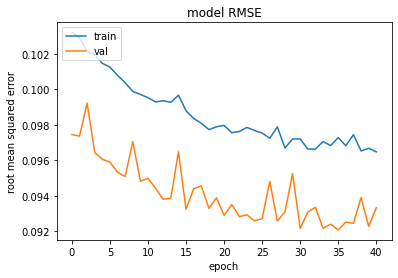

In [ ]:
history_az_1 = model_1.fit(X_train_az, y_train_az, validation_data=(X_val1_az, y_val1_az), epochs=50, 
           callbacks = [early_stopping_monitor], verbose = False)

# summarize history for accuracy
plt.plot(history_az_1.history['root_mean_squared_error'])
plt.plot(history_az_1.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('root mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
print(classification_report(test_results_az_1['actuals'], test_results_az_1['predictions']))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       156
         1.0       0.98      0.98      0.98       166
         2.0       0.98      0.99      0.98       204
         3.0       0.97      0.97      0.97        77
         4.0       0.99      0.99      0.99        78
         5.0       1.00      0.98      0.99        43

    accuracy                           0.98       724
   macro avg       0.99      0.98      0.98       724
weighted avg       0.98      0.98      0.98       724



###LSTM model with only score data and time data but the time data is transformed using sine and cosine

####train

In [ ]:
train_az1 = train_az.copy()
train_az1.index = pd.to_datetime(train_az1['date'], format='%Y.%m.%d')
train_az1[:31]

fips        date  PRECTOT     PS  QV2M   T2M  T2MDEW  T2MWET  \
date                                                                       
2000-01-01  4005  2000-01-01     3.91  80.61  3.28 -1.29   -4.81   -4.79   
2000-01-02  4005  2000-01-02     2.85  80.59  2.74 -3.71   -7.50   -7.40   
2000-01-03  4005  2000-01-03     0.41  81.64  1.47 -6.16  -13.91  -13.57   
2000-01-04  4005  2000-01-04     0.49  81.83  1.74 -4.09  -12.43  -12.11   
2000-01-05  4005  2000-01-05     0.48  81.24  2.23 -2.88   -9.41   -9.29   
2000-01-06  4005  2000-01-06     0.01  81.83  1.57 -5.81  -13.07  -12.79   
2000-01-07  4005  2000-01-07     0.04  81.71  1.59 -3.27  -13.05  -12.70   
2000-01-08  4005  2000-01-08     0.00  81.29  1.81 -2.24  -11.73  -11.46   
2000-01-09  4005  2000-01-09     0.75  81.24  1.91 -1.23  -11.07  -10.81   
2000-01-10  4005  2000-01-10     0.32  81.18  2.34  0.80   -8.92   -8.75   
2000-01-11  4005  2000-01-11     0.32  81.14  2.41  1.58   -8.40   -8.26   
2000-01-12  4005  2000-01-12     0.01  81.37  3.04  2.22   -5.77   -5.69   
2000-01-13  4005  2000-01-13     0.01  81.96  2.84  3.54   -6.50   -6.37   
2000-01-14  4005  2000-01-14     0.01  81.86  2.37  4.48   -8.62   -8.41   
2000-01-15  4005  2000-01-15     0.14  81.67  2.73  5.82   -7.02   -6.87   
2000-01-16  4005  2000-01-16     0.51  81.64  2.56  5.77   -7.70   -7.51   
2000-01-17  4005  2000-01-17     0.71  81.79  4.21  6.68   -1.80   -1.76   
2000-01-18  4005  2000-01-18     0.09  81.62  4.55  8.00   -0.41   -0.39   
2000-01-19  4005  2000-01-19     0.00  81.52  4.51  6.78   -0.54   -0.52   
2000-01-20  4005  2000-01-20     0.29  81.25  3.99  6.62   -2.20   -2.16   
2000-01-21  4005  2000-01-21     0.01  80.97  4.84  5.42    0.32    0.33   
2000-01-22  4005  2000-01-22     0.00  81.00  3.53  4.21   -4.26   -4.15   
2000-01-23  4005  2000-01-23     0.00  81.38  2.53  2.77   -7.84   -7.70   
2000-01-24  4005  2000-01-24     0.31  81.37  3.71  4.76   -3.32   -3.27   
2000-01-25  4005  2000-01-25     2.32  81.14  5.21  5.25    1.39    1.40   
2000-01-26  4005  2000-01-26     2.56  80.67  4.37  2.46   -1.43   -1.40   
2000-01-27  4005  2000-01-27     0.12  81.21  2.28 -0.22   -9.13   -8.95   
2000-01-28  4005  2000-01-28     0.00  81.35  1.73 -1.88  -12.13  -11.80   
2000-01-29  4005  2000-01-29     0.01  81.32  1.57 -1.42  -13.26  -12.78   
2000-01-30  4005  2000-01-30     0.72  81.18  2.15  0.42   -9.99   -9.74   
2000-01-31  4005  2000-01-31     0.91  81.21  3.47  0.80   -4.12   -4.09   

            T2M_MAX  T2M_MIN  T2M_RANGE    TS  WS10M  WS10M_MAX  WS10M_MIN  \
date                                                                         
2000-01-01     2.95    -4.15       7.09 -1.60   4.80       8.89       2.66   
2000-01-02     0.23    -9.18       9.41 -4.35   4.67       7.33       2.98   
2000-01-03     0.36   -10.43      10.79 -7.25   3.62       6.42       2.44   
2000-01-04     3.21   -10.82      14.03 -5.44   2.30       3.58       1.70   
2000-01-05     3.71    -7.09      10.81 -4.17   3.21       4.69       2.22   
2000-01-06     0.42   -10.62      11.04 -6.38   4.26       7.44       2.62   
2000-01-07     5.20   -10.14      15.34 -5.50   1.73       2.99       0.25   
2000-01-08     6.17    -8.16      14.33 -3.77   2.49       4.24       0.62   
2000-01-09     7.47    -7.41      14.88 -2.19   3.65       6.67       1.95   
2000-01-10     9.62    -5.48      15.09 -0.59   3.83       5.99       2.69   
2000-01-11    10.59    -3.59      14.18  0.56   4.21       6.37       2.53   
2000-01-12    10.31    -2.43      12.74  0.98   3.92       5.62       2.60   
2000-01-13    12.71    -1.22      13.93  1.08   1.85       2.93       0.50   
2000-01-14    13.01    -1.11      14.12  1.35   2.04       2.76       1.25   
2000-01-15    15.57     1.24      14.33  2.90   2.68       3.72       1.37   
2000-01-16    14.72    -0.99      15.71  3.98   4.10       7.78       2.43   
2000-01-17    13.76     1.15      12.61  5.23   3.89       7.86       0.92   
2000-01-18    17.16  

In [ ]:
scoreaz = train_az1['score']
scoreaz_df = pd.DataFrame({'score':scoreaz})
scoreaz_df['Seconds'] = scoreaz_df.index.map(pd.Timestamp.timestamp)
scoreaz_df

score       Seconds
date                           
2000-01-01    0.0  9.466848e+08
2000-01-02    0.0  9.467712e+08
2000-01-03    0.0  9.468576e+08
2000-01-04    0.0  9.469440e+08
2000-01-05    0.0  9.470304e+08
...           ...           ...
2016-12-27    0.0  1.482797e+09
2016-12-28    0.0  1.482883e+09
2016-12-29    0.0  1.482970e+09
2016-12-30    0.0  1.483056e+09
2016-12-31    0.0  1.483142e+09

[6210 rows x 2 columns]

In [ ]:
day = 60*60*24
month = 30.437*day
year = 365.2425*day

scoreaz_df['Day sin'] = np.sin(scoreaz_df['Seconds'] * (2* np.pi / day))
scoreaz_df['Day cos'] = np.cos(scoreaz_df['Seconds'] * (2 * np.pi / day))
scoreaz_df['Month sin'] = np.sin(scoreaz_df['Seconds'] * (2* np.pi / month))
scoreaz_df['Month cos'] = np.cos(scoreaz_df['Seconds'] * (2 * np.pi / month))
scoreaz_df['Year sin'] = np.sin(scoreaz_df['Seconds'] * (2 * np.pi / year))
scoreaz_df['Year cos'] = np.cos(scoreaz_df['Seconds'] * (2 * np.pi / year))
scoreaz_df.head()

score      Seconds       Day sin  Day cos  Month sin  Month cos  \
date                                                                          
2000-01-01    0.0  946684800.0 -5.461913e-12      1.0  -0.066010   0.997819   
2000-01-02    0.0  946771200.0 -1.163374e-12      1.0   0.139914   0.990164   
2000-01-03    0.0  946857600.0  3.135164e-12      1.0   0.339896   0.940463   
2000-01-04    0.0  946944000.0 -7.118212e-12      1.0   0.525446   0.850827   
2000-01-05    0.0  947030400.0 -2.819674e-12      1.0   0.688683   0.725062   

            Year sin  Year cos  
date                            
2000-01-01 -0.004731  0.999989  
2000-01-02  0.012472  0.999922  
2000-01-03  0.029670  0.999560  
2000-01-04  0.046860  0.998901  
2000-01-05  0.064036  0.997948

In [ ]:
scoreaz_df = scoreaz_df.drop('Seconds', axis=1)
scoreaz_df.head()

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2000-01-01    0.0 -5.461913e-12      1.0  -0.066010   0.997819 -0.004731   
2000-01-02    0.0 -1.163374e-12      1.0   0.139914   0.990164  0.012472   
2000-01-03    0.0  3.135164e-12      1.0   0.339896   0.940463  0.029670   
2000-01-04    0.0 -7.118212e-12      1.0   0.525446   0.850827  0.046860   
2000-01-05    0.0 -2.819674e-12      1.0   0.688683   0.725062  0.064036   

            Year cos  
date                  
2000-01-01  0.999989  
2000-01-02  0.999922  
2000-01-03  0.999560  
2000-01-04  0.998901  
2000-01-05  0.997948

####val

In [ ]:
val_az1 = val_az.copy()
val_az1.index = pd.to_datetime(val_az1['date'], format='%Y.%m.%d')
val_az1[:31]

fips        date  PRECTOT     PS  QV2M   T2M  T2MDEW  T2MWET  \
date                                                                       
2017-01-01  4005  2017-01-01     3.18  80.25  4.61  1.17   -0.41   -0.40   
2017-01-02  4005  2017-01-02     0.14  80.70  4.01 -0.33   -2.18   -2.17   
2017-01-03  4005  2017-01-03     0.00  81.17  4.04  0.47   -2.02   -2.02   
2017-01-04  4005  2017-01-04     0.06  80.91  4.19  1.96   -1.72   -1.71   
2017-01-05  4005  2017-01-05     4.01  80.40  5.57  3.96    2.20    2.20   
2017-01-06  4005  2017-01-06     2.19  81.11  1.95 -4.53  -11.80  -11.42   
2017-01-07  4005  2017-01-07     0.11  81.69  2.43 -1.27   -8.80   -8.62   
2017-01-08  4005  2017-01-08     1.11  81.84  4.71  3.66   -0.13   -0.11   
2017-01-09  4005  2017-01-09     4.25  81.31  5.38  3.51    1.86    1.86   
2017-01-10  4005  2017-01-10     0.61  80.94  4.59  3.63   -0.43   -0.41   
2017-01-11  4005  2017-01-11     0.03  80.68  4.54  3.21   -0.60   -0.59   
2017-01-12  4005  2017-01-12     0.69  80.85  4.76  3.25    0.10    0.11   
2017-01-13  4005  2017-01-13     1.68  81.19  4.60  1.87   -0.28   -0.28   
2017-01-14  4005  2017-01-14    13.63  81.20  4.81  2.04    0.30    0.31   
2017-01-15  4005  2017-01-15     1.27  80.83  4.10  0.55   -1.89   -1.89   
2017-01-16  4005  2017-01-16     0.22  81.01  3.30 -0.78   -4.81   -4.77   
2017-01-17  4005  2017-01-17     0.00  81.23  2.80 -0.89   -6.82   -6.75   
2017-01-18  4005  2017-01-18     0.00  81.12  3.19  0.60   -5.08   -5.03   
2017-01-19  4005  2017-01-19     6.13  80.48  3.99  0.08   -2.35   -2.34   
2017-01-20  4005  2017-01-20     7.07  79.75  3.85 -0.99   -2.88   -2.87   
2017-01-21  4005  2017-01-21     4.11  79.89  3.38 -2.31   -4.61   -4.60   
2017-01-22  4005  2017-01-22     2.92  80.95  3.26 -2.21   -5.01   -4.99   
2017-01-23  4005  2017-01-23     5.04  80.14  3.96 -0.59   -2.46   -2.46   
2017-01-24  4005  2017-01-24     4.42  80.28  2.79 -4.78   -6.90   -6.87   
2017-01-25  4005  2017-01-25     0.02  81.15  1.97 -7.31  -10.73  -10.66   
2017-01-26  4005  2017-01-26     0.00  81.52  1.67 -7.68  -12.55  -12.39   
2017-01-27  4005  2017-01-27     0.00  81.98  1.52 -8.26  -13.51  -13.29   
2017-01-28  4005  2017-01-28     0.00  82.36  1.86 -5.54  -11.47  -11.29   
2017-01-29  4005  2017-01-29     0.00  82.24  2.44 -2.65   -8.32   -8.23   
2017-01-30  4005  2017-01-30     0.00  81.81  2.79  0.24   -6.72   -6.65   
2017-01-31  4005  2017-01-31     0.00  81.48  2.89  3.71   -6.37   -6.26   

            T2M_MAX  T2M_MIN  T2M_RANGE    TS  WS10M  WS10M_MAX  WS10M_MIN  \
date                                                                         
2017-01-01     6.35    -0.99       7.34  0.91   3.31       5.47       0.65   
2017-01-02     2.23    -2.39       4.62 -0.57   7.72      10.29       4.96   
2017-01-03     5.57    -2.37       7.94  0.36   3.67       5.59       2.50   
2017-01-04     8.99    -2.88      11.87  1.60   6.27      10.30       3.45   
2017-01-05     7.86     1.06       6.80  3.76   9.42      11.72       7.46   
2017-01-06     1.50    -8.88      10.38 -4.26   4.15       6.68       2.18   
2017-01-07     5.24    -6.54      11.78 -1.87   2.21       3.78       0.61   
2017-01-08    12.35    -0.92      13.28  2.76   3.85       6.19       2.30   
2017-01-09     6.85     0.54       6.32  2.82   6.90       9.51       4.41   
2017-01-10     8.52     1.25       7.26  3.42   6.92       9.34       5.43   
2017-01-11     7.92     0.23       7.69  3.27   7.86      10.83       4.43   
2017-01-12     7.44     1.20       6.25  2.94   3.78       8.17       0.93   
2017-01-13     6.07    -1.21       7.29  1.32   2.65       4.48       1.28   
2017-01-14     7.82    -0.67       8.49  2.25   3.67       5.49       1.73   
2017-01-15     6.18    -3.15       9.34  0.39   2.29       3.20       1.34   
2017-01-16     4.55    -4.15       8.70 -0.90   2.53       3.99       1.10   
2017-01-17     6.25    -5.13      11.38 -1.49   2.16       3.50       0.64   
2017-01-18     8.41  

In [ ]:
scoreaz_val = val_az1['score']
scoreaz_val_df = pd.DataFrame({'score':scoreaz_val})
scoreaz_val_df['Seconds'] = scoreaz_val_df.index.map(pd.Timestamp.timestamp)
scoreaz_val_df

score       Seconds
date                           
2017-01-01    0.0  1.483229e+09
2017-01-02    0.0  1.483315e+09
2017-01-03    0.0  1.483402e+09
2017-01-04    0.0  1.483488e+09
2017-01-05    0.0  1.483574e+09
...           ...           ...
2018-12-27    2.0  1.545869e+09
2018-12-28    2.0  1.545955e+09
2018-12-29    2.0  1.546042e+09
2018-12-30    2.0  1.546128e+09
2018-12-31    2.0  1.546214e+09

[730 rows x 2 columns]

In [ ]:
scoreaz_val_df['Day sin'] = np.sin(scoreaz_val_df['Seconds'] * (2* np.pi / day))
scoreaz_val_df['Day cos'] = np.cos(scoreaz_val_df['Seconds'] * (2 * np.pi / day))
scoreaz_val_df['Month sin'] = np.sin(scoreaz_val_df['Seconds'] * (2* np.pi / month))
scoreaz_val_df['Month cos'] = np.cos(scoreaz_val_df['Seconds'] * (2 * np.pi / month))
scoreaz_val_df['Year sin'] = np.sin(scoreaz_val_df['Seconds'] * (2 * np.pi / year))
scoreaz_val_df['Year cos'] = np.cos(scoreaz_val_df['Seconds'] * (2 * np.pi / year))
scoreaz_val_df.head()

score       Seconds       Day sin  Day cos  Month sin  Month cos  \
date                                                                           
2017-01-01    0.0  1.483229e+09  2.504006e-13      1.0   0.109601   0.993976   
2017-01-02    0.0  1.483315e+09 -1.000298e-11      1.0   0.311009   0.950407   
2017-01-03    0.0  1.483402e+09 -5.704437e-12      1.0   0.499210   0.866481   
2017-01-04    0.0  1.483488e+09 -1.405899e-12      1.0   0.666213   0.745761   
2017-01-05    0.0  1.483574e+09 -1.165928e-11      1.0   0.804927   0.593374   

            Year sin  Year cos  
date                            
2017-01-01  0.010364  0.999946  
2017-01-02  0.027564  0.999620  
2017-01-03  0.044755  0.998998  
2017-01-04  0.061933  0.998080  
2017-01-05  0.079093  0.996867

In [ ]:
scoreaz_val_df = scoreaz_val_df.drop('Seconds', axis=1)
scoreaz_val_df.head()

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2017-01-01    0.0  2.504006e-13      1.0   0.109601   0.993976  0.010364   
2017-01-02    0.0 -1.000298e-11      1.0   0.311009   0.950407  0.027564   
2017-01-03    0.0 -5.704437e-12      1.0   0.499210   0.866481  0.044755   
2017-01-04    0.0 -1.405899e-12      1.0   0.666213   0.745761  0.061933   
2017-01-05    0.0 -1.165928e-11      1.0   0.804927   0.593374  0.079093   

            Year cos  
date                  
2017-01-01  0.999946  
2017-01-02  0.999620  
2017-01-03  0.998998  
2017-01-04  0.998080  
2017-01-05  0.996867

####test

In [ ]:
test_az1 = test_az.copy()
test_az1.index = pd.to_datetime(test_az1['date'], format='%Y.%m.%d')
test_az1[:31]

fips        date  PRECTOT     PS  QV2M    T2M  T2MDEW  T2MWET  \
date                                                                        
2019-01-01  4005  2019-01-01     0.05  80.84  1.33 -10.24  -16.21  -14.70   
2019-01-02  4005  2019-01-02     0.00  81.23  1.29 -10.52  -16.55  -15.06   
2019-01-03  4005  2019-01-03     0.00  81.48  1.78  -5.47  -12.62  -12.04   
2019-01-04  4005  2019-01-04     0.00  81.33  2.51  -2.58   -8.29   -8.04   
2019-01-05  4005  2019-01-05     1.16  81.05  3.08  -0.69   -5.67   -5.58   
2019-01-06  4005  2019-01-06     6.79  80.81  4.02  -0.49   -2.21   -2.15   
2019-01-07  4005  2019-01-07     0.26  81.43  3.86   0.19   -2.65   -2.59   
2019-01-08  4005  2019-01-08     0.00  81.74  3.70  -0.40   -3.15   -3.06   
2019-01-09  4005  2019-01-09     0.00  81.58  3.66   2.77   -3.29   -3.26   
2019-01-10  4005  2019-01-10     0.67  81.28  4.10   3.38   -1.81   -1.81   
2019-01-11  4005  2019-01-11     0.02  81.27  3.21   0.10   -5.09   -5.00   
2019-01-12  4005  2019-01-12     0.40  81.24  2.98  -0.74   -6.05   -5.81   
2019-01-13  4005  2019-01-13     2.87  81.19  3.36  -1.33   -4.53   -4.38   
2019-01-14  4005  2019-01-14     2.44  81.37  4.33   0.33   -1.13   -1.16   
2019-01-15  4005  2019-01-15    20.88  81.14  4.91   0.89    0.57    0.58   
2019-01-16  4005  2019-01-16     2.82  81.44  4.73   1.42    0.10    0.14   
2019-01-17  4005  2019-01-17     4.57  81.35  4.94   2.11    0.68    0.59   
2019-01-18  4005  2019-01-18     2.88  81.43  3.92   2.11   -2.39   -3.03   
2019-01-19  4005  2019-01-19     0.00  81.93  2.67   1.31   -7.43   -7.05   
2019-01-20  4005  2019-01-20     0.00  81.35  3.06   3.51   -5.77   -5.55   
2019-01-21  4005  2019-01-21     0.68  80.39  3.10   0.20   -5.68   -5.60   
2019-01-22  4005  2019-01-22     0.00  81.25  1.98  -2.84  -11.35  -10.49   
2019-01-23  4005  2019-01-23     0.00  81.63  2.08  -0.94  -10.68   -9.92   
2019-01-24  4005  2019-01-24     0.00  81.59  2.66   0.66   -7.52   -7.14   
2019-01-25  4005  2019-01-25     0.00  81.56  2.17  -0.13  -10.18   -9.41   
2019-01-26  4005  2019-01-26     0.00  81.82  2.27   0.26   -9.58   -8.86   
2019-01-27  4005  2019-01-27     0.00  81.58  2.74   3.01   -7.22   -6.79   
2019-01-28  4005  2019-01-28     0.00  81.31  2.61   2.59   -7.90   -7.37   
2019-01-29  4005  2019-01-29     0.00  81.05  2.36   1.29   -9.23   -8.57   
2019-01-30  4005  2019-01-30     0.00  80.97  2.48   2.04   -8.59   -8.22   
2019-01-31  4005  2019-01-31     0.00  80.99  3.90   4.81   -2.54   -2.54   

            T2M_MAX  T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  \
date                                                                          
2019-01-01    -6.26   -13.84       7.58 -10.48   4.15       6.08       2.69   
2019-01-02    -3.54   -15.51      11.97 -11.24   4.60       7.73       1.79   
2019-01-03     1.28   -11.34      12.62  -6.98   2.07       3.44       1.30   
2019-01-04     5.72    -9.29      15.02  -4.34   2.44       3.14       1.76   
2019-01-05     3.15    -4.31       7.46  -2.40   2.46       3.37       1.55   
2019-01-06     3.39    -3.41       6.80  -0.74   4.87       9.33       2.31   
2019-01-07     6.34    -3.53       9.88  -1.11   3.61       5.76       0.29   
2019-01-08     6.34    -4.75      11.09  -1.28   3.24       5.29       1.80   
2019-01-09    10.44    -1.63      12.07   0.18   1.78       2.29       1.12   
2019-01-10    10.51    -0.32      10.83   0.84   1.48       3.29       0.27   
2019-01-11     5.99    -2.68       8.67  -0.74   2.54       4.54       1.46   
2019-01-12     4.55    -4.03       8.57  -0.86   2.83       4.21       1.35   
2019-01-13     3.30    -3.80       7.10  -0.95   3.41       4.42       2.49   
2019-01-14     6.66    -3.26       9.91   0.25   2.78       4.09       2.02   
2019-01-15     4.07    -0.99       5.06   0.49   3.63       5.65       2.56   
2019-01-16     7.26    -1.50       8.76   0.78   4.28       6.58       2.60   
2019-01-17     7.62    -2.88      10.50   1.99  

In [ ]:
scoreaz_test = test_az1['score']
scoreaz_test_df = pd.DataFrame({'score':scoreaz_test})
scoreaz_test_df['Seconds'] = scoreaz_test_df.index.map(pd.Timestamp.timestamp)
scoreaz_test_df

score       Seconds
date                           
2019-01-01    2.0  1.546301e+09
2019-01-02    2.0  1.546387e+09
2019-01-03    2.0  1.546474e+09
2019-01-04    2.0  1.546560e+09
2019-01-05    2.0  1.546646e+09
...           ...           ...
2020-12-27    5.0  1.609027e+09
2020-12-28    5.0  1.609114e+09
2020-12-29    5.0  1.609200e+09
2020-12-30    5.0  1.609286e+09
2020-12-31    5.0  1.609373e+09

[731 rows x 2 columns]

In [ ]:
scoreaz_test_df['Day sin'] = np.sin(scoreaz_test_df['Seconds'] * (2* np.pi / day))
scoreaz_test_df['Day cos'] = np.cos(scoreaz_test_df['Seconds'] * (2 * np.pi / day))
scoreaz_test_df['Month sin'] = np.sin(scoreaz_test_df['Seconds'] * (2* np.pi / month))
scoreaz_test_df['Month cos'] = np.cos(scoreaz_test_df['Seconds'] * (2 * np.pi / month))
scoreaz_test_df['Year sin'] = np.sin(scoreaz_test_df['Seconds'] * (2 * np.pi / year))
scoreaz_test_df['Year cos'] = np.cos(scoreaz_test_df['Seconds'] * (2 * np.pi / year))
scoreaz_test_df.head()

score       Seconds       Day sin  Day cos  Month sin  Month cos  \
date                                                                           
2019-01-01    2.0  1.546301e+09 -5.030095e-12      1.0   0.009083   0.999959   
2019-01-02    2.0  1.546387e+09 -7.315560e-13      1.0   0.213851   0.976866   
2019-01-03    2.0  1.546474e+09 -1.098493e-11      1.0   0.409538   0.912293   
2019-01-04    2.0  1.546560e+09 -6.686394e-12      1.0   0.587835   0.808981   
2019-01-05    2.0  1.546646e+09 -2.387855e-12      1.0   0.741171   0.671316   

            Year sin  Year cos  
date                            
2019-01-01  0.002021  0.999998  
2019-01-02  0.019223  0.999815  
2019-01-03  0.036419  0.999337  
2019-01-04  0.053604  0.998562  
2019-01-05  0.070773  0.997492

In [ ]:
scoreaz_test_df = scoreaz_test_df.drop('Seconds', axis=1)
scoreaz_test_df.head()

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2019-01-01    2.0 -5.030095e-12      1.0   0.009083   0.999959  0.002021   
2019-01-02    2.0 -7.315560e-13      1.0   0.213851   0.976866  0.019223   
2019-01-03    2.0 -1.098493e-11      1.0   0.409538   0.912293  0.036419   
2019-01-04    2.0 -6.686394e-12      1.0   0.587835   0.808981  0.053604   
2019-01-05    2.0 -2.387855e-12      1.0   0.741171   0.671316  0.070773   

            Year cos  
date                  
2019-01-01  0.999998  
2019-01-02  0.999815  
2019-01-03  0.999337  
2019-01-04  0.998562  
2019-01-05  0.997492

In [ ]:
def df_to_X_y2(df, window_size=7):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
WINDOW_SIZE = 7
X_train_az2, y_train_az2 = df_to_X_y2(scoreaz_df, WINDOW_SIZE)
X_val1_az2, y_val1_az2 = df_to_X_y2(scoreaz_val_df, WINDOW_SIZE)
X_test1_az2, y_test1_az2 = df_to_X_y2(scoreaz_test_df, WINDOW_SIZE)
X_train_az2.shape, y_train_az2.shape, X_val1_az2.shape, y_val1_az2.shape, X_test1_az2.shape, y_test1_az2.shape

((6203, 7, 7), (6203,), (723, 7, 7), (723,), (724, 7, 7), (724,))

In [ ]:
temp_training_mean = np.mean(X_train_az2[:, :, 0])
temp_training_std = np.std(X_train_az2[:, :, 0])
                           
def preprocess(X):
  X[:, :, 0] = (X[:, :, 0] - temp_training_mean) / temp_training_std
  return X

In [ ]:
preprocess(X_train_az2)
preprocess(X_val1_az2)
preprocess(X_test1_az2)

array([[[ 1.05625431e-01, -5.03009464e-12,  1.00000000e+00, ...,
          9.99958750e-01,  2.02132493e-03,  9.99997957e-01],
        [ 1.05625431e-01, -7.31556020e-13,  1.00000000e+00, ...,
          9.76866282e-01,  1.92229193e-02,  9.99815223e-01],
        [ 1.05625431e-01, -1.09849326e-11,  1.00000000e+00, ...,
          9.12292898e-01,  3.64188251e-02,  9.99336615e-01],
        ...,
        [ 1.05625431e-01, -2.38785538e-12,  1.00000000e+00, ...,
          6.71316340e-01,  7.07732190e-02,  9.97492432e-01],
        [ 1.05625431e-01, -1.26412320e-11,  1.00000000e+00, ...,
          5.05145814e-01,  8.79215407e-02,  9.96127403e-01],
        [ 1.05625431e-01, -8.34269337e-12,  1.00000000e+00, ...,
          3.17525155e-01,  1.05043844e-01,  9.94467592e-01]],

       [[ 1.05625431e-01, -7.31556020e-13,  1.00000000e+00, ...,
          9.76866282e-01,  1.92229193e-02,  9.99815223e-01],
        [ 1.05625431e-01, -1.09849326e-11,  1.00000000e+00, ...,
          9.12292898e-01,  3.64188251e

In [ ]:
model_2 = Sequential()
model_2.add(InputLayer((7, 7)))
model_2.add(LSTM(64))
model_2.add(Dense(8, 'relu'))
model_2.add(Dense(1, 'linear'))

model_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                18432     
                                                                 
 dense_6 (Dense)             (None, 8)                 520       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 18,961
Trainable params: 18,961
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)
model_2.fit(X_train_az2, y_train_az2, validation_data=(X_val1_az2, y_val1_az2), epochs=50, callbacks=[early_stopping_monitor])

Epoch 1/50
194/194 [==============================] - 5s 10ms/step - loss: 3.1900 - root_mean_squared_error: 1.7861 - val_loss: 0.6391 - val_root_mean_squared_error: 0.7994
Epoch 2/50
194/194 [==============================] - 1s 7ms/step - loss: 0.1195 - root_mean_squared_error: 0.3456 - val_loss: 0.0524 - val_root_mean_squared_error: 0.2288
Epoch 3/50
194/194 [==============================] - 1s 7ms/step - loss: 0.0433 - root_mean_squared_error: 0.2081 - val_loss: 0.0441 - val_root_mean_squared_error: 0.2099
Epoch 4/50
194/194 [==============================] - 1s 7ms/step - loss: 0.0395 - root_mean_squared_error: 0.1987 - val_loss: 0.0401 - val_root_mean_squared_error: 0.2003
Epoch 5/50
194/194 [==============================] - 2s 9ms/step - loss: 0.0363 - root_mean_squared_error: 0.1905 - val_loss: 0.0359 - val_root_mean_squared_error: 0.1895
Epoch 6/50
194/194 [==============================] - 1s 7ms/step - loss: 0.0338 - root_mean_squared_error: 0.1839 - val_loss: 0.0342 - val

####using the model to predict the test dataset

In [ ]:
test_prediction_az_2 = model_2.predict(X_test1_az2).flatten()
test_results_az_2 = pd.DataFrame(data={'predictions':test_prediction_az_2, 'actuals':y_test1_az2})
test_results_az_2

23/23 [==============================] - 1s 3ms/step


predictions  actuals
0       1.980420      2.0
1       1.987153      2.0
2       1.984622      2.0
3       1.976167      2.0
4       1.970613      2.0
..           ...      ...
719     4.941996      5.0
720     4.936432      5.0
721     4.930279      5.0
722     4.923142      5.0
723     4.914622      5.0

[724 rows x 2 columns]

In [ ]:
test_results_az_2.predictions[test_results_az_2.predictions <0.5] = 0
test_results_az_2.predictions[(test_results_az_2.predictions >=0.5)&(test_results_az_2.predictions<1.5)] = 1
test_results_az_2.predictions[(test_results_az_2.predictions >=1.5)&(test_results_az_2.predictions<2.5)] = 2
test_results_az_2.predictions[(test_results_az_2.predictions >=2.5)&(test_results_az_2.predictions<3.5)] = 3
test_results_az_2.predictions[(test_results_az_2.predictions >=3.5)&(test_results_az_2.predictions<4.5)] = 4
test_results_az_2.predictions[(test_results_az_2.predictions >=4.5)&(test_results_az_2.predictions<5.5)] = 5
test_results_az_2.actuals[test_results_az_2.actuals <0.5] = 0
test_results_az_2.actuals[(test_results_az_2.actuals >=0.5)&(test_results_az_2.actuals<1.5)] = 1
test_results_az_2.actuals[(test_results_az_2.actuals >=1.5)&(test_results_az_2.actuals<2.5)] = 2
test_results_az_2.actuals[(test_results_az_2.actuals >=2.5)&(test_results_az_2.actuals<3.5)] = 3
test_results_az_2.actuals[(test_results_az_2.actuals >=3.5)&(test_results_az_2.actuals<4.5)] = 4
test_results_az_2.actuals[(test_results_az_2.actuals >=4.5)&(test_results_az_2.actuals<5.5)] = 5
test_results_az_2

predictions  actuals
0            2.0      2.0
1            2.0      2.0
2            2.0      2.0
3            2.0      2.0
4            2.0      2.0
..           ...      ...
719          5.0      5.0
720          5.0      5.0
721          5.0      5.0
722          5.0      5.0
723          5.0      5.0

[724 rows x 2 columns]

####model evaluation

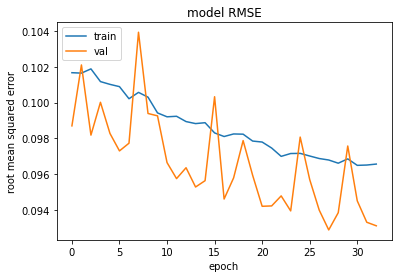

In [ ]:
history_az_2 = model_2.fit(X_train_az2, y_train_az2, validation_data=(X_val1_az2, y_val1_az2), epochs=50, callbacks=[early_stopping_monitor],verbose=False)

# summarize history for rmse
plt.plot(history_az_2.history['root_mean_squared_error'])
plt.plot(history_az_2.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('root mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
print(classification_report(test_results_az_2['actuals'], test_results_az_2['predictions']))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       156
         1.0       0.98      0.98      0.98       166
         2.0       0.98      0.99      0.98       204
         3.0       0.97      0.97      0.97        77
         4.0       0.99      0.99      0.99        78
         5.0       1.00      0.98      0.99        43

    accuracy                           0.98       724
   macro avg       0.99      0.98      0.98       724
weighted avg       0.98      0.98      0.98       724



###comparing all the LSTM models

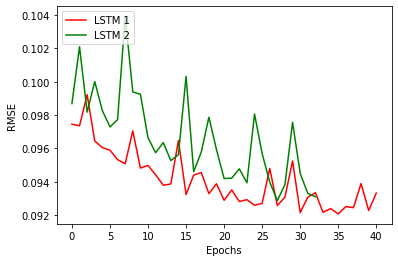

In [ ]:
plt.plot(history_az_1.history['val_root_mean_squared_error'], 'r',
         history_az_2.history['val_root_mean_squared_error'],'g')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend(['LSTM 1', 'LSTM 2'], loc='upper left')
plt.show()

####predicting for 1 jan 2021 until 1 feb 2021 using the 2nd model

In [ ]:
df_date = pd.DataFrame({
    'date':pd.date_range(start='2021-01-01', end='2021-02-01')
})
df_date

date
0  2021-01-01
1  2021-01-02
2  2021-01-03
3  2021-01-04
4  2021-01-05
5  2021-01-06
6  2021-01-07
7  2021-01-08
8  2021-01-09
9  2021-01-10
10 2021-01-11
11 2021-01-12
12 2021-01-13
13 2021-01-14
14 2021-01-15
15 2021-01-16
16 2021-01-17
17 2021-01-18
18 2021-01-19
19 2021-01-20
20 2021-01-21
21 2021-01-22
22 2021-01-23
23 2021-01-24
24 2021-01-25
25 2021-01-26
26 2021-01-27
27 2021-01-28
28 2021-01-29
29 2021-01-30
30 2021-01-31
31 2021-02-01

In [ ]:
df_date.index = pd.to_datetime(df_date['date'], format='%Y.%m.%d')
df_date

date
date                 
2021-01-01 2021-01-01
2021-01-02 2021-01-02
2021-01-03 2021-01-03
2021-01-04 2021-01-04
2021-01-05 2021-01-05
2021-01-06 2021-01-06
2021-01-07 2021-01-07
2021-01-08 2021-01-08
2021-01-09 2021-01-09
2021-01-10 2021-01-10
2021-01-11 2021-01-11
2021-01-12 2021-01-12
2021-01-13 2021-01-13
2021-01-14 2021-01-14
2021-01-15 2021-01-15
2021-01-16 2021-01-16
2021-01-17 2021-01-17
2021-01-18 2021-01-18
2021-01-19 2021-01-19
2021-01-20 2021-01-20
2021-01-21 2021-01-21
2021-01-22 2021-01-22
2021-01-23 2021-01-23
2021-01-24 2021-01-24
2021-01-25 2021-01-25
2021-01-26 2021-01-26
2021-01-27 2021-01-27
2021-01-28 2021-01-28
2021-01-29 2021-01-29
2021-01-30 2021-01-30
2021-01-31 2021-01-31
2021-02-01 2021-02-01

In [ ]:
df_date['Seconds'] = df_date.index.map(pd.Timestamp.timestamp)
df_date

date       Seconds
date                               
2021-01-01 2021-01-01  1.609459e+09
2021-01-02 2021-01-02  1.609546e+09
2021-01-03 2021-01-03  1.609632e+09
2021-01-04 2021-01-04  1.609718e+09
2021-01-05 2021-01-05  1.609805e+09
2021-01-06 2021-01-06  1.609891e+09
2021-01-07 2021-01-07  1.609978e+09
2021-01-08 2021-01-08  1.610064e+09
2021-01-09 2021-01-09  1.610150e+09
2021-01-10 2021-01-10  1.610237e+09
2021-01-11 2021-01-11  1.610323e+09
2021-01-12 2021-01-12  1.610410e+09
2021-01-13 2021-01-13  1.610496e+09
2021-01-14 2021-01-14  1.610582e+09
2021-01-15 2021-01-15  1.610669e+09
2021-01-16 2021-01-16  1.610755e+09
2021-01-17 2021-01-17  1.610842e+09
2021-01-18 2021-01-18  1.610928e+09
2021-01-19 2021-01-19  1.611014e+09
2021-01-20 2021-01-20  1.611101e+09
2021-01-21 2021-01-21  1.611187e+09
2021-01-22 2021-01-22  1.611274e+09
2021-01-23 2021-01-23  1.611360e+09
2021-01-24 2021-01-24  1.611446e+09
2021-01-25 2021-01-25  1.611533e+09
2021-01-26 2021-01-26  1.611619e+09
2021-01-27 2021-01-27  1.611706e+09
2021-01-28 2021-01-28  1.611792e+09
2021-01-29 2021-01-29  1.611878e+09
2021-01-30 2021-01-30  1.611965e+09
2021-01-31 2021-01-31  1.612051e+09
2021-02-01 2021-02-01  1.612138e+09

In [ ]:
df_date['Day sin'] = np.sin(df_date['Seconds'] * (2* np.pi / day))
df_date['Day cos'] = np.cos(df_date['Seconds'] * (2 * np.pi / day))
df_date['Month sin'] = np.sin(df_date['Seconds'] * (2* np.pi / month))
df_date['Month cos'] = np.cos(df_date['Seconds'] * (2* np.pi / month))
df_date['Year sin'] = np.sin(df_date['Seconds'] * (2 * np.pi / year))
df_date['Year cos'] = np.cos(df_date['Seconds'] * (2 * np.pi / year))
df_date.head()

date       Seconds       Day sin  Day cos  Month sin  \
date                                                                    
2021-01-01 2021-01-01  1.609459e+09 -6.012051e-12      1.0   0.114525   
2021-01-02 2021-01-02  1.609546e+09 -1.713513e-12      1.0   0.315714   
2021-01-03 2021-01-03  1.609632e+09 -1.196689e-11      1.0   0.503497   
2021-01-04 2021-01-04  1.609718e+09 -7.668351e-12      1.0   0.669900   
2021-01-05 2021-01-05  1.609805e+09 -3.369812e-12      1.0   0.807857   

            Month cos  Year sin  Year cos  
date                                       
2021-01-01   0.993420  0.010881  0.999941  
2021-01-02   0.948854  0.028080  0.999606  
2021-01-03   0.863997  0.045271  0.998975  
2021-01-04   0.742451  0.062448  0.998048  
2021-01-05   0.589379  0.079608  0.996826

In [ ]:
df_date = df_date.drop('Seconds', axis=1)
df_date = df_date.drop('date',axis=1)
df_date.head()

Day sin  Day cos  Month sin  Month cos  Year sin  Year cos
date                                                                       
2021-01-01 -6.012051e-12      1.0   0.114525   0.993420  0.010881  0.999941
2021-01-02 -1.713513e-12      1.0   0.315714   0.948854  0.028080  0.999606
2021-01-03 -1.196689e-11      1.0   0.503497   0.863997  0.045271  0.998975
2021-01-04 -7.668351e-12      1.0   0.669900   0.742451  0.062448  0.998048
2021-01-05 -3.369812e-12      1.0   0.807857   0.589379  0.079608  0.996826

In [ ]:
df_date.insert(0, "score", [0 for i in range(32)], True)
df_date

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2021-01-01      0 -6.012051e-12      1.0   0.114525   0.993420  0.010881   
2021-01-02      0 -1.713513e-12      1.0   0.315714   0.948854  0.028080   
2021-01-03      0 -1.196689e-11      1.0   0.503497   0.863997  0.045271   
2021-01-04      0 -7.668351e-12      1.0   0.669900   0.742451  0.062448   
2021-01-05      0 -3.369812e-12      1.0   0.807857   0.589379  0.079608   
2021-01-06      0  9.287266e-13      1.0   0.911509   0.411280  0.096743   
2021-01-07      0 -9.324650e-12      1.0   0.976456   0.215716  0.113850   
2021-01-08      0 -5.026111e-12      1.0   0.999940   0.010992  0.130923   
2021-01-09      0 -7.275728e-13      1.0   0.980962  -0.194198  0.147958   
2021-01-10      0 -1.098095e-11      1.0   0.920330  -0.391142  0.164948   
2021-01-11      0 -6.682411e-12      1.0   0.820618  -0.571477  0.181890   
2021-01-12      0 -2.383872e-12      1.0   0.686059  -0.727545  0.198778   
2021-01-13      0 -1.263725e-11      1.0   0.522369  -0.852720  0.215608   
2021-01-14      0 -8.338710e-12      1.0   0.336497  -0.941685  0.232373   
2021-01-15      0 -4.040172e-12      1.0   0.136336  -0.990663  0.249070   
2021-01-16      0  2.583671e-13      1.0  -0.069615  -0.997574  0.265693   
2021-01-17      0 -9.995009e-12      1.0  -0.272609  -0.962125  0.282237   
2021-01-18      0 -5.696471e-12      1.0  -0.464027  -0.885821  0.298698   
2021-01-19      0 -1.397932e-12      1.0  -0.635741  -0.771902  0.315070   
2021-01-20      0 -1.165131e-11      1.0  -0.780460  -0.625206  0.331350   
2021-01-21      0 -7.352770e-12      1.0  -0.892037  -0.451961  0.347531   
2021-01-22      0 -3.054232e-12      1.0  -0.965736  -0.259525  0.363609   
2021-01-23      0 -1.330761e-11      1.0  -0.998427  -0.056069  0.379580   
2021-01-24      0 -9.009070e-12      1.0  -0.988721   0.149769  0.395438   
2021-01-25      0 -4.710531e-12      1.0  -0.937031   0.349247  0.411179   
2021-01-26      0 -4.119923e-13      1.0  -0.845551   0.533894  0.426799   
2021-01-27      0 -1.066537e-11      1.0  -0.718167   0.695871  0.442292   
2021-01-28      0 -6.366830e-12      1.0  -0.560287   0.828299  0.457655   
2021-01-29      0 -2.068292e-12      1.0  -0.378615   0.925554  0.472882   
2021-01-30      0 -1.232167e-11      1.0  -0.180866   0.983508  0.487969   
2021-01-31      0 -8.023130e-12      1.0   0.024563   0.999698  0.502912   
2021-02-01      0 -3.724591e-12      1.0   0.228949   0.973438  0.517705   

            Year cos  
date                  
2021-01-01  0.999941  
2021-01-02  0.999606  
2021-01-03  0.998975  
2021-01-04  0.998048  
2021-01-05  0.996826  
2021-01-06  0.995309  
2021-01-07  0.993498  
2021-01-08  0.991393  
2021-01-09  0.988994  
2021-01-10  0.986302  
2021-01-11  0.983319  
2021-01-12  0.980044  
2021-01-13  0.976480  
2021-01-14  0.972627  
2021-01-15  0.968486  
2021-01-16  0.964058  
2021-01-17  0.959345  
2021-01-18  0.954348  
2021-01-19  0.949068  
2021-01-20  0.943508  
2021-01-21  0.937669  
2021-01-22  0.931552  
2021-01-23  0.925159  
2021-01-24  0.918493  
2021-01-25  0.911554  
2021-01-26  0.904347  
2021-01-27  0.896871  
2021-01-28  0.889130  
2021-01-29  0.881126  
2021-01-30  0.872861  
2021-01-31  0.864338  
2021-02-01  0.855559

In [ ]:
x_test_az = scoreaz_test_df.tail(7)
x_test_az

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2020-12-25    5.0 -6.997991e-12      1.0  -0.971208   0.238232 -0.109320   
2020-12-26    5.0 -2.699453e-12      1.0  -0.901757   0.432242 -0.092205   
2020-12-27    5.0 -1.295283e-11      1.0  -0.794015   0.607898 -0.075062   
2020-12-28    5.0 -8.654291e-12      1.0  -0.652557   0.757740 -0.057898   
2020-12-29    5.0 -4.355752e-12      1.0  -0.483388   0.875406 -0.040716   
2020-12-30    5.0 -5.721331e-14      1.0  -0.293694   0.955900 -0.023523   
2020-12-31    5.0 -1.031059e-11      1.0  -0.091528   0.995803 -0.006322   

            Year cos  
date                  
2020-12-25  0.994007  
2020-12-26  0.995740  
2020-12-27  0.997179  
2020-12-28  0.998323  
2020-12-29  0.999171  
2020-12-30  0.999723  
2020-12-31  0.999980

In [ ]:
x_test1_az = x_test_az.append(df_date)
x_test1_az

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2020-12-25    5.0 -6.997991e-12      1.0  -0.971208   0.238232 -0.109320   
2020-12-26    5.0 -2.699453e-12      1.0  -0.901757   0.432242 -0.092205   
2020-12-27    5.0 -1.295283e-11      1.0  -0.794015   0.607898 -0.075062   
2020-12-28    5.0 -8.654291e-12      1.0  -0.652557   0.757740 -0.057898   
2020-12-29    5.0 -4.355752e-12      1.0  -0.483388   0.875406 -0.040716   
2020-12-30    5.0 -5.721331e-14      1.0  -0.293694   0.955900 -0.023523   
2020-12-31    5.0 -1.031059e-11      1.0  -0.091528   0.995803 -0.006322   
2021-01-01    0.0 -6.012051e-12      1.0   0.114525   0.993420  0.010881   
2021-01-02    0.0 -1.713513e-12      1.0   0.315714   0.948854  0.028080   
2021-01-03    0.0 -1.196689e-11      1.0   0.503497   0.863997  0.045271   
2021-01-04    0.0 -7.668351e-12      1.0   0.669900   0.742451  0.062448   
2021-01-05    0.0 -3.369812e-12      1.0   0.807857   0.589379  0.079608   
2021-01-06    0.0  9.287266e-13      1.0   0.911509   0.411280  0.096743   
2021-01-07    0.0 -9.324650e-12      1.0   0.976456   0.215716  0.113850   
2021-01-08    0.0 -5.026111e-12      1.0   0.999940   0.010992  0.130923   
2021-01-09    0.0 -7.275728e-13      1.0   0.980962  -0.194198  0.147958   
2021-01-10    0.0 -1.098095e-11      1.0   0.920330  -0.391142  0.164948   
2021-01-11    0.0 -6.682411e-12      1.0   0.820618  -0.571477  0.181890   
2021-01-12    0.0 -2.383872e-12      1.0   0.686059  -0.727545  0.198778   
2021-01-13    0.0 -1.263725e-11      1.0   0.522369  -0.852720  0.215608   
2021-01-14    0.0 -8.338710e-12      1.0   0.336497  -0.941685  0.232373   
2021-01-15    0.0 -4.040172e-12      1.0   0.136336  -0.990663  0.249070   
2021-01-16    0.0  2.583671e-13      1.0  -0.069615  -0.997574  0.265693   
2021-01-17    0.0 -9.995009e-12      1.0  -0.272609  -0.962125  0.282237   
2021-01-18    0.0 -5.696471e-12      1.0  -0.464027  -0.885821  0.298698   
2021-01-19    0.0 -1.397932e-12      1.0  -0.635741  -0.771902  0.315070   
2021-01-20    0.0 -1.165131e-11      1.0  -0.780460  -0.625206  0.331350   
2021-01-21    0.0 -7.352770e-12      1.0  -0.892037  -0.451961  0.347531   
2021-01-22    0.0 -3.054232e-12      1.0  -0.965736  -0.259525  0.363609   
2021-01-23    0.0 -1.330761e-11      1.0  -0.998427  -0.056069  0.379580   
2021-01-24    0.0 -9.009070e-12      1.0  -0.988721   0.149769  0.395438   
2021-01-25    0.0 -4.710531e-12      1.0  -0.937031   0.349247  0.411179   
2021-01-26    0.0 -4.119923e-13      1.0  -0.845551   0.533894  0.426799   
2021-01-27    0.0 -1.066537e-11      1.0  -0.718167   0.695871  0.442292   
2021-01-28    0.0 -6.366830e-12      1.0  -0.560287   0.828299  0.457655   
2021-01-29    0.0 -2.068292e-12      1.0  -0.378615   0.925554  0.472882   
2021-01-30    0.0 -1.232167e-11      1.0  -0.180866   0.983508  0.487969   
2021-01-31    0.0 -8.023130e-12      1.0   0.024563   0.999698  0.502912   
2021-02-01    0.0 -3.724591e-12      1.0   0.228949   0.973438  0.517705   

            Year cos  
date                  
2020-12-25  0.994007  
2020-12-26  0.995740  
2020-12-27  0.997179  
2020-12-28  0.998323  
2020-12-29  0.999171  
2020-12-30  0.999723  
2020-12-31  0.999980  
2021-01-01  0.999941  
2021-01-02  0.999606  
2021-01-03  0.998975  
2021-01-04  0.998048  
2021-01-05  0.996826  
2021-01-06  0.995309  
2021-01-07  0.993498  
2021-01-08  0.991393  
2021-01-09  0.988994  
2021-01-10  0.986302  
2021-01-11  0.983319  
2021-01-12  0.980044  
2021-01-13  0.976480  
2021-01-14  0.972627  
2021-01-15  0.968486  
2021-01-16  0.964058  
2021-01-17  0.959345  
2021-01-18  0.954348  
2021-01-19  0.949068  
2021-01-20  0.943508  
2021-01-21  0.937669  
2021-01-22  0.931552  
2021-01-23  0.925159  
2021-01-24  0.918493  
2021-01-25  0.911554  
2021-01-26  0.904347  
2021-01-27  0.896871  
2021-01-28  0.889130  
2021-01-29  0.881126  
2021-01-30  0.872861 

In [ ]:
WINDOW_SIZE = 7
X_test1_az2_new, y_test1_az2_new = df_to_X_y2(x_test1_az, WINDOW_SIZE)
X_test1_az2_new.shape

(32, 7, 7)

In [ ]:
test_prediction_2_new_az = model_2.predict(X_test1_az2_new).flatten()
test_results_2_new_az = pd.DataFrame(data={'predictions':test_prediction_2_new_az})
test_results_2_new_az

1/1 [==============================] - 0s 19ms/step


predictions
0      7.399624
1      3.224441
2      1.774575
3      1.618780
4      1.696462
5      1.795859
6      1.858061
7      1.888958
8      1.895685
9      1.891995
10     1.884220
11     1.878203
12     1.873525
13     1.869794
14     1.866771
15     1.864465
16     1.863139
17     1.863266
18     1.865428
19     1.870200
20     1.878047
21     1.888655
22     1.881281
23     1.875731
24     1.872419
25     1.871436
26     1.872498
27     1.874974
28     1.878014
29     1.880744
30     1.882480
31     1.882907

#####result

In [ ]:
test_results_2_new_az.predictions[test_results_2_new_az.predictions <0.5] = 0
test_results_2_new_az.predictions[(test_results_2_new_az.predictions >=0.5)&(test_results_2_new_az.predictions<1.5)] = 1
test_results_2_new_az.predictions[(test_results_2_new_az.predictions >=1.5)&(test_results_2_new_az.predictions<2.5)] = 2
test_results_2_new_az.predictions[(test_results_2_new_az.predictions >=2.5)&(test_results_2_new_az.predictions<3.5)] = 3
test_results_2_new_az.predictions[(test_results_2_new_az.predictions >=3.5)&(test_results_2_new_az.predictions<4.5)] = 4
test_results_2_new_az.predictions[(test_results_2_new_az.predictions >=4.5)&(test_results_2_new_az.predictions<5.5)] = 5
test_results_2_new_az.predictions[(test_results_2_new_az.predictions >= 5.5)] = 5
test_results_2_new_az

predictions
0           5.0
1           3.0
2           2.0
3           2.0
4           2.0
5           2.0
6           2.0
7           2.0
8           2.0
9           2.0
10          2.0
11          2.0
12          2.0
13          2.0
14          2.0
15          2.0
16          2.0
17          2.0
18          2.0
19          2.0
20          2.0
21          2.0
22          2.0
23          2.0
24          2.0
25          2.0
26          2.0
27          2.0
28          2.0
29          2.0
30          2.0
31          2.0

##Crook, Oregon

###train

In [ ]:
crook = train[train['fips']==41013]

#using interpolation to fill in the NaN values
crook = crook.interpolate().fillna(method='bfill')
crook.score[crook.score <0.5] = 0
crook.score[(crook.score >=0.5)&(crook.score<1.5)] = 1
crook.score[(crook.score >=1.5)&(crook.score<2.5)] = 2
crook.score[(crook.score >=2.5)&(crook.score<3.5)] = 3
crook.score[(crook.score >=3.5)&(crook.score<4.5)] = 4
crook.score[(crook.score >=4.5)&(crook.score<5.5)] = 5

#merging the weather data with the soil data
crook = crook.merge(soil, left_on='fips', right_on='fips')
train_or = crook.copy()
crook['date'] = pd.to_datetime(crook['date'], format='%Y.%m.%d')
train_or['tahun'] = crook['date'].dt.year
train_or['bulan'] = crook['date'].dt.month
train_or['tanggal'] = crook['date'].dt.day
train_or[0:31]

fips        date  PRECTOT     PS  QV2M   T2M  T2MDEW  T2MWET  T2M_MAX  \
0   41013  2000-01-01     1.36  86.44  3.18 -2.51   -4.33   -4.31    -0.27   
1   41013  2000-01-02     4.38  86.85  3.06 -2.95   -4.71   -4.69    -1.29   
2   41013  2000-01-03     4.94  87.61  3.67 -1.29   -2.34   -2.34     1.70   
3   41013  2000-01-04     3.92  87.32  3.87 -0.46   -1.69   -1.68     1.66   
4   41013  2000-01-05     0.73  87.99  2.94 -3.37   -5.14   -5.12     0.66   
5   41013  2000-01-06     1.48  87.67  2.72 -3.25   -6.45   -6.40     3.25   
6   41013  2000-01-07     0.24  87.62  3.65 -1.22   -2.38   -2.38     2.16   
7   41013  2000-01-08     2.01  87.03  3.70 -0.52   -2.31   -2.31     1.34   
8   41013  2000-01-09     4.85  86.66  3.58 -1.23   -2.80   -2.80     1.84   
9   41013  2000-01-10    15.86  85.95  3.87 -0.92   -1.91   -1.91     1.07   
10  41013  2000-01-11     4.20  85.70  3.31 -2.70   -4.00   -3.99     0.21   
11  41013  2000-01-12     1.58  86.64  2.62 -5.00   -6.74   -6.71    -2.19   
12  41013  2000-01-13     8.40  86.55  4.02 -0.28   -1.33   -1.33     1.67   
13  41013  2000-01-14     3.26  86.72  4.25  0.35   -0.50   -0.50     3.05   
14  41013  2000-01-15     2.14  86.63  3.89 -1.22   -1.80   -1.79     1.51   
15  41013  2000-01-16     2.25  86.18  3.92  0.03   -1.70   -1.69     2.41   
16  41013  2000-01-17     1.19  87.33  3.14 -2.59   -4.37   -4.36     3.49   
17  41013  2000-01-18     0.27  87.13  3.44 -2.20   -3.25   -3.24     1.06   
18  41013  2000-01-19     1.39  87.11  3.94 -0.71   -1.60   -1.60     4.12   
19  41013  2000-01-20     1.18  86.86  3.90  0.11   -1.62   -1.61     4.67   
20  41013  2000-01-21     0.13  86.77  3.14 -1.43   -4.46   -4.43     2.59   
21  41013  2000-01-22     0.60  87.02  3.05 -2.27   -4.78   -4.76     2.04   
22  41013  2000-01-23     3.08  86.81  3.18 -2.50   -4.44   -4.42     2.75   
23  41013  2000-01-24     5.05  86.66  4.23  0.03   -0.53   -0.53     2.20   
24  41013  2000-01-25     1.36  86.76  4.00 -0.24   -1.31   -1.31     4.45   
25  41013  2000-01-26     0.73  87.47  2.92 -3.24   -5.23   -5.20     0.02   
26  41013  2000-01-27     0.20  87.90  2.67 -4.19   -6.30   -6.27     0.94   
27  41013  2000-01-28     0.00  87.60  2.17 -4.72   -8.80   -8.73     3.48   
28  41013  2000-01-29     0.32  87.11  2.02 -4.97   -9.72   -9.61     3.40   
29  41013  2000-01-30     1.91  86.39  2.59 -4.61   -7.32   -7.25    -0.27   
30  41013  2000-01-31     3.90  86.97  3.38 -1.25   -3.50   -3.48     2.64   

    T2M_MIN  T2M_RANGE    TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  WS50M  \
0     -3.99       3.72 -2.72   5.06       8.35       2.90         5.45   7.44   
1     -4.06       2.77 -3.14   5.68       9.43       3.52         5.91   8.27   
2     -4.33       6.04 -1.61   3.48       5.65       1.77         3.88   5.40   
3     -3.40       5.06 -0.81   6.05       9.11       4.16         4.95   8.73   
4     -8.30       8.96 -4.62   3.15       4.49       1.62         2.87   4.73   
5     -8.44      11.69 -4.02   3.98       6.35       2.07         4.28   6.44   
6     -3.17       5.33 -1.82   3.34       6.39       2.10         4.29   5.46   
7     -2.77       4.12 -0.84   7.47      10.85       4.44         6.40  10.59   
8     -3.27       5.11 -1.63   6.77       9.85       3.75         6.10   9.75   
9     -3.09       4.16 -1.30   5.06       8.26       2.53         5.73   7.46   
10    -5.58       5.79 -3.27   4.66       7.96       3.05         4.91   7.32   
11    -8.20       6.01 -5.53   6.11       7.87       4.23         3.63   8.94   
12    -4.45       6.12 -0.97   6.48       7.97       4.71         3.26   9.77   
13    -3.06       6.11 -0.83   4.51       6.63       1.60         5.03   7.59   
14    -5.59       7.10 -2.35   4.05       8.25       0.85         7.40   5.85   
15    -4.42       6.83 -0.73   7.43      11.16       2.85         8.31  10.83   
16    -6.39       9.89 -3.81   3.16       4.87       2.24         2.63   4.95   
17    -4.69       5.75 -2.99   2.73       3.28    

In [ ]:
train_or['score'].value_counts()

1.0    2191
0.0    1861
2.0    1035
3.0    1007
4.0     116
Name: score, dtype: int64

In [ ]:
#For Regression

crook = train[train['fips']==41013]

#using interpolation to fill in the NaN values
crook = crook.interpolate().fillna(method='bfill')

#merging the weather data with the soil data
crook = crook.merge(soil, left_on='fips', right_on='fips')
train_or = crook.copy()
train_or[2000:2050]

fips        date  PRECTOT     PS  QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  \
2000  41013  2005-06-23     0.02  87.17  5.84  15.89    3.84    3.86    25.46   
2001  41013  2005-06-24     0.02  86.90  6.54  19.02    5.39    5.41    28.20   
2002  41013  2005-06-25     0.17  86.73  7.56  15.40    7.59    7.60    19.99   
2003  41013  2005-06-26     1.43  86.60  7.05  15.49    6.49    6.50    23.67   
2004  41013  2005-06-27     6.70  86.69  7.73  13.03    7.98    7.99    18.17   
2005  41013  2005-06-28     1.11  87.20  7.29  13.38    7.21    7.22    19.99   
2006  41013  2005-06-29     0.04  87.40  6.56  16.69    5.47    5.49    25.87   
2007  41013  2005-06-30     0.00  87.20  7.81  20.24    7.90    7.91    29.86   
2008  41013  2005-07-01     0.03  87.08  7.54  18.08    7.15    7.16    25.79   
2009  41013  2005-07-02     0.00  87.14  6.03  15.02    4.20    4.22    22.89   
2010  41013  2005-07-03     0.00  87.22  5.46  16.12    2.70    2.74    25.34   
2011  41013  2005-07-04     0.00  87.36  6.29  19.71    4.68    4.71    29.15   
2012  41013  2005-07-05     0.00  87.15  7.71  20.68    7.83    7.84    30.63   
2013  41013  2005-07-06     0.02  87.06  8.75  18.61    9.85    9.86    26.10   
2014  41013  2005-07-07     0.01  87.00  7.29  19.04    7.06    7.07    29.38   
2015  41013  2005-07-08     2.22  86.94  7.98  17.19    8.43    8.43    26.69   
2016  41013  2005-07-09     6.61  86.87  8.25  14.15    8.96    8.96    20.35   
2017  41013  2005-07-10     1.92  87.00  7.95  15.53    8.47    8.47    22.76   
2018  41013  2005-07-11     0.01  87.24  7.85  19.78    8.18    8.18    29.64   
2019  41013  2005-07-12     0.01  87.43  8.34  20.00    9.14    9.15    30.60   
2020  41013  2005-07-13     0.00  87.68  6.23  16.50    4.66    4.68    24.81   
2021  41013  2005-07-14     0.00  87.41  5.55  20.39    2.83    2.88    32.36   
2022  41013  2005-07-15     0.00  87.01  7.57  23.75    7.47    7.48    33.96   
2023  41013  2005-07-16     0.00  87.16  7.89  18.32    8.12    8.13    25.91   
2024  41013  2005-07-17     0.00  87.31  5.72  20.45    3.51    3.54    31.44   
2025  41013  2005-07-18     0.00  87.01  6.75  23.66    5.73    5.74    32.82   
2026  41013  2005-07-19     0.00  86.89  7.74  22.23    7.54    7.55    31.64   
2027  41013  2005-07-20     0.00  87.14  6.40  22.20    5.02    5.05    31.81   
2028  41013  2005-07-21     0.09  87.10  7.38  24.57    6.95    6.96    35.56   
2029  41013  2005-07-22     0.40  87.13  9.68  21.07   11.21   11.22    27.23   
2030  41013  2005-07-23     0.00  87.47  7.22  20.69    6.65    6.67    30.44   
2031  41013  2005-07-24     0.00  87.43  5.99  17.97    3.96    4.00    26.38   
2032  41013  2005-07-25     0.00  87.60  5.93  17.09    4.04    4.07    25.94   
2033  41013  2005-07-26     0.00  87.56  3.93  20.63   -1.86   -1.71    30.39   
2034  41013  2005-07-27     0.00  87.18  4.71  23.81    0.56    0.63    34.63   
2035  41013  2005-07-28     0.00  87.08  7.07  22.57    6.45    6.47    30.92   
2036  41013  2005-07-29     0.00  87.24  7.50  22.43    7.27    7.29    31.61   
2037  41013  2005-07-30     0.00  87.42  7.69  23.81    7.89    7.90    32.84   
2038  41013  2005-07-31     0.31  87.29  8.30  24.88    9.01    9.01    34.35   
2039  41013  2005-08-01     0.53  87.28  9.41  20.12   10.96   10.96    26.14   
2040  41013  2005-08-02     0.00  87.35  6.27  18.21    4.73    4.75    26.67   
2041  41013  2005-08-03     0.00  87.45  4.67  20.20    0.86    0.91    30.39   
2042  41013  2005-08-04     0.00  87.42  5.91  24.17    4.05    4.07    34.90   
2043  41013  2005-08-05     0.00  87.43  7.03  25.29    6.57    6.59    35.09   
2044  41013  2005-08-06     0.00  87.33  7.91  24.51    8.38    8.38    34.35   
2045  41013  2005-08-07     0.00  87.17  7.13  23.32    6.74    6.75    33.08   
2046  41013  2005-08-08     0.01  87.12  6.88  21.99    6.01    6.03    31.29   
2047  41013  2005-08-09     0.00  87.25  6.87  21.73    6.10    6.12    31.25   
2048  41013  2005-08-10     0.00  87.4

###val

In [ ]:
crook_val = validation[validation['fips']==41013]

#using interpolation to fill in the NaN values
crook_val = crook_val.interpolate().fillna(method='bfill')
crook_val.score[crook_val.score <0.5] = 0
crook_val.score[(crook_val.score >=0.5)&(crook_val.score<1.5)] = 1
crook_val.score[(crook_val.score >=1.5)&(crook_val.score<2.5)] = 2
crook_val.score[(crook_val.score >=2.5)&(crook_val.score<3.5)] = 3
crook_val.score[(crook_val.score >=3.5)&(crook_val.score<4.5)] = 4
crook_val.score[(crook_val.score >=4.5)&(crook_val.score<5.5)] = 5

#merging the weather data with the soil data
crook_val = crook_val.merge(soil, left_on='fips', right_on='fips')
val_or = crook_val.copy()
crook_val['date'] = pd.to_datetime(crook_val['date'], format='%Y.%m.%d')
val_or['tahun'] = crook_val['date'].dt.year
val_or['bulan'] = crook_val['date'].dt.month
val_or['tanggal'] = crook_val['date'].dt.day
val_or[0:31]

fips        date  PRECTOT     PS  QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  \
0   41013  2017-01-01     2.25  85.60  2.33  -6.90   -8.25   -8.23    -4.12   
1   41013  2017-01-02     2.66  85.94  2.12  -8.05   -9.34   -9.31    -4.16   
2   41013  2017-01-03     2.97  86.76  1.73 -10.63  -11.63  -11.60    -5.75   
3   41013  2017-01-04     5.92  86.59  1.40 -13.46  -14.17  -14.14   -10.08   
4   41013  2017-01-05     0.04  87.07  1.08 -16.71  -17.14  -17.16    -7.06   
5   41013  2017-01-06     0.11  86.78  0.95 -17.37  -18.21  -18.11   -10.52   
6   41013  2017-01-07    12.58  86.35  2.14  -9.78  -10.62  -10.57    -1.25   
7   41013  2017-01-08    13.84  85.95  4.31   0.14   -0.44   -0.43     1.09   
8   41013  2017-01-09     4.08  85.80  3.65  -1.89   -2.79   -2.78     0.23   
9   41013  2017-01-10    11.11  85.23  3.86  -1.32   -2.06   -2.05     0.03   
10  41013  2017-01-11     2.20  85.76  2.59  -6.64   -7.37   -7.36    -1.84   
11  41013  2017-01-12     0.14  86.96  2.04  -9.47   -9.87   -9.86    -2.69   
12  41013  2017-01-13     0.01  87.75  1.61 -11.84  -12.55  -12.53    -4.56   
13  41013  2017-01-14     0.01  87.73  1.87  -9.86  -10.83  -10.80    -3.69   
14  41013  2017-01-15     0.01  87.51  1.71 -11.25  -11.94  -11.91    -4.22   
15  41013  2017-01-16     0.04  87.41  2.20  -8.12   -9.30   -9.27    -1.21   
16  41013  2017-01-17     2.01  86.68  2.62  -6.09   -7.45   -7.41    -0.30   
17  41013  2017-01-18     7.58  85.65  4.27   0.41   -0.57   -0.57     1.02   
18  41013  2017-01-19     0.98  85.60  3.54  -2.31   -3.19   -3.19     0.62   
19  41013  2017-01-20     2.25  84.45  3.72  -1.55   -2.67   -2.66     0.84   
20  41013  2017-01-21     1.03  85.15  3.28  -3.17   -4.30   -4.29     0.77   
21  41013  2017-01-22     1.57  85.39  3.08  -3.50   -5.17   -5.15     0.61   
22  41013  2017-01-23     1.42  85.86  2.63  -5.71   -6.92   -6.90    -0.76   
23  41013  2017-01-24     0.48  86.82  2.42  -7.06   -7.83   -7.82    -1.28   
24  41013  2017-01-25     3.45  87.37  2.70  -5.60   -6.36   -6.35    -0.95   
25  41013  2017-01-26     1.07  88.05  2.80  -5.24   -5.90   -5.89    -0.12   
26  41013  2017-01-27     0.05  88.61  2.38  -6.72   -7.76   -7.75    -0.55   
27  41013  2017-01-28     0.00  88.62  2.28  -6.57   -8.40   -8.36    -0.18   
28  41013  2017-01-29     0.00  88.23  2.39  -6.35   -7.99   -7.95    -0.99   
29  41013  2017-01-30     0.01  87.50  2.97  -3.90   -5.22   -5.21     1.23   
30  41013  2017-01-31     1.79  87.03  3.46  -2.30   -3.27   -3.26     0.18   

    T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  \
0     -9.33       5.21  -7.83   3.85       5.97       1.37         4.60   
1    -11.17       7.01  -8.90   2.51       4.30       0.93         3.36   
2    -14.41       8.67 -11.17   3.09       4.53       2.43         2.10   
3    -20.61      10.52 -14.50   3.40       4.91       1.47         3.44   
4    -22.34      15.28 -19.41   2.73       4.78       1.41         3.37   
5    -22.12      11.60 -17.88   5.89       7.23       4.79         2.44   
6    -18.75      17.51 -10.15   7.52      11.33       3.39         7.94   
7     -3.35       4.45  -0.58   6.45      10.02       2.50         7.52   
8     -5.72       5.95  -2.58   4.21       7.88       2.28         5.60   
9     -4.42       4.45  -1.87   3.98       5.19       1.88         3.31   
10   -10.80       8.96  -8.42   2.42       4.68       0.34         4.34   
11   -13.13      10.44 -12.11   1.95       2.84       1.17         1.67   
12   -16.71      12.15 -13.21   3.83       4.96       2.53         2.43   
13   -13.59       9.90 -10.35   4.61       5.57       3.74         1.84   
14   -14.84      10.62 -12.16   3.80       5.02       1.72         3.30   
15   -13.05      11.84  -8.84   4.72       6.96       3.61         3.35   
16   -12.82      12.51  -6.34   7.56       8.49       6.56         1.93   
17    -0.53       1.56  -0.28   8.78      10.31       6.64         3.66   
18    -6.00       6.62  -3.05   4.07       5.65    

In [ ]:
val_or['score'].value_counts()

0.0    251
2.0    195
3.0    172
1.0    112
Name: score, dtype: int64

In [ ]:
#For Regression

crook_val = validation[validation['fips']==41013]

#using interpolation to fill in the NaN values
crook_val = crook_val.interpolate().fillna(method='bfill')

#merging the weather data with the soil data
crook_val = crook_val.merge(soil, left_on='fips', right_on='fips')
val_or = crook_val.copy()
val_or[0:31]

fips        date  PRECTOT     PS  QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  \
0   41013  2017-01-01     2.25  85.60  2.33  -6.90   -8.25   -8.23    -4.12   
1   41013  2017-01-02     2.66  85.94  2.12  -8.05   -9.34   -9.31    -4.16   
2   41013  2017-01-03     2.97  86.76  1.73 -10.63  -11.63  -11.60    -5.75   
3   41013  2017-01-04     5.92  86.59  1.40 -13.46  -14.17  -14.14   -10.08   
4   41013  2017-01-05     0.04  87.07  1.08 -16.71  -17.14  -17.16    -7.06   
5   41013  2017-01-06     0.11  86.78  0.95 -17.37  -18.21  -18.11   -10.52   
6   41013  2017-01-07    12.58  86.35  2.14  -9.78  -10.62  -10.57    -1.25   
7   41013  2017-01-08    13.84  85.95  4.31   0.14   -0.44   -0.43     1.09   
8   41013  2017-01-09     4.08  85.80  3.65  -1.89   -2.79   -2.78     0.23   
9   41013  2017-01-10    11.11  85.23  3.86  -1.32   -2.06   -2.05     0.03   
10  41013  2017-01-11     2.20  85.76  2.59  -6.64   -7.37   -7.36    -1.84   
11  41013  2017-01-12     0.14  86.96  2.04  -9.47   -9.87   -9.86    -2.69   
12  41013  2017-01-13     0.01  87.75  1.61 -11.84  -12.55  -12.53    -4.56   
13  41013  2017-01-14     0.01  87.73  1.87  -9.86  -10.83  -10.80    -3.69   
14  41013  2017-01-15     0.01  87.51  1.71 -11.25  -11.94  -11.91    -4.22   
15  41013  2017-01-16     0.04  87.41  2.20  -8.12   -9.30   -9.27    -1.21   
16  41013  2017-01-17     2.01  86.68  2.62  -6.09   -7.45   -7.41    -0.30   
17  41013  2017-01-18     7.58  85.65  4.27   0.41   -0.57   -0.57     1.02   
18  41013  2017-01-19     0.98  85.60  3.54  -2.31   -3.19   -3.19     0.62   
19  41013  2017-01-20     2.25  84.45  3.72  -1.55   -2.67   -2.66     0.84   
20  41013  2017-01-21     1.03  85.15  3.28  -3.17   -4.30   -4.29     0.77   
21  41013  2017-01-22     1.57  85.39  3.08  -3.50   -5.17   -5.15     0.61   
22  41013  2017-01-23     1.42  85.86  2.63  -5.71   -6.92   -6.90    -0.76   
23  41013  2017-01-24     0.48  86.82  2.42  -7.06   -7.83   -7.82    -1.28   
24  41013  2017-01-25     3.45  87.37  2.70  -5.60   -6.36   -6.35    -0.95   
25  41013  2017-01-26     1.07  88.05  2.80  -5.24   -5.90   -5.89    -0.12   
26  41013  2017-01-27     0.05  88.61  2.38  -6.72   -7.76   -7.75    -0.55   
27  41013  2017-01-28     0.00  88.62  2.28  -6.57   -8.40   -8.36    -0.18   
28  41013  2017-01-29     0.00  88.23  2.39  -6.35   -7.99   -7.95    -0.99   
29  41013  2017-01-30     0.01  87.50  2.97  -3.90   -5.22   -5.21     1.23   
30  41013  2017-01-31     1.79  87.03  3.46  -2.30   -3.27   -3.26     0.18   

    T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  \
0     -9.33       5.21  -7.83   3.85       5.97       1.37         4.60   
1    -11.17       7.01  -8.90   2.51       4.30       0.93         3.36   
2    -14.41       8.67 -11.17   3.09       4.53       2.43         2.10   
3    -20.61      10.52 -14.50   3.40       4.91       1.47         3.44   
4    -22.34      15.28 -19.41   2.73       4.78       1.41         3.37   
5    -22.12      11.60 -17.88   5.89       7.23       4.79         2.44   
6    -18.75      17.51 -10.15   7.52      11.33       3.39         7.94   
7     -3.35       4.45  -0.58   6.45      10.02       2.50         7.52   
8     -5.72       5.95  -2.58   4.21       7.88       2.28         5.60   
9     -4.42       4.45  -1.87   3.98       5.19       1.88         3.31   
10   -10.80       8.96  -8.42   2.42       4.68       0.34         4.34   
11   -13.13      10.44 -12.11   1.95       2.84       1.17         1.67   
12   -16.71      12.15 -13.21   3.83       4.96       2.53         2.43   
13   -13.59       9.90 -10.35   4.61       5.57       3.74         1.84   
14   -14.84      10.62 -12.16   3.80       5.02       1.72         3.30   
15   -13.05      11.84  -8.84   4.72       6.96       3.61         3.35   
16   -12.82      12.51  -6.34   7.56       8.49       6.56         1.93   
17    -0.53       1.56  -0.28   8.78      10.31       6.64         3.66   
18    -6.00       6.62  -3.05   4.07       5.65    

###test

In [ ]:
crook_test = test[test['fips']==41013]

#using interpolation to fill in the NaN values
crook_test = crook_test.interpolate().fillna(method='bfill')
crook_test.score[crook_test.score <0.5] = 0
crook_test.score[(crook_test.score >=0.5)&(crook_test.score<1.5)] = 1
crook_test.score[(crook_test.score >=1.5)&(crook_test.score<2.5)] = 2
crook_test.score[(crook_test.score >=2.5)&(crook_test.score<3.5)] = 3
crook_test.score[(crook_test.score >=3.5)&(crook_test.score<4.5)] = 4
crook_test.score[(crook_test.score >=4.5)&(crook_test.score<5.5)] = 5

#merging the weather data with the soil data
crook_test = crook_test.merge(soil, left_on='fips', right_on='fips')
test_or = crook_test.copy()
crook_test['date'] = pd.to_datetime(crook_test['date'], format='%Y.%m.%d')
test_or['tahun'] = crook_test['date'].dt.year
test_or['bulan'] = crook_test['date'].dt.month
test_or['tanggal'] = crook_test['date'].dt.day
test_or[0:31]

fips        date  PRECTOT     PS  QV2M   T2M  T2MDEW  T2MWET  T2M_MAX  \
0   41013  2019-01-01     0.39  87.72  1.96 -6.18  -10.46   -9.96     0.79   
1   41013  2019-01-02     0.90  87.44  2.71 -3.51   -6.37   -6.44     2.80   
2   41013  2019-01-03     0.14  86.96  3.34 -1.07   -3.69   -3.69     2.88   
3   41013  2019-01-04     0.05  86.53  3.37 -1.19   -3.66   -3.57     1.99   
4   41013  2019-01-05     0.31  85.49  3.39 -0.87   -3.71   -3.69     2.92   
5   41013  2019-01-06     1.85  85.55  3.40 -1.30   -3.69   -3.58     1.17   
6   41013  2019-01-07     0.36  86.80  2.54 -3.58   -7.30   -7.02     0.20   
7   41013  2019-01-08     1.28  86.78  4.12  0.53   -0.92   -0.89     1.82   
8   41013  2019-01-09     0.47  86.48  4.64  2.20    0.65    0.69     6.57   
9   41013  2019-01-10     0.08  87.15  4.05  0.58   -1.09   -1.07     5.74   
10  41013  2019-01-11     0.03  86.96  3.50  0.72   -3.04   -3.02     6.65   
11  41013  2019-01-12     0.05  87.09  2.81 -0.62   -5.93   -5.72     5.91   
12  41013  2019-01-13     0.07  87.33  2.43 -2.73   -7.74   -7.40     5.30   
13  41013  2019-01-14     0.06  87.08  2.12 -3.70   -9.53   -8.95     3.32   
14  41013  2019-01-15     0.29  86.47  2.83 -2.58   -5.95   -5.87     4.15   
15  41013  2019-01-16     3.86  86.06  4.09  0.73   -1.13   -1.24     6.36   
16  41013  2019-01-17     0.62  85.95  4.06  1.13   -1.22   -1.20     4.57   
17  41013  2019-01-18    14.14  87.16  3.77 -0.09   -2.04   -2.04     2.67   
18  41013  2019-01-19     7.80  87.22  4.72  1.50    1.03    1.06     3.05   
19  41013  2019-01-20     4.50  86.28  4.07 -0.17   -1.17   -1.20     2.84   
20  41013  2019-01-21     0.26  87.27  2.93 -3.31   -5.40   -5.19     0.20   
21  41013  2019-01-22     2.35  87.90  3.03 -1.42   -4.83   -4.78     2.18   
22  41013  2019-01-23     0.22  87.67  4.42  0.79    0.20    0.15     4.12   
23  41013  2019-01-24     0.02  88.01  3.55  0.21   -2.71   -2.65     5.95   
24  41013  2019-01-25     0.00  87.99  3.00  0.38   -4.91   -4.78     6.15   
25  41013  2019-01-26     0.00  88.18  3.50  2.54   -2.85   -2.93    10.45   
26  41013  2019-01-27     0.00  87.75  3.73  2.90   -2.06   -2.05    10.88   
27  41013  2019-01-28     0.00  87.57  2.98 -0.20   -5.07   -4.99     5.66   
28  41013  2019-01-29     0.00  87.05  2.82  0.11   -5.90   -5.72     7.87   
29  41013  2019-01-30     0.00  86.76  2.83  1.53   -5.90   -5.66    10.00   
30  41013  2019-01-31     0.00  86.53  3.30  2.53   -3.89   -3.91    11.68   

    T2M_MIN  T2M_RANGE    TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  WS50M  \
0    -11.07      11.86 -8.90   2.43       3.52       1.06         2.46   3.59   
1     -7.85      10.66 -4.44   4.00       5.04       3.29         1.75   6.65   
2     -4.80       7.68 -1.78   5.53       6.60       4.00         2.60   8.22   
3     -3.61       5.60 -1.84   4.91       5.77       3.57         2.20   7.51   
4     -4.81       7.73 -1.45   7.32      10.27       5.25         5.02  10.14   
5     -3.08       4.25 -1.75   5.20       8.10       2.56         5.54   7.84   
6     -7.03       7.23 -4.45   3.50       5.00       1.35         3.64   5.53   
7     -1.39       3.22  0.02   7.30       8.43       5.03         3.40   9.90   
8     -0.05       6.62  1.49   6.39       7.90       4.64         3.26   9.68   
9     -1.85       7.59 -0.09   3.96       4.92       2.82         2.10   6.50   
10    -1.88       8.54  0.05   6.43       7.98       5.10         2.88   9.41   
11    -4.49      10.40 -1.11   6.17       8.49       4.21         4.28   8.84   
12    -6.82      12.12 -3.13   4.60       5.48       2.84         2.64   6.72   
13    -7.31      10.63 -3.86   5.36       6.78       4.42         2.36   7.52   
14    -6.60      10.75 -2.92   4.76       5.94       2.78         3.16   6.90   
15    -3.57       9.93  0.43   6.97      10.00       4.81         5.19   9.47   
16    -1.11       5.68  0.57   5.83       8.93       3.86         5.07   8.85   
17    -3.22       5.89 -0.54   5.42       8.09    

In [ ]:
test_or['score'].value_counts()

0.0    225
3.0    210
4.0    117
2.0     95
1.0     84
Name: score, dtype: int64

In [ ]:
#For Regression

crook_test = test[test['fips']==41013]

#using interpolation to fill in the NaN values
crook_test = crook_test.interpolate().fillna(method='bfill')

#merging the weather data with the soil data
crook_test = crook_test.merge(soil, left_on='fips', right_on='fips')
test_or = crook_test.copy()
test_or[0:31]

fips        date  PRECTOT     PS  QV2M   T2M  T2MDEW  T2MWET  T2M_MAX  \
0   41013  2019-01-01     0.39  87.72  1.96 -6.18  -10.46   -9.96     0.79   
1   41013  2019-01-02     0.90  87.44  2.71 -3.51   -6.37   -6.44     2.80   
2   41013  2019-01-03     0.14  86.96  3.34 -1.07   -3.69   -3.69     2.88   
3   41013  2019-01-04     0.05  86.53  3.37 -1.19   -3.66   -3.57     1.99   
4   41013  2019-01-05     0.31  85.49  3.39 -0.87   -3.71   -3.69     2.92   
5   41013  2019-01-06     1.85  85.55  3.40 -1.30   -3.69   -3.58     1.17   
6   41013  2019-01-07     0.36  86.80  2.54 -3.58   -7.30   -7.02     0.20   
7   41013  2019-01-08     1.28  86.78  4.12  0.53   -0.92   -0.89     1.82   
8   41013  2019-01-09     0.47  86.48  4.64  2.20    0.65    0.69     6.57   
9   41013  2019-01-10     0.08  87.15  4.05  0.58   -1.09   -1.07     5.74   
10  41013  2019-01-11     0.03  86.96  3.50  0.72   -3.04   -3.02     6.65   
11  41013  2019-01-12     0.05  87.09  2.81 -0.62   -5.93   -5.72     5.91   
12  41013  2019-01-13     0.07  87.33  2.43 -2.73   -7.74   -7.40     5.30   
13  41013  2019-01-14     0.06  87.08  2.12 -3.70   -9.53   -8.95     3.32   
14  41013  2019-01-15     0.29  86.47  2.83 -2.58   -5.95   -5.87     4.15   
15  41013  2019-01-16     3.86  86.06  4.09  0.73   -1.13   -1.24     6.36   
16  41013  2019-01-17     0.62  85.95  4.06  1.13   -1.22   -1.20     4.57   
17  41013  2019-01-18    14.14  87.16  3.77 -0.09   -2.04   -2.04     2.67   
18  41013  2019-01-19     7.80  87.22  4.72  1.50    1.03    1.06     3.05   
19  41013  2019-01-20     4.50  86.28  4.07 -0.17   -1.17   -1.20     2.84   
20  41013  2019-01-21     0.26  87.27  2.93 -3.31   -5.40   -5.19     0.20   
21  41013  2019-01-22     2.35  87.90  3.03 -1.42   -4.83   -4.78     2.18   
22  41013  2019-01-23     0.22  87.67  4.42  0.79    0.20    0.15     4.12   
23  41013  2019-01-24     0.02  88.01  3.55  0.21   -2.71   -2.65     5.95   
24  41013  2019-01-25     0.00  87.99  3.00  0.38   -4.91   -4.78     6.15   
25  41013  2019-01-26     0.00  88.18  3.50  2.54   -2.85   -2.93    10.45   
26  41013  2019-01-27     0.00  87.75  3.73  2.90   -2.06   -2.05    10.88   
27  41013  2019-01-28     0.00  87.57  2.98 -0.20   -5.07   -4.99     5.66   
28  41013  2019-01-29     0.00  87.05  2.82  0.11   -5.90   -5.72     7.87   
29  41013  2019-01-30     0.00  86.76  2.83  1.53   -5.90   -5.66    10.00   
30  41013  2019-01-31     0.00  86.53  3.30  2.53   -3.89   -3.91    11.68   

    T2M_MIN  T2M_RANGE    TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  WS50M  \
0    -11.07      11.86 -8.90   2.43       3.52       1.06         2.46   3.59   
1     -7.85      10.66 -4.44   4.00       5.04       3.29         1.75   6.65   
2     -4.80       7.68 -1.78   5.53       6.60       4.00         2.60   8.22   
3     -3.61       5.60 -1.84   4.91       5.77       3.57         2.20   7.51   
4     -4.81       7.73 -1.45   7.32      10.27       5.25         5.02  10.14   
5     -3.08       4.25 -1.75   5.20       8.10       2.56         5.54   7.84   
6     -7.03       7.23 -4.45   3.50       5.00       1.35         3.64   5.53   
7     -1.39       3.22  0.02   7.30       8.43       5.03         3.40   9.90   
8     -0.05       6.62  1.49   6.39       7.90       4.64         3.26   9.68   
9     -1.85       7.59 -0.09   3.96       4.92       2.82         2.10   6.50   
10    -1.88       8.54  0.05   6.43       7.98       5.10         2.88   9.41   
11    -4.49      10.40 -1.11   6.17       8.49       4.21         4.28   8.84   
12    -6.82      12.12 -3.13   4.60       5.48       2.84         2.64   6.72   
13    -7.31      10.63 -3.86   5.36       6.78       4.42         2.36   7.52   
14    -6.60      10.75 -2.92   4.76       5.94       2.78         3.16   6.90   
15    -3.57       9.93  0.43   6.97      10.00       4.81         5.19   9.47   
16    -1.11       5.68  0.57   5.83       8.93       3.86         5.07   8.85   
17    -3.22       5.89 -0.54   5.42       8.09    

###MLP model (with weather and soil data)

####preprocessing data

In [ ]:
score_or = train_or['score']
score_val_or = val_or['score']
score_test_or = test_or['score']

In [ ]:
score_arr_or = score_or.copy()
score_val_arr_or = score_val_or.copy()
score_test_arr_or = score_test_or.copy()

In [ ]:
score_arr_or = score_arr_or.to_numpy()
score_val_arr_or = score_val_arr_or.to_numpy()
score_test_arr_or = score_test_arr_or.to_numpy()

In [ ]:
score_arr_or =pd.DataFrame(score_arr_or, columns=['Score']) 
score_arr_or

Score
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
...     ...
6205    0.0
6206    0.0
6207    0.0
6208    0.0
6209    0.0

[6210 rows x 1 columns]

In [ ]:
score_val_arr_or =pd.DataFrame(score_val_arr_or, columns=['Score']) 
score_val_arr_or

Score
0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
..     ...
725    3.0
726    3.0
727    3.0
728    3.0
729    3.0

[730 rows x 1 columns]

In [ ]:
#score_arr_or = to_categorical(score_arr_or,num_classes=6)
#score_val_arr_or = to_categorical(score_val_arr_or,num_classes=6)
score_test_arr_or = to_categorical(score_test_arr_or,num_classes=6)

In [ ]:
crook_train = train_or.copy()
crook_val = val_or.copy()
crook_test = test_or.copy()

In [ ]:
X1_or = crook_train.drop(columns=['fips','date','score','tahun','bulan','tanggal'])
X_val_or = crook_val.drop(columns=['fips','date','score','tahun','bulan','tanggal'])
X_test_or = crook_test.drop(columns=['fips','date','score','tahun','bulan','tanggal'])

In [ ]:
X1_or, y1_or = X1_or, score_arr_or
X_val_or, y_val_or = X_val_or, score_val_arr_or
X_test_or, y_test_or = X_test_or, score_test_arr_or
X1_or.shape, y1_or.shape, X_val_or.shape, y_val_or.shape, X_test_or.shape, y_test_or.shape

((6210, 49), (6210, 1), (730, 49), (730, 1), (731, 49), (731, 6))

In [ ]:
#rasio 1 : 1
sm_or1 = SMOTE(sampling_strategy={0:2191,1:2191,2:2191,3:2191,4:2191},random_state=42,k_neighbors=3)
sm_or2 = SMOTE(sampling_strategy={0:251,1:251,2:251,3:251},random_state=42,k_neighbors=3)
X1_or_sm, y1_or_df_sm = sm_or1.fit_resample(X1_or, score_arr_or.values.ravel())
X_val_or_sm, y_val_or_sm = sm_or2.fit_resample(X_val_or,y_val_or.values.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X1_or_sm.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y1_or_df_sm.shape))

print('After OverSampling, the shape of train_X: {}'.format(X_val_or_sm.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_val_or_sm.shape))

After OverSampling, the shape of train_X: (10955, 49)
After OverSampling, the shape of train_y: (10955,) 

After OverSampling, the shape of train_X: (1004, 49)
After OverSampling, the shape of train_y: (1004,) 



In [ ]:
X1_or_sm, y1_or_df_sm = X1_or_sm, to_categorical(y1_or_df_sm,
                                                               num_classes=6)
X_val_or_sm, y_val_or_sm = X_val_or_sm, to_categorical(y_val_or_sm,
                                                                     num_classes=6)

####building the model

##### 1.objective : True Positive

In [ ]:
def build_model_or1(hp):
  model_or1 = Sequential()
  model_or1.add(BatchNormalization())
  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
  model_or1.add(Dense(units=hp_units1, activation= LeakyReLU))
  model_or1.add(Dropout(hp.Choice('dropout_1', values=[0.0, 0.1, 0.2, 0.3])))
  model_or1.add(BatchNormalization())
  model_or1.add(Dense(units=hp_units2, activation= LeakyReLU))
  model_or1.add(Dropout(hp.Choice('dropout_2', values=[0.0, 0.1, 0.2, 0.3])))
  model_or1.add(BatchNormalization())
  model_or1.add(Dense(units=hp_units3, activation= LeakyReLU))
  model_or1.add(Dropout(hp.Choice('dropout_3', values=[0.0, 0.1, 0.2, 0.3])))
  model_or1.add(BatchNormalization())
  model_or1.add(Dense(6, activation='softmax'))

  hp_optimizer_or=hp.Choice('Optimizer', values=['Adam', 'SGD'])
  if hp_optimizer_or == 'Adam':
    hp_learning_rate = hp.Choice('learning_rate_or', values=[1e-1, 1e-2, 1e-3])
  elif hp_optimizer_or == 'SGD':
    hp_learning_rate = hp.Choice('learning_rate_or', values=[1e-1, 1e-2, 1e-3])
    nesterov=True
    momentum=0.9

  model_or1.compile(
      optimizer= hp_optimizer_or,
      loss='categorical_crossentropy',
      metrics=[keras.metrics.TruePositives(name='true_positives'),
               'categorical_accuracy']
  )
  return model_or1

# HyperBand algorithm from keras tuner
tuner_or1 = kt.Hyperband(
    build_model_or1,
    objective= kt.Objective('val_true_positives', direction="max"),
    max_epochs=50,
    directory='or_dir',
    project_name='crook1',
    overwrite= True
)
early_stopping_monitor = EarlyStopping(patience=5)
tuner_or1.search(X1_or_sm, y1_or_df_sm, epochs=50, validation_data = (X_val_or_sm,y_val_or_sm),
             callbacks=[early_stopping_monitor])

Trial 90 Complete [00h 00m 31s]
val_true_positives: 251.0

Best val_true_positives So Far: 317.0
Total elapsed time: 00h 33m 36s


In [ ]:
best_mlp_hyperparameters_or1 = tuner_or1.get_best_hyperparameters(1)[0]
print("Best Hyper-parameters")
best_mlp_hyperparameters_or1.values

Best Hyper-parameters


{'units1': 448,
 'units2': 160,
 'units3': 64,
 'dropout_1': 0.2,
 'dropout_2': 0.1,
 'dropout_3': 0.0,
 'Optimizer': 'SGD',
 'learning_rate_or': 0.001,
 'tuner/epochs': 50,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [ ]:
best_model_or1 = tuner_or1.get_best_models()[0]
best_model_or1.build(X1_or_sm.shape)
best_model_or1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (10955, 49)              196       
 ormalization)                                                   
                                                                 
 dense (Dense)               (10955, 448)              22400     
                                                                 
 dropout (Dropout)           (10955, 448)              0         
                                                                 
 batch_normalization_1 (Batc  (10955, 448)             1792      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (10955, 160)              71840     
                                                                 
 dropout_1 (Dropout)         (10955, 160)              0

In [ ]:
new_model_or1 = Sequential()
new_model_or1.add(tf.keras.Input(shape=(49,)))
new_model_or1.add(BatchNormalization())
new_model_or1.add(Dense(448, activation = LeakyReLU))
new_model_or1.add(Dropout(0.2))
new_model_or1.add(BatchNormalization())
new_model_or1.add(Dense(160, activation = LeakyReLU))
new_model_or1.add(Dropout(0.1))
new_model_or1.add(BatchNormalization())
new_model_or1.add(Dense(64, activation = LeakyReLU))
new_model_or1.add(BatchNormalization())
new_model_or1.add((Dense(6, activation='softmax')))
new_model_or1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_4 (Batc  (None, 49)               196       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 448)               22400     
                                                                 
 dropout_3 (Dropout)         (None, 448)               0         
                                                                 
 batch_normalization_5 (Batc  (None, 448)              1792      
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 160)               71840     
                                                                 
 dropout_4 (Dropout)         (None, 160)              

In [ ]:
cp_or1 = ModelCheckpoint('new_model_or1/', save_best_only=True)
opt_or1 = keras.optimizers.SGD(learning_rate=0.001)
new_model_or1.compile(optimizer = opt_or1, loss ='categorical_crossentropy', metrics =['categorical_accuracy'])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)

new_model_or1.fit(X1_or_sm, y1_or_df_sm, validation_data = (X_val_or_sm,y_val_or_sm),
               epochs=50,batch_size=64, callbacks =[cp_or1,early_stopping_monitor])

Epoch 1/50
169/172 [============================>.] - ETA: 0s - loss: 2.1787 - categorical_accuracy: 0.1974

172/172 [==============================] - 5s 22ms/step - loss: 2.1779 - categorical_accuracy: 0.1974 - val_loss: 31.3105 - val_categorical_accuracy: 0.0000e+00
Epoch 2/50
165/172 [===========================>..] - ETA: 0s - loss: 1.9792 - categorical_accuracy: 0.2205

172/172 [==============================] - 3s 20ms/step - loss: 1.9796 - categorical_accuracy: 0.2210 - val_loss: 24.0731 - val_categorical_accuracy: 0.2500
Epoch 3/50
166/172 [===========================>..] - ETA: 0s - loss: 1.9060 - categorical_accuracy: 0.2346

172/172 [==============================] - 3s 20ms/step - loss: 1.9054 - categorical_accuracy: 0.2341 - val_loss: 15.4510 - val_categorical_accuracy: 0.2500
Epoch 4/50
168/172 [============================>.] - ETA: 0s - loss: 1.8363 - categorical_accuracy: 0.2565

172/172 [==============================] - 4s 22ms/step - loss: 1.8354 - categorical_accuracy: 0.2579 - val_loss: 5.7749 - val_categorical_accuracy: 0.2500
Epoch 5/50
167/172 [============================>.] - ETA: 0s - loss: 1.8110 - categorical_accuracy: 0.2602

172/172 [==============================] - 4s 20ms/step - loss: 1.8093 - categorical_accuracy: 0.2606 - val_loss: 2.0398 - val_categorical_accuracy: 0.2560
Epoch 6/50
171/172 [============================>.] - ETA: 0s - loss: 1.7660 - categorical_accuracy: 0.2749

172/172 [==============================] - 3s 20ms/step - loss: 1.7662 - categorical_accuracy: 0.2749 - val_loss: 1.7965 - val_categorical_accuracy: 0.2510
Epoch 7/50
169/172 [============================>.] - ETA: 0s - loss: 1.7453 - categorical_accuracy: 0.2763

172/172 [==============================] - 3s 20ms/step - loss: 1.7456 - categorical_accuracy: 0.2766 - val_loss: 1.7964 - val_categorical_accuracy: 0.2261
Epoch 8/50
172/172 [==============================] - 1s 7ms/step - loss: 1.7219 - categorical_accuracy: 0.2891 - val_loss: 1.7985 - val_categorical_accuracy: 0.2201
Epoch 9/50
168/172 [============================>.] - ETA: 0s - loss: 1.7101 - categorical_accuracy: 0.2906

172/172 [==============================] - 4s 23ms/step - loss: 1.7117 - categorical_accuracy: 0.2900 - val_loss: 1.7961 - val_categorical_accuracy: 0.2122
Epoch 10/50
171/172 [============================>.] - ETA: 0s - loss: 1.6956 - categorical_accuracy: 0.2994

172/172 [==============================] - 4s 20ms/step - loss: 1.6958 - categorical_accuracy: 0.2993 - val_loss: 1.7830 - val_categorical_accuracy: 0.2151
Epoch 11/50
170/172 [============================>.] - ETA: 0s - loss: 1.6752 - categorical_accuracy: 0.3075

172/172 [==============================] - 3s 20ms/step - loss: 1.6746 - categorical_accuracy: 0.3076 - val_loss: 1.7790 - val_categorical_accuracy: 0.2241
Epoch 12/50
171/172 [============================>.] - ETA: 0s - loss: 1.6632 - categorical_accuracy: 0.3033

172/172 [==============================] - 3s 20ms/step - loss: 1.6633 - categorical_accuracy: 0.3032 - val_loss: 1.7683 - val_categorical_accuracy: 0.2271
Epoch 13/50
172/172 [==============================] - ETA: 0s - loss: 1.6587 - categorical_accuracy: 0.3042

172/172 [==============================] - 4s 23ms/step - loss: 1.6587 - categorical_accuracy: 0.3042 - val_loss: 1.7624 - val_categorical_accuracy: 0.2201
Epoch 14/50
171/172 [============================>.] - ETA: 0s - loss: 1.6554 - categorical_accuracy: 0.3031

172/172 [==============================] - 3s 20ms/step - loss: 1.6555 - categorical_accuracy: 0.3029 - val_loss: 1.7509 - val_categorical_accuracy: 0.2191
Epoch 15/50
172/172 [==============================] - 1s 7ms/step - loss: 1.6338 - categorical_accuracy: 0.3117 - val_loss: 1.7534 - val_categorical_accuracy: 0.2171
Epoch 16/50
168/172 [============================>.] - ETA: 0s - loss: 1.6220 - categorical_accuracy: 0.3156

172/172 [==============================] - 3s 20ms/step - loss: 1.6223 - categorical_accuracy: 0.3141 - val_loss: 1.7357 - val_categorical_accuracy: 0.2291
Epoch 17/50
172/172 [==============================] - 1s 7ms/step - loss: 1.6187 - categorical_accuracy: 0.3082 - val_loss: 1.7387 - val_categorical_accuracy: 0.2291
Epoch 18/50
172/172 [==============================] - 1s 7ms/step - loss: 1.6023 - categorical_accuracy: 0.3205 - val_loss: 1.7357 - val_categorical_accuracy: 0.2261
Epoch 19/50
169/172 [============================>.] - ETA: 0s - loss: 1.6000 - categorical_accuracy: 0.3206

172/172 [==============================] - 3s 20ms/step - loss: 1.5992 - categorical_accuracy: 0.3211 - val_loss: 1.7285 - val_categorical_accuracy: 0.2231
Epoch 20/50
164/172 [===========================>..] - ETA: 0s - loss: 1.5986 - categorical_accuracy: 0.3207

172/172 [==============================] - 5s 28ms/step - loss: 1.5963 - categorical_accuracy: 0.3221 - val_loss: 1.7198 - val_categorical_accuracy: 0.2341
Epoch 21/50
166/172 [===========================>..] - ETA: 0s - loss: 1.5826 - categorical_accuracy: 0.3210

172/172 [==============================] - 3s 20ms/step - loss: 1.5823 - categorical_accuracy: 0.3217 - val_loss: 1.7137 - val_categorical_accuracy: 0.2271
Epoch 22/50
172/172 [==============================] - 1s 7ms/step - loss: 1.5832 - categorical_accuracy: 0.3246 - val_loss: 1.7142 - val_categorical_accuracy: 0.2341
Epoch 23/50
169/172 [============================>.] - ETA: 0s - loss: 1.5778 - categorical_accuracy: 0.3278

172/172 [==============================] - 3s 20ms/step - loss: 1.5776 - categorical_accuracy: 0.3274 - val_loss: 1.7032 - val_categorical_accuracy: 0.2311
Epoch 24/50
168/172 [============================>.] - ETA: 0s - loss: 1.5589 - categorical_accuracy: 0.3358

172/172 [==============================] - 3s 19ms/step - loss: 1.5584 - categorical_accuracy: 0.3357 - val_loss: 1.7031 - val_categorical_accuracy: 0.2371
Epoch 25/50
172/172 [==============================] - 1s 7ms/step - loss: 1.5619 - categorical_accuracy: 0.3336 - val_loss: 1.7049 - val_categorical_accuracy: 0.2390
Epoch 26/50
172/172 [==============================] - 1s 7ms/step - loss: 1.5499 - categorical_accuracy: 0.3356 - val_loss: 1.7052 - val_categorical_accuracy: 0.2430
Epoch 27/50
171/172 [============================>.] - ETA: 0s - loss: 1.5456 - categorical_accuracy: 0.3353

172/172 [==============================] - 4s 23ms/step - loss: 1.5460 - categorical_accuracy: 0.3351 - val_loss: 1.6976 - val_categorical_accuracy: 0.2390
Epoch 28/50
167/172 [============================>.] - ETA: 0s - loss: 1.5546 - categorical_accuracy: 0.3288

172/172 [==============================] - 3s 20ms/step - loss: 1.5535 - categorical_accuracy: 0.3288 - val_loss: 1.6916 - val_categorical_accuracy: 0.2271
Epoch 29/50
172/172 [==============================] - 1s 7ms/step - loss: 1.5389 - categorical_accuracy: 0.3388 - val_loss: 1.6940 - val_categorical_accuracy: 0.2321
Epoch 30/50
172/172 [==============================] - 1s 7ms/step - loss: 1.5384 - categorical_accuracy: 0.3379 - val_loss: 1.6938 - val_categorical_accuracy: 0.2380
Epoch 31/50
171/172 [============================>.] - ETA: 0s - loss: 1.5387 - categorical_accuracy: 0.3344

172/172 [==============================] - 3s 20ms/step - loss: 1.5391 - categorical_accuracy: 0.3342 - val_loss: 1.6915 - val_categorical_accuracy: 0.2430
Epoch 32/50
171/172 [============================>.] - ETA: 0s - loss: 1.5298 - categorical_accuracy: 0.3363

172/172 [==============================] - 3s 20ms/step - loss: 1.5302 - categorical_accuracy: 0.3361 - val_loss: 1.6813 - val_categorical_accuracy: 0.2390
Epoch 33/50
172/172 [==============================] - 1s 7ms/step - loss: 1.5314 - categorical_accuracy: 0.3341 - val_loss: 1.6826 - val_categorical_accuracy: 0.2420
Epoch 34/50
170/172 [============================>.] - ETA: 0s - loss: 1.5259 - categorical_accuracy: 0.3369

172/172 [==============================] - 4s 22ms/step - loss: 1.5266 - categorical_accuracy: 0.3366 - val_loss: 1.6812 - val_categorical_accuracy: 0.2291
Epoch 35/50
172/172 [==============================] - 1s 7ms/step - loss: 1.5179 - categorical_accuracy: 0.3438 - val_loss: 1.6823 - val_categorical_accuracy: 0.2410
Epoch 36/50
168/172 [============================>.] - ETA: 0s - loss: 1.5122 - categorical_accuracy: 0.3424

172/172 [==============================] - 4s 20ms/step - loss: 1.5119 - categorical_accuracy: 0.3415 - val_loss: 1.6773 - val_categorical_accuracy: 0.2390
Epoch 37/50
170/172 [============================>.] - ETA: 0s - loss: 1.5067 - categorical_accuracy: 0.3421

172/172 [==============================] - 3s 20ms/step - loss: 1.5069 - categorical_accuracy: 0.3422 - val_loss: 1.6761 - val_categorical_accuracy: 0.2341
Epoch 38/50
171/172 [============================>.] - ETA: 0s - loss: 1.5053 - categorical_accuracy: 0.3481

172/172 [==============================] - 4s 22ms/step - loss: 1.5054 - categorical_accuracy: 0.3482 - val_loss: 1.6731 - val_categorical_accuracy: 0.2371
Epoch 39/50
166/172 [===========================>..] - ETA: 0s - loss: 1.5062 - categorical_accuracy: 0.3485

172/172 [==============================] - 3s 20ms/step - loss: 1.5070 - categorical_accuracy: 0.3480 - val_loss: 1.6685 - val_categorical_accuracy: 0.2390
Epoch 40/50
172/172 [==============================] - 1s 7ms/step - loss: 1.5070 - categorical_accuracy: 0.3470 - val_loss: 1.6711 - val_categorical_accuracy: 0.2410
Epoch 41/50
172/172 [==============================] - 1s 7ms/step - loss: 1.4963 - categorical_accuracy: 0.3544 - val_loss: 1.6718 - val_categorical_accuracy: 0.2420
Epoch 42/50
172/172 [==============================] - ETA: 0s - loss: 1.4940 - categorical_accuracy: 0.3515

172/172 [==============================] - 3s 20ms/step - loss: 1.4940 - categorical_accuracy: 0.3515 - val_loss: 1.6637 - val_categorical_accuracy: 0.2450
Epoch 43/50
172/172 [==============================] - 2s 11ms/step - loss: 1.4895 - categorical_accuracy: 0.3510 - val_loss: 1.6647 - val_categorical_accuracy: 0.2470
Epoch 44/50
172/172 [==============================] - 2s 10ms/step - loss: 1.4896 - categorical_accuracy: 0.3492 - val_loss: 1.6655 - val_categorical_accuracy: 0.2390
Epoch 45/50
165/172 [===========================>..] - ETA: 0s - loss: 1.4886 - categorical_accuracy: 0.3509

172/172 [==============================] - 3s 20ms/step - loss: 1.4895 - categorical_accuracy: 0.3507 - val_loss: 1.6586 - val_categorical_accuracy: 0.2410
Epoch 46/50
172/172 [==============================] - 1s 7ms/step - loss: 1.4820 - categorical_accuracy: 0.3601 - val_loss: 1.6594 - val_categorical_accuracy: 0.2351
Epoch 47/50
169/172 [============================>.] - ETA: 0s - loss: 1.4785 - categorical_accuracy: 0.3547

172/172 [==============================] - 3s 20ms/step - loss: 1.4784 - categorical_accuracy: 0.3549 - val_loss: 1.6563 - val_categorical_accuracy: 0.2430
Epoch 48/50
172/172 [==============================] - 1s 7ms/step - loss: 1.4784 - categorical_accuracy: 0.3572 - val_loss: 1.6606 - val_categorical_accuracy: 0.2380
Epoch 49/50
172/172 [==============================] - 1s 7ms/step - loss: 1.4715 - categorical_accuracy: 0.3559 - val_loss: 1.6564 - val_categorical_accuracy: 0.2361
Epoch 50/50
170/172 [============================>.] - ETA: 0s - loss: 1.4728 - categorical_accuracy: 0.3617

172/172 [==============================] - 4s 23ms/step - loss: 1.4731 - categorical_accuracy: 0.3614 - val_loss: 1.6535 - val_categorical_accuracy: 0.2380


In [ ]:
test_predictions_or1 = new_model_or1.predict(X_test_or)
test_predictions_or1

23/23 [==============================] - 0s 2ms/step


array([[0.22545053, 0.14175174, 0.28392452, 0.15105736, 0.17005286,
        0.02776303],
       [0.13094886, 0.22670008, 0.3314626 , 0.19086342, 0.10161112,
        0.01841396],
       [0.16170481, 0.16202429, 0.22501536, 0.12699182, 0.27943245,
        0.04483134],
       ...,
       [0.17572293, 0.21991158, 0.28527352, 0.20016916, 0.10067484,
        0.01824794],
       [0.15473205, 0.15672888, 0.286797  , 0.16584037, 0.20818031,
        0.02772132],
       [0.09642316, 0.08648569, 0.12145296, 0.06973295, 0.5928664 ,
        0.03303881]], dtype=float32)

In [ ]:
classes_or1 = np.argmax(test_predictions_or1, axis=-1)
classes_or1

array([2, 2, 4, 4, 4, 4, 4, 4, 4, 2, 4, 1, 2, 2, 2, 4, 4, 1, 2, 4, 4, 1,
       3, 1, 0, 1, 2, 2, 2, 2, 2, 4, 0, 0, 0, 0, 0, 2, 0, 0, 0, 4, 4, 2,
       2, 1, 4, 0, 2, 4, 0, 2, 0, 4, 0, 0, 0, 4, 0, 4, 2, 2, 2, 2, 0, 2,
       0, 2, 2, 2, 4, 1, 2, 2, 4, 2, 4, 4, 2, 3, 3, 4, 4, 2, 2, 0, 2, 2,
       0, 2, 3, 1, 2, 2, 2, 2, 2, 1, 4, 2, 2, 3, 2, 2, 2, 2, 2, 0, 0, 4,
       4, 2, 0, 4, 0, 3, 1, 2, 1, 1, 1, 2, 2, 0, 0, 2, 3, 2, 3, 2, 0, 2,
       2, 0, 0, 1, 3, 2, 1, 1, 1, 3, 3, 1, 2, 0, 4, 0, 4, 3, 3, 0, 0, 3,
       2, 1, 3, 2, 1, 2, 2, 1, 0, 0, 3, 2, 2, 2, 2, 3, 1, 1, 2, 1, 3, 3,
       2, 3, 2, 2, 1, 3, 2, 1, 0, 0, 2, 3, 3, 3, 3, 0, 0, 0, 0, 3, 3, 0,
       0, 3, 2, 2, 3, 2, 3, 2, 3, 3, 0, 2, 2, 2, 3, 2, 0, 3, 3, 3, 0, 0,
       3, 3, 3, 0, 0, 3, 2, 2, 3, 1, 0, 0, 2, 3, 3, 3, 2, 3, 3, 0, 3, 0,
       3, 3, 0, 3, 0, 4, 0, 2, 3, 3, 4, 3, 2, 3, 3, 3, 4, 1, 4, 4, 3, 1,
       4, 4, 2, 3, 2, 3, 0, 2, 2, 2, 2, 2, 2, 2, 4, 1, 4, 2, 2, 4, 2, 2,
       3, 4, 3, 4, 3, 4, 4, 0, 0, 0, 0, 2, 2, 2, 2,

In [ ]:
classes_or1 =pd.DataFrame(classes_or1, columns=['Test Predictions']) 
classes_or1

Test Predictions
0                   2
1                   2
2                   4
3                   4
4                   4
..                ...
726                 2
727                 4
728                 2
729                 2
730                 4

[731 rows x 1 columns]

In [ ]:
y_test_or= np.argmax(y_test_or, axis=-1)
y_test_or

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
y_test_or =pd.DataFrame(y_test_or, columns=['Actuals']) 
y_test_or

Actuals
0          3
1          3
2          3
3          3
4          3
..       ...
726        4
727        4
728        4
729        4
730        4

[731 rows x 1 columns]

In [ ]:
classes_or1 = classes_or1.values.ravel()
y_test_or = y_test_or.values.ravel()

In [ ]:
result_or1 = pd.DataFrame({'Test Predictions':classes_or1, 'Actuals':y_test_or})
result_or1[0:31]

Test Predictions  Actuals
0                  2        3
1                  2        3
2                  4        3
3                  4        3
4                  4        3
5                  4        3
6                  4        3
7                  4        3
8                  4        3
9                  2        3
10                 4        3
11                 1        3
12                 2        3
13                 2        3
14                 2        3
15                 4        3
16                 4        3
17                 1        3
18                 2        3
19                 4        3
20                 4        3
21                 1        3
22                 3        3
23                 1        3
24                 0        3
25                 1        3
26                 2        3
27                 2        3
28                 2        3
29                 2        3
30                 2        3

######model 1 evaluation

In [ ]:
print(classification_report(y_test_or, classes_or1))

              precision    recall  f1-score   support

           0       0.41      0.19      0.26       225
           1       0.10      0.10      0.10        84
           2       0.21      0.55      0.31        95
           3       0.40      0.26      0.31       210
           4       0.31      0.45      0.37       117

    accuracy                           0.29       731
   macro avg       0.29      0.31      0.27       731
weighted avg       0.33      0.29      0.28       731



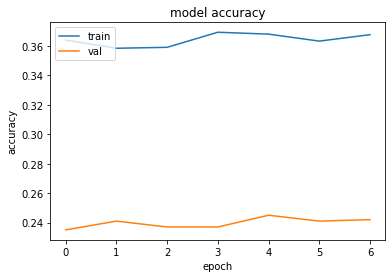

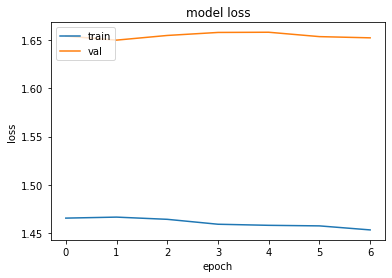

In [ ]:
history1_or = new_model_or1.fit(X1_or_sm, y1_or_df_sm, validation_data = (X_val_or_sm,y_val_or_sm),
               epochs=50,batch_size=64, callbacks =[cp_or1,early_stopping_monitor], verbose = False)

# summarize history for accuracy
plt.plot(history1_or.history['categorical_accuracy'])
plt.plot(history1_or.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history1_or.history['loss'])
plt.plot(history1_or.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

##### 2.objective : False Negative

In [ ]:
def build_model_or2(hp):
  model_or2 = Sequential()
  model_or2.add(BatchNormalization())
  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
  model_or2.add(Dense(units=hp_units1, activation= LeakyReLU))
  model_or2.add(Dropout(hp.Choice('dropout_1', values=[0.0, 0.1, 0.2, 0.3])))
  model_or2.add(BatchNormalization())
  model_or2.add(Dense(units=hp_units2, activation= LeakyReLU))
  model_or2.add(Dropout(hp.Choice('dropout_2', values=[0.0, 0.1, 0.2, 0.3])))
  model_or2.add(BatchNormalization())
  model_or2.add(Dense(units=hp_units3, activation= LeakyReLU))
  model_or2.add(Dropout(hp.Choice('dropout_3', values=[0.0, 0.1, 0.2, 0.3])))
  model_or2.add(BatchNormalization())
  model_or2.add(Dense(6, activation='softmax'))

  hp_optimizer_or=hp.Choice('Optimizer', values=['Adam', 'SGD'])
  if hp_optimizer_or == 'Adam':
    hp_learning_rate = hp.Choice('learning_rate_or', values=[1e-1, 1e-2, 1e-3])
  elif hp_optimizer_or == 'SGD':
    hp_learning_rate = hp.Choice('learning_rate_or', values=[1e-1, 1e-2, 1e-3])
    nesterov=True
    momentum=0.9

  model_or2.compile(
      optimizer= hp_optimizer_or,
      loss='categorical_crossentropy',
      metrics=[keras.metrics.FalseNegatives(name='false_negatives'),
               'categorical_accuracy']
  )
  return model_or2

# HyperBand algorithm from keras tuner
tuner_or2 = kt.Hyperband(
    build_model_or2,
    objective= kt.Objective('val_false_negatives', direction="min"),
    max_epochs=50,
    directory='or_dir2',
    project_name='crook2',
    overwrite= True
)
early_stopping_monitor = EarlyStopping(patience=5)
tuner_or2.search(X1_or_sm, y1_or_df_sm, epochs=50, validation_data = (X_val_or_sm,y_val_or_sm),
             callbacks=[early_stopping_monitor])

Trial 90 Complete [00h 00m 40s]
val_false_negatives: 753.0

Best val_false_negatives So Far: 693.0
Total elapsed time: 00h 30m 50s


In [ ]:
best_mlp_hyperparameters_or2 = tuner_or2.get_best_hyperparameters(1)[0]
print("Best Hyper-parameters")
best_mlp_hyperparameters_or2.values

Best Hyper-parameters


{'units1': 384,
 'units2': 384,
 'units3': 448,
 'dropout_1': 0.0,
 'dropout_2': 0.1,
 'dropout_3': 0.0,
 'Optimizer': 'Adam',
 'learning_rate_or': 0.001,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 3,
 'tuner/round': 0}

In [ ]:
best_model_or2 = tuner_or2.get_best_models()[0]
best_model_or2.build(X1_or_sm.shape)
best_model_or2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (10955, 49)              196       
 ormalization)                                                   
                                                                 
 dense (Dense)               (10955, 384)              19200     
                                                                 
 dropout (Dropout)           (10955, 384)              0         
                                                                 
 batch_normalization_1 (Batc  (10955, 384)             1536      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (10955, 384)              147840    
                                                                 
 dropout_1 (Dropout)         (10955, 384)              0

In [ ]:
new_model_or2 = Sequential()
new_model_or2.add(tf.keras.Input(shape=(49,)))
new_model_or2.add(BatchNormalization())
new_model_or2.add(Dense(384, activation = LeakyReLU))
new_model_or2.add(BatchNormalization())
new_model_or2.add(Dense(384, activation = LeakyReLU))
new_model_or2.add(Dropout(0.1))
new_model_or2.add(BatchNormalization())
new_model_or2.add(Dense(448, activation = LeakyReLU))
new_model_or2.add(BatchNormalization())
new_model_or2.add((Dense(6, activation='softmax')))
new_model_or2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_4 (Batc  (None, 49)               196       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 384)               19200     
                                                                 
 batch_normalization_5 (Batc  (None, 384)              1536      
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 384)               147840    
                                                                 
 dropout_3 (Dropout)         (None, 384)               0         
                                                                 
 batch_normalization_6 (Batc  (None, 384)             

In [ ]:
cp_or2 = ModelCheckpoint('new_model_or2/', save_best_only=True)
opt_or2 = keras.optimizers.Adam(learning_rate=0.001)
new_model_or2.compile(optimizer = opt_or2, loss ='categorical_crossentropy', metrics =['categorical_accuracy'])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)

new_model_or2.fit(X1_or_sm, y1_or_df_sm, validation_data = (X_val_or_sm,y_val_or_sm),
               epochs=50,batch_size=64, callbacks =[cp_or2,early_stopping_monitor])

Epoch 1/50
170/172 [============================>.] - ETA: 0s - loss: 1.6687 - categorical_accuracy: 0.3141

172/172 [==============================] - 7s 34ms/step - loss: 1.6683 - categorical_accuracy: 0.3138 - val_loss: 19.4613 - val_categorical_accuracy: 0.2500
Epoch 2/50
170/172 [============================>.] - ETA: 0s - loss: 1.4418 - categorical_accuracy: 0.3687

172/172 [==============================] - 4s 25ms/step - loss: 1.4421 - categorical_accuracy: 0.3681 - val_loss: 8.8400 - val_categorical_accuracy: 0.2500
Epoch 3/50
172/172 [==============================] - ETA: 0s - loss: 1.3830 - categorical_accuracy: 0.3951

172/172 [==============================] - 4s 25ms/step - loss: 1.3830 - categorical_accuracy: 0.3951 - val_loss: 6.2356 - val_categorical_accuracy: 0.2510
Epoch 4/50
168/172 [============================>.] - ETA: 0s - loss: 1.3514 - categorical_accuracy: 0.4074

172/172 [==============================] - 5s 28ms/step - loss: 1.3505 - categorical_accuracy: 0.4071 - val_loss: 3.1786 - val_categorical_accuracy: 0.2112
Epoch 5/50
170/172 [============================>.] - ETA: 0s - loss: 1.3286 - categorical_accuracy: 0.4148

172/172 [==============================] - 4s 26ms/step - loss: 1.3303 - categorical_accuracy: 0.4141 - val_loss: 2.6251 - val_categorical_accuracy: 0.1096
Epoch 6/50
171/172 [============================>.] - ETA: 0s - loss: 1.3221 - categorical_accuracy: 0.4204

172/172 [==============================] - 4s 26ms/step - loss: 1.3224 - categorical_accuracy: 0.4204 - val_loss: 2.1619 - val_categorical_accuracy: 0.1315
Epoch 7/50
170/172 [============================>.] - ETA: 0s - loss: 1.2914 - categorical_accuracy: 0.4282

172/172 [==============================] - 4s 25ms/step - loss: 1.2906 - categorical_accuracy: 0.4288 - val_loss: 1.6742 - val_categorical_accuracy: 0.2430
Epoch 8/50
172/172 [==============================] - 2s 13ms/step - loss: 1.2779 - categorical_accuracy: 0.4373 - val_loss: 1.7674 - val_categorical_accuracy: 0.2201
Epoch 9/50
168/172 [============================>.] - ETA: 0s - loss: 1.2686 - categorical_accuracy: 0.4431

172/172 [==============================] - 5s 28ms/step - loss: 1.2674 - categorical_accuracy: 0.4447 - val_loss: 1.6623 - val_categorical_accuracy: 0.2122
Epoch 10/50
168/172 [============================>.] - ETA: 0s - loss: 1.2586 - categorical_accuracy: 0.4445

172/172 [==============================] - 4s 26ms/step - loss: 1.2596 - categorical_accuracy: 0.4442 - val_loss: 1.5018 - val_categorical_accuracy: 0.2869
Epoch 11/50
172/172 [==============================] - 2s 13ms/step - loss: 1.2270 - categorical_accuracy: 0.4515 - val_loss: 1.7535 - val_categorical_accuracy: 0.2052
Epoch 12/50
172/172 [==============================] - 2s 13ms/step - loss: 1.2288 - categorical_accuracy: 0.4566 - val_loss: 1.5860 - val_categorical_accuracy: 0.2440
Epoch 13/50
172/172 [==============================] - 2s 13ms/step - loss: 1.2204 - categorical_accuracy: 0.4626 - val_loss: 1.7742 - val_categorical_accuracy: 0.2301
Epoch 14/50
172/172 [==============================] - 2s 13ms/step - loss: 1.2116 - categorical_accuracy: 0.4668 - val_loss: 1.6736 - val_categorical_accuracy: 0.2241
Epoch 15/50
172/172 [==============================] - 2s 13ms/step - loss: 1.1930 - categorical_accuracy: 0.4778 - val_loss: 1.5912 - val_categorical_accuracy: 0.2550


In [ ]:
test_predictions_or2 = new_model_or2.predict(X_test_or)
test_predictions_or2

23/23 [==============================] - 0s 4ms/step


array([[2.7858338e-01, 1.1129168e-01, 4.8220801e-01, 1.1896655e-01,
        8.8804523e-03, 6.9973146e-05],
       [2.3495446e-01, 1.5905812e-01, 4.9087191e-01, 1.0543706e-01,
        9.6450122e-03, 3.3366123e-05],
       [4.6667862e-01, 1.5951633e-01, 2.4309328e-01, 1.2933595e-01,
        1.3673406e-03, 8.3777604e-06],
       ...,
       [3.0557132e-01, 2.8100929e-01, 3.2385084e-01, 8.9333296e-02,
        2.2369852e-04, 1.1597239e-05],
       [1.9561659e-01, 1.5918249e-01, 4.0591431e-01, 1.2692073e-01,
        1.1221862e-01, 1.4716909e-04],
       [1.9813801e-01, 8.4643148e-02, 3.4888166e-01, 2.2826195e-01,
        1.3987456e-01, 2.0058626e-04]], dtype=float32)

In [ ]:
classes_or2 = np.argmax(test_predictions_or2, axis=-1)
classes_or2

array([2, 2, 0, 0, 0, 4, 2, 2, 0, 0, 0, 4, 2, 2, 0, 2, 0, 2, 1, 4, 4, 2,
       0, 1, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0,
       1, 0, 4, 0, 0, 4, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 2, 1, 0, 4, 4, 2, 2, 2, 2, 1, 0, 1, 4, 2, 2, 3, 2, 1,
       1, 0, 0, 1, 0, 3, 2, 2, 4, 1, 2, 0, 2, 0, 0, 1, 0, 0, 1, 0, 0, 3,
       1, 0, 0, 3, 0, 1, 2, 0, 3, 3, 2, 0, 0, 0, 0, 1, 3, 3, 3, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 3, 3, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1,
       1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1,
       1, 3, 3, 1, 1, 3, 1, 1, 1, 1, 2, 3, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1,
       1, 3, 1, 1, 1, 2, 3, 3, 3, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1,
       1, 3, 3, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 3, 1, 3, 3, 3, 3, 1, 1, 1,
       3, 3, 3, 3, 0, 1, 1, 1, 3, 1, 1, 1, 3, 3, 3, 1, 1, 1, 3, 3, 3, 1,
       4, 3, 0, 3, 3, 3, 1, 1, 1, 0, 0, 1, 1, 1, 2, 0, 2, 2, 2, 2, 0, 0,
       0, 4, 3, 3, 3, 4, 2, 0, 0, 1, 0, 0, 2, 2, 2,

In [ ]:
classes_or2 =pd.DataFrame(classes_or2, columns=['Test Predictions']) 
classes_or2

Test Predictions
0                   2
1                   2
2                   0
3                   0
4                   0
..                ...
726                 4
727                 2
728                 2
729                 2
730                 2

[731 rows x 1 columns]

In [ ]:
classes_or2 = classes_or2.values.ravel()

In [ ]:
result_or2 = pd.DataFrame({'Test Predictions':classes_or2, 'Actuals':y_test_or})
result_or2[0:31]

Test Predictions  Actuals
0                  2        3
1                  2        3
2                  0        3
3                  0        3
4                  0        3
5                  4        3
6                  2        3
7                  2        3
8                  0        3
9                  0        3
10                 0        3
11                 4        3
12                 2        3
13                 2        3
14                 0        3
15                 2        3
16                 0        3
17                 2        3
18                 1        3
19                 4        3
20                 4        3
21                 2        3
22                 0        3
23                 1        3
24                 2        3
25                 2        3
26                 2        3
27                 2        3
28                 2        3
29                 2        3
30                 2        3

######model 2 evaluation

In [ ]:
print(classification_report(y_test_or, classes_or2))

              precision    recall  f1-score   support

           0       0.22      0.15      0.18       225
           1       0.03      0.08      0.04        84
           2       0.19      0.32      0.23        95
           3       0.25      0.14      0.18       210
           4       0.41      0.24      0.30       117

    accuracy                           0.18       731
   macro avg       0.22      0.19      0.19       731
weighted avg       0.23      0.18      0.19       731



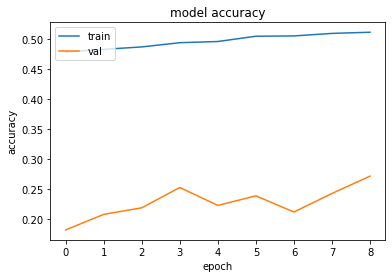

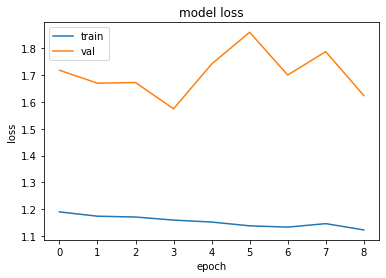

In [ ]:
history2_or = new_model_or2.fit(X1_or_sm, y1_or_df_sm, validation_data = (X_val_or_sm,y_val_or_sm),
               epochs=50,batch_size=64, callbacks =[cp_or2,early_stopping_monitor], verbose = False)

# summarize history for accuracy
plt.plot(history2_or.history['categorical_accuracy'])
plt.plot(history2_or.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2_or.history['loss'])
plt.plot(history2_or.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

##### 3.objective : Categorical Crossentropy loss

In [ ]:
def build_model_or3(hp):
  model_or3 = Sequential()
  model_or3.add(BatchNormalization())
  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
  model_or3.add(Dense(units=hp_units1, activation= LeakyReLU))
  model_or3.add(Dropout(hp.Choice('dropout_1', values=[0.0, 0.1, 0.2, 0.3])))
  model_or3.add(BatchNormalization())
  model_or3.add(Dense(units=hp_units2, activation= LeakyReLU))
  model_or3.add(Dropout(hp.Choice('dropout_2', values=[0.0, 0.1, 0.2, 0.3])))
  model_or3.add(BatchNormalization())
  model_or3.add(Dense(units=hp_units3, activation= LeakyReLU))
  model_or3.add(Dropout(hp.Choice('dropout_3', values=[0.0, 0.1, 0.2, 0.3])))
  model_or3.add(BatchNormalization())
  model_or3.add(Dense(6, activation='softmax'))

  hp_optimizer_or=hp.Choice('Optimizer', values=['Adam', 'SGD'])
  if hp_optimizer_or == 'Adam':
    hp_learning_rate = hp.Choice('learning_rate_or', values=[1e-1, 1e-2, 1e-3])
  elif hp_optimizer_or == 'SGD':
    hp_learning_rate = hp.Choice('learning_rate_or', values=[1e-1, 1e-2, 1e-3])
    nesterov=True
    momentum=0.9

  model_or3.compile(
      optimizer= hp_optimizer_or,
      loss='categorical_crossentropy',
      metrics=['categorical_crossentropy']
  )
  return model_or3

# HyperBand algorithm from keras tuner
tuner_or3 = kt.Hyperband(
    build_model_or3,
    objective= kt.Objective('val_categorical_crossentropy', direction="min"),
    max_epochs=50,
    directory='or_dir3',
    project_name='crook3',
    overwrite= True
)
early_stopping_monitor = EarlyStopping(patience=5)
tuner_or3.search(X1_or_sm, y1_or_df_sm, epochs=50, validation_data = (X_val_or_sm,y_val_or_sm),
             callbacks=[early_stopping_monitor])

In [ ]:
best_mlp_hyperparameters_or3 = tuner_or3.get_best_hyperparameters(1)[0]
print("Best Hyper-parameters")
best_mlp_hyperparameters_or3.values

Best Hyper-parameters


{'units1': 320,
 'units2': 64,
 'units3': 320,
 'dropout_1': 0.0,
 'dropout_2': 0.0,
 'dropout_3': 0.2,
 'Optimizer': 'SGD',
 'learning_rate_or': 0.01,
 'tuner/epochs': 50,
 'tuner/initial_epoch': 17,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': '0071'}

In [ ]:
best_model_or3 = tuner_or3.get_best_models()[0]
best_model_or3.build(X1_or_sm.shape)
best_model_or3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (10955, 49)              196       
 ormalization)                                                   
                                                                 
 dense (Dense)               (10955, 320)              16000     
                                                                 
 dropout (Dropout)           (10955, 320)              0         
                                                                 
 batch_normalization_1 (Batc  (10955, 320)             1280      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (10955, 64)               20544     
                                                                 
 dropout_1 (Dropout)         (10955, 64)               0

In [ ]:
new_model_or3 = Sequential()
new_model_or3.add(tf.keras.Input(shape=(49,)))
new_model_or3.add(BatchNormalization())
new_model_or3.add(Dense(320, activation = LeakyReLU))
new_model_or3.add(BatchNormalization())
new_model_or3.add(Dense(64, activation = LeakyReLU))
new_model_or3.add(BatchNormalization())
new_model_or3.add(Dense(320, activation = LeakyReLU))
new_model_or3.add(Dropout(0.2))
new_model_or3.add(BatchNormalization())
new_model_or3.add((Dense(6, activation='softmax')))
new_model_or3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_4 (Batc  (None, 49)               196       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 320)               16000     
                                                                 
 batch_normalization_5 (Batc  (None, 320)              1280      
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 64)                20544     
                                                                 
 batch_normalization_6 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                      

In [ ]:
cp_or3 = ModelCheckpoint('new_model_or3/', save_best_only=True)
opt_or3 = keras.optimizers.SGD(learning_rate=0.01)
new_model_or3.compile(optimizer = opt_or3, loss ='categorical_crossentropy', metrics =['categorical_accuracy'])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)

new_model_or3.fit(X1_or_sm, y1_or_df_sm, validation_data = (X_val_or_sm,y_val_or_sm),
               epochs=50,batch_size=64, callbacks =[cp_or3,early_stopping_monitor])

Epoch 1/50
163/172 [===========================>..] - ETA: 0s - loss: 1.8588 - categorical_accuracy: 0.2731

172/172 [==============================] - 7s 29ms/step - loss: 1.8533 - categorical_accuracy: 0.2744 - val_loss: 49.7370 - val_categorical_accuracy: 0.2500
Epoch 2/50
172/172 [==============================] - 1s 7ms/step - loss: 1.6497 - categorical_accuracy: 0.3312 - val_loss: 64.1765 - val_categorical_accuracy: 0.2500
Epoch 3/50
165/172 [===========================>..] - ETA: 0s - loss: 1.5548 - categorical_accuracy: 0.3571

172/172 [==============================] - 4s 26ms/step - loss: 1.5562 - categorical_accuracy: 0.3564 - val_loss: 43.2065 - val_categorical_accuracy: 0.2500
Epoch 4/50
170/172 [============================>.] - ETA: 0s - loss: 1.5036 - categorical_accuracy: 0.3654

172/172 [==============================] - 4s 22ms/step - loss: 1.5036 - categorical_accuracy: 0.3653 - val_loss: 15.4139 - val_categorical_accuracy: 0.2500
Epoch 5/50
167/172 [============================>.] - ETA: 0s - loss: 1.4515 - categorical_accuracy: 0.3799

172/172 [==============================] - 3s 16ms/step - loss: 1.4503 - categorical_accuracy: 0.3793 - val_loss: 2.9131 - val_categorical_accuracy: 0.2510
Epoch 6/50
168/172 [============================>.] - ETA: 0s - loss: 1.4061 - categorical_accuracy: 0.4019

172/172 [==============================] - 6s 33ms/step - loss: 1.4053 - categorical_accuracy: 0.4026 - val_loss: 1.6174 - val_categorical_accuracy: 0.2072
Epoch 7/50
164/172 [===========================>..] - ETA: 0s - loss: 1.3907 - categorical_accuracy: 0.3949

172/172 [==============================] - 4s 26ms/step - loss: 1.3902 - categorical_accuracy: 0.3954 - val_loss: 1.5316 - val_categorical_accuracy: 0.2659
Epoch 8/50
172/172 [==============================] - 1s 7ms/step - loss: 1.3700 - categorical_accuracy: 0.4006 - val_loss: 1.6787 - val_categorical_accuracy: 0.2082
Epoch 9/50
172/172 [==============================] - 1s 8ms/step - loss: 1.3500 - categorical_accuracy: 0.4155 - val_loss: 1.5696 - val_categorical_accuracy: 0.2819
Epoch 10/50
172/172 [==============================] - 1s 7ms/step - loss: 1.3342 - categorical_accuracy: 0.4178 - val_loss: 1.5448 - val_categorical_accuracy: 0.2849
Epoch 11/50
172/172 [==============================] - 1s 7ms/step - loss: 1.3153 - categorical_accuracy: 0.4260 - val_loss: 1.6076 - val_categorical_accuracy: 0.2400
Epoch 12/50
172/172 [==============================] - 1s 7ms/step - loss: 1.3116 - categorical_accuracy: 0.4287 - val_loss: 1.6486 - val_categorical_accuracy: 0.2112


In [ ]:
test_predictions_or3 = new_model_or3.predict(X_test_or)
test_predictions_or3

23/23 [==============================] - 0s 2ms/step


array([[1.8071935e-01, 1.7089210e-01, 3.6812481e-01, 1.9514978e-01,
        7.7574857e-02, 7.5390548e-03],
       [1.7600699e-01, 2.6171163e-01, 4.4921044e-01, 9.0017632e-02,
        1.9641342e-02, 3.4120425e-03],
       [2.4766651e-01, 2.8507322e-01, 3.4440273e-01, 9.4707571e-02,
        2.4825228e-02, 3.3246537e-03],
       ...,
       [1.2784901e-01, 3.1062233e-01, 3.7689286e-01, 1.4739415e-01,
        3.1936735e-02, 5.3049210e-03],
       [2.2428420e-01, 1.3919225e-01, 4.8263237e-01, 1.5175933e-01,
        4.6191478e-04, 1.6699716e-03],
       [6.1910085e-02, 6.3021444e-02, 1.1795886e-01, 9.3442105e-02,
        6.5235686e-01, 1.1310642e-02]], dtype=float32)

In [ ]:
classes_or3 = np.argmax(test_predictions_or3, axis=-1)
classes_or3

array([2, 2, 2, 1, 1, 4, 2, 2, 1, 2, 1, 0, 2, 2, 2, 2, 1, 2, 3, 2, 4, 3,
       0, 4, 0, 1, 4, 2, 2, 2, 2, 0, 0, 0, 0, 1, 1, 2, 2, 0, 1, 1, 1, 0,
       1, 1, 0, 2, 2, 2, 0, 2, 1, 4, 0, 0, 0, 4, 2, 4, 2, 2, 2, 2, 0, 2,
       2, 1, 3, 2, 2, 1, 0, 4, 4, 1, 2, 1, 2, 3, 3, 3, 4, 2, 4, 2, 4, 3,
       1, 4, 3, 3, 0, 3, 2, 2, 2, 0, 2, 0, 2, 3, 2, 1, 3, 0, 1, 0, 0, 3,
       1, 0, 0, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 0, 0, 0, 3, 2, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 3, 3, 0, 3, 1, 0, 0, 3, 3, 0, 0, 0, 0,
       0, 0, 3, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 3,
       2, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0,
       0, 3, 2, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 3, 1, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 3, 3, 0, 3, 0, 0, 2, 0, 3, 3, 3, 0,
       4, 3, 0, 3, 0, 3, 0, 3, 3, 3, 2, 4, 3, 0, 0, 1, 0, 2, 2, 1, 1, 3,
       4, 4, 3, 2, 3, 2, 3, 0, 0, 0, 1, 0, 2, 2, 2,

In [ ]:
classes_or3 =pd.DataFrame(classes_or3, columns=['Test Predictions']) 
classes_or3

Test Predictions
0                   2
1                   2
2                   2
3                   1
4                   1
..                ...
726                 2
727                 2
728                 2
729                 2
730                 4

[731 rows x 1 columns]

In [ ]:
classes_or3 = classes_or3.values.ravel()

In [ ]:
result_or3 = pd.DataFrame({'Test Predictions':classes_or3, 'Actuals':y_test_or})
result_or3[0:31]

Test Predictions  Actuals
0                  2        3
1                  2        3
2                  2        3
3                  1        3
4                  1        3
5                  4        3
6                  2        3
7                  2        3
8                  1        3
9                  2        3
10                 1        3
11                 0        3
12                 2        3
13                 2        3
14                 2        3
15                 2        3
16                 1        3
17                 2        3
18                 3        3
19                 2        3
20                 4        3
21                 3        3
22                 0        3
23                 4        3
24                 0        3
25                 1        3
26                 4        3
27                 2        3
28                 2        3
29                 2        3
30                 2        3

######model 3 evaluation

In [ ]:
print(classification_report(y_test_or, classes_or3))

              precision    recall  f1-score   support

           0       0.45      0.51      0.48       225
           1       0.11      0.14      0.12        84
           2       0.22      0.42      0.29        95
           3       0.17      0.08      0.11       210
           4       0.36      0.27      0.31       117

    accuracy                           0.29       731
   macro avg       0.26      0.28      0.26       731
weighted avg       0.29      0.29      0.28       731



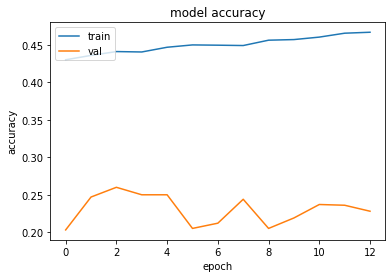

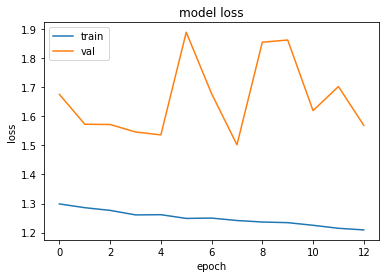

In [ ]:
history3_or = new_model_or3.fit(X1_or_sm, y1_or_df_sm, validation_data = (X_val_or_sm,y_val_or_sm),
               epochs=50,batch_size=64, callbacks =[cp_or3,early_stopping_monitor], verbose = False)

# summarize history for accuracy
plt.plot(history3_or.history['categorical_accuracy'])
plt.plot(history3_or.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history3_or.history['loss'])
plt.plot(history3_or.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

####comparing the models

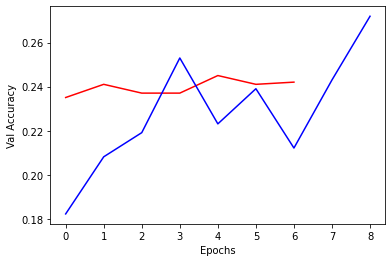

In [ ]:
plt.plot(history1_or.history['val_categorical_accuracy'], 'r', history2_or.history['val_categorical_accuracy'], 'b')
plt.xlabel('Epochs')
plt.ylabel('Val Accuracy')
plt.show()

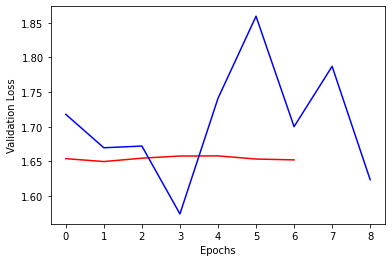

In [ ]:
plt.plot(history1_or.history['val_loss'], 'r', history2_or.history['val_loss'], 'b')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.show()

###MLP model with weather and soil data (without date variable) REGRESSION

####preprocessing data

In [ ]:
score_or = train_or['score']
score_val_or = val_or['score']
score_test_or = test_or['score']

In [ ]:
score_arr_or = score_or.copy()
score_val_arr_or = score_val_or.copy()
score_test_arr_or = score_test_or.copy()

In [ ]:
score_arr_or = score_arr_or.to_numpy()
score_val_arr_or = score_val_arr_or.to_numpy()
score_test_arr_or = score_test_arr_or.to_numpy()

In [ ]:
score_arr_or =pd.DataFrame(score_arr_or, columns=['Score']) 
score_arr_or

Score
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
...     ...
6205    0.0
6206    0.0
6207    0.0
6208    0.0
6209    0.0

[6210 rows x 1 columns]

In [ ]:
score_val_arr_or =pd.DataFrame(score_val_arr_or, columns=['Score']) 
score_val_arr_or

Score
0    0.0000
1    0.0000
2    0.0000
3    0.0000
4    0.0000
..      ...
725  3.4613
726  3.4613
727  3.4613
728  3.4613
729  3.4613

[730 rows x 1 columns]

In [ ]:
score_test_arr_or =pd.DataFrame(score_test_arr_or, columns=['Score']) 
score_test_arr_or

Score
0    3.4613
1    3.4613
2    3.4613
3    3.4613
4    3.4613
..      ...
726  3.9696
727  3.9696
728  3.9696
729  3.9696
730  3.9696

[731 rows x 1 columns]

In [ ]:
crook_train = train_or.copy()
crook_val = val_or.copy()
crook_test = test_or.copy()

In [ ]:
X1_or = crook_train.drop(columns=['fips','date','score'])
X_or_val = crook_val.drop(columns=['fips','date','score'])
X_or_test = crook_test.drop(columns=['fips','date','score'])

In [ ]:
X1_or, y1_or = X1_or, score_arr_or
X_val_or, y_val_or = X_or_val, score_val_arr_or
X_test_or, y_test_or = X_or_test, score_test_arr_or
X1_or.shape, y1_or.shape, X_val_or.shape, y_val_or.shape, X_test_or.shape, y_test_or.shape

((6210, 49), (6210, 1), (730, 49), (730, 1), (731, 49), (731, 1))

####build the model

In [ ]:
new_model_reg_or1 = Sequential()
new_model_reg_or1.add(tf.keras.Input(shape=(49,)))
new_model_reg_or1.add(BatchNormalization())
new_model_reg_or1.add(Dense(128, activation = "elu", kernel_initializer="he_normal"))
new_model_reg_or1.add(BatchNormalization())
new_model_reg_or1.add(Dense(64, activation = "elu", kernel_initializer="he_normal"))
new_model_reg_or1.add(BatchNormalization())
new_model_reg_or1.add((Dense(1, activation='linear')))
new_model_reg_or1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_6 (Batc  (None, 49)               196       
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 128)               6400      
                                                                 
 batch_normalization_7 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_8 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                      

In [ ]:
opt_reg_or1 = keras.optimizers.Adam(learning_rate=0.001)
new_model_reg_or1.compile(optimizer = opt_reg_or1, loss =MeanSquaredError(), metrics =[RootMeanSquaredError()])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)

new_model_reg_or1.fit(X1_or, y1_or, validation_data = (X_val_or, y_val_or),
               epochs=50,batch_size=64, callbacks =[early_stopping_monitor])

Epoch 1/50
98/98 [==============================] - 1s 7ms/step - loss: 1.1265 - root_mean_squared_error: 1.0614 - val_loss: 1.5936 - val_root_mean_squared_error: 1.2624
Epoch 2/50
98/98 [==============================] - 0s 4ms/step - loss: 1.1189 - root_mean_squared_error: 1.0578 - val_loss: 1.6923 - val_root_mean_squared_error: 1.3009
Epoch 3/50
98/98 [==============================] - 0s 4ms/step - loss: 1.1201 - root_mean_squared_error: 1.0584 - val_loss: 1.6107 - val_root_mean_squared_error: 1.2691
Epoch 4/50
98/98 [==============================] - 0s 4ms/step - loss: 1.1209 - root_mean_squared_error: 1.0587 - val_loss: 1.5931 - val_root_mean_squared_error: 1.2622
Epoch 5/50
98/98 [==============================] - 0s 4ms/step - loss: 1.1182 - root_mean_squared_error: 1.0574 - val_loss: 1.6881 - val_root_mean_squared_error: 1.2993
Epoch 6/50
98/98 [==============================] - 0s 5ms/step - loss: 1.1376 - root_mean_squared_error: 1.0666 - val_loss: 1.6197 - val_root_mean_sq

In [ ]:
test_predictions_reg_or1 = new_model_reg_or1.predict(X_test_or).flatten()
test_predictions_reg_or1

23/23 [==============================] - 0s 2ms/step


array([1.1651112 , 0.9490113 , 0.79006827, 0.74319935, 0.6278097 ,
       0.9586455 , 1.0834492 , 0.8613508 , 1.2086064 , 0.9856953 ,
       0.88573605, 0.8664111 , 1.064806  , 0.91382897, 0.79722357,
       0.9920721 , 0.9214962 , 1.4390754 , 1.0077556 , 1.1676334 ,
       0.94049704, 1.1246861 , 1.687829  , 1.2447811 , 1.2197334 ,
       1.4088067 , 1.4997079 , 1.051076  , 1.2808173 , 1.4638854 ,
       1.2829475 , 0.99400264, 0.50671405, 0.8850049 , 0.4140482 ,
       0.45704418, 0.78801847, 0.94209003, 0.7540367 , 0.7985146 ,
       0.3368687 , 0.5020538 , 0.71914935, 0.9092034 , 0.79950404,
       0.547356  , 0.888236  , 0.807047  , 0.9123459 , 0.8131546 ,
       0.7284434 , 0.77370405, 0.6575209 , 1.0836443 , 0.86736846,
       0.8919903 , 1.0658128 , 1.078566  , 0.78010684, 1.0348321 ,
       0.88080364, 0.975744  , 0.95581025, 0.9896975 , 0.71540856,
       0.88988805, 0.80567384, 0.67538553, 1.0435271 , 1.0782775 ,
       0.74089026, 1.0525758 , 1.0518975 , 1.5082912 , 1.57125

In [ ]:
test_predictions_reg_or1 =pd.DataFrame(test_predictions_reg_or1, columns=['Test Predictions']) 
test_predictions_reg_or1

Test Predictions
0            1.165111
1            0.949011
2            0.790068
3            0.743199
4            0.627810
..                ...
726          0.827099
727          0.947651
728          1.001044
729          1.031066
730          1.115927

[731 rows x 1 columns]

In [ ]:
test_predictions_reg_or1 = test_predictions_reg_or1.values.ravel()
y_test_or = y_test_or.values.ravel()

In [ ]:
test_results_reg_or_1 = pd.DataFrame(data={'predictions':test_predictions_reg_or1, 'actuals':y_test_or})
test_results_reg_or_1

predictions  actuals
0       1.165111   3.4613
1       0.949011   3.4613
2       0.790068   3.4613
3       0.743199   3.4613
4       0.627810   3.4613
..           ...      ...
726     0.827099   3.9696
727     0.947651   3.9696
728     1.001044   3.9696
729     1.031066   3.9696
730     1.115927   3.9696

[731 rows x 2 columns]

In [ ]:
test_results_reg_or_1[500:550]

predictions   actuals
500     1.307997  2.639100
501     1.437720  2.639100
502     1.014311  2.639100
503     0.922879  2.639100
504     0.902970  2.639100
505     1.614851  2.639100
506     1.176197  2.639100
507     0.961130  2.639100
508     1.407780  2.639100
509     1.256909  2.639100
510     1.079875  2.639100
511     1.059890  2.639100
512     1.182711  2.639100
513     1.182195  2.639100
514     1.112661  2.639100
515     0.513864  2.639100
516     1.185071  2.639100
517     1.394327  2.639100
518     1.190161  2.639100
519     1.146799  2.638786
520     1.235080  2.638471
521     0.913934  2.638157
522     0.883754  2.637843
523     1.001118  2.637529
524     1.416024  2.637214
525     1.137088  2.636900
526     0.742234  2.664271
527     1.101725  2.691643
528     0.913476  2.719014
529     1.126587  2.746386
530     1.340850  2.773757
531     1.143355  2.801129
532     1.079138  2.828500
533     1.027258  2.854443
534     1.037485  2.880386
535     1.159519  2.906329
536     1.052307  2.932271
537     1.328116  2.958214
538     1.103953  2.984157
539     1.186934  3.010100
540     0.934377  3.010100
541     1.285724  3.010100
542     1.564884  3.010100
543     1.238867  3.010100
544     0.982904  3.010100
545     1.175900  3.010100
546     1.101073  3.010100
547     1.247930  3.010657
548     1.222719  3.011214
549     1.326620  3.011771

####model evaluation

In [ ]:
new_model_reg_or1.evaluate(X1_or,y1_or)

195/195 [==============================] - 0s 2ms/step - loss: 1.1190 - root_mean_squared_error: 1.0578


[1.1189829111099243, 1.0578198432922363]

In [ ]:
new_model_reg_or1.evaluate(X_test_or,y_test_or)

23/23 [==============================] - 0s 2ms/step - loss: 2.7507 - root_mean_squared_error: 1.6585


[2.750683546066284, 1.6585184335708618]

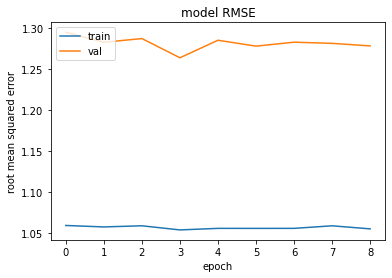

In [ ]:
history_reg_or_1 = new_model_reg_or1.fit(X1_or, y1_or, validation_data = (X_val_or,y_val_or),
               epochs=50,batch_size=64, callbacks =[early_stopping_monitor], verbose=False)

# summarize history for accuracy
plt.plot(history_reg_or_1.history['root_mean_squared_error'])
plt.plot(history_reg_or_1.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('root mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
test_results_reg_or_1.predictions[test_results_reg_or_1.predictions <0.5] = 0
test_results_reg_or_1.predictions[(test_results_reg_or_1.predictions >=0.5)&(test_results_reg_or_1.predictions<1.5)] = 1
test_results_reg_or_1.predictions[(test_results_reg_or_1.predictions >=1.5)&(test_results_reg_or_1.predictions<2.5)] = 2
test_results_reg_or_1.predictions[(test_results_reg_or_1.predictions >=2.5)&(test_results_reg_or_1.predictions<3.5)] = 3
test_results_reg_or_1.predictions[(test_results_reg_or_1.predictions >=3.5)&(test_results_reg_or_1.predictions<4.5)] = 4
test_results_reg_or_1.predictions[(test_results_reg_or_1.predictions >=4.5)&(test_results_reg_or_1.predictions<5.5)] = 5
test_results_reg_or_1.actuals[test_results_reg_or_1.actuals <0.5] = 0
test_results_reg_or_1.actuals[(test_results_reg_or_1.actuals >=0.5)&(test_results_reg_or_1.actuals<1.5)] = 1
test_results_reg_or_1.actuals[(test_results_reg_or_1.actuals >=1.5)&(test_results_reg_or_1.actuals<2.5)] = 2
test_results_reg_or_1.actuals[(test_results_reg_or_1.actuals >=2.5)&(test_results_reg_or_1.actuals<3.5)] = 3
test_results_reg_or_1.actuals[(test_results_reg_or_1.actuals >=3.5)&(test_results_reg_or_1.actuals<4.5)] = 4
test_results_reg_or_1.actuals[(test_results_reg_or_1.actuals >=4.5)&(test_results_reg_or_1.actuals<5.5)] = 5
test_results_reg_or_1

predictions  actuals
0            1.0      3.0
1            1.0      3.0
2            1.0      3.0
3            1.0      3.0
4            1.0      3.0
..           ...      ...
726          1.0      4.0
727          1.0      4.0
728          1.0      4.0
729          1.0      4.0
730          1.0      4.0

[731 rows x 2 columns]

In [ ]:
test_results_reg_or_1[200:250]

predictions  actuals
200          2.0      0.0
201          1.0      0.0
202          1.0      0.0
203          1.0      0.0
204          1.0      0.0
205          2.0      0.0
206          2.0      0.0
207          1.0      0.0
208          1.0      0.0
209          1.0      0.0
210          1.0      0.0
211          1.0      0.0
212          1.0      0.0
213          1.0      0.0
214          1.0      0.0
215          1.0      0.0
216          2.0      0.0
217          1.0      0.0
218          1.0      0.0
219          1.0      0.0
220          1.0      0.0
221          1.0      0.0
222          1.0      0.0
223          1.0      0.0
224          1.0      0.0
225          1.0      0.0
226          1.0      0.0
227          1.0      0.0
228          1.0      0.0
229          1.0      0.0
230          1.0      0.0
231          1.0      0.0
232          1.0      0.0
233          1.0      0.0
234          1.0      0.0
235          2.0      0.0
236          1.0      0.0
237          1.0      0.0
238          1.0      0.0
239          1.0      0.0
240          1.0      0.0
241          1.0      0.0
242          1.0      0.0
243          1.0      0.0
244          1.0      0.0
245          1.0      0.0
246          1.0      0.0
247          1.0      0.0
248          1.0      0.0
249          1.0      0.0

In [ ]:
print(classification_report(test_results_reg_or_1['actuals'], test_results_reg_or_1['predictions']))

              precision    recall  f1-score   support

         0.0       0.25      0.00      0.01       225
         1.0       0.13      0.98      0.23        84
         2.0       0.15      0.16      0.15        95
         3.0       0.00      0.00      0.00       210
         4.0       0.00      0.00      0.00       117

    accuracy                           0.13       731
   macro avg       0.11      0.23      0.08       731
weighted avg       0.11      0.13      0.05       731



###LSTM model without weather and soil data, only using previous drought scores

In [ ]:
def df_to_X_y(df, window_size=7):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
WINDOW_SIZE = 7
X_train_or, y_train_or = df_to_X_y(score_or, WINDOW_SIZE)
X_val1_or, y_val1_or = df_to_X_y(score_val_or, WINDOW_SIZE)
X_test1_or, y_test1_or = df_to_X_y(score_test_or, WINDOW_SIZE)
X_train_or.shape, y_train_or.shape, X_val1_or.shape, y_val1_or.shape, X_test1_or.shape, y_test1_or.shape

((6203, 7, 1), (6203,), (723, 7, 1), (723,), (724, 7, 1), (724,))

In [ ]:
model_1 = Sequential()
model_1.add(InputLayer((7,1)))
model_1.add(LSTM(64))
model_1.add(Dense(8, 'relu'))
model_1.add(Dense(1, 'linear'))

model_1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 64)                16896     
                                                                 
 dense_8 (Dense)             (None, 8)                 520       
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)

model_1.fit(X_train_or, y_train_or, validation_data=(X_val1_or, y_val1_or), epochs=50, 
           callbacks = [early_stopping_monitor])

Epoch 1/50
194/194 [==============================] - 4s 10ms/step - loss: 2.6477 - root_mean_squared_error: 1.6272 - val_loss: 2.9489 - val_root_mean_squared_error: 1.7172
Epoch 2/50
194/194 [==============================] - 2s 8ms/step - loss: 1.9072 - root_mean_squared_error: 1.3810 - val_loss: 1.4065 - val_root_mean_squared_error: 1.1860
Epoch 3/50
194/194 [==============================] - 1s 8ms/step - loss: 0.6462 - root_mean_squared_error: 0.8039 - val_loss: 0.3984 - val_root_mean_squared_error: 0.6312
Epoch 4/50
194/194 [==============================] - 1s 8ms/step - loss: 0.2619 - root_mean_squared_error: 0.5118 - val_loss: 0.1706 - val_root_mean_squared_error: 0.4130
Epoch 5/50
194/194 [==============================] - 1s 7ms/step - loss: 0.1316 - root_mean_squared_error: 0.3627 - val_loss: 0.0923 - val_root_mean_squared_error: 0.3038
Epoch 6/50
194/194 [==============================] - 1s 7ms/step - loss: 0.0859 - root_mean_squared_error: 0.2930 - val_loss: 0.0666 - val

####using the model to predict the test dataset

In [ ]:
test_prediction_or_1 = model_1.predict(X_test1_or).flatten()
test_results_or_1 = pd.DataFrame(data={'predictions':test_prediction_or_1, 'actuals':y_test1_or})
test_results_or_1

23/23 [==============================] - 1s 4ms/step


predictions  actuals
0       2.994104      3.0
1       2.994104      3.0
2       2.994104      3.0
3       2.994104      3.0
4       2.994104      3.0
..           ...      ...
719     3.977561      4.0
720     3.977561      4.0
721     3.977561      4.0
722     3.977561      4.0
723     3.977561      4.0

[724 rows x 2 columns]

In [ ]:
test_results_or_1.predictions[test_results_or_1.predictions <0.5] = 0
test_results_or_1.predictions[(test_results_or_1.predictions >=0.5)&(test_results_or_1.predictions<1.5)] = 1
test_results_or_1.predictions[(test_results_or_1.predictions >=1.5)&(test_results_or_1.predictions<2.5)] = 2
test_results_or_1.predictions[(test_results_or_1.predictions >=2.5)&(test_results_or_1.predictions<3.5)] = 3
test_results_or_1.predictions[(test_results_or_1.predictions >=3.5)&(test_results_or_1.predictions<4.5)] = 4
test_results_or_1.predictions[(test_results_or_1.predictions >=4.5)&(test_results_or_1.predictions<5.5)] = 5
test_results_or_1

predictions  actuals
0            3.0      3.0
1            3.0      3.0
2            3.0      3.0
3            3.0      3.0
4            3.0      3.0
..           ...      ...
719          4.0      4.0
720          4.0      4.0
721          4.0      4.0
722          4.0      4.0
723          4.0      4.0

[724 rows x 2 columns]

In [ ]:
test_results_or_1.actuals[test_results_or_1.actuals <0.5] = 0
test_results_or_1.actuals[(test_results_or_1.actuals >=0.5)&(test_results_or_1.actuals<1.5)] = 1
test_results_or_1.actuals[(test_results_or_1.actuals >=1.5)&(test_results_or_1.actuals<2.5)] = 2
test_results_or_1.actuals[(test_results_or_1.actuals >=2.5)&(test_results_or_1.actuals<3.5)] = 3
test_results_or_1.actuals[(test_results_or_1.actuals >=3.5)&(test_results_or_1.actuals<4.5)] = 4
test_results_or_1.actuals[(test_results_or_1.actuals >=4.5)&(test_results_or_1.actuals<5.5)] = 5
test_results_or_1

predictions  actuals
0            3.0      3.0
1            3.0      3.0
2            3.0      3.0
3            3.0      3.0
4            3.0      3.0
..           ...      ...
719          4.0      4.0
720          4.0      4.0
721          4.0      4.0
722          4.0      4.0
723          4.0      4.0

[724 rows x 2 columns]

####model evaluation

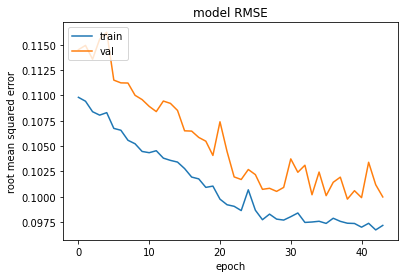

In [ ]:
history_or_1 = model_1.fit(X_train_or, y_train_or, validation_data=(X_val1_or, y_val1_or), epochs=50, 
           callbacks = [early_stopping_monitor], verbose = False)

# summarize history for accuracy
plt.plot(history_or_1.history['root_mean_squared_error'])
plt.plot(history_or_1.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('root mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
print(classification_report(test_results_or_1['actuals'], test_results_or_1['predictions']))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       225
         1.0       0.98      0.96      0.97        84
         2.0       0.98      0.98      0.98        95
         3.0       0.99      1.00      0.99       203
         4.0       1.00      0.99      1.00       117

    accuracy                           0.99       724
   macro avg       0.99      0.99      0.99       724
weighted avg       0.99      0.99      0.99       724



###LSTM model with only score data and time data but the time data is transformed using sine and cosine

####train

In [ ]:
train_or1 = train_or.copy()
train_or1.index = pd.to_datetime(train_or1['date'], format='%Y.%m.%d')
train_or1[:31]

fips        date  PRECTOT     PS  QV2M   T2M  T2MDEW  T2MWET  \
date                                                                        
2000-01-01  41013  2000-01-01     1.36  86.44  3.18 -2.51   -4.33   -4.31   
2000-01-02  41013  2000-01-02     4.38  86.85  3.06 -2.95   -4.71   -4.69   
2000-01-03  41013  2000-01-03     4.94  87.61  3.67 -1.29   -2.34   -2.34   
2000-01-04  41013  2000-01-04     3.92  87.32  3.87 -0.46   -1.69   -1.68   
2000-01-05  41013  2000-01-05     0.73  87.99  2.94 -3.37   -5.14   -5.12   
2000-01-06  41013  2000-01-06     1.48  87.67  2.72 -3.25   -6.45   -6.40   
2000-01-07  41013  2000-01-07     0.24  87.62  3.65 -1.22   -2.38   -2.38   
2000-01-08  41013  2000-01-08     2.01  87.03  3.70 -0.52   -2.31   -2.31   
2000-01-09  41013  2000-01-09     4.85  86.66  3.58 -1.23   -2.80   -2.80   
2000-01-10  41013  2000-01-10    15.86  85.95  3.87 -0.92   -1.91   -1.91   
2000-01-11  41013  2000-01-11     4.20  85.70  3.31 -2.70   -4.00   -3.99   
2000-01-12  41013  2000-01-12     1.58  86.64  2.62 -5.00   -6.74   -6.71   
2000-01-13  41013  2000-01-13     8.40  86.55  4.02 -0.28   -1.33   -1.33   
2000-01-14  41013  2000-01-14     3.26  86.72  4.25  0.35   -0.50   -0.50   
2000-01-15  41013  2000-01-15     2.14  86.63  3.89 -1.22   -1.80   -1.79   
2000-01-16  41013  2000-01-16     2.25  86.18  3.92  0.03   -1.70   -1.69   
2000-01-17  41013  2000-01-17     1.19  87.33  3.14 -2.59   -4.37   -4.36   
2000-01-18  41013  2000-01-18     0.27  87.13  3.44 -2.20   -3.25   -3.24   
2000-01-19  41013  2000-01-19     1.39  87.11  3.94 -0.71   -1.60   -1.60   
2000-01-20  41013  2000-01-20     1.18  86.86  3.90  0.11   -1.62   -1.61   
2000-01-21  41013  2000-01-21     0.13  86.77  3.14 -1.43   -4.46   -4.43   
2000-01-22  41013  2000-01-22     0.60  87.02  3.05 -2.27   -4.78   -4.76   
2000-01-23  41013  2000-01-23     3.08  86.81  3.18 -2.50   -4.44   -4.42   
2000-01-24  41013  2000-01-24     5.05  86.66  4.23  0.03   -0.53   -0.53   
2000-01-25  41013  2000-01-25     1.36  86.76  4.00 -0.24   -1.31   -1.31   
2000-01-26  41013  2000-01-26     0.73  87.47  2.92 -3.24   -5.23   -5.20   
2000-01-27  41013  2000-01-27     0.20  87.90  2.67 -4.19   -6.30   -6.27   
2000-01-28  41013  2000-01-28     0.00  87.60  2.17 -4.72   -8.80   -8.73   
2000-01-29  41013  2000-01-29     0.32  87.11  2.02 -4.97   -9.72   -9.61   
2000-01-30  41013  2000-01-30     1.91  86.39  2.59 -4.61   -7.32   -7.25   
2000-01-31  41013  2000-01-31     3.90  86.97  3.38 -1.25   -3.50   -3.48   

            T2M_MAX  T2M_MIN  T2M_RANGE    TS  WS10M  WS10M_MAX  WS10M_MIN  \
date                                                                         
2000-01-01    -0.27    -3.99       3.72 -2.72   5.06       8.35       2.90   
2000-01-02    -1.29    -4.06       2.77 -3.14   5.68       9.43       3.52   
2000-01-03     1.70    -4.33       6.04 -1.61   3.48       5.65       1.77   
2000-01-04     1.66    -3.40       5.06 -0.81   6.05       9.11       4.16   
2000-01-05     0.66    -8.30       8.96 -4.62   3.15       4.49       1.62   
2000-01-06     3.25    -8.44      11.69 -4.02   3.98       6.35       2.07   
2000-01-07     2.16    -3.17       5.33 -1.82   3.34       6.39       2.10   
2000-01-08     1.34    -2.77       4.12 -0.84   7.47      10.85       4.44   
2000-01-09     1.84    -3.27       5.11 -1.63   6.77       9.85       3.75   
2000-01-10     1.07    -3.09       4.16 -1.30   5.06       8.26       2.53   
2000-01-11     0.21    -5.58       5.79 -3.27   4.66       7.96       3.05   
2000-01-12    -2.19    -8.20       6.01 -5.53   6.11       7.87       4.23   
2000-01-13     1.67    -4.45       6.12 -0.97   6.48       7.97       4.71   
2000-01-14     3.05    -3.06       6.11 -0.83   4.51       6.63       1.60   
2000-01-15     1.51    -5.59       7.10 -2.35   4.05       8.25       0.85   
2000-01-16     2.41    -4.42       6.83 -0.73   7.43      11.16       2.85   
2000-01-17     3.49    -6.39       9.89 -3.81   3.16       4.87    

In [ ]:
scoreor = train_or1['score']
scoreor_df = pd.DataFrame({'score':scoreor})
scoreor_df['Seconds'] = scoreor_df.index.map(pd.Timestamp.timestamp)
scoreor_df

score       Seconds
date                           
2000-01-01    0.0  9.466848e+08
2000-01-02    0.0  9.467712e+08
2000-01-03    0.0  9.468576e+08
2000-01-04    0.0  9.469440e+08
2000-01-05    0.0  9.470304e+08
...           ...           ...
2016-12-27    0.0  1.482797e+09
2016-12-28    0.0  1.482883e+09
2016-12-29    0.0  1.482970e+09
2016-12-30    0.0  1.483056e+09
2016-12-31    0.0  1.483142e+09

[6210 rows x 2 columns]

In [ ]:
day = 60*60*24
month = 30.437*day
year = 365.2425*day

scoreor_df['Day sin'] = np.sin(scoreor_df['Seconds'] * (2* np.pi / day))
scoreor_df['Day cos'] = np.cos(scoreor_df['Seconds'] * (2 * np.pi / day))
scoreor_df['Month sin'] = np.sin(scoreor_df['Seconds'] * (2* np.pi / month))
scoreor_df['Month cos'] = np.cos(scoreor_df['Seconds'] * (2 * np.pi / month))
scoreor_df['Year sin'] = np.sin(scoreor_df['Seconds'] * (2 * np.pi / year))
scoreor_df['Year cos'] = np.cos(scoreor_df['Seconds'] * (2 * np.pi / year))
scoreor_df.head()

score      Seconds       Day sin  Day cos  Month sin  Month cos  \
date                                                                          
2000-01-01    0.0  946684800.0 -5.461913e-12      1.0  -0.066010   0.997819   
2000-01-02    0.0  946771200.0 -1.163374e-12      1.0   0.139914   0.990164   
2000-01-03    0.0  946857600.0  3.135164e-12      1.0   0.339896   0.940463   
2000-01-04    0.0  946944000.0 -7.118212e-12      1.0   0.525446   0.850827   
2000-01-05    0.0  947030400.0 -2.819674e-12      1.0   0.688683   0.725062   

            Year sin  Year cos  
date                            
2000-01-01 -0.004731  0.999989  
2000-01-02  0.012472  0.999922  
2000-01-03  0.029670  0.999560  
2000-01-04  0.046860  0.998901  
2000-01-05  0.064036  0.997948

In [ ]:
scoreor_df = scoreor_df.drop('Seconds', axis=1)
scoreor_df.head()

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2000-01-01    0.0 -5.461913e-12      1.0  -0.066010   0.997819 -0.004731   
2000-01-02    0.0 -1.163374e-12      1.0   0.139914   0.990164  0.012472   
2000-01-03    0.0  3.135164e-12      1.0   0.339896   0.940463  0.029670   
2000-01-04    0.0 -7.118212e-12      1.0   0.525446   0.850827  0.046860   
2000-01-05    0.0 -2.819674e-12      1.0   0.688683   0.725062  0.064036   

            Year cos  
date                  
2000-01-01  0.999989  
2000-01-02  0.999922  
2000-01-03  0.999560  
2000-01-04  0.998901  
2000-01-05  0.997948

####val

In [ ]:
val_or1 = val_or.copy()
val_or1.index = pd.to_datetime(val_or1['date'], format='%Y.%m.%d')
val_or1[:31]

fips        date  PRECTOT     PS  QV2M    T2M  T2MDEW  T2MWET  \
date                                                                         
2017-01-01  41013  2017-01-01     2.25  85.60  2.33  -6.90   -8.25   -8.23   
2017-01-02  41013  2017-01-02     2.66  85.94  2.12  -8.05   -9.34   -9.31   
2017-01-03  41013  2017-01-03     2.97  86.76  1.73 -10.63  -11.63  -11.60   
2017-01-04  41013  2017-01-04     5.92  86.59  1.40 -13.46  -14.17  -14.14   
2017-01-05  41013  2017-01-05     0.04  87.07  1.08 -16.71  -17.14  -17.16   
2017-01-06  41013  2017-01-06     0.11  86.78  0.95 -17.37  -18.21  -18.11   
2017-01-07  41013  2017-01-07    12.58  86.35  2.14  -9.78  -10.62  -10.57   
2017-01-08  41013  2017-01-08    13.84  85.95  4.31   0.14   -0.44   -0.43   
2017-01-09  41013  2017-01-09     4.08  85.80  3.65  -1.89   -2.79   -2.78   
2017-01-10  41013  2017-01-10    11.11  85.23  3.86  -1.32   -2.06   -2.05   
2017-01-11  41013  2017-01-11     2.20  85.76  2.59  -6.64   -7.37   -7.36   
2017-01-12  41013  2017-01-12     0.14  86.96  2.04  -9.47   -9.87   -9.86   
2017-01-13  41013  2017-01-13     0.01  87.75  1.61 -11.84  -12.55  -12.53   
2017-01-14  41013  2017-01-14     0.01  87.73  1.87  -9.86  -10.83  -10.80   
2017-01-15  41013  2017-01-15     0.01  87.51  1.71 -11.25  -11.94  -11.91   
2017-01-16  41013  2017-01-16     0.04  87.41  2.20  -8.12   -9.30   -9.27   
2017-01-17  41013  2017-01-17     2.01  86.68  2.62  -6.09   -7.45   -7.41   
2017-01-18  41013  2017-01-18     7.58  85.65  4.27   0.41   -0.57   -0.57   
2017-01-19  41013  2017-01-19     0.98  85.60  3.54  -2.31   -3.19   -3.19   
2017-01-20  41013  2017-01-20     2.25  84.45  3.72  -1.55   -2.67   -2.66   
2017-01-21  41013  2017-01-21     1.03  85.15  3.28  -3.17   -4.30   -4.29   
2017-01-22  41013  2017-01-22     1.57  85.39  3.08  -3.50   -5.17   -5.15   
2017-01-23  41013  2017-01-23     1.42  85.86  2.63  -5.71   -6.92   -6.90   
2017-01-24  41013  2017-01-24     0.48  86.82  2.42  -7.06   -7.83   -7.82   
2017-01-25  41013  2017-01-25     3.45  87.37  2.70  -5.60   -6.36   -6.35   
2017-01-26  41013  2017-01-26     1.07  88.05  2.80  -5.24   -5.90   -5.89   
2017-01-27  41013  2017-01-27     0.05  88.61  2.38  -6.72   -7.76   -7.75   
2017-01-28  41013  2017-01-28     0.00  88.62  2.28  -6.57   -8.40   -8.36   
2017-01-29  41013  2017-01-29     0.00  88.23  2.39  -6.35   -7.99   -7.95   
2017-01-30  41013  2017-01-30     0.01  87.50  2.97  -3.90   -5.22   -5.21   
2017-01-31  41013  2017-01-31     1.79  87.03  3.46  -2.30   -3.27   -3.26   

            T2M_MAX  T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  \
date                                                                          
2017-01-01    -4.12    -9.33       5.21  -7.83   3.85       5.97       1.37   
2017-01-02    -4.16   -11.17       7.01  -8.90   2.51       4.30       0.93   
2017-01-03    -5.75   -14.41       8.67 -11.17   3.09       4.53       2.43   
2017-01-04   -10.08   -20.61      10.52 -14.50   3.40       4.91       1.47   
2017-01-05    -7.06   -22.34      15.28 -19.41   2.73       4.78       1.41   
2017-01-06   -10.52   -22.12      11.60 -17.88   5.89       7.23       4.79   
2017-01-07    -1.25   -18.75      17.51 -10.15   7.52      11.33       3.39   
2017-01-08     1.09    -3.35       4.45  -0.58   6.45      10.02       2.50   
2017-01-09     0.23    -5.72       5.95  -2.58   4.21       7.88       2.28   
2017-01-10     0.03    -4.42       4.45  -1.87   3.98       5.19       1.88   
2017-01-11    -1.84   -10.80       8.96  -8.42   2.42       4.68       0.34   
2017-01-12    -2.69   -13.13      10.44 -12.11   1.95       2.84       1.17   
2017-01-13    -4.56   -16.71      12.15 -13.21   3.83       4.96       2.53   
2017-01-14    -3.69   -13.59       9.90 -10.35   4.61       5.57       3.74   
2017-01-15    -4.22   -14.84      10.62 -12.16   3.80       5.02       1.72   
2017-01-16    -1.21   -13.05      11.84  -8.84   4.72       6.96       3.61   
2017-01-17    -0

In [ ]:
scoreor_val = val_or1['score']
scoreor_val_df = pd.DataFrame({'score':scoreor_val})
scoreor_val_df['Seconds'] = scoreor_val_df.index.map(pd.Timestamp.timestamp)
scoreor_val_df

score       Seconds
date                           
2017-01-01    0.0  1.483229e+09
2017-01-02    0.0  1.483315e+09
2017-01-03    0.0  1.483402e+09
2017-01-04    0.0  1.483488e+09
2017-01-05    0.0  1.483574e+09
...           ...           ...
2018-12-27    3.0  1.545869e+09
2018-12-28    3.0  1.545955e+09
2018-12-29    3.0  1.546042e+09
2018-12-30    3.0  1.546128e+09
2018-12-31    3.0  1.546214e+09

[730 rows x 2 columns]

In [ ]:
scoreor_val_df['Day sin'] = np.sin(scoreor_val_df['Seconds'] * (2* np.pi / day))
scoreor_val_df['Day cos'] = np.cos(scoreor_val_df['Seconds'] * (2 * np.pi / day))
scoreor_val_df['Month sin'] = np.sin(scoreor_val_df['Seconds'] * (2* np.pi / month))
scoreor_val_df['Month cos'] = np.cos(scoreor_val_df['Seconds'] * (2 * np.pi / month))
scoreor_val_df['Year sin'] = np.sin(scoreor_val_df['Seconds'] * (2 * np.pi / year))
scoreor_val_df['Year cos'] = np.cos(scoreor_val_df['Seconds'] * (2 * np.pi / year))
scoreor_val_df.head()

score       Seconds       Day sin  Day cos  Month sin  Month cos  \
date                                                                           
2017-01-01    0.0  1.483229e+09  2.504006e-13      1.0   0.109601   0.993976   
2017-01-02    0.0  1.483315e+09 -1.000298e-11      1.0   0.311009   0.950407   
2017-01-03    0.0  1.483402e+09 -5.704437e-12      1.0   0.499210   0.866481   
2017-01-04    0.0  1.483488e+09 -1.405899e-12      1.0   0.666213   0.745761   
2017-01-05    0.0  1.483574e+09 -1.165928e-11      1.0   0.804927   0.593374   

            Year sin  Year cos  
date                            
2017-01-01  0.010364  0.999946  
2017-01-02  0.027564  0.999620  
2017-01-03  0.044755  0.998998  
2017-01-04  0.061933  0.998080  
2017-01-05  0.079093  0.996867

In [ ]:
scoreor_val_df = scoreor_val_df.drop('Seconds', axis=1)
scoreor_val_df.head()

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2017-01-01    0.0  2.504006e-13      1.0   0.109601   0.993976  0.010364   
2017-01-02    0.0 -1.000298e-11      1.0   0.311009   0.950407  0.027564   
2017-01-03    0.0 -5.704437e-12      1.0   0.499210   0.866481  0.044755   
2017-01-04    0.0 -1.405899e-12      1.0   0.666213   0.745761  0.061933   
2017-01-05    0.0 -1.165928e-11      1.0   0.804927   0.593374  0.079093   

            Year cos  
date                  
2017-01-01  0.999946  
2017-01-02  0.999620  
2017-01-03  0.998998  
2017-01-04  0.998080  
2017-01-05  0.996867

####test

In [ ]:
test_or1 = test_or.copy()
test_or1.index = pd.to_datetime(test_or1['date'], format='%Y.%m.%d')
test_or1[:31]

fips        date  PRECTOT     PS  QV2M   T2M  T2MDEW  T2MWET  \
date                                                                        
2019-01-01  41013  2019-01-01     0.39  87.72  1.96 -6.18  -10.46   -9.96   
2019-01-02  41013  2019-01-02     0.90  87.44  2.71 -3.51   -6.37   -6.44   
2019-01-03  41013  2019-01-03     0.14  86.96  3.34 -1.07   -3.69   -3.69   
2019-01-04  41013  2019-01-04     0.05  86.53  3.37 -1.19   -3.66   -3.57   
2019-01-05  41013  2019-01-05     0.31  85.49  3.39 -0.87   -3.71   -3.69   
2019-01-06  41013  2019-01-06     1.85  85.55  3.40 -1.30   -3.69   -3.58   
2019-01-07  41013  2019-01-07     0.36  86.80  2.54 -3.58   -7.30   -7.02   
2019-01-08  41013  2019-01-08     1.28  86.78  4.12  0.53   -0.92   -0.89   
2019-01-09  41013  2019-01-09     0.47  86.48  4.64  2.20    0.65    0.69   
2019-01-10  41013  2019-01-10     0.08  87.15  4.05  0.58   -1.09   -1.07   
2019-01-11  41013  2019-01-11     0.03  86.96  3.50  0.72   -3.04   -3.02   
2019-01-12  41013  2019-01-12     0.05  87.09  2.81 -0.62   -5.93   -5.72   
2019-01-13  41013  2019-01-13     0.07  87.33  2.43 -2.73   -7.74   -7.40   
2019-01-14  41013  2019-01-14     0.06  87.08  2.12 -3.70   -9.53   -8.95   
2019-01-15  41013  2019-01-15     0.29  86.47  2.83 -2.58   -5.95   -5.87   
2019-01-16  41013  2019-01-16     3.86  86.06  4.09  0.73   -1.13   -1.24   
2019-01-17  41013  2019-01-17     0.62  85.95  4.06  1.13   -1.22   -1.20   
2019-01-18  41013  2019-01-18    14.14  87.16  3.77 -0.09   -2.04   -2.04   
2019-01-19  41013  2019-01-19     7.80  87.22  4.72  1.50    1.03    1.06   
2019-01-20  41013  2019-01-20     4.50  86.28  4.07 -0.17   -1.17   -1.20   
2019-01-21  41013  2019-01-21     0.26  87.27  2.93 -3.31   -5.40   -5.19   
2019-01-22  41013  2019-01-22     2.35  87.90  3.03 -1.42   -4.83   -4.78   
2019-01-23  41013  2019-01-23     0.22  87.67  4.42  0.79    0.20    0.15   
2019-01-24  41013  2019-01-24     0.02  88.01  3.55  0.21   -2.71   -2.65   
2019-01-25  41013  2019-01-25     0.00  87.99  3.00  0.38   -4.91   -4.78   
2019-01-26  41013  2019-01-26     0.00  88.18  3.50  2.54   -2.85   -2.93   
2019-01-27  41013  2019-01-27     0.00  87.75  3.73  2.90   -2.06   -2.05   
2019-01-28  41013  2019-01-28     0.00  87.57  2.98 -0.20   -5.07   -4.99   
2019-01-29  41013  2019-01-29     0.00  87.05  2.82  0.11   -5.90   -5.72   
2019-01-30  41013  2019-01-30     0.00  86.76  2.83  1.53   -5.90   -5.66   
2019-01-31  41013  2019-01-31     0.00  86.53  3.30  2.53   -3.89   -3.91   

            T2M_MAX  T2M_MIN  T2M_RANGE    TS  WS10M  WS10M_MAX  WS10M_MIN  \
date                                                                         
2019-01-01     0.79   -11.07      11.86 -8.90   2.43       3.52       1.06   
2019-01-02     2.80    -7.85      10.66 -4.44   4.00       5.04       3.29   
2019-01-03     2.88    -4.80       7.68 -1.78   5.53       6.60       4.00   
2019-01-04     1.99    -3.61       5.60 -1.84   4.91       5.77       3.57   
2019-01-05     2.92    -4.81       7.73 -1.45   7.32      10.27       5.25   
2019-01-06     1.17    -3.08       4.25 -1.75   5.20       8.10       2.56   
2019-01-07     0.20    -7.03       7.23 -4.45   3.50       5.00       1.35   
2019-01-08     1.82    -1.39       3.22  0.02   7.30       8.43       5.03   
2019-01-09     6.57    -0.05       6.62  1.49   6.39       7.90       4.64   
2019-01-10     5.74    -1.85       7.59 -0.09   3.96       4.92       2.82   
2019-01-11     6.65    -1.88       8.54  0.05   6.43       7.98       5.10   
2019-01-12     5.91    -4.49      10.40 -1.11   6.17       8.49       4.21   
2019-01-13     5.30    -6.82      12.12 -3.13   4.60       5.48       2.84   
2019-01-14     3.32    -7.31      10.63 -3.86   5.36       6.78       4.42   
2019-01-15     4.15    -6.60      10.75 -2.92   4.76       5.94       2.78   
2019-01-16     6.36    -3.57       9.93  0.43   6.97      10.00       4.81   
2019-01-17     4.57    -1.11       5.68  0.57   5.83       8.93    

In [ ]:
scoreor_test = test_or1['score']
scoreor_test_df = pd.DataFrame({'score':scoreor_test})
scoreor_test_df['Seconds'] = scoreor_test_df.index.map(pd.Timestamp.timestamp)
scoreor_test_df

score       Seconds
date                           
2019-01-01    3.0  1.546301e+09
2019-01-02    3.0  1.546387e+09
2019-01-03    3.0  1.546474e+09
2019-01-04    3.0  1.546560e+09
2019-01-05    3.0  1.546646e+09
...           ...           ...
2020-12-27    4.0  1.609027e+09
2020-12-28    4.0  1.609114e+09
2020-12-29    4.0  1.609200e+09
2020-12-30    4.0  1.609286e+09
2020-12-31    4.0  1.609373e+09

[731 rows x 2 columns]

In [ ]:
scoreor_test_df['Day sin'] = np.sin(scoreor_test_df['Seconds'] * (2* np.pi / day))
scoreor_test_df['Day cos'] = np.cos(scoreor_test_df['Seconds'] * (2 * np.pi / day))
scoreor_test_df['Month sin'] = np.sin(scoreor_test_df['Seconds'] * (2* np.pi / month))
scoreor_test_df['Month cos'] = np.cos(scoreor_test_df['Seconds'] * (2 * np.pi / month))
scoreor_test_df['Year sin'] = np.sin(scoreor_test_df['Seconds'] * (2 * np.pi / year))
scoreor_test_df['Year cos'] = np.cos(scoreor_test_df['Seconds'] * (2 * np.pi / year))
scoreor_test_df.head()

score       Seconds       Day sin  Day cos  Month sin  Month cos  \
date                                                                           
2019-01-01    3.0  1.546301e+09 -5.030095e-12      1.0   0.009083   0.999959   
2019-01-02    3.0  1.546387e+09 -7.315560e-13      1.0   0.213851   0.976866   
2019-01-03    3.0  1.546474e+09 -1.098493e-11      1.0   0.409538   0.912293   
2019-01-04    3.0  1.546560e+09 -6.686394e-12      1.0   0.587835   0.808981   
2019-01-05    3.0  1.546646e+09 -2.387855e-12      1.0   0.741171   0.671316   

            Year sin  Year cos  
date                            
2019-01-01  0.002021  0.999998  
2019-01-02  0.019223  0.999815  
2019-01-03  0.036419  0.999337  
2019-01-04  0.053604  0.998562  
2019-01-05  0.070773  0.997492

In [ ]:
scoreor_test_df = scoreor_test_df.drop('Seconds', axis=1)
scoreor_test_df.head()

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2019-01-01    3.0 -5.030095e-12      1.0   0.009083   0.999959  0.002021   
2019-01-02    3.0 -7.315560e-13      1.0   0.213851   0.976866  0.019223   
2019-01-03    3.0 -1.098493e-11      1.0   0.409538   0.912293  0.036419   
2019-01-04    3.0 -6.686394e-12      1.0   0.587835   0.808981  0.053604   
2019-01-05    3.0 -2.387855e-12      1.0   0.741171   0.671316  0.070773   

            Year cos  
date                  
2019-01-01  0.999998  
2019-01-02  0.999815  
2019-01-03  0.999337  
2019-01-04  0.998562  
2019-01-05  0.997492

In [ ]:
def df_to_X_y2(df, window_size=7):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
WINDOW_SIZE = 7
X_train_or2, y_train_or2 = df_to_X_y2(scoreor_df, WINDOW_SIZE)
X_val1_or2, y_val1_or2 = df_to_X_y2(scoreor_val_df, WINDOW_SIZE)
X_test1_or2, y_test1_or2 = df_to_X_y2(scoreor_test_df, WINDOW_SIZE)
X_train_or2.shape, y_train_or2.shape, X_val1_or2.shape, y_val1_or2.shape, X_test1_or2.shape, y_test1_or2.shape

((6203, 7, 7), (6203,), (723, 7, 7), (723,), (724, 7, 7), (724,))

In [ ]:
temp_training_mean = np.mean(X_train_or2[:, :, 0])
temp_training_std = np.std(X_train_or2[:, :, 0])
                           
def preprocess(X):
  X[:, :, 0] = (X[:, :, 0] - temp_training_mean) / temp_training_std
  return X

In [ ]:
preprocess(X_train_or2)
preprocess(X_val1_or2)
preprocess(X_test1_or2)

array([[[ 1.58451060e+00, -5.03009464e-12,  1.00000000e+00, ...,
          9.99958750e-01,  2.02132493e-03,  9.99997957e-01],
        [ 1.58451060e+00, -7.31556020e-13,  1.00000000e+00, ...,
          9.76866282e-01,  1.92229193e-02,  9.99815223e-01],
        [ 1.58451060e+00, -1.09849326e-11,  1.00000000e+00, ...,
          9.12292898e-01,  3.64188251e-02,  9.99336615e-01],
        ...,
        [ 1.58451060e+00, -2.38785538e-12,  1.00000000e+00, ...,
          6.71316340e-01,  7.07732190e-02,  9.97492432e-01],
        [ 1.58451060e+00, -1.26412320e-11,  1.00000000e+00, ...,
          5.05145814e-01,  8.79215407e-02,  9.96127403e-01],
        [ 1.58451060e+00, -8.34269337e-12,  1.00000000e+00, ...,
          3.17525155e-01,  1.05043844e-01,  9.94467592e-01]],

       [[ 1.58451060e+00, -7.31556020e-13,  1.00000000e+00, ...,
          9.76866282e-01,  1.92229193e-02,  9.99815223e-01],
        [ 1.58451060e+00, -1.09849326e-11,  1.00000000e+00, ...,
          9.12292898e-01,  3.64188251e

In [ ]:
model_2 = Sequential()
model_2.add(InputLayer((7, 7)))
model_2.add(LSTM(64))
model_2.add(Dense(8, 'relu'))
model_2.add(Dense(1, 'linear'))

model_2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 64)                18432     
                                                                 
 dense_10 (Dense)            (None, 8)                 520       
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 18,961
Trainable params: 18,961
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)
model_2.fit(X_train_or2, y_train_or2, validation_data=(X_val1_or2, y_val1_or2), epochs=50, callbacks=[early_stopping_monitor])

Epoch 1/50
194/194 [==============================] - 5s 10ms/step - loss: 1.2092 - root_mean_squared_error: 1.0996 - val_loss: 0.0940 - val_root_mean_squared_error: 0.3065
Epoch 2/50
194/194 [==============================] - 1s 7ms/step - loss: 0.0403 - root_mean_squared_error: 0.2008 - val_loss: 0.0348 - val_root_mean_squared_error: 0.1865
Epoch 3/50
194/194 [==============================] - 1s 7ms/step - loss: 0.0325 - root_mean_squared_error: 0.1802 - val_loss: 0.0322 - val_root_mean_squared_error: 0.1795
Epoch 4/50
194/194 [==============================] - 1s 7ms/step - loss: 0.0303 - root_mean_squared_error: 0.1741 - val_loss: 0.0311 - val_root_mean_squared_error: 0.1764
Epoch 5/50
194/194 [==============================] - 1s 7ms/step - loss: 0.0287 - root_mean_squared_error: 0.1693 - val_loss: 0.0302 - val_root_mean_squared_error: 0.1736
Epoch 6/50
194/194 [==============================] - 1s 7ms/step - loss: 0.0274 - root_mean_squared_error: 0.1656 - val_loss: 0.0291 - val

####using the model to predict the test dataset

In [ ]:
test_prediction_or_2 = model_2.predict(X_test1_or2).flatten()
test_results_or_2 = pd.DataFrame(data={'predictions':test_prediction_or_2, 'actuals':y_test1_or2})
test_results_or_2

23/23 [==============================] - 1s 4ms/step


predictions  actuals
0       2.970738      3.0
1       2.977741      3.0
2       2.983446      3.0
3       2.987280      3.0
4       2.989046      3.0
..           ...      ...
719     3.934326      4.0
720     3.927161      4.0
721     3.920187      4.0
722     3.914004      4.0
723     3.908991      4.0

[724 rows x 2 columns]

In [ ]:
test_results_or_2.predictions[test_results_or_2.predictions <0.5] = 0
test_results_or_2.predictions[(test_results_or_2.predictions >=0.5)&(test_results_or_2.predictions<1.5)] = 1
test_results_or_2.predictions[(test_results_or_2.predictions >=1.5)&(test_results_or_2.predictions<2.5)] = 2
test_results_or_2.predictions[(test_results_or_2.predictions >=2.5)&(test_results_or_2.predictions<3.5)] = 3
test_results_or_2.predictions[(test_results_or_2.predictions >=3.5)&(test_results_or_2.predictions<4.5)] = 4
test_results_or_2.predictions[(test_results_or_2.predictions >=4.5)&(test_results_or_2.predictions<5.5)] = 5
test_results_or_2.actuals[test_results_or_2.actuals <0.5] = 0
test_results_or_2.actuals[(test_results_or_2.actuals >=0.5)&(test_results_or_2.actuals<1.5)] = 1
test_results_or_2.actuals[(test_results_or_2.actuals >=1.5)&(test_results_or_2.actuals<2.5)] = 2
test_results_or_2.actuals[(test_results_or_2.actuals >=2.5)&(test_results_or_2.actuals<3.5)] = 3
test_results_or_2.actuals[(test_results_or_2.actuals >=3.5)&(test_results_or_2.actuals<4.5)] = 4
test_results_or_2.actuals[(test_results_or_2.actuals >=4.5)&(test_results_or_2.actuals<5.5)] = 5
test_results_or_2

predictions  actuals
0            3.0      3.0
1            3.0      3.0
2            3.0      3.0
3            3.0      3.0
4            3.0      3.0
..           ...      ...
719          4.0      4.0
720          4.0      4.0
721          4.0      4.0
722          4.0      4.0
723          4.0      4.0

[724 rows x 2 columns]

####model evaluation

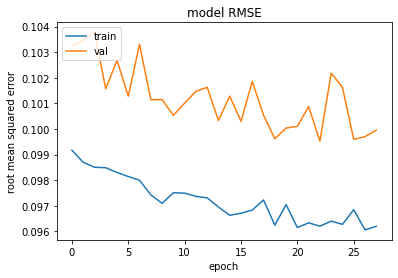

In [ ]:
history_or_2 = model_2.fit(X_train_or2, y_train_or2, validation_data=(X_val1_or2, y_val1_or2), epochs=50, callbacks=[early_stopping_monitor],verbose=False)

# summarize history for rmse
plt.plot(history_or_2.history['root_mean_squared_error'])
plt.plot(history_or_2.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('root mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
print(classification_report(test_results_or_2['actuals'], test_results_or_2['predictions']))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       225
         1.0       0.98      0.98      0.98        84
         2.0       0.98      0.98      0.98        95
         3.0       0.99      1.00      0.99       203
         4.0       1.00      0.99      1.00       117

    accuracy                           0.99       724
   macro avg       0.99      0.99      0.99       724
weighted avg       0.99      0.99      0.99       724



###comparing all the LSTM models

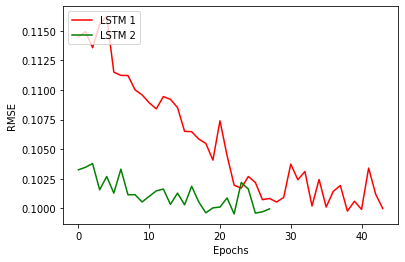

In [ ]:
plt.plot(history_or_1.history['val_root_mean_squared_error'], 'r',
         history_or_2.history['val_root_mean_squared_error'],'g')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend(['LSTM 1', 'LSTM 2'], loc='upper left')
plt.show()

####predicting for 1 jan 2021 until 1 feb 2021 using the 2nd model

In [ ]:
df_date = pd.DataFrame({
    'date':pd.date_range(start='2021-01-01', end='2021-02-01')
})
df_date

date
0  2021-01-01
1  2021-01-02
2  2021-01-03
3  2021-01-04
4  2021-01-05
5  2021-01-06
6  2021-01-07
7  2021-01-08
8  2021-01-09
9  2021-01-10
10 2021-01-11
11 2021-01-12
12 2021-01-13
13 2021-01-14
14 2021-01-15
15 2021-01-16
16 2021-01-17
17 2021-01-18
18 2021-01-19
19 2021-01-20
20 2021-01-21
21 2021-01-22
22 2021-01-23
23 2021-01-24
24 2021-01-25
25 2021-01-26
26 2021-01-27
27 2021-01-28
28 2021-01-29
29 2021-01-30
30 2021-01-31
31 2021-02-01

In [ ]:
df_date.index = pd.to_datetime(df_date['date'], format='%Y.%m.%d')
df_date

date
date                 
2021-01-01 2021-01-01
2021-01-02 2021-01-02
2021-01-03 2021-01-03
2021-01-04 2021-01-04
2021-01-05 2021-01-05
2021-01-06 2021-01-06
2021-01-07 2021-01-07
2021-01-08 2021-01-08
2021-01-09 2021-01-09
2021-01-10 2021-01-10
2021-01-11 2021-01-11
2021-01-12 2021-01-12
2021-01-13 2021-01-13
2021-01-14 2021-01-14
2021-01-15 2021-01-15
2021-01-16 2021-01-16
2021-01-17 2021-01-17
2021-01-18 2021-01-18
2021-01-19 2021-01-19
2021-01-20 2021-01-20
2021-01-21 2021-01-21
2021-01-22 2021-01-22
2021-01-23 2021-01-23
2021-01-24 2021-01-24
2021-01-25 2021-01-25
2021-01-26 2021-01-26
2021-01-27 2021-01-27
2021-01-28 2021-01-28
2021-01-29 2021-01-29
2021-01-30 2021-01-30
2021-01-31 2021-01-31
2021-02-01 2021-02-01

In [ ]:
df_date['Seconds'] = df_date.index.map(pd.Timestamp.timestamp)
df_date

date       Seconds
date                               
2021-01-01 2021-01-01  1.609459e+09
2021-01-02 2021-01-02  1.609546e+09
2021-01-03 2021-01-03  1.609632e+09
2021-01-04 2021-01-04  1.609718e+09
2021-01-05 2021-01-05  1.609805e+09
2021-01-06 2021-01-06  1.609891e+09
2021-01-07 2021-01-07  1.609978e+09
2021-01-08 2021-01-08  1.610064e+09
2021-01-09 2021-01-09  1.610150e+09
2021-01-10 2021-01-10  1.610237e+09
2021-01-11 2021-01-11  1.610323e+09
2021-01-12 2021-01-12  1.610410e+09
2021-01-13 2021-01-13  1.610496e+09
2021-01-14 2021-01-14  1.610582e+09
2021-01-15 2021-01-15  1.610669e+09
2021-01-16 2021-01-16  1.610755e+09
2021-01-17 2021-01-17  1.610842e+09
2021-01-18 2021-01-18  1.610928e+09
2021-01-19 2021-01-19  1.611014e+09
2021-01-20 2021-01-20  1.611101e+09
2021-01-21 2021-01-21  1.611187e+09
2021-01-22 2021-01-22  1.611274e+09
2021-01-23 2021-01-23  1.611360e+09
2021-01-24 2021-01-24  1.611446e+09
2021-01-25 2021-01-25  1.611533e+09
2021-01-26 2021-01-26  1.611619e+09
2021-01-27 2021-01-27  1.611706e+09
2021-01-28 2021-01-28  1.611792e+09
2021-01-29 2021-01-29  1.611878e+09
2021-01-30 2021-01-30  1.611965e+09
2021-01-31 2021-01-31  1.612051e+09
2021-02-01 2021-02-01  1.612138e+09

In [ ]:
df_date['Day sin'] = np.sin(df_date['Seconds'] * (2* np.pi / day))
df_date['Day cos'] = np.cos(df_date['Seconds'] * (2 * np.pi / day))
df_date['Month sin'] = np.sin(df_date['Seconds'] * (2* np.pi / month))
df_date['Month cos'] = np.cos(df_date['Seconds'] * (2* np.pi / month))
df_date['Year sin'] = np.sin(df_date['Seconds'] * (2 * np.pi / year))
df_date['Year cos'] = np.cos(df_date['Seconds'] * (2 * np.pi / year))
df_date.head()

date       Seconds       Day sin  Day cos  Month sin  \
date                                                                    
2021-01-01 2021-01-01  1.609459e+09 -6.012051e-12      1.0   0.114525   
2021-01-02 2021-01-02  1.609546e+09 -1.713513e-12      1.0   0.315714   
2021-01-03 2021-01-03  1.609632e+09 -1.196689e-11      1.0   0.503497   
2021-01-04 2021-01-04  1.609718e+09 -7.668351e-12      1.0   0.669900   
2021-01-05 2021-01-05  1.609805e+09 -3.369812e-12      1.0   0.807857   

            Month cos  Year sin  Year cos  
date                                       
2021-01-01   0.993420  0.010881  0.999941  
2021-01-02   0.948854  0.028080  0.999606  
2021-01-03   0.863997  0.045271  0.998975  
2021-01-04   0.742451  0.062448  0.998048  
2021-01-05   0.589379  0.079608  0.996826

In [ ]:
df_date = df_date.drop('Seconds', axis=1)
df_date = df_date.drop('date',axis=1)
df_date.head()

Day sin  Day cos  Month sin  Month cos  Year sin  Year cos
date                                                                       
2021-01-01 -6.012051e-12      1.0   0.114525   0.993420  0.010881  0.999941
2021-01-02 -1.713513e-12      1.0   0.315714   0.948854  0.028080  0.999606
2021-01-03 -1.196689e-11      1.0   0.503497   0.863997  0.045271  0.998975
2021-01-04 -7.668351e-12      1.0   0.669900   0.742451  0.062448  0.998048
2021-01-05 -3.369812e-12      1.0   0.807857   0.589379  0.079608  0.996826

In [ ]:
df_date.insert(0, "score", [0 for i in range(32)], True)
df_date

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2021-01-01      0 -6.012051e-12      1.0   0.114525   0.993420  0.010881   
2021-01-02      0 -1.713513e-12      1.0   0.315714   0.948854  0.028080   
2021-01-03      0 -1.196689e-11      1.0   0.503497   0.863997  0.045271   
2021-01-04      0 -7.668351e-12      1.0   0.669900   0.742451  0.062448   
2021-01-05      0 -3.369812e-12      1.0   0.807857   0.589379  0.079608   
2021-01-06      0  9.287266e-13      1.0   0.911509   0.411280  0.096743   
2021-01-07      0 -9.324650e-12      1.0   0.976456   0.215716  0.113850   
2021-01-08      0 -5.026111e-12      1.0   0.999940   0.010992  0.130923   
2021-01-09      0 -7.275728e-13      1.0   0.980962  -0.194198  0.147958   
2021-01-10      0 -1.098095e-11      1.0   0.920330  -0.391142  0.164948   
2021-01-11      0 -6.682411e-12      1.0   0.820618  -0.571477  0.181890   
2021-01-12      0 -2.383872e-12      1.0   0.686059  -0.727545  0.198778   
2021-01-13      0 -1.263725e-11      1.0   0.522369  -0.852720  0.215608   
2021-01-14      0 -8.338710e-12      1.0   0.336497  -0.941685  0.232373   
2021-01-15      0 -4.040172e-12      1.0   0.136336  -0.990663  0.249070   
2021-01-16      0  2.583671e-13      1.0  -0.069615  -0.997574  0.265693   
2021-01-17      0 -9.995009e-12      1.0  -0.272609  -0.962125  0.282237   
2021-01-18      0 -5.696471e-12      1.0  -0.464027  -0.885821  0.298698   
2021-01-19      0 -1.397932e-12      1.0  -0.635741  -0.771902  0.315070   
2021-01-20      0 -1.165131e-11      1.0  -0.780460  -0.625206  0.331350   
2021-01-21      0 -7.352770e-12      1.0  -0.892037  -0.451961  0.347531   
2021-01-22      0 -3.054232e-12      1.0  -0.965736  -0.259525  0.363609   
2021-01-23      0 -1.330761e-11      1.0  -0.998427  -0.056069  0.379580   
2021-01-24      0 -9.009070e-12      1.0  -0.988721   0.149769  0.395438   
2021-01-25      0 -4.710531e-12      1.0  -0.937031   0.349247  0.411179   
2021-01-26      0 -4.119923e-13      1.0  -0.845551   0.533894  0.426799   
2021-01-27      0 -1.066537e-11      1.0  -0.718167   0.695871  0.442292   
2021-01-28      0 -6.366830e-12      1.0  -0.560287   0.828299  0.457655   
2021-01-29      0 -2.068292e-12      1.0  -0.378615   0.925554  0.472882   
2021-01-30      0 -1.232167e-11      1.0  -0.180866   0.983508  0.487969   
2021-01-31      0 -8.023130e-12      1.0   0.024563   0.999698  0.502912   
2021-02-01      0 -3.724591e-12      1.0   0.228949   0.973438  0.517705   

            Year cos  
date                  
2021-01-01  0.999941  
2021-01-02  0.999606  
2021-01-03  0.998975  
2021-01-04  0.998048  
2021-01-05  0.996826  
2021-01-06  0.995309  
2021-01-07  0.993498  
2021-01-08  0.991393  
2021-01-09  0.988994  
2021-01-10  0.986302  
2021-01-11  0.983319  
2021-01-12  0.980044  
2021-01-13  0.976480  
2021-01-14  0.972627  
2021-01-15  0.968486  
2021-01-16  0.964058  
2021-01-17  0.959345  
2021-01-18  0.954348  
2021-01-19  0.949068  
2021-01-20  0.943508  
2021-01-21  0.937669  
2021-01-22  0.931552  
2021-01-23  0.925159  
2021-01-24  0.918493  
2021-01-25  0.911554  
2021-01-26  0.904347  
2021-01-27  0.896871  
2021-01-28  0.889130  
2021-01-29  0.881126  
2021-01-30  0.872861  
2021-01-31  0.864338  
2021-02-01  0.855559

In [ ]:
x_test_or = scoreor_test_df.tail(7)
x_test_or

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2020-12-25    4.0 -6.997991e-12      1.0  -0.971208   0.238232 -0.109320   
2020-12-26    4.0 -2.699453e-12      1.0  -0.901757   0.432242 -0.092205   
2020-12-27    4.0 -1.295283e-11      1.0  -0.794015   0.607898 -0.075062   
2020-12-28    4.0 -8.654291e-12      1.0  -0.652557   0.757740 -0.057898   
2020-12-29    4.0 -4.355752e-12      1.0  -0.483388   0.875406 -0.040716   
2020-12-30    4.0 -5.721331e-14      1.0  -0.293694   0.955900 -0.023523   
2020-12-31    4.0 -1.031059e-11      1.0  -0.091528   0.995803 -0.006322   

            Year cos  
date                  
2020-12-25  0.994007  
2020-12-26  0.995740  
2020-12-27  0.997179  
2020-12-28  0.998323  
2020-12-29  0.999171  
2020-12-30  0.999723  
2020-12-31  0.999980

In [ ]:
x_test1_or = x_test_or.append(df_date)
x_test1_or

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2020-12-25    4.0 -6.997991e-12      1.0  -0.971208   0.238232 -0.109320   
2020-12-26    4.0 -2.699453e-12      1.0  -0.901757   0.432242 -0.092205   
2020-12-27    4.0 -1.295283e-11      1.0  -0.794015   0.607898 -0.075062   
2020-12-28    4.0 -8.654291e-12      1.0  -0.652557   0.757740 -0.057898   
2020-12-29    4.0 -4.355752e-12      1.0  -0.483388   0.875406 -0.040716   
2020-12-30    4.0 -5.721331e-14      1.0  -0.293694   0.955900 -0.023523   
2020-12-31    4.0 -1.031059e-11      1.0  -0.091528   0.995803 -0.006322   
2021-01-01    0.0 -6.012051e-12      1.0   0.114525   0.993420  0.010881   
2021-01-02    0.0 -1.713513e-12      1.0   0.315714   0.948854  0.028080   
2021-01-03    0.0 -1.196689e-11      1.0   0.503497   0.863997  0.045271   
2021-01-04    0.0 -7.668351e-12      1.0   0.669900   0.742451  0.062448   
2021-01-05    0.0 -3.369812e-12      1.0   0.807857   0.589379  0.079608   
2021-01-06    0.0  9.287266e-13      1.0   0.911509   0.411280  0.096743   
2021-01-07    0.0 -9.324650e-12      1.0   0.976456   0.215716  0.113850   
2021-01-08    0.0 -5.026111e-12      1.0   0.999940   0.010992  0.130923   
2021-01-09    0.0 -7.275728e-13      1.0   0.980962  -0.194198  0.147958   
2021-01-10    0.0 -1.098095e-11      1.0   0.920330  -0.391142  0.164948   
2021-01-11    0.0 -6.682411e-12      1.0   0.820618  -0.571477  0.181890   
2021-01-12    0.0 -2.383872e-12      1.0   0.686059  -0.727545  0.198778   
2021-01-13    0.0 -1.263725e-11      1.0   0.522369  -0.852720  0.215608   
2021-01-14    0.0 -8.338710e-12      1.0   0.336497  -0.941685  0.232373   
2021-01-15    0.0 -4.040172e-12      1.0   0.136336  -0.990663  0.249070   
2021-01-16    0.0  2.583671e-13      1.0  -0.069615  -0.997574  0.265693   
2021-01-17    0.0 -9.995009e-12      1.0  -0.272609  -0.962125  0.282237   
2021-01-18    0.0 -5.696471e-12      1.0  -0.464027  -0.885821  0.298698   
2021-01-19    0.0 -1.397932e-12      1.0  -0.635741  -0.771902  0.315070   
2021-01-20    0.0 -1.165131e-11      1.0  -0.780460  -0.625206  0.331350   
2021-01-21    0.0 -7.352770e-12      1.0  -0.892037  -0.451961  0.347531   
2021-01-22    0.0 -3.054232e-12      1.0  -0.965736  -0.259525  0.363609   
2021-01-23    0.0 -1.330761e-11      1.0  -0.998427  -0.056069  0.379580   
2021-01-24    0.0 -9.009070e-12      1.0  -0.988721   0.149769  0.395438   
2021-01-25    0.0 -4.710531e-12      1.0  -0.937031   0.349247  0.411179   
2021-01-26    0.0 -4.119923e-13      1.0  -0.845551   0.533894  0.426799   
2021-01-27    0.0 -1.066537e-11      1.0  -0.718167   0.695871  0.442292   
2021-01-28    0.0 -6.366830e-12      1.0  -0.560287   0.828299  0.457655   
2021-01-29    0.0 -2.068292e-12      1.0  -0.378615   0.925554  0.472882   
2021-01-30    0.0 -1.232167e-11      1.0  -0.180866   0.983508  0.487969   
2021-01-31    0.0 -8.023130e-12      1.0   0.024563   0.999698  0.502912   
2021-02-01    0.0 -3.724591e-12      1.0   0.228949   0.973438  0.517705   

            Year cos  
date                  
2020-12-25  0.994007  
2020-12-26  0.995740  
2020-12-27  0.997179  
2020-12-28  0.998323  
2020-12-29  0.999171  
2020-12-30  0.999723  
2020-12-31  0.999980  
2021-01-01  0.999941  
2021-01-02  0.999606  
2021-01-03  0.998975  
2021-01-04  0.998048  
2021-01-05  0.996826  
2021-01-06  0.995309  
2021-01-07  0.993498  
2021-01-08  0.991393  
2021-01-09  0.988994  
2021-01-10  0.986302  
2021-01-11  0.983319  
2021-01-12  0.980044  
2021-01-13  0.976480  
2021-01-14  0.972627  
2021-01-15  0.968486  
2021-01-16  0.964058  
2021-01-17  0.959345  
2021-01-18  0.954348  
2021-01-19  0.949068  
2021-01-20  0.943508  
2021-01-21  0.937669  
2021-01-22  0.931552  
2021-01-23  0.925159  
2021-01-24  0.918493  
2021-01-25  0.911554  
2021-01-26  0.904347  
2021-01-27  0.896871  
2021-01-28  0.889130  
2021-01-29  0.881126  
2021-01-30  0.872861 

In [ ]:
WINDOW_SIZE = 7
X_test1_or2_new, y_test1_or2_new = df_to_X_y2(x_test1_or, WINDOW_SIZE)
X_test1_or2_new.shape

(32, 7, 7)

In [ ]:
test_prediction_2_new_or = model_2.predict(X_test1_or2_new).flatten()
test_results_2_new_or = pd.DataFrame(data={'predictions':test_prediction_2_new_or})
test_results_2_new_or

1/1 [==============================] - 0s 20ms/step


predictions
0      5.207595
1      1.806908
2      1.213023
3      1.083144
4      1.106004
5      1.174113
6      1.230776
7      1.241107
8      1.243038
9      1.243963
10     1.243994
11     1.243440
12     1.242705
13     1.242195
14     1.242222
15     1.242928
16     1.244231
17     1.245829
18     1.247283
19     1.248153
20     1.248155
21     1.247245
22     1.245619
23     1.243597
24     1.241476
25     1.239410
26     1.237381
27     1.235272
28     1.233003
29     1.230651
30     1.228506
31     1.227017

#####result

In [ ]:
test_results_2_new_or.predictions[test_results_2_new_or.predictions <0.5] = 0
test_results_2_new_or.predictions[(test_results_2_new_or.predictions >=0.5)&(test_results_2_new_or.predictions<1.5)] = 1
test_results_2_new_or.predictions[(test_results_2_new_or.predictions >=1.5)&(test_results_2_new_or.predictions<2.5)] = 2
test_results_2_new_or.predictions[(test_results_2_new_or.predictions >=2.5)&(test_results_2_new_or.predictions<3.5)] = 3
test_results_2_new_or.predictions[(test_results_2_new_or.predictions >=3.5)&(test_results_2_new_or.predictions<4.5)] = 4
test_results_2_new_or.predictions[(test_results_2_new_or.predictions >=4.5)&(test_results_2_new_or.predictions<5.5)] = 5
test_results_2_new_or

predictions
0           5.0
1           2.0
2           1.0
3           1.0
4           1.0
5           1.0
6           1.0
7           1.0
8           1.0
9           1.0
10          1.0
11          1.0
12          1.0
13          1.0
14          1.0
15          1.0
16          1.0
17          1.0
18          1.0
19          1.0
20          1.0
21          1.0
22          1.0
23          1.0
24          1.0
25          1.0
26          1.0
27          1.0
28          1.0
29          1.0
30          1.0
31          1.0